<a href="https://colab.research.google.com/github/vasudev-sharma/Expand_AI-Assignment/blob/master/Expand_ai_problem_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount the drive on Google Colab

In [2]:
from PIL import Image

In [3]:
# !pip install progress

In [4]:
# install weights and biases, and torchkeras library
# !pip install wandb
# !pip install torchkeras
# !pip install gdown

In [5]:
# import libraries
import os
import math
import random
import shutil
from tqdm import tqdm 
from pathlib import Path
import wandb

# import scientific libraries
import numpy as np

# import pytorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
import time
import torch.nn.functional as F



In [6]:
# set seed to reproduce results
np.random.seed(42)

In [7]:
#@title
# initialize wandb for logging
!wandb login 202040aaac395bbf5a4a47d433a5335b74b7fb0e

wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Yy/.netrc


In [8]:
# Download the data from Google Drive

# !FILEID='1PVJcXmKz-QPAvPV-rRFYnjh7BsFnAeq8' && \
# FILENAME='diseases.zip' && \
# FILEDEST="https://docs.google.com/uc?export=download&id=${FILEID}" && \
# wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate ${FILEDEST} -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=${FILEID}" -O $FILENAME && rm -rf /tmp/cookies.txt

In [9]:
# unizip the data
# !unzip diseases.zip -d diseases

In [10]:
# path of data
# 两个文件夹 covid normal（将test文件的路径放过来就可以）
data_path = r"D:\my_code_2\my_code\mh-metacovid-siamese-neural-network\metacovid-siamese-neural-network-main\scripts\dataset\pretrain_2c_0727\test"

CLASSES = ["COVID", "NORMAL"]




# DATASET PREPARATION

In [11]:
list_images = os.listdir(data_path)
len_data = len(list_images)
print(len_data)

2


# DATASETS AND DATALOADERS

In [12]:
# transforms
train_transform = transforms.Compose(
    [
     transforms.Resize(256),
     transforms.RandomCrop(224),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)
test_transform = transforms.Compose(
    [
     transforms.Resize((256,256)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [13]:
# datasets

ds_train = datasets.ImageFolder(str(data_path), transform = train_transform, target_transform = lambda t:torch.tensor(t).long())
ds_test = datasets.ImageFolder(str(data_path), transform = test_transform, target_transform = lambda t: torch.tensor(t).long())

In [14]:
# preparing data for problem 2
# Code has been adapted from GH repo - https://github.com/YU1ut/MixMatch-pytorch

# As per the problem: 
classes_len = 2
n_labeled_per_class = 20


In [15]:
def train_val_split(labels, n_labeled_per_class, classes_len):
    """
    数据划分
    有标签数据前20个，无标签数据从第21个到倒数20，验证集数据倒数20个
    """
    labels = np.array(labels)
    train_labeled_idxs = []
    train_unlabeled_idxs = []
    val_idxs = []

    for i in range(classes_len): 
        idxs = np.where(labels == i)[0]
        np.random.shuffle(idxs)
        train_labeled_idxs.extend(idxs[:n_labeled_per_class]) 
        train_unlabeled_idxs.extend(idxs[n_labeled_per_class:-20])
        val_idxs.extend(idxs[-20:])
    np.random.shuffle(train_labeled_idxs)
    np.random.shuffle(train_unlabeled_idxs)
    np.random.shuffle(val_idxs)

    return train_labeled_idxs, train_unlabeled_idxs, val_idxs

In [16]:
# 分为有标签数据、无标签数据、验证集
train_labeled_idxs, train_unlabeled_idxs, val_idxs = train_val_split(ds_train.targets, n_labeled_per_class, classes_len)

In [17]:
def pil_loader(path: str):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')


# TODO: specify the return type
def accimage_loader(path: str):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)


def default_loader(path: str):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)



In [18]:
def replace_labels(samples_list, agg_label_xlsx):
    """
    替换标签
    :param samples_list:
    :param agg_label_xlsx:
    :return:
    """
    df_train_20 = pd.DataFrame(samples_list, columns=["image", "label"])
    df_true = pd.read_excel(agg_label_xlsx)
    # """
    images_filenames = []
    for i in df_train_20["image"]:
        i = i.split("\\")[-2:]
        a = "\\".join(i)
        images_filenames.append(a)
    df_train_20["filenames"] = images_filenames
    df = pd.merge(df_train_20, df_true, on="filenames", how='left')
    # 后面真实操作的时候将true_label改成教师聚合label
    # 使用教师聚合label和加噪后的label
    df = df[["image_x", "teacher_labels"]]
    samples = [list(x) for x in df.values]
    targets = df["teacher_labels"].tolist()
    return samples, targets

## Dataset

In [19]:
class ChestXRay_labeled(datasets.ImageFolder):

    def __init__(self, root, indexs=None,
                 transform=None, target_transform=None,
                 loader=default_loader
                 , is_valid_file=None):
        super(ChestXRay_labeled, self).__init__(root,
                 transform=transform, target_transform=target_transform,
                 loader=loader,
                 is_valid_file=is_valid_file)
        
#         if indexs is not None:
#             self.samples = np.array(self.imgs)[indexs].tolist()
#             # print(len(self.samples))
#             self.targets = np.array(self.targets)[indexs]
#             # print(type(self.targets[0]))
        if indexs is not None:
            # self.samples = np.array(self.imgs)[indexs].tolist()
            samples = np.array(self.imgs)[indexs].tolist()
            # self.targets = np.array(self.targets)[indexs]
            agg_label_xlsx = "2_10_epsilon_1.xlsx"
            self.samples, self.targets = replace_labels(samples, agg_label_xlsx)
#         else:
#             print("test")
#             self.samples = np.array(self.imgs)[indexs].tolist()
#             self.targets = np.array(self.targets)[indexs]
            
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = super(ChestXRay_labeled, self).__getitem__(index)
        
        return img, target

In [20]:
import pandas as pd
# Train Dataset
train_labeled_dataset = ChestXRay_labeled(str(data_path), train_labeled_idxs, transform=train_transform, target_transform=lambda t:torch.tensor((float(t))).long())

In [21]:
# Validation and Test Datasets
val_dataset = ChestXRay_labeled(str(data_path), val_idxs, transform=test_transform, target_transform=lambda t:torch.tensor((float(t))).long())
test_dataset = ChestXRay_labeled(str(data_path), transform=test_transform, target_transform=lambda t:torch.tensor((float(t))).long())
print(len(test_dataset))

1200


In [22]:
# print(len(train_labeled_idxs))
assert len(train_labeled_idxs) == 40

In [23]:
print(len(train_labeled_idxs))
print(len(train_unlabeled_idxs))
print(len(val_idxs))
print(len(test_dataset))

40
1120
40
1200


In [24]:
 class TransformTwice:

  def __init__(self, transform):
    self.transform = transform

  def __call__(self, inp):
    out1 = self.transform(inp)
    out2 = self.transform(inp)
    return out1, out2

In [25]:

class ChestXRay_unlabeled(datasets.ImageFolder):

    def __init__(self, root, indexs=None,
                 transform=None, target_transform=None,
                 loader=default_loader
                 , is_valid_file=None):
        super(ChestXRay_unlabeled, self).__init__(root,
                 transform=transform, target_transform=target_transform,
                 loader=loader,
                 is_valid_file=is_valid_file)
#         self.targets = np.array([-1 for i in range(len(self.targets))])
        if indexs is not None:
            # self.samples = np.array(self.imgs)[indexs].tolist()
            samples = np.array(self.imgs)[indexs].tolist()
            # self.targets = np.array(self.targets)[indexs]
            agg_label_xlsx = "2_10_epsilon_1.xlsx"
            self.samples, self.targets = replace_labels(samples, agg_label_xlsx)
        # print(self.samples)
        self.targets = np.array([-1 for i in range(len(self.targets))])
        # print(self.targets)
        

In [26]:

train_unlabeled_dataset = ChestXRay_unlabeled(str(data_path), train_unlabeled_idxs, transform=TransformTwice(train_transform))


## Hyperparameters

---



In [27]:
# set hyperparameters
batch_size = 16
lr = 5e-5
epochs = 30 # 30
log_freq = 10
ema_decay = 0.999
train_iteration = 512 # No of iterations per epoch  512
lambda_u = 75
T = 0.5

num_classes = len(CLASSES)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



## DataLoaders

In [28]:
# Train Dataloaders 
labeled_trainloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)
unlabeled_trainloader = DataLoader(train_unlabeled_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=True)

In [29]:
# Validation dataloader 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, drop_last=True)

# Test loader on entire set of 900 images
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, pin_memory=True, drop_last=True)

In [30]:
print(len(val_loader))

2


In [31]:
# sanity check labeled train dataloader
for batch in labeled_trainloader:
  img, target =  batch
  
  print(img.shape)
  print(target.shape)
  print(target.dtype)
  break

torch.Size([16, 3, 224, 224])
torch.Size([16])
torch.int64


In [32]:
# sanity check unlabeled train dataloader
for batch in unlabeled_trainloader:
  (img1, img2), _ =  batch
  
  print(img1.shape)
  print(img2.shape)

  break 

torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])


In [33]:
# Class labels
print(train_unlabeled_dataset.class_to_idx)

{'covid': 0, 'normal': 1}


## Plotting the images

In [34]:
# %matplotlib inline

# # plot the images
# import matplotlib.pyplot as plt
# plt.figure(figsize=(9, 9))
# # plot 9 images
# for i in range(9):
#   image, label = train_labeled_dataset[i]
#   img = image.permute(1, 2, 0)
#   ax = plt.subplot(3, 3, i + 1)
#   ax.imshow(img.numpy())
#   ax.set_title('Class = %s' % CLASSES[int(label.item())])
#   ax.set_xticks([])
#   ax.set_yticks([])
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]  =  "TRUE"
# plt.show()

In [35]:
#@title
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    def __init__(self, in_planes, out_planes, stride, dropRate=0.0, activate_before_residual=False):
        super(BasicBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes, momentum=0.001)
        self.relu1 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes, momentum=0.001)
        self.relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.droprate = dropRate
        self.equalInOut = (in_planes == out_planes)
        self.convShortcut = (not self.equalInOut) and nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride,
                               padding=0, bias=False) or None
        self.activate_before_residual = activate_before_residual
    def forward(self, x):
        if not self.equalInOut and self.activate_before_residual == True:
            x = self.relu1(self.bn1(x))
        else:
            out = self.relu1(self.bn1(x))
        out = self.relu2(self.bn2(self.conv1(out if self.equalInOut else x)))
        if self.droprate > 0:
            out = F.dropout(out, p=self.droprate, training=self.training)
        out = self.conv2(out)
        return torch.add(x if self.equalInOut else self.convShortcut(x), out)

class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride, dropRate=0.0, activate_before_residual=False):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual)
    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride, dropRate, activate_before_residual):
        layers = []
        for i in range(int(nb_layers)):
            layers.append(block(i == 0 and in_planes or out_planes, out_planes, i == 0 and stride or 1, dropRate, activate_before_residual))
        return nn.Sequential(*layers)
    def forward(self, x):
        return self.layer(x)

class WideResNet(nn.Module):
    def __init__(self, num_classes, depth=28, widen_factor=2, dropRate=0.0):
        super(WideResNet, self).__init__()
        nChannels = [16, 16*widen_factor, 32*widen_factor, 64*widen_factor]
        assert((depth - 4) % 6 == 0)
        n = (depth - 4) / 6
        block = BasicBlock
        # 1st conv before any network block
        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1,
                               padding=1, bias=False)
        # 1st block
        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1, dropRate, activate_before_residual=True)
        # 2nd block
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2, dropRate)
        # 3rd block
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2, dropRate)
        # global average pooling and classifier
        self.bn1 = nn.BatchNorm2d(nChannels[3], momentum=0.001)
        self.relu = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                m.bias.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        out = self.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

# Training

In [36]:
def create_model(ema=False):
  # Move the model to CUDA, if available
#     global model
    if not torch.cuda.is_available():
        # model = WideResNet(num_classes=3)
        model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet50', pretrained=True)
        model.fc = nn.Linear(2048, num_classes)
        model.to("cpu")
  
    if ema == True:
        for param in model.parameters():
          param.detach_()
    return model


In [37]:
model = create_model()
ema_model = create_model(ema=True)

Using cache found in C:\Users\Yy/.cache\torch\hub\pytorch_vision_v0.9.0
Using cache found in C:\Users\Yy/.cache\torch\hub\pytorch_vision_v0.9.0


In [38]:
#@title

def linear_rampup(current, rampup_length=epochs):
    if rampup_length == 0:
        return 1.0
    else:
        current = np.clip(current / rampup_length, 0.0, 1.0)
        return float(current)

class SemiLoss(object):
    def __call__(self, outputs_x, targets_x, outputs_u, targets_u, epoch):
        probs_u = torch.softmax(outputs_u, dim=1)

        Lx = -torch.mean(torch.sum(F.log_softmax(outputs_x, dim=1) * targets_x, dim=1))
        Lu = torch.mean((probs_u - targets_u)**2)

        return Lx, Lu, lambda_u * linear_rampup(epoch)

class WeightEMA(object):
    def __init__(self, model, ema_model, alpha=0.999):
        self.model = model
        self.ema_model = ema_model
        self.alpha = alpha
        self.params = list(model.state_dict().values())
        self.ema_params = list(ema_model.state_dict().values())
        self.wd = 0.02 * lr

        for param, ema_param in zip(self.params, self.ema_params):
            param.data.copy_(ema_param.data)

    def step(self):
        one_minus_alpha = 1.0 - self.alpha
        for param, ema_param in zip(self.params, self.ema_params):
            if ema_param.dtype==torch.float32:
                ema_param.mul_(self.alpha)
                ema_param.add_(param * one_minus_alpha)
                # customized weight decay
                param.mul_(1 - self.wd)

def interleave_offsets(batch, nu):
    groups = [batch // (nu + 1)] * (nu + 1)
    for x in range(batch - sum(groups)):
        groups[-x - 1] += 1
    offsets = [0]
    for g in groups:
        offsets.append(offsets[-1] + g)
    assert offsets[-1] == batch
    return offsets


def interleave(xy, batch):
    nu = len(xy) - 1
    offsets = interleave_offsets(batch, nu)
    xy = [[v[offsets[p]:offsets[p + 1]] for p in range(nu + 1)] for v in xy]
    for i in range(1, nu + 1):
        xy[0][i], xy[i][i] = xy[i][i], xy[0][i]
    return [torch.cat(v, dim=0) for v in xy]

In [39]:
#@title

from typing import Tuple
# Macro F1 score PyTorch

class F1Score:
    """
    Class for f1 calculation in Pytorch.
    """

    def __init__(self, average: str = 'weighted'):
        """
        Init.

        Args:
            average: averaging method
        """
        self.average = average
        if average not in [None, 'micro', 'macro', 'weighted']:
            raise ValueError('Wrong value of average parameter')

    @staticmethod
    def calc_f1_micro(predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 micro.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """
        true_positive = torch.eq(labels, predictions).sum().float()
        f1_score = torch.div(true_positive, len(labels))
        return f1_score

    @staticmethod
    def calc_f1_count_for_label(predictions: torch.Tensor,
                                labels: torch.Tensor, label_id: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Calculate f1 and true count for the label

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels
            label_id: id of current label

        Returns:
            f1 score and true count for label
        """
        # label count
        true_count = torch.eq(labels, label_id).sum()

        # true positives: labels equal to prediction and to label_id
        true_positive = torch.logical_and(torch.eq(labels, predictions),
                                          torch.eq(labels, label_id)).sum().float()
        # precision for label
        precision = torch.div(true_positive, torch.eq(predictions, label_id).sum().float())
        # replace nan values with 0
        precision = torch.where(torch.isnan(precision),
                                torch.zeros_like(precision).type_as(true_positive),
                                precision)

        # recall for label
        recall = torch.div(true_positive, true_count)
        # f1
        f1 = 2 * precision * recall / (precision + recall)
        # replace nan values with 0
        f1 = torch.where(torch.isnan(f1), torch.zeros_like(f1).type_as(true_positive), f1)
        return f1, true_count

    def __call__(self, predictions: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """
        Calculate f1 score based on averaging method defined in init.

        Args:
            predictions: tensor with predictions
            labels: tensor with original labels

        Returns:
            f1 score
        """

        # simpler calculation for micro
        if self.average == 'micro':
            return self.calc_f1_micro(predictions, labels)

        f1_score = 0
        for label_id in range(1, len(labels.unique()) + 1):
            f1, true_count = self.calc_f1_count_for_label(predictions, labels, label_id)

            if self.average == 'weighted':
                f1_score += f1 * true_count
            elif self.average == 'macro':
                f1_score += f1

        if self.average == 'weighted':
            f1_score = torch.div(f1_score, len(labels))
        elif self.average == 'macro':
            f1_score = torch.div(f1_score, len(labels.unique()))

        return f1_score

## Set Optimzers, losses, and metrics(macro_F1, micro_F1)


In [40]:
# Define optimizer, loss, macro and micro F1 scores

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# model.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(model.optimizer, T_max = 5)
criterion = torch.nn.CrossEntropyLoss()

train_criterion = SemiLoss()
ema_optimizer= WeightEMA(model, ema_model, alpha=ema_decay)

macro_f1_score = F1Score(average='macro')
micro_f1_score = F1Score(average='micro')

In [41]:
from progress.bar import Bar 

class AverageMeter(object):
  def __init__(self):
    self.reset()
  
  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0
  
  def update(self, val, n=1):
    self.val = val
    self.sum += val*n
    self.count += n
    self.avg = self.sum / self.count


In [42]:
def train(labeled_trainloader, unlabeled_trainloader, model, epoch, train_iteration=1024, T=0.5, alpha=0.75):

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    losses_x = AverageMeter()
    losses_u = AverageMeter()
    ws = AverageMeter()
    end = time.time()

    bar = Bar('Training', max=train_iteration)
    labeled_train_iter = iter(labeled_trainloader)
    unlabeled_train_iter = iter(unlabeled_trainloader)

    model.train()
    for batch_idx in range(train_iteration):
        try:
            inputs_x, targets_x = labeled_train_iter.next()
        except:
            labeled_train_iter = iter(labeled_trainloader)
            inputs_x, targets_x = labeled_train_iter.next()

        try:
            (inputs_u, inputs_u2), _ = unlabeled_train_iter.next()
        except:
            unlabeled_train_iter = iter(unlabeled_trainloader)
            (inputs_u, inputs_u2), _ = unlabeled_train_iter.next()

        # measure data loading time
        data_time.update(time.time() - end)

        batch_size = inputs_x.size(0)

        # Transform label to one-hot
        targets_x = torch.zeros(batch_size, num_classes).scatter_(1, targets_x.view(-1,1).long(), 1)

#         inputs_x, targets_x = inputs_x.cuda(), targets_x.cuda(non_blocking=True)
#         inputs_u = inputs_u.cuda()
#         inputs_u2 = inputs_u2.cuda()

        with torch.no_grad():
            # compute guessed labels of unlabel samples
            outputs_u = model(inputs_u)
            outputs_u2 = model(inputs_u2)
            p = (torch.softmax(outputs_u, dim=1) + torch.softmax(outputs_u2, dim=1)) / 2
            pt = p**(1/T)
            targets_u = pt / pt.sum(dim=1, keepdim=True)
            targets_u = targets_u.detach()

        # mixup
        all_inputs = torch.cat([inputs_x, inputs_u, inputs_u2], dim=0)
        all_targets = torch.cat([targets_x, targets_u, targets_u], dim=0)

        l = np.random.beta(alpha, alpha)

        l = max(l, 1-l)

        idx = torch.randperm(all_inputs.size(0))

        input_a, input_b = all_inputs, all_inputs[idx]
        target_a, target_b = all_targets, all_targets[idx]


        mixed_input = l * input_a + (1 - l) * input_b
        mixed_target = l * target_a + (1 - l) * target_b



        # interleave labeled and unlabed samples between batches to get correct batchnorm calculation 
        mixed_input = list(torch.split(mixed_input, batch_size))
        mixed_input = interleave(mixed_input, batch_size)

        logits = [model(mixed_input[0])]
        for input in mixed_input[1:]:
            logits.append(model(input))

        # put interleaved samples back
        logits = interleave(logits, batch_size)
        logits_x = logits[0]
        logits_u = torch.cat(logits[1:], dim=0)

        Lx, Lu, w = train_criterion(logits_x, mixed_target[:batch_size], logits_u, mixed_target[batch_size:], epoch+batch_idx/train_iteration)

        loss = Lx + w * Lu
        # print('The loss is ', loss)

        # record loss
        losses.update(loss.item(), inputs_x.size(0))
        losses_x.update(Lx.item(), inputs_x.size(0))
        losses_u.update(Lu.item(), inputs_x.size(0))
        ws.update(w, inputs_x.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        ema_optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        # plot progress
        print('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | Loss_x: {loss_x:.4f} | Loss_u: {loss_u:.4f} | W: {w:.4f}'.format(
                    batch=batch_idx + 1,
                    size=train_iteration,
                    data=data_time.avg,
                    bt=batch_time.avg,
                    total=bar.elapsed_td,
                    eta=bar.eta_td,
                    loss=losses.avg,
                    loss_x=losses_x.avg,
                    loss_u=losses_u.avg,
                    w=ws.avg,
                    ))
  
    return (losses.avg, losses_x.avg, losses_u.avg,)


In [43]:
def valid(val_loader, model, epoch, mode):

  batch_time = AverageMeter()
  data_time = AverageMeter()
  losses = AverageMeter()
  macro_f1_scores = AverageMeter()
  micro_f1_scores = AverageMeter()
  accuracies = AverageMeter()

  model.eval()
  bar = Bar(f'{mode}', max=len(val_loader))
  end = time.time()
  print(f'\n************{mode}*************')
  with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(val_loader):

      # measure data loading time
      data_time.update(time.time() - end)

#       inputs, targets = inputs.cuda(), targets.cuda(non_blocking=True)

      # compute output
      outputs = model(inputs)

      # compute loss
      loss = criterion(outputs, targets)

      ## compute metrics
      # accuracy
      probs = torch.softmax(outputs, dim=1)
      predicted_labels = torch.argmax(probs, dim=1)

      correct = predicted_labels == targets
      accuracy = correct.sum() / float(targets.size(0))

      # macro F1 score
      macro_f1 = macro_f1_score(predicted_labels.flatten(), targets.flatten())

      # micro F1 score
      micro_f1 = micro_f1_score(predicted_labels.flatten(), targets.flatten())

      # update the loss and metrics
      losses.update(loss.item(), inputs.size(0))
      accuracies.update(accuracy, inputs.size(0))
      macro_f1_scores.update(macro_f1.item(), inputs.size(0))
      micro_f1_scores.update(micro_f1.item(), inputs.size(0))


      # measure elapsed time
      batch_time.update(time.time() - end)

      # print the logs
      print('({batch}/{size}) Data: {data:.3f}s | Batch: {bt:.3f}s | Total: {total:} | ETA: {eta:} | Loss: {loss:.4f} | Accuracy: {accuracy:.4f} | Macro_F1_score: {macro_f1_score:.4f} | Micro_F1_score: {micro_f1_score:.4f}'.format(
            batch=batch_idx + 1,
            size=len(val_loader),
            data=data_time.avg,
            bt=batch_time.avg,
            total=bar.elapsed_td,
            eta=bar.eta_td,
            loss=losses.avg,
            accuracy=accuracies.avg, 
            macro_f1_score=macro_f1_scores.avg, 
            micro_f1_score=micro_f1_scores.avg
            ))
      
  return losses.avg, accuracies.avg, macro_f1_scores.avg, micro_f1_scores.avg







In [44]:
def train_model(model, labeled_trainloader, unlabeled_trainloader, epochs, log_freq):
  print('********Training has started***************')


  wandb.watch(model, log='all')

  step = 0
  for epoch in range(1, epochs + 1):
    
    print('\n Epoch: [%d | %d]' % (epoch, epochs))

    train_loss, train_loss_x, train_loss_u = train(labeled_trainloader, unlabeled_trainloader, model, epoch=epoch, train_iteration=train_iteration)
    _, train_accuracy, train_macro_f1, train_micro_f1 = valid(labeled_trainloader, ema_model, epoch, mode='Train_stats')
    val_loss, val_accuracy, val_macro_f1, val_micro_f1 = valid(val_loader, ema_model, epoch, mode='Validation Stats')
    test_loss, test_accuracy, test_macro_f1, test_micro_f1 = valid(test_loader, ema_model, epoch, mode='Test Stats ')

    step = train_iteration * (epoch + 1)


    wandb.log({
        'epoch': epoch,
        
        # Train metrics
        'train_loss': train_loss,
        'train_loss_x': train_loss_x,
        'train_loss_u': train_loss_u,
        'train_accuracy':train_accuracy,
        'train_macro_f1':train_macro_f1,
        'train_micro_f1':train_micro_f1,

        # Validation metrics
          'val_loss': val_loss,
          'val_accuracy':val_accuracy,
          'val_macro_f1':val_macro_f1,
          'val_micro_f1': val_micro_f1,


        # Test metrics
         'test_loss': test_loss,
         'test_accuracy': test_accuracy,
         'test_macro_f1': test_macro_f1,
         'test_micro_f1': test_micro_f1,



    })
  
  print('**************Training has Finished**********************')
  
  # saving the model
  torch.save(model.state_dict(), 'model.h5')
#   wandb.save('model.h5')


In [45]:
%%wandb 

def main():
  # wandb initialize a new run
  wandb.init(project='Expand-ai-problem-2')
  wandb.watch_called = False

  config = wandb.config
  config.batch_size = batch_size
  config.epochs = epochs
  config.lr = lr
  config.seed = 42
  config.classes = len(CLASSES)
  config.device = device
  config.ema_decay = ema_decay
  config.train_iteration = train_iteration 
  config.lambda_u = lambda_u
  config.T = T
  

  # set seed
  torch.manual_seed(config.seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

  train_model(model, labeled_trainloader, unlabeled_trainloader, epochs, log_freq)

if __name__=='__main__':
  main()
  wandb.finish()


wandb: Currently logged in as: vs74. Use `wandb login --relogin` to force relogin


********Training has started***************

 Epoch: [1 | 30]
(1/512) Data: 0.218s | Batch: 23.481s | Total: 0:00:23 | ETA: 0:00:00 | Loss: 0.6087 | Loss_x: 0.5909 | Loss_u: 0.0071 | W: 2.5000
(2/512) Data: 0.229s | Batch: 23.112s | Total: 0:00:46 | ETA: 0:00:00 | Loss: 0.6610 | Loss_x: 0.6383 | Loss_u: 0.0091 | W: 2.5024
(3/512) Data: 0.228s | Batch: 22.998s | Total: 0:01:09 | ETA: 0:00:00 | Loss: 0.6140 | Loss_x: 0.5872 | Loss_u: 0.0107 | W: 2.5049
(4/512) Data: 0.237s | Batch: 22.969s | Total: 0:01:31 | ETA: 0:00:00 | Loss: 0.5930 | Loss_x: 0.5666 | Loss_u: 0.0105 | W: 2.5073
(5/512) Data: 0.240s | Batch: 22.980s | Total: 0:01:54 | ETA: 0:00:00 | Loss: 0.5933 | Loss_x: 0.5629 | Loss_u: 0.0121 | W: 2.5098
(6/512) Data: 0.237s | Batch: 22.900s | Total: 0:02:17 | ETA: 0:00:00 | Loss: 0.5830 | Loss_x: 0.5501 | Loss_u: 0.0131 | W: 2.5122
(7/512) Data: 0.233s | Batch: 22.871s | Total: 0:02:40 | ETA: 0:00:00 | Loss: 0.5721 | Loss_x: 0.5352 | Loss_u: 0.0147 | W: 2.5146
(8/512) Data: 0.233s 

(63/512) Data: 0.239s | Batch: 22.727s | Total: 0:23:51 | ETA: 0:00:00 | Loss: 0.3881 | Loss_x: 0.3281 | Loss_u: 0.0226 | W: 2.6514
(64/512) Data: 0.239s | Batch: 22.724s | Total: 0:24:14 | ETA: 0:00:00 | Loss: 0.3890 | Loss_x: 0.3293 | Loss_u: 0.0225 | W: 2.6538
(65/512) Data: 0.239s | Batch: 22.718s | Total: 0:24:36 | ETA: 0:00:00 | Loss: 0.3867 | Loss_x: 0.3270 | Loss_u: 0.0225 | W: 2.6562
(66/512) Data: 0.239s | Batch: 22.714s | Total: 0:24:59 | ETA: 0:00:00 | Loss: 0.3836 | Loss_x: 0.3239 | Loss_u: 0.0225 | W: 2.6587
(67/512) Data: 0.239s | Batch: 22.711s | Total: 0:25:21 | ETA: 0:00:00 | Loss: 0.3847 | Loss_x: 0.3250 | Loss_u: 0.0225 | W: 2.6611
(68/512) Data: 0.238s | Batch: 22.707s | Total: 0:25:44 | ETA: 0:00:00 | Loss: 0.3867 | Loss_x: 0.3266 | Loss_u: 0.0226 | W: 2.6636
(69/512) Data: 0.239s | Batch: 22.704s | Total: 0:26:06 | ETA: 0:00:00 | Loss: 0.3901 | Loss_x: 0.3301 | Loss_u: 0.0225 | W: 2.6660
(70/512) Data: 0.239s | Batch: 22.701s | Total: 0:26:29 | ETA: 0:00:00 | Los

(125/512) Data: 0.235s | Batch: 22.619s | Total: 0:47:07 | ETA: 0:00:00 | Loss: 0.3830 | Loss_x: 0.3233 | Loss_u: 0.0214 | W: 2.8027
(126/512) Data: 0.235s | Batch: 22.618s | Total: 0:47:29 | ETA: 0:00:00 | Loss: 0.3858 | Loss_x: 0.3250 | Loss_u: 0.0217 | W: 2.8052
(127/512) Data: 0.235s | Batch: 22.617s | Total: 0:47:52 | ETA: 0:00:00 | Loss: 0.3842 | Loss_x: 0.3237 | Loss_u: 0.0216 | W: 2.8076
(128/512) Data: 0.235s | Batch: 22.616s | Total: 0:48:14 | ETA: 0:00:00 | Loss: 0.3824 | Loss_x: 0.3221 | Loss_u: 0.0215 | W: 2.8101
(129/512) Data: 0.235s | Batch: 22.614s | Total: 0:48:37 | ETA: 0:00:00 | Loss: 0.3809 | Loss_x: 0.3206 | Loss_u: 0.0215 | W: 2.8125
(130/512) Data: 0.235s | Batch: 22.614s | Total: 0:48:59 | ETA: 0:00:00 | Loss: 0.3808 | Loss_x: 0.3207 | Loss_u: 0.0214 | W: 2.8149
(131/512) Data: 0.235s | Batch: 22.613s | Total: 0:49:22 | ETA: 0:00:00 | Loss: 0.3818 | Loss_x: 0.3212 | Loss_u: 0.0216 | W: 2.8174
(132/512) Data: 0.235s | Batch: 22.613s | Total: 0:49:44 | ETA: 0:00:

(187/512) Data: 0.233s | Batch: 22.539s | Total: 1:10:14 | ETA: 0:00:00 | Loss: 0.3676 | Loss_x: 0.3082 | Loss_u: 0.0203 | W: 2.9541
(188/512) Data: 0.233s | Batch: 22.538s | Total: 1:10:37 | ETA: 0:00:00 | Loss: 0.3683 | Loss_x: 0.3081 | Loss_u: 0.0205 | W: 2.9565
(189/512) Data: 0.233s | Batch: 22.538s | Total: 1:10:59 | ETA: 0:00:00 | Loss: 0.3716 | Loss_x: 0.3105 | Loss_u: 0.0207 | W: 2.9590
(190/512) Data: 0.233s | Batch: 22.537s | Total: 1:11:21 | ETA: 0:00:00 | Loss: 0.3716 | Loss_x: 0.3105 | Loss_u: 0.0207 | W: 2.9614
(191/512) Data: 0.232s | Batch: 22.535s | Total: 1:11:44 | ETA: 0:00:00 | Loss: 0.3712 | Loss_x: 0.3101 | Loss_u: 0.0208 | W: 2.9639
(192/512) Data: 0.232s | Batch: 22.533s | Total: 1:12:06 | ETA: 0:00:00 | Loss: 0.3705 | Loss_x: 0.3094 | Loss_u: 0.0207 | W: 2.9663
(193/512) Data: 0.232s | Batch: 22.532s | Total: 1:12:28 | ETA: 0:00:00 | Loss: 0.3718 | Loss_x: 0.3103 | Loss_u: 0.0208 | W: 2.9688
(194/512) Data: 0.232s | Batch: 22.531s | Total: 1:12:51 | ETA: 0:00:

(249/512) Data: 0.231s | Batch: 22.487s | Total: 1:33:19 | ETA: 0:00:00 | Loss: 0.3666 | Loss_x: 0.3041 | Loss_u: 0.0203 | W: 3.1055
(250/512) Data: 0.231s | Batch: 22.487s | Total: 1:33:41 | ETA: 0:00:00 | Loss: 0.3674 | Loss_x: 0.3048 | Loss_u: 0.0203 | W: 3.1079
(251/512) Data: 0.231s | Batch: 22.486s | Total: 1:34:04 | ETA: 0:00:00 | Loss: 0.3670 | Loss_x: 0.3045 | Loss_u: 0.0203 | W: 3.1104
(252/512) Data: 0.231s | Batch: 22.485s | Total: 1:34:26 | ETA: 0:00:00 | Loss: 0.3666 | Loss_x: 0.3041 | Loss_u: 0.0203 | W: 3.1128
(253/512) Data: 0.231s | Batch: 22.485s | Total: 1:34:48 | ETA: 0:00:00 | Loss: 0.3671 | Loss_x: 0.3045 | Loss_u: 0.0203 | W: 3.1152
(254/512) Data: 0.231s | Batch: 22.484s | Total: 1:35:11 | ETA: 0:00:00 | Loss: 0.3672 | Loss_x: 0.3046 | Loss_u: 0.0202 | W: 3.1177
(255/512) Data: 0.231s | Batch: 22.484s | Total: 1:35:33 | ETA: 0:00:00 | Loss: 0.3680 | Loss_x: 0.3053 | Loss_u: 0.0202 | W: 3.1201
(256/512) Data: 0.231s | Batch: 22.485s | Total: 1:35:56 | ETA: 0:00:

(311/512) Data: 0.230s | Batch: 22.461s | Total: 1:56:25 | ETA: 0:00:00 | Loss: 0.3626 | Loss_x: 0.2986 | Loss_u: 0.0198 | W: 3.2568
(312/512) Data: 0.230s | Batch: 22.460s | Total: 1:56:47 | ETA: 0:00:00 | Loss: 0.3619 | Loss_x: 0.2980 | Loss_u: 0.0198 | W: 3.2593
(313/512) Data: 0.230s | Batch: 22.460s | Total: 1:57:09 | ETA: 0:00:00 | Loss: 0.3619 | Loss_x: 0.2980 | Loss_u: 0.0198 | W: 3.2617
(314/512) Data: 0.230s | Batch: 22.459s | Total: 1:57:32 | ETA: 0:00:00 | Loss: 0.3626 | Loss_x: 0.2985 | Loss_u: 0.0198 | W: 3.2642
(315/512) Data: 0.230s | Batch: 22.459s | Total: 1:57:54 | ETA: 0:00:00 | Loss: 0.3616 | Loss_x: 0.2977 | Loss_u: 0.0198 | W: 3.2666
(316/512) Data: 0.230s | Batch: 22.459s | Total: 1:58:16 | ETA: 0:00:00 | Loss: 0.3613 | Loss_x: 0.2975 | Loss_u: 0.0197 | W: 3.2690
(317/512) Data: 0.230s | Batch: 22.458s | Total: 1:58:39 | ETA: 0:00:00 | Loss: 0.3612 | Loss_x: 0.2974 | Loss_u: 0.0197 | W: 3.2715
(318/512) Data: 0.230s | Batch: 22.457s | Total: 1:59:01 | ETA: 0:00:

(373/512) Data: 0.229s | Batch: 22.439s | Total: 2:19:29 | ETA: 0:00:00 | Loss: 0.3577 | Loss_x: 0.2936 | Loss_u: 0.0191 | W: 3.4082
(374/512) Data: 0.229s | Batch: 22.438s | Total: 2:19:52 | ETA: 0:00:00 | Loss: 0.3574 | Loss_x: 0.2934 | Loss_u: 0.0191 | W: 3.4106
(375/512) Data: 0.229s | Batch: 22.438s | Total: 2:20:14 | ETA: 0:00:00 | Loss: 0.3575 | Loss_x: 0.2936 | Loss_u: 0.0191 | W: 3.4131
(376/512) Data: 0.229s | Batch: 22.438s | Total: 2:20:36 | ETA: 0:00:00 | Loss: 0.3584 | Loss_x: 0.2942 | Loss_u: 0.0191 | W: 3.4155
(377/512) Data: 0.229s | Batch: 22.439s | Total: 2:20:59 | ETA: 0:00:00 | Loss: 0.3583 | Loss_x: 0.2941 | Loss_u: 0.0191 | W: 3.4180
(378/512) Data: 0.229s | Batch: 22.438s | Total: 2:21:21 | ETA: 0:00:00 | Loss: 0.3584 | Loss_x: 0.2942 | Loss_u: 0.0191 | W: 3.4204
(379/512) Data: 0.229s | Batch: 22.438s | Total: 2:21:44 | ETA: 0:00:00 | Loss: 0.3579 | Loss_x: 0.2938 | Loss_u: 0.0191 | W: 3.4229
(380/512) Data: 0.229s | Batch: 22.438s | Total: 2:22:06 | ETA: 0:00:

(435/512) Data: 0.229s | Batch: 22.427s | Total: 2:42:35 | ETA: 0:00:00 | Loss: 0.3584 | Loss_x: 0.2925 | Loss_u: 0.0189 | W: 3.5596
(436/512) Data: 0.229s | Batch: 22.426s | Total: 2:42:57 | ETA: 0:00:00 | Loss: 0.3586 | Loss_x: 0.2926 | Loss_u: 0.0189 | W: 3.5620
(437/512) Data: 0.229s | Batch: 22.425s | Total: 2:43:19 | ETA: 0:00:00 | Loss: 0.3588 | Loss_x: 0.2927 | Loss_u: 0.0189 | W: 3.5645
(438/512) Data: 0.229s | Batch: 22.425s | Total: 2:43:42 | ETA: 0:00:00 | Loss: 0.3591 | Loss_x: 0.2929 | Loss_u: 0.0189 | W: 3.5669
(439/512) Data: 0.229s | Batch: 22.425s | Total: 2:44:04 | ETA: 0:00:00 | Loss: 0.3588 | Loss_x: 0.2928 | Loss_u: 0.0189 | W: 3.5693
(440/512) Data: 0.229s | Batch: 22.424s | Total: 2:44:26 | ETA: 0:00:00 | Loss: 0.3587 | Loss_x: 0.2926 | Loss_u: 0.0188 | W: 3.5718
(441/512) Data: 0.229s | Batch: 22.425s | Total: 2:44:49 | ETA: 0:00:00 | Loss: 0.3588 | Loss_x: 0.2927 | Loss_u: 0.0188 | W: 3.5742
(442/512) Data: 0.229s | Batch: 22.425s | Total: 2:45:11 | ETA: 0:00:

(497/512) Data: 0.229s | Batch: 22.418s | Total: 3:05:41 | ETA: 0:00:00 | Loss: 0.3601 | Loss_x: 0.2924 | Loss_u: 0.0186 | W: 3.7109
(498/512) Data: 0.229s | Batch: 22.418s | Total: 3:06:04 | ETA: 0:00:00 | Loss: 0.3600 | Loss_x: 0.2923 | Loss_u: 0.0186 | W: 3.7134
(499/512) Data: 0.229s | Batch: 22.418s | Total: 3:06:26 | ETA: 0:00:00 | Loss: 0.3600 | Loss_x: 0.2923 | Loss_u: 0.0186 | W: 3.7158
(500/512) Data: 0.229s | Batch: 22.418s | Total: 3:06:48 | ETA: 0:00:00 | Loss: 0.3599 | Loss_x: 0.2923 | Loss_u: 0.0186 | W: 3.7183
(501/512) Data: 0.229s | Batch: 22.418s | Total: 3:07:11 | ETA: 0:00:00 | Loss: 0.3597 | Loss_x: 0.2920 | Loss_u: 0.0186 | W: 3.7207
(502/512) Data: 0.229s | Batch: 22.418s | Total: 3:07:33 | ETA: 0:00:00 | Loss: 0.3597 | Loss_x: 0.2920 | Loss_u: 0.0185 | W: 3.7231
(503/512) Data: 0.229s | Batch: 22.418s | Total: 3:07:56 | ETA: 0:00:00 | Loss: 0.3597 | Loss_x: 0.2920 | Loss_u: 0.0185 | W: 3.7256
(504/512) Data: 0.229s | Batch: 22.418s | Total: 3:08:18 | ETA: 0:00:

(36/75) Data: 43.372s | Batch: 45.742s | Total: 0:01:28 | ETA: 0:00:00 | Loss: 0.9276 | Accuracy: 0.2413 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.2413
(37/75) Data: 44.606s | Batch: 46.976s | Total: 0:01:31 | ETA: 0:00:00 | Loss: 0.9305 | Accuracy: 0.2365 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.2365
(38/75) Data: 45.840s | Batch: 48.210s | Total: 0:01:33 | ETA: 0:00:00 | Loss: 0.9216 | Accuracy: 0.2467 | Macro_F1_score: 0.0096 | Micro_F1_score: 0.2467
(39/75) Data: 47.075s | Batch: 49.445s | Total: 0:01:36 | ETA: 0:00:00 | Loss: 0.9019 | Accuracy: 0.2660 | Macro_F1_score: 0.0350 | Micro_F1_score: 0.2660
(40/75) Data: 48.310s | Batch: 50.679s | Total: 0:01:38 | ETA: 0:00:00 | Loss: 0.8838 | Accuracy: 0.2844 | Macro_F1_score: 0.0591 | Micro_F1_score: 0.2844
(41/75) Data: 49.544s | Batch: 51.915s | Total: 0:01:41 | ETA: 0:00:00 | Loss: 0.8664 | Accuracy: 0.3018 | Macro_F1_score: 0.0820 | Micro_F1_score: 0.3018
(42/75) Data: 50.779s | Batch: 53.148s | Total: 0:01:43 | ETA: 0:00:00

(17/512) Data: 0.237s | Batch: 22.387s | Total: 0:06:20 | ETA: 0:00:00 | Loss: 0.3558 | Loss_x: 0.2808 | Loss_u: 0.0149 | W: 5.0391
(18/512) Data: 0.237s | Batch: 22.401s | Total: 0:06:43 | ETA: 0:00:00 | Loss: 0.3432 | Loss_x: 0.2709 | Loss_u: 0.0144 | W: 5.0415
(19/512) Data: 0.237s | Batch: 22.395s | Total: 0:07:05 | ETA: 0:00:00 | Loss: 0.3408 | Loss_x: 0.2714 | Loss_u: 0.0138 | W: 5.0439
(20/512) Data: 0.236s | Batch: 22.398s | Total: 0:07:27 | ETA: 0:00:00 | Loss: 0.3440 | Loss_x: 0.2746 | Loss_u: 0.0138 | W: 5.0464
(21/512) Data: 0.236s | Batch: 22.389s | Total: 0:07:50 | ETA: 0:00:00 | Loss: 0.3538 | Loss_x: 0.2835 | Loss_u: 0.0139 | W: 5.0488
(22/512) Data: 0.236s | Batch: 22.388s | Total: 0:08:12 | ETA: 0:00:00 | Loss: 0.3462 | Loss_x: 0.2776 | Loss_u: 0.0136 | W: 5.0513
(23/512) Data: 0.235s | Batch: 22.383s | Total: 0:08:34 | ETA: 0:00:00 | Loss: 0.3364 | Loss_x: 0.2683 | Loss_u: 0.0135 | W: 5.0537
(24/512) Data: 0.235s | Batch: 22.381s | Total: 0:08:57 | ETA: 0:00:00 | Los

(80/512) Data: 0.233s | Batch: 22.356s | Total: 0:29:48 | ETA: 0:00:00 | Loss: 0.3434 | Loss_x: 0.2703 | Loss_u: 0.0141 | W: 5.1929
(81/512) Data: 0.233s | Batch: 22.366s | Total: 0:30:11 | ETA: 0:00:00 | Loss: 0.3404 | Loss_x: 0.2680 | Loss_u: 0.0139 | W: 5.1953
(82/512) Data: 0.233s | Batch: 22.371s | Total: 0:30:34 | ETA: 0:00:00 | Loss: 0.3390 | Loss_x: 0.2665 | Loss_u: 0.0139 | W: 5.1978
(83/512) Data: 0.233s | Batch: 22.374s | Total: 0:30:57 | ETA: 0:00:00 | Loss: 0.3377 | Loss_x: 0.2660 | Loss_u: 0.0138 | W: 5.2002
(84/512) Data: 0.233s | Batch: 22.376s | Total: 0:31:19 | ETA: 0:00:00 | Loss: 0.3394 | Loss_x: 0.2671 | Loss_u: 0.0139 | W: 5.2026
(85/512) Data: 0.233s | Batch: 22.380s | Total: 0:31:42 | ETA: 0:00:00 | Loss: 0.3402 | Loss_x: 0.2680 | Loss_u: 0.0139 | W: 5.2051
(86/512) Data: 0.233s | Batch: 22.380s | Total: 0:32:04 | ETA: 0:00:00 | Loss: 0.3420 | Loss_x: 0.2697 | Loss_u: 0.0139 | W: 5.2075
(87/512) Data: 0.233s | Batch: 22.380s | Total: 0:32:27 | ETA: 0:00:00 | Los

(142/512) Data: 0.232s | Batch: 22.401s | Total: 0:53:00 | ETA: 0:00:00 | Loss: 0.3522 | Loss_x: 0.2769 | Loss_u: 0.0141 | W: 5.3442
(143/512) Data: 0.232s | Batch: 22.401s | Total: 0:53:23 | ETA: 0:00:00 | Loss: 0.3501 | Loss_x: 0.2753 | Loss_u: 0.0140 | W: 5.3467
(144/512) Data: 0.232s | Batch: 22.400s | Total: 0:53:45 | ETA: 0:00:00 | Loss: 0.3511 | Loss_x: 0.2762 | Loss_u: 0.0140 | W: 5.3491
(145/512) Data: 0.232s | Batch: 22.400s | Total: 0:54:07 | ETA: 0:00:00 | Loss: 0.3521 | Loss_x: 0.2770 | Loss_u: 0.0140 | W: 5.3516
(146/512) Data: 0.232s | Batch: 22.399s | Total: 0:54:30 | ETA: 0:00:00 | Loss: 0.3538 | Loss_x: 0.2780 | Loss_u: 0.0142 | W: 5.3540
(147/512) Data: 0.232s | Batch: 22.399s | Total: 0:54:52 | ETA: 0:00:00 | Loss: 0.3523 | Loss_x: 0.2764 | Loss_u: 0.0142 | W: 5.3564
(148/512) Data: 0.232s | Batch: 22.399s | Total: 0:55:15 | ETA: 0:00:00 | Loss: 0.3540 | Loss_x: 0.2778 | Loss_u: 0.0142 | W: 5.3589
(149/512) Data: 0.232s | Batch: 22.400s | Total: 0:55:37 | ETA: 0:00:

(204/512) Data: 0.231s | Batch: 22.407s | Total: 1:16:10 | ETA: 0:00:00 | Loss: 0.3590 | Loss_x: 0.2776 | Loss_u: 0.0148 | W: 5.4956
(205/512) Data: 0.231s | Batch: 22.408s | Total: 1:16:33 | ETA: 0:00:00 | Loss: 0.3594 | Loss_x: 0.2779 | Loss_u: 0.0148 | W: 5.4980
(206/512) Data: 0.232s | Batch: 22.408s | Total: 1:16:55 | ETA: 0:00:00 | Loss: 0.3594 | Loss_x: 0.2780 | Loss_u: 0.0148 | W: 5.5005
(207/512) Data: 0.232s | Batch: 22.407s | Total: 1:17:18 | ETA: 0:00:00 | Loss: 0.3582 | Loss_x: 0.2771 | Loss_u: 0.0147 | W: 5.5029
(208/512) Data: 0.232s | Batch: 22.407s | Total: 1:17:40 | ETA: 0:00:00 | Loss: 0.3569 | Loss_x: 0.2761 | Loss_u: 0.0147 | W: 5.5054
(209/512) Data: 0.232s | Batch: 22.407s | Total: 1:18:03 | ETA: 0:00:00 | Loss: 0.3573 | Loss_x: 0.2766 | Loss_u: 0.0146 | W: 5.5078
(210/512) Data: 0.232s | Batch: 22.407s | Total: 1:18:25 | ETA: 0:00:00 | Loss: 0.3580 | Loss_x: 0.2768 | Loss_u: 0.0147 | W: 5.5103
(211/512) Data: 0.231s | Batch: 22.407s | Total: 1:18:47 | ETA: 0:00:

(266/512) Data: 0.231s | Batch: 22.406s | Total: 1:39:20 | ETA: 0:00:00 | Loss: 0.3585 | Loss_x: 0.2757 | Loss_u: 0.0146 | W: 5.6470
(267/512) Data: 0.231s | Batch: 22.406s | Total: 1:39:42 | ETA: 0:00:00 | Loss: 0.3578 | Loss_x: 0.2751 | Loss_u: 0.0146 | W: 5.6494
(268/512) Data: 0.231s | Batch: 22.406s | Total: 1:40:04 | ETA: 0:00:00 | Loss: 0.3579 | Loss_x: 0.2752 | Loss_u: 0.0146 | W: 5.6519
(269/512) Data: 0.231s | Batch: 22.406s | Total: 1:40:27 | ETA: 0:00:00 | Loss: 0.3568 | Loss_x: 0.2743 | Loss_u: 0.0146 | W: 5.6543
(270/512) Data: 0.231s | Batch: 22.406s | Total: 1:40:49 | ETA: 0:00:00 | Loss: 0.3569 | Loss_x: 0.2744 | Loss_u: 0.0146 | W: 5.6567
(271/512) Data: 0.231s | Batch: 22.407s | Total: 1:41:12 | ETA: 0:00:00 | Loss: 0.3559 | Loss_x: 0.2737 | Loss_u: 0.0145 | W: 5.6592
(272/512) Data: 0.231s | Batch: 22.407s | Total: 1:41:34 | ETA: 0:00:00 | Loss: 0.3562 | Loss_x: 0.2737 | Loss_u: 0.0146 | W: 5.6616
(273/512) Data: 0.231s | Batch: 22.407s | Total: 1:41:57 | ETA: 0:00:

(328/512) Data: 0.232s | Batch: 22.422s | Total: 2:02:34 | ETA: 0:00:00 | Loss: 0.3624 | Loss_x: 0.2782 | Loss_u: 0.0145 | W: 5.7983
(329/512) Data: 0.232s | Batch: 22.423s | Total: 2:02:57 | ETA: 0:00:00 | Loss: 0.3632 | Loss_x: 0.2786 | Loss_u: 0.0146 | W: 5.8008
(330/512) Data: 0.232s | Batch: 22.423s | Total: 2:03:19 | ETA: 0:00:00 | Loss: 0.3639 | Loss_x: 0.2792 | Loss_u: 0.0146 | W: 5.8032
(331/512) Data: 0.232s | Batch: 22.424s | Total: 2:03:42 | ETA: 0:00:00 | Loss: 0.3637 | Loss_x: 0.2790 | Loss_u: 0.0146 | W: 5.8057
(332/512) Data: 0.232s | Batch: 22.423s | Total: 2:04:04 | ETA: 0:00:00 | Loss: 0.3641 | Loss_x: 0.2794 | Loss_u: 0.0146 | W: 5.8081
(333/512) Data: 0.232s | Batch: 22.423s | Total: 2:04:26 | ETA: 0:00:00 | Loss: 0.3638 | Loss_x: 0.2793 | Loss_u: 0.0145 | W: 5.8105
(334/512) Data: 0.232s | Batch: 22.423s | Total: 2:04:49 | ETA: 0:00:00 | Loss: 0.3632 | Loss_x: 0.2789 | Loss_u: 0.0145 | W: 5.8130
(335/512) Data: 0.232s | Batch: 22.422s | Total: 2:05:11 | ETA: 0:00:

(390/512) Data: 0.232s | Batch: 22.413s | Total: 2:25:41 | ETA: 0:00:00 | Loss: 0.3637 | Loss_x: 0.2786 | Loss_u: 0.0143 | W: 5.9497
(391/512) Data: 0.232s | Batch: 22.412s | Total: 2:26:03 | ETA: 0:00:00 | Loss: 0.3639 | Loss_x: 0.2787 | Loss_u: 0.0143 | W: 5.9521
(392/512) Data: 0.232s | Batch: 22.412s | Total: 2:26:25 | ETA: 0:00:00 | Loss: 0.3640 | Loss_x: 0.2788 | Loss_u: 0.0143 | W: 5.9546
(393/512) Data: 0.232s | Batch: 22.411s | Total: 2:26:47 | ETA: 0:00:00 | Loss: 0.3634 | Loss_x: 0.2784 | Loss_u: 0.0143 | W: 5.9570
(394/512) Data: 0.232s | Batch: 22.411s | Total: 2:27:09 | ETA: 0:00:00 | Loss: 0.3633 | Loss_x: 0.2783 | Loss_u: 0.0143 | W: 5.9595
(395/512) Data: 0.232s | Batch: 22.411s | Total: 2:27:32 | ETA: 0:00:00 | Loss: 0.3638 | Loss_x: 0.2787 | Loss_u: 0.0143 | W: 5.9619
(396/512) Data: 0.232s | Batch: 22.410s | Total: 2:27:54 | ETA: 0:00:00 | Loss: 0.3638 | Loss_x: 0.2787 | Loss_u: 0.0143 | W: 5.9644
(397/512) Data: 0.232s | Batch: 22.410s | Total: 2:28:16 | ETA: 0:00:

(452/512) Data: 0.231s | Batch: 22.388s | Total: 2:48:39 | ETA: 0:00:00 | Loss: 0.3691 | Loss_x: 0.2812 | Loss_u: 0.0144 | W: 6.1011
(453/512) Data: 0.231s | Batch: 22.388s | Total: 2:49:01 | ETA: 0:00:00 | Loss: 0.3688 | Loss_x: 0.2810 | Loss_u: 0.0144 | W: 6.1035
(454/512) Data: 0.231s | Batch: 22.388s | Total: 2:49:24 | ETA: 0:00:00 | Loss: 0.3688 | Loss_x: 0.2809 | Loss_u: 0.0144 | W: 6.1060
(455/512) Data: 0.231s | Batch: 22.387s | Total: 2:49:46 | ETA: 0:00:00 | Loss: 0.3690 | Loss_x: 0.2810 | Loss_u: 0.0144 | W: 6.1084
(456/512) Data: 0.231s | Batch: 22.387s | Total: 2:50:08 | ETA: 0:00:00 | Loss: 0.3689 | Loss_x: 0.2808 | Loss_u: 0.0144 | W: 6.1108
(457/512) Data: 0.231s | Batch: 22.387s | Total: 2:50:30 | ETA: 0:00:00 | Loss: 0.3693 | Loss_x: 0.2809 | Loss_u: 0.0145 | W: 6.1133
(458/512) Data: 0.231s | Batch: 22.387s | Total: 2:50:53 | ETA: 0:00:00 | Loss: 0.3691 | Loss_x: 0.2807 | Loss_u: 0.0144 | W: 6.1157
(459/512) Data: 0.231s | Batch: 22.387s | Total: 2:51:15 | ETA: 0:00:

(2/2) Data: 1.021s | Batch: 2.792s | Total: 0:00:03 | ETA: 0:00:00 | Loss: 0.1998 | Accuracy: 1.0000 | Macro_F1_score: 0.5000 | Micro_F1_score: 1.0000

************Validation Stats*************
(1/2) Data: 0.100s | Batch: 2.465s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 0.2827 | Accuracy: 0.9375 | Macro_F1_score: 0.4737 | Micro_F1_score: 0.9375
(2/2) Data: 1.333s | Batch: 3.689s | Total: 0:00:04 | ETA: 0:00:00 | Loss: 0.2726 | Accuracy: 0.9375 | Macro_F1_score: 0.4721 | Micro_F1_score: 0.9375

************Test Stats *************
(1/75) Data: 0.113s | Batch: 2.471s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 0.9338 | Accuracy: 0.3750 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.3750
(2/75) Data: 1.340s | Batch: 3.708s | Total: 0:00:04 | ETA: 0:00:00 | Loss: 0.7208 | Accuracy: 0.6250 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6250
(3/75) Data: 2.574s | Batch: 4.933s | Total: 0:00:07 | ETA: 0:00:00 | Loss: 0.7224 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(4/75) Dat

(51/75) Data: 61.837s | Batch: 64.208s | Total: 0:02:05 | ETA: 0:00:00 | Loss: 0.5445 | Accuracy: 0.7561 | Macro_F1_score: 0.2615 | Micro_F1_score: 0.7561
(52/75) Data: 63.071s | Batch: 65.443s | Total: 0:02:08 | ETA: 0:00:00 | Loss: 0.5362 | Accuracy: 0.7608 | Macro_F1_score: 0.2757 | Micro_F1_score: 0.7608
(53/75) Data: 64.306s | Batch: 66.678s | Total: 0:02:10 | ETA: 0:00:00 | Loss: 0.5281 | Accuracy: 0.7653 | Macro_F1_score: 0.2893 | Micro_F1_score: 0.7653
(54/75) Data: 65.541s | Batch: 67.913s | Total: 0:02:13 | ETA: 0:00:00 | Loss: 0.5200 | Accuracy: 0.7697 | Macro_F1_score: 0.3025 | Micro_F1_score: 0.7697
(55/75) Data: 66.776s | Batch: 69.148s | Total: 0:02:15 | ETA: 0:00:00 | Loss: 0.5138 | Accuracy: 0.7727 | Macro_F1_score: 0.3146 | Micro_F1_score: 0.7727
(56/75) Data: 68.011s | Batch: 70.383s | Total: 0:02:18 | ETA: 0:00:00 | Loss: 0.5067 | Accuracy: 0.7768 | Macro_F1_score: 0.3268 | Micro_F1_score: 0.7768
(57/75) Data: 69.246s | Batch: 71.619s | Total: 0:02:20 | ETA: 0:00:00

(34/512) Data: 0.228s | Batch: 22.311s | Total: 0:12:38 | ETA: 0:00:00 | Loss: 0.3882 | Loss_x: 0.2843 | Loss_u: 0.0137 | W: 7.5806
(35/512) Data: 0.229s | Batch: 22.309s | Total: 0:13:00 | ETA: 0:00:00 | Loss: 0.3891 | Loss_x: 0.2834 | Loss_u: 0.0139 | W: 7.5830
(36/512) Data: 0.229s | Batch: 22.309s | Total: 0:13:23 | ETA: 0:00:00 | Loss: 0.3940 | Loss_x: 0.2873 | Loss_u: 0.0141 | W: 7.5854
(37/512) Data: 0.229s | Batch: 22.306s | Total: 0:13:45 | ETA: 0:00:00 | Loss: 0.3916 | Loss_x: 0.2869 | Loss_u: 0.0138 | W: 7.5879
(38/512) Data: 0.229s | Batch: 22.301s | Total: 0:14:07 | ETA: 0:00:00 | Loss: 0.3914 | Loss_x: 0.2844 | Loss_u: 0.0141 | W: 7.5903
(39/512) Data: 0.229s | Batch: 22.306s | Total: 0:14:29 | ETA: 0:00:00 | Loss: 0.3959 | Loss_x: 0.2832 | Loss_u: 0.0148 | W: 7.5928
(40/512) Data: 0.229s | Batch: 22.304s | Total: 0:14:52 | ETA: 0:00:00 | Loss: 0.3955 | Loss_x: 0.2846 | Loss_u: 0.0146 | W: 7.5952
(41/512) Data: 0.229s | Batch: 22.309s | Total: 0:15:14 | ETA: 0:00:00 | Los

(97/512) Data: 0.230s | Batch: 22.322s | Total: 0:36:05 | ETA: 0:00:00 | Loss: 0.3807 | Loss_x: 0.2740 | Loss_u: 0.0138 | W: 7.7344
(98/512) Data: 0.230s | Batch: 22.321s | Total: 0:36:27 | ETA: 0:00:00 | Loss: 0.3788 | Loss_x: 0.2729 | Loss_u: 0.0137 | W: 7.7368
(99/512) Data: 0.230s | Batch: 22.322s | Total: 0:36:49 | ETA: 0:00:00 | Loss: 0.3779 | Loss_x: 0.2728 | Loss_u: 0.0136 | W: 7.7393
(100/512) Data: 0.230s | Batch: 22.321s | Total: 0:37:12 | ETA: 0:00:00 | Loss: 0.3807 | Loss_x: 0.2755 | Loss_u: 0.0136 | W: 7.7417
(101/512) Data: 0.230s | Batch: 22.323s | Total: 0:37:34 | ETA: 0:00:00 | Loss: 0.3805 | Loss_x: 0.2754 | Loss_u: 0.0136 | W: 7.7441
(102/512) Data: 0.230s | Batch: 22.321s | Total: 0:37:56 | ETA: 0:00:00 | Loss: 0.3827 | Loss_x: 0.2776 | Loss_u: 0.0136 | W: 7.7466
(103/512) Data: 0.230s | Batch: 22.324s | Total: 0:38:19 | ETA: 0:00:00 | Loss: 0.3833 | Loss_x: 0.2785 | Loss_u: 0.0135 | W: 7.7490
(104/512) Data: 0.230s | Batch: 22.322s | Total: 0:38:41 | ETA: 0:00:00 

(159/512) Data: 0.228s | Batch: 22.305s | Total: 0:59:06 | ETA: 0:00:00 | Loss: 0.3744 | Loss_x: 0.2662 | Loss_u: 0.0137 | W: 7.8857
(160/512) Data: 0.228s | Batch: 22.306s | Total: 0:59:28 | ETA: 0:00:00 | Loss: 0.3744 | Loss_x: 0.2664 | Loss_u: 0.0137 | W: 7.8882
(161/512) Data: 0.228s | Batch: 22.306s | Total: 0:59:51 | ETA: 0:00:00 | Loss: 0.3749 | Loss_x: 0.2668 | Loss_u: 0.0137 | W: 7.8906
(162/512) Data: 0.228s | Batch: 22.305s | Total: 1:00:13 | ETA: 0:00:00 | Loss: 0.3746 | Loss_x: 0.2664 | Loss_u: 0.0137 | W: 7.8931
(163/512) Data: 0.228s | Batch: 22.305s | Total: 1:00:35 | ETA: 0:00:00 | Loss: 0.3749 | Loss_x: 0.2666 | Loss_u: 0.0137 | W: 7.8955
(164/512) Data: 0.228s | Batch: 22.304s | Total: 1:00:57 | ETA: 0:00:00 | Loss: 0.3751 | Loss_x: 0.2667 | Loss_u: 0.0137 | W: 7.8979
(165/512) Data: 0.228s | Batch: 22.304s | Total: 1:01:20 | ETA: 0:00:00 | Loss: 0.3756 | Loss_x: 0.2675 | Loss_u: 0.0137 | W: 7.9004
(166/512) Data: 0.228s | Batch: 22.304s | Total: 1:01:42 | ETA: 0:00:

(221/512) Data: 0.228s | Batch: 22.317s | Total: 1:22:12 | ETA: 0:00:00 | Loss: 0.3857 | Loss_x: 0.2743 | Loss_u: 0.0139 | W: 8.0371
(222/512) Data: 0.228s | Batch: 22.316s | Total: 1:22:34 | ETA: 0:00:00 | Loss: 0.3852 | Loss_x: 0.2742 | Loss_u: 0.0138 | W: 8.0396
(223/512) Data: 0.228s | Batch: 22.316s | Total: 1:22:56 | ETA: 0:00:00 | Loss: 0.3864 | Loss_x: 0.2755 | Loss_u: 0.0138 | W: 8.0420
(224/512) Data: 0.228s | Batch: 22.317s | Total: 1:23:18 | ETA: 0:00:00 | Loss: 0.3859 | Loss_x: 0.2752 | Loss_u: 0.0138 | W: 8.0444
(225/512) Data: 0.228s | Batch: 22.317s | Total: 1:23:41 | ETA: 0:00:00 | Loss: 0.3858 | Loss_x: 0.2752 | Loss_u: 0.0137 | W: 8.0469
(226/512) Data: 0.227s | Batch: 22.317s | Total: 1:24:03 | ETA: 0:00:00 | Loss: 0.3847 | Loss_x: 0.2745 | Loss_u: 0.0137 | W: 8.0493
(227/512) Data: 0.227s | Batch: 22.316s | Total: 1:24:25 | ETA: 0:00:00 | Loss: 0.3843 | Loss_x: 0.2743 | Loss_u: 0.0137 | W: 8.0518
(228/512) Data: 0.227s | Batch: 22.316s | Total: 1:24:48 | ETA: 0:00:

(283/512) Data: 0.227s | Batch: 22.302s | Total: 1:45:11 | ETA: 0:00:00 | Loss: 0.3798 | Loss_x: 0.2712 | Loss_u: 0.0133 | W: 8.1885
(284/512) Data: 0.227s | Batch: 22.302s | Total: 1:45:33 | ETA: 0:00:00 | Loss: 0.3793 | Loss_x: 0.2706 | Loss_u: 0.0133 | W: 8.1909
(285/512) Data: 0.227s | Batch: 22.302s | Total: 1:45:55 | ETA: 0:00:00 | Loss: 0.3793 | Loss_x: 0.2705 | Loss_u: 0.0133 | W: 8.1934
(286/512) Data: 0.227s | Batch: 22.302s | Total: 1:46:18 | ETA: 0:00:00 | Loss: 0.3796 | Loss_x: 0.2707 | Loss_u: 0.0133 | W: 8.1958
(287/512) Data: 0.227s | Batch: 22.301s | Total: 1:46:40 | ETA: 0:00:00 | Loss: 0.3797 | Loss_x: 0.2710 | Loss_u: 0.0133 | W: 8.1982
(288/512) Data: 0.227s | Batch: 22.301s | Total: 1:47:02 | ETA: 0:00:00 | Loss: 0.3791 | Loss_x: 0.2707 | Loss_u: 0.0133 | W: 8.2007
(289/512) Data: 0.227s | Batch: 22.302s | Total: 1:47:25 | ETA: 0:00:00 | Loss: 0.3795 | Loss_x: 0.2712 | Loss_u: 0.0132 | W: 8.2031
(290/512) Data: 0.227s | Batch: 22.301s | Total: 1:47:47 | ETA: 0:00:

(345/512) Data: 0.227s | Batch: 22.292s | Total: 2:08:10 | ETA: 0:00:00 | Loss: 0.3844 | Loss_x: 0.2753 | Loss_u: 0.0131 | W: 8.3398
(346/512) Data: 0.227s | Batch: 22.292s | Total: 2:08:33 | ETA: 0:00:00 | Loss: 0.3849 | Loss_x: 0.2755 | Loss_u: 0.0131 | W: 8.3423
(347/512) Data: 0.228s | Batch: 22.293s | Total: 2:08:55 | ETA: 0:00:00 | Loss: 0.3862 | Loss_x: 0.2759 | Loss_u: 0.0132 | W: 8.3447
(348/512) Data: 0.228s | Batch: 22.293s | Total: 2:09:18 | ETA: 0:00:00 | Loss: 0.3854 | Loss_x: 0.2753 | Loss_u: 0.0132 | W: 8.3472
(349/512) Data: 0.228s | Batch: 22.293s | Total: 2:09:40 | ETA: 0:00:00 | Loss: 0.3857 | Loss_x: 0.2755 | Loss_u: 0.0132 | W: 8.3496
(350/512) Data: 0.228s | Batch: 22.294s | Total: 2:10:02 | ETA: 0:00:00 | Loss: 0.3848 | Loss_x: 0.2749 | Loss_u: 0.0132 | W: 8.3521
(351/512) Data: 0.228s | Batch: 22.293s | Total: 2:10:24 | ETA: 0:00:00 | Loss: 0.3844 | Loss_x: 0.2746 | Loss_u: 0.0132 | W: 8.3545
(352/512) Data: 0.228s | Batch: 22.293s | Total: 2:10:47 | ETA: 0:00:

(407/512) Data: 0.228s | Batch: 22.288s | Total: 2:31:11 | ETA: 0:00:00 | Loss: 0.3760 | Loss_x: 0.2678 | Loss_u: 0.0128 | W: 8.4912
(408/512) Data: 0.228s | Batch: 22.287s | Total: 2:31:33 | ETA: 0:00:00 | Loss: 0.3754 | Loss_x: 0.2673 | Loss_u: 0.0128 | W: 8.4937
(409/512) Data: 0.228s | Batch: 22.288s | Total: 2:31:55 | ETA: 0:00:00 | Loss: 0.3758 | Loss_x: 0.2675 | Loss_u: 0.0128 | W: 8.4961
(410/512) Data: 0.228s | Batch: 22.287s | Total: 2:32:17 | ETA: 0:00:00 | Loss: 0.3766 | Loss_x: 0.2677 | Loss_u: 0.0129 | W: 8.4985
(411/512) Data: 0.228s | Batch: 22.287s | Total: 2:32:39 | ETA: 0:00:00 | Loss: 0.3764 | Loss_x: 0.2675 | Loss_u: 0.0129 | W: 8.5010
(412/512) Data: 0.228s | Batch: 22.287s | Total: 2:33:02 | ETA: 0:00:00 | Loss: 0.3761 | Loss_x: 0.2674 | Loss_u: 0.0128 | W: 8.5034
(413/512) Data: 0.228s | Batch: 22.287s | Total: 2:33:24 | ETA: 0:00:00 | Loss: 0.3758 | Loss_x: 0.2673 | Loss_u: 0.0128 | W: 8.5059
(414/512) Data: 0.228s | Batch: 22.287s | Total: 2:33:46 | ETA: 0:00:

(469/512) Data: 0.228s | Batch: 22.281s | Total: 2:54:09 | ETA: 0:00:00 | Loss: 0.3789 | Loss_x: 0.2674 | Loss_u: 0.0129 | W: 8.6426
(470/512) Data: 0.228s | Batch: 22.281s | Total: 2:54:32 | ETA: 0:00:00 | Loss: 0.3793 | Loss_x: 0.2678 | Loss_u: 0.0129 | W: 8.6450
(471/512) Data: 0.228s | Batch: 22.281s | Total: 2:54:54 | ETA: 0:00:00 | Loss: 0.3796 | Loss_x: 0.2680 | Loss_u: 0.0129 | W: 8.6475
(472/512) Data: 0.228s | Batch: 22.281s | Total: 2:55:16 | ETA: 0:00:00 | Loss: 0.3790 | Loss_x: 0.2676 | Loss_u: 0.0129 | W: 8.6499
(473/512) Data: 0.228s | Batch: 22.281s | Total: 2:55:38 | ETA: 0:00:00 | Loss: 0.3798 | Loss_x: 0.2680 | Loss_u: 0.0130 | W: 8.6523
(474/512) Data: 0.228s | Batch: 22.280s | Total: 2:56:00 | ETA: 0:00:00 | Loss: 0.3796 | Loss_x: 0.2679 | Loss_u: 0.0129 | W: 8.6548
(475/512) Data: 0.228s | Batch: 22.280s | Total: 2:56:23 | ETA: 0:00:00 | Loss: 0.3799 | Loss_x: 0.2680 | Loss_u: 0.0130 | W: 8.6572
(476/512) Data: 0.228s | Batch: 22.280s | Total: 2:56:45 | ETA: 0:00:

(12/75) Data: 13.535s | Batch: 15.887s | Total: 0:00:29 | ETA: 0:00:00 | Loss: 0.7500 | Accuracy: 0.6823 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6823
(13/75) Data: 14.759s | Batch: 17.109s | Total: 0:00:31 | ETA: 0:00:00 | Loss: 0.7172 | Accuracy: 0.7019 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7019
(14/75) Data: 15.982s | Batch: 18.334s | Total: 0:00:34 | ETA: 0:00:00 | Loss: 0.6868 | Accuracy: 0.7188 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7188
(15/75) Data: 17.206s | Batch: 19.559s | Total: 0:00:36 | ETA: 0:00:00 | Loss: 0.6941 | Accuracy: 0.7167 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7167
(16/75) Data: 18.432s | Batch: 20.782s | Total: 0:00:39 | ETA: 0:00:00 | Loss: 0.7066 | Accuracy: 0.7070 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7070
(17/75) Data: 19.655s | Batch: 22.006s | Total: 0:00:41 | ETA: 0:00:00 | Loss: 0.7255 | Accuracy: 0.6912 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6912
(18/75) Data: 20.878s | Batch: 23.229s | Total: 0:00:44 | ETA: 0:00:00

(65/75) Data: 78.591s | Batch: 80.949s | Total: 0:02:39 | ETA: 0:00:00 | Loss: 0.4375 | Accuracy: 0.8298 | Macro_F1_score: 0.4196 | Micro_F1_score: 0.8298
(66/75) Data: 79.819s | Batch: 82.177s | Total: 0:02:42 | ETA: 0:00:00 | Loss: 0.4328 | Accuracy: 0.8314 | Macro_F1_score: 0.4279 | Micro_F1_score: 0.8314
(67/75) Data: 81.047s | Batch: 83.405s | Total: 0:02:44 | ETA: 0:00:00 | Loss: 0.4288 | Accuracy: 0.8330 | Macro_F1_score: 0.4359 | Micro_F1_score: 0.8330
(68/75) Data: 82.275s | Batch: 84.634s | Total: 0:02:46 | ETA: 0:00:00 | Loss: 0.4237 | Accuracy: 0.8355 | Macro_F1_score: 0.4442 | Micro_F1_score: 0.8355
(69/75) Data: 83.504s | Batch: 85.862s | Total: 0:02:49 | ETA: 0:00:00 | Loss: 0.4198 | Accuracy: 0.8370 | Macro_F1_score: 0.4518 | Micro_F1_score: 0.8370
(70/75) Data: 84.732s | Batch: 87.090s | Total: 0:02:51 | ETA: 0:00:00 | Loss: 0.4151 | Accuracy: 0.8393 | Macro_F1_score: 0.4596 | Micro_F1_score: 0.8393
(71/75) Data: 85.960s | Batch: 88.319s | Total: 0:02:54 | ETA: 0:00:00

(50/512) Data: 0.229s | Batch: 22.225s | Total: 0:18:31 | ETA: 0:00:00 | Loss: 0.3768 | Loss_x: 0.2665 | Loss_u: 0.0109 | W: 10.1196
(51/512) Data: 0.229s | Batch: 22.227s | Total: 0:18:53 | ETA: 0:00:00 | Loss: 0.3797 | Loss_x: 0.2676 | Loss_u: 0.0111 | W: 10.1221
(52/512) Data: 0.230s | Batch: 22.227s | Total: 0:19:15 | ETA: 0:00:00 | Loss: 0.3822 | Loss_x: 0.2710 | Loss_u: 0.0110 | W: 10.1245
(53/512) Data: 0.230s | Batch: 22.226s | Total: 0:19:37 | ETA: 0:00:00 | Loss: 0.3880 | Loss_x: 0.2753 | Loss_u: 0.0111 | W: 10.1270
(54/512) Data: 0.230s | Batch: 22.224s | Total: 0:20:00 | ETA: 0:00:00 | Loss: 0.3846 | Loss_x: 0.2733 | Loss_u: 0.0110 | W: 10.1294
(55/512) Data: 0.230s | Batch: 22.222s | Total: 0:20:22 | ETA: 0:00:00 | Loss: 0.3870 | Loss_x: 0.2753 | Loss_u: 0.0110 | W: 10.1318
(56/512) Data: 0.230s | Batch: 22.221s | Total: 0:20:44 | ETA: 0:00:00 | Loss: 0.3842 | Loss_x: 0.2735 | Loss_u: 0.0109 | W: 10.1343
(57/512) Data: 0.230s | Batch: 22.222s | Total: 0:21:06 | ETA: 0:00:0

(112/512) Data: 0.228s | Batch: 22.226s | Total: 0:41:29 | ETA: 0:00:00 | Loss: 0.3900 | Loss_x: 0.2751 | Loss_u: 0.0112 | W: 10.2710
(113/512) Data: 0.229s | Batch: 22.228s | Total: 0:41:51 | ETA: 0:00:00 | Loss: 0.3909 | Loss_x: 0.2760 | Loss_u: 0.0112 | W: 10.2734
(114/512) Data: 0.229s | Batch: 22.228s | Total: 0:42:14 | ETA: 0:00:00 | Loss: 0.3933 | Loss_x: 0.2771 | Loss_u: 0.0113 | W: 10.2759
(115/512) Data: 0.229s | Batch: 22.228s | Total: 0:42:36 | ETA: 0:00:00 | Loss: 0.3921 | Loss_x: 0.2764 | Loss_u: 0.0113 | W: 10.2783
(116/512) Data: 0.229s | Batch: 22.228s | Total: 0:42:58 | ETA: 0:00:00 | Loss: 0.3913 | Loss_x: 0.2759 | Loss_u: 0.0112 | W: 10.2808
(117/512) Data: 0.229s | Batch: 22.228s | Total: 0:43:20 | ETA: 0:00:00 | Loss: 0.3930 | Loss_x: 0.2763 | Loss_u: 0.0113 | W: 10.2832
(118/512) Data: 0.229s | Batch: 22.229s | Total: 0:43:42 | ETA: 0:00:00 | Loss: 0.3920 | Loss_x: 0.2756 | Loss_u: 0.0113 | W: 10.2856
(119/512) Data: 0.229s | Batch: 22.229s | Total: 0:44:05 | ETA

(174/512) Data: 0.228s | Batch: 22.240s | Total: 1:04:29 | ETA: 0:00:00 | Loss: 0.3928 | Loss_x: 0.2703 | Loss_u: 0.0117 | W: 10.4224
(175/512) Data: 0.228s | Batch: 22.240s | Total: 1:04:51 | ETA: 0:00:00 | Loss: 0.3945 | Loss_x: 0.2710 | Loss_u: 0.0118 | W: 10.4248
(176/512) Data: 0.228s | Batch: 22.242s | Total: 1:05:14 | ETA: 0:00:00 | Loss: 0.3930 | Loss_x: 0.2701 | Loss_u: 0.0118 | W: 10.4272
(177/512) Data: 0.228s | Batch: 22.243s | Total: 1:05:37 | ETA: 0:00:00 | Loss: 0.3913 | Loss_x: 0.2690 | Loss_u: 0.0117 | W: 10.4297
(178/512) Data: 0.228s | Batch: 22.243s | Total: 1:05:59 | ETA: 0:00:00 | Loss: 0.3911 | Loss_x: 0.2693 | Loss_u: 0.0117 | W: 10.4321
(179/512) Data: 0.228s | Batch: 22.244s | Total: 1:06:21 | ETA: 0:00:00 | Loss: 0.3911 | Loss_x: 0.2693 | Loss_u: 0.0116 | W: 10.4346
(180/512) Data: 0.228s | Batch: 22.244s | Total: 1:06:43 | ETA: 0:00:00 | Loss: 0.3921 | Loss_x: 0.2697 | Loss_u: 0.0117 | W: 10.4370
(181/512) Data: 0.228s | Batch: 22.244s | Total: 1:07:06 | ETA

(236/512) Data: 0.228s | Batch: 22.245s | Total: 1:27:29 | ETA: 0:00:00 | Loss: 0.3893 | Loss_x: 0.2677 | Loss_u: 0.0115 | W: 10.5737
(237/512) Data: 0.228s | Batch: 22.245s | Total: 1:27:52 | ETA: 0:00:00 | Loss: 0.3901 | Loss_x: 0.2677 | Loss_u: 0.0116 | W: 10.5762
(238/512) Data: 0.228s | Batch: 22.246s | Total: 1:28:14 | ETA: 0:00:00 | Loss: 0.3905 | Loss_x: 0.2680 | Loss_u: 0.0116 | W: 10.5786
(239/512) Data: 0.228s | Batch: 22.246s | Total: 1:28:36 | ETA: 0:00:00 | Loss: 0.3926 | Loss_x: 0.2689 | Loss_u: 0.0117 | W: 10.5811
(240/512) Data: 0.228s | Batch: 22.245s | Total: 1:28:58 | ETA: 0:00:00 | Loss: 0.3931 | Loss_x: 0.2691 | Loss_u: 0.0117 | W: 10.5835
(241/512) Data: 0.228s | Batch: 22.244s | Total: 1:29:20 | ETA: 0:00:00 | Loss: 0.3923 | Loss_x: 0.2686 | Loss_u: 0.0117 | W: 10.5859
(242/512) Data: 0.228s | Batch: 22.244s | Total: 1:29:43 | ETA: 0:00:00 | Loss: 0.3917 | Loss_x: 0.2684 | Loss_u: 0.0116 | W: 10.5884
(243/512) Data: 0.228s | Batch: 22.244s | Total: 1:30:05 | ETA

(298/512) Data: 0.228s | Batch: 22.250s | Total: 1:50:30 | ETA: 0:00:00 | Loss: 0.3953 | Loss_x: 0.2680 | Loss_u: 0.0118 | W: 10.7251
(299/512) Data: 0.228s | Batch: 22.250s | Total: 1:50:52 | ETA: 0:00:00 | Loss: 0.3963 | Loss_x: 0.2681 | Loss_u: 0.0119 | W: 10.7275
(300/512) Data: 0.228s | Batch: 22.250s | Total: 1:51:15 | ETA: 0:00:00 | Loss: 0.3976 | Loss_x: 0.2691 | Loss_u: 0.0120 | W: 10.7300
(301/512) Data: 0.228s | Batch: 22.250s | Total: 1:51:37 | ETA: 0:00:00 | Loss: 0.3979 | Loss_x: 0.2694 | Loss_u: 0.0119 | W: 10.7324
(302/512) Data: 0.228s | Batch: 22.250s | Total: 1:51:59 | ETA: 0:00:00 | Loss: 0.3978 | Loss_x: 0.2692 | Loss_u: 0.0119 | W: 10.7349
(303/512) Data: 0.228s | Batch: 22.249s | Total: 1:52:21 | ETA: 0:00:00 | Loss: 0.3970 | Loss_x: 0.2688 | Loss_u: 0.0119 | W: 10.7373
(304/512) Data: 0.228s | Batch: 22.249s | Total: 1:52:43 | ETA: 0:00:00 | Loss: 0.3966 | Loss_x: 0.2685 | Loss_u: 0.0119 | W: 10.7397
(305/512) Data: 0.228s | Batch: 22.249s | Total: 1:53:05 | ETA

(360/512) Data: 0.228s | Batch: 22.251s | Total: 2:13:30 | ETA: 0:00:00 | Loss: 0.4046 | Loss_x: 0.2718 | Loss_u: 0.0122 | W: 10.8765
(361/512) Data: 0.228s | Batch: 22.251s | Total: 2:13:52 | ETA: 0:00:00 | Loss: 0.4046 | Loss_x: 0.2719 | Loss_u: 0.0122 | W: 10.8789
(362/512) Data: 0.228s | Batch: 22.251s | Total: 2:14:14 | ETA: 0:00:00 | Loss: 0.4051 | Loss_x: 0.2723 | Loss_u: 0.0122 | W: 10.8813
(363/512) Data: 0.228s | Batch: 22.251s | Total: 2:14:36 | ETA: 0:00:00 | Loss: 0.4058 | Loss_x: 0.2728 | Loss_u: 0.0122 | W: 10.8838
(364/512) Data: 0.228s | Batch: 22.250s | Total: 2:14:59 | ETA: 0:00:00 | Loss: 0.4068 | Loss_x: 0.2733 | Loss_u: 0.0122 | W: 10.8862
(365/512) Data: 0.228s | Batch: 22.250s | Total: 2:15:21 | ETA: 0:00:00 | Loss: 0.4062 | Loss_x: 0.2728 | Loss_u: 0.0122 | W: 10.8887
(366/512) Data: 0.228s | Batch: 22.250s | Total: 2:15:43 | ETA: 0:00:00 | Loss: 0.4054 | Loss_x: 0.2723 | Loss_u: 0.0122 | W: 10.8911
(367/512) Data: 0.228s | Batch: 22.250s | Total: 2:16:05 | ETA

(422/512) Data: 0.228s | Batch: 22.240s | Total: 2:36:25 | ETA: 0:00:00 | Loss: 0.4016 | Loss_x: 0.2677 | Loss_u: 0.0121 | W: 11.0278
(423/512) Data: 0.228s | Batch: 22.241s | Total: 2:36:47 | ETA: 0:00:00 | Loss: 0.4027 | Loss_x: 0.2684 | Loss_u: 0.0121 | W: 11.0303
(424/512) Data: 0.228s | Batch: 22.240s | Total: 2:37:09 | ETA: 0:00:00 | Loss: 0.4019 | Loss_x: 0.2678 | Loss_u: 0.0121 | W: 11.0327
(425/512) Data: 0.228s | Batch: 22.240s | Total: 2:37:32 | ETA: 0:00:00 | Loss: 0.4014 | Loss_x: 0.2675 | Loss_u: 0.0121 | W: 11.0352
(426/512) Data: 0.228s | Batch: 22.240s | Total: 2:37:54 | ETA: 0:00:00 | Loss: 0.4012 | Loss_x: 0.2674 | Loss_u: 0.0121 | W: 11.0376
(427/512) Data: 0.228s | Batch: 22.240s | Total: 2:38:16 | ETA: 0:00:00 | Loss: 0.4007 | Loss_x: 0.2671 | Loss_u: 0.0121 | W: 11.0400
(428/512) Data: 0.228s | Batch: 22.239s | Total: 2:38:38 | ETA: 0:00:00 | Loss: 0.4002 | Loss_x: 0.2668 | Loss_u: 0.0121 | W: 11.0425
(429/512) Data: 0.228s | Batch: 22.239s | Total: 2:39:00 | ETA

(484/512) Data: 0.228s | Batch: 22.231s | Total: 2:59:19 | ETA: 0:00:00 | Loss: 0.3998 | Loss_x: 0.2657 | Loss_u: 0.0120 | W: 11.1792
(485/512) Data: 0.228s | Batch: 22.230s | Total: 2:59:41 | ETA: 0:00:00 | Loss: 0.3997 | Loss_x: 0.2657 | Loss_u: 0.0120 | W: 11.1816
(486/512) Data: 0.228s | Batch: 22.230s | Total: 3:00:03 | ETA: 0:00:00 | Loss: 0.3997 | Loss_x: 0.2658 | Loss_u: 0.0120 | W: 11.1841
(487/512) Data: 0.228s | Batch: 22.230s | Total: 3:00:25 | ETA: 0:00:00 | Loss: 0.3998 | Loss_x: 0.2658 | Loss_u: 0.0120 | W: 11.1865
(488/512) Data: 0.228s | Batch: 22.229s | Total: 3:00:47 | ETA: 0:00:00 | Loss: 0.4002 | Loss_x: 0.2661 | Loss_u: 0.0120 | W: 11.1890
(489/512) Data: 0.228s | Batch: 22.229s | Total: 3:01:10 | ETA: 0:00:00 | Loss: 0.4008 | Loss_x: 0.2666 | Loss_u: 0.0120 | W: 11.1914
(490/512) Data: 0.228s | Batch: 22.229s | Total: 3:01:32 | ETA: 0:00:00 | Loss: 0.4002 | Loss_x: 0.2662 | Loss_u: 0.0120 | W: 11.1938
(491/512) Data: 0.228s | Batch: 22.229s | Total: 3:01:54 | ETA

(25/75) Data: 29.213s | Batch: 31.534s | Total: 0:01:00 | ETA: 0:00:00 | Loss: 0.7382 | Accuracy: 0.7150 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7150
(26/75) Data: 30.420s | Batch: 32.745s | Total: 0:01:03 | ETA: 0:00:00 | Loss: 0.7281 | Accuracy: 0.7212 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7212
(27/75) Data: 31.631s | Batch: 33.957s | Total: 0:01:05 | ETA: 0:00:00 | Loss: 0.7107 | Accuracy: 0.7292 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7292
(28/75) Data: 32.843s | Batch: 35.167s | Total: 0:01:07 | ETA: 0:00:00 | Loss: 0.7223 | Accuracy: 0.7277 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7277
(29/75) Data: 34.053s | Batch: 36.378s | Total: 0:01:10 | ETA: 0:00:00 | Loss: 0.7073 | Accuracy: 0.7349 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7349
(30/75) Data: 35.264s | Batch: 37.590s | Total: 0:01:12 | ETA: 0:00:00 | Loss: 0.7072 | Accuracy: 0.7292 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7292
(31/75) Data: 36.476s | Batch: 38.801s | Total: 0:01:15 | ETA: 0:00:00

(4/512) Data: 0.242s | Batch: 22.063s | Total: 0:01:28 | ETA: 0:00:00 | Loss: 0.2027 | Loss_x: 0.1633 | Loss_u: 0.0031 | W: 12.5073
(5/512) Data: 0.237s | Batch: 22.051s | Total: 0:01:50 | ETA: 0:00:00 | Loss: 0.2478 | Loss_x: 0.1963 | Loss_u: 0.0041 | W: 12.5098
(6/512) Data: 0.238s | Batch: 22.049s | Total: 0:02:12 | ETA: 0:00:00 | Loss: 0.2929 | Loss_x: 0.2268 | Loss_u: 0.0053 | W: 12.5122
(7/512) Data: 0.235s | Batch: 22.030s | Total: 0:02:34 | ETA: 0:00:00 | Loss: 0.3404 | Loss_x: 0.2442 | Loss_u: 0.0077 | W: 12.5146
(8/512) Data: 0.234s | Batch: 22.047s | Total: 0:02:56 | ETA: 0:00:00 | Loss: 0.3358 | Loss_x: 0.2402 | Loss_u: 0.0076 | W: 12.5171
(9/512) Data: 0.233s | Batch: 22.059s | Total: 0:03:18 | ETA: 0:00:00 | Loss: 0.3800 | Loss_x: 0.2578 | Loss_u: 0.0098 | W: 12.5195
(10/512) Data: 0.233s | Batch: 22.061s | Total: 0:03:40 | ETA: 0:00:00 | Loss: 0.3583 | Loss_x: 0.2458 | Loss_u: 0.0090 | W: 12.5220
(11/512) Data: 0.234s | Batch: 22.050s | Total: 0:04:02 | ETA: 0:00:00 | Lo

(66/512) Data: 0.227s | Batch: 22.066s | Total: 0:24:16 | ETA: 0:00:00 | Loss: 0.3891 | Loss_x: 0.2590 | Loss_u: 0.0103 | W: 12.6587
(67/512) Data: 0.227s | Batch: 22.064s | Total: 0:24:38 | ETA: 0:00:00 | Loss: 0.3917 | Loss_x: 0.2623 | Loss_u: 0.0102 | W: 12.6611
(68/512) Data: 0.227s | Batch: 22.062s | Total: 0:25:00 | ETA: 0:00:00 | Loss: 0.3911 | Loss_x: 0.2623 | Loss_u: 0.0102 | W: 12.6636
(69/512) Data: 0.227s | Batch: 22.061s | Total: 0:25:22 | ETA: 0:00:00 | Loss: 0.3864 | Loss_x: 0.2595 | Loss_u: 0.0100 | W: 12.6660
(70/512) Data: 0.227s | Batch: 22.059s | Total: 0:25:44 | ETA: 0:00:00 | Loss: 0.3820 | Loss_x: 0.2566 | Loss_u: 0.0099 | W: 12.6685
(71/512) Data: 0.227s | Batch: 22.060s | Total: 0:26:06 | ETA: 0:00:00 | Loss: 0.3821 | Loss_x: 0.2559 | Loss_u: 0.0100 | W: 12.6709
(72/512) Data: 0.227s | Batch: 22.061s | Total: 0:26:28 | ETA: 0:00:00 | Loss: 0.3843 | Loss_x: 0.2568 | Loss_u: 0.0101 | W: 12.6733
(73/512) Data: 0.226s | Batch: 22.061s | Total: 0:26:50 | ETA: 0:00:0

(128/512) Data: 0.226s | Batch: 22.101s | Total: 0:47:08 | ETA: 0:00:00 | Loss: 0.3960 | Loss_x: 0.2565 | Loss_u: 0.0109 | W: 12.8101
(129/512) Data: 0.226s | Batch: 22.101s | Total: 0:47:31 | ETA: 0:00:00 | Loss: 0.3982 | Loss_x: 0.2577 | Loss_u: 0.0110 | W: 12.8125
(130/512) Data: 0.226s | Batch: 22.101s | Total: 0:47:53 | ETA: 0:00:00 | Loss: 0.3966 | Loss_x: 0.2566 | Loss_u: 0.0109 | W: 12.8149
(131/512) Data: 0.227s | Batch: 22.102s | Total: 0:48:15 | ETA: 0:00:00 | Loss: 0.3955 | Loss_x: 0.2562 | Loss_u: 0.0109 | W: 12.8174
(132/512) Data: 0.227s | Batch: 22.103s | Total: 0:48:37 | ETA: 0:00:00 | Loss: 0.3964 | Loss_x: 0.2566 | Loss_u: 0.0109 | W: 12.8198
(133/512) Data: 0.227s | Batch: 22.104s | Total: 0:48:59 | ETA: 0:00:00 | Loss: 0.3974 | Loss_x: 0.2579 | Loss_u: 0.0109 | W: 12.8223
(134/512) Data: 0.227s | Batch: 22.105s | Total: 0:49:22 | ETA: 0:00:00 | Loss: 0.3985 | Loss_x: 0.2584 | Loss_u: 0.0109 | W: 12.8247
(135/512) Data: 0.227s | Batch: 22.109s | Total: 0:49:44 | ETA

(190/512) Data: 0.227s | Batch: 22.115s | Total: 1:10:01 | ETA: 0:00:00 | Loss: 0.3986 | Loss_x: 0.2592 | Loss_u: 0.0108 | W: 12.9614
(191/512) Data: 0.228s | Batch: 22.115s | Total: 1:10:24 | ETA: 0:00:00 | Loss: 0.3978 | Loss_x: 0.2585 | Loss_u: 0.0107 | W: 12.9639
(192/512) Data: 0.228s | Batch: 22.116s | Total: 1:10:46 | ETA: 0:00:00 | Loss: 0.3970 | Loss_x: 0.2581 | Loss_u: 0.0107 | W: 12.9663
(193/512) Data: 0.228s | Batch: 22.116s | Total: 1:11:08 | ETA: 0:00:00 | Loss: 0.3989 | Loss_x: 0.2597 | Loss_u: 0.0107 | W: 12.9688
(194/512) Data: 0.227s | Batch: 22.116s | Total: 1:11:30 | ETA: 0:00:00 | Loss: 0.3996 | Loss_x: 0.2597 | Loss_u: 0.0108 | W: 12.9712
(195/512) Data: 0.227s | Batch: 22.116s | Total: 1:11:52 | ETA: 0:00:00 | Loss: 0.3994 | Loss_x: 0.2597 | Loss_u: 0.0108 | W: 12.9736
(196/512) Data: 0.228s | Batch: 22.117s | Total: 1:12:14 | ETA: 0:00:00 | Loss: 0.3977 | Loss_x: 0.2587 | Loss_u: 0.0107 | W: 12.9761
(197/512) Data: 0.227s | Batch: 22.117s | Total: 1:12:37 | ETA

(252/512) Data: 0.227s | Batch: 22.127s | Total: 1:32:55 | ETA: 0:00:00 | Loss: 0.4095 | Loss_x: 0.2640 | Loss_u: 0.0111 | W: 13.1128
(253/512) Data: 0.227s | Batch: 22.127s | Total: 1:33:18 | ETA: 0:00:00 | Loss: 0.4096 | Loss_x: 0.2644 | Loss_u: 0.0111 | W: 13.1152
(254/512) Data: 0.227s | Batch: 22.127s | Total: 1:33:40 | ETA: 0:00:00 | Loss: 0.4109 | Loss_x: 0.2651 | Loss_u: 0.0111 | W: 13.1177
(255/512) Data: 0.228s | Batch: 22.127s | Total: 1:34:02 | ETA: 0:00:00 | Loss: 0.4104 | Loss_x: 0.2650 | Loss_u: 0.0111 | W: 13.1201
(256/512) Data: 0.228s | Batch: 22.127s | Total: 1:34:24 | ETA: 0:00:00 | Loss: 0.4107 | Loss_x: 0.2649 | Loss_u: 0.0111 | W: 13.1226
(257/512) Data: 0.228s | Batch: 22.127s | Total: 1:34:46 | ETA: 0:00:00 | Loss: 0.4108 | Loss_x: 0.2650 | Loss_u: 0.0111 | W: 13.1250
(258/512) Data: 0.228s | Batch: 22.127s | Total: 1:35:08 | ETA: 0:00:00 | Loss: 0.4139 | Loss_x: 0.2663 | Loss_u: 0.0112 | W: 13.1274
(259/512) Data: 0.228s | Batch: 22.128s | Total: 1:35:31 | ETA

(314/512) Data: 0.228s | Batch: 22.138s | Total: 1:55:51 | ETA: 0:00:00 | Loss: 0.4114 | Loss_x: 0.2646 | Loss_u: 0.0111 | W: 13.2642
(315/512) Data: 0.228s | Batch: 22.137s | Total: 1:56:13 | ETA: 0:00:00 | Loss: 0.4115 | Loss_x: 0.2647 | Loss_u: 0.0111 | W: 13.2666
(316/512) Data: 0.228s | Batch: 22.137s | Total: 1:56:35 | ETA: 0:00:00 | Loss: 0.4120 | Loss_x: 0.2646 | Loss_u: 0.0111 | W: 13.2690
(317/512) Data: 0.228s | Batch: 22.137s | Total: 1:56:57 | ETA: 0:00:00 | Loss: 0.4115 | Loss_x: 0.2643 | Loss_u: 0.0111 | W: 13.2715
(318/512) Data: 0.228s | Batch: 22.137s | Total: 1:57:19 | ETA: 0:00:00 | Loss: 0.4119 | Loss_x: 0.2646 | Loss_u: 0.0111 | W: 13.2739
(319/512) Data: 0.228s | Batch: 22.137s | Total: 1:57:41 | ETA: 0:00:00 | Loss: 0.4126 | Loss_x: 0.2652 | Loss_u: 0.0111 | W: 13.2764
(320/512) Data: 0.228s | Batch: 22.137s | Total: 1:58:03 | ETA: 0:00:00 | Loss: 0.4115 | Loss_x: 0.2645 | Loss_u: 0.0111 | W: 13.2788
(321/512) Data: 0.228s | Batch: 22.137s | Total: 1:58:25 | ETA

(376/512) Data: 0.228s | Batch: 22.143s | Total: 2:18:45 | ETA: 0:00:00 | Loss: 0.4205 | Loss_x: 0.2678 | Loss_u: 0.0114 | W: 13.4155
(377/512) Data: 0.228s | Batch: 22.144s | Total: 2:19:08 | ETA: 0:00:00 | Loss: 0.4210 | Loss_x: 0.2681 | Loss_u: 0.0114 | W: 13.4180
(378/512) Data: 0.228s | Batch: 22.144s | Total: 2:19:30 | ETA: 0:00:00 | Loss: 0.4207 | Loss_x: 0.2678 | Loss_u: 0.0114 | W: 13.4204
(379/512) Data: 0.228s | Batch: 22.144s | Total: 2:19:52 | ETA: 0:00:00 | Loss: 0.4213 | Loss_x: 0.2681 | Loss_u: 0.0114 | W: 13.4229
(380/512) Data: 0.228s | Batch: 22.144s | Total: 2:20:14 | ETA: 0:00:00 | Loss: 0.4221 | Loss_x: 0.2686 | Loss_u: 0.0114 | W: 13.4253
(381/512) Data: 0.228s | Batch: 22.144s | Total: 2:20:36 | ETA: 0:00:00 | Loss: 0.4232 | Loss_x: 0.2694 | Loss_u: 0.0114 | W: 13.4277
(382/512) Data: 0.228s | Batch: 22.144s | Total: 2:20:58 | ETA: 0:00:00 | Loss: 0.4231 | Loss_x: 0.2695 | Loss_u: 0.0114 | W: 13.4302
(383/512) Data: 0.228s | Batch: 22.144s | Total: 2:21:21 | ETA

(438/512) Data: 0.228s | Batch: 22.145s | Total: 2:41:39 | ETA: 0:00:00 | Loss: 0.4159 | Loss_x: 0.2673 | Loss_u: 0.0110 | W: 13.5669
(439/512) Data: 0.228s | Batch: 22.145s | Total: 2:42:01 | ETA: 0:00:00 | Loss: 0.4164 | Loss_x: 0.2675 | Loss_u: 0.0110 | W: 13.5693
(440/512) Data: 0.228s | Batch: 22.145s | Total: 2:42:23 | ETA: 0:00:00 | Loss: 0.4157 | Loss_x: 0.2671 | Loss_u: 0.0110 | W: 13.5718
(441/512) Data: 0.228s | Batch: 22.145s | Total: 2:42:45 | ETA: 0:00:00 | Loss: 0.4153 | Loss_x: 0.2668 | Loss_u: 0.0109 | W: 13.5742
(442/512) Data: 0.228s | Batch: 22.145s | Total: 2:43:08 | ETA: 0:00:00 | Loss: 0.4159 | Loss_x: 0.2671 | Loss_u: 0.0110 | W: 13.5767
(443/512) Data: 0.228s | Batch: 22.145s | Total: 2:43:30 | ETA: 0:00:00 | Loss: 0.4156 | Loss_x: 0.2670 | Loss_u: 0.0110 | W: 13.5791
(444/512) Data: 0.228s | Batch: 22.145s | Total: 2:43:52 | ETA: 0:00:00 | Loss: 0.4159 | Loss_x: 0.2673 | Loss_u: 0.0110 | W: 13.5815
(445/512) Data: 0.228s | Batch: 22.145s | Total: 2:44:14 | ETA

(500/512) Data: 0.228s | Batch: 22.148s | Total: 3:04:34 | ETA: 0:00:00 | Loss: 0.4165 | Loss_x: 0.2677 | Loss_u: 0.0109 | W: 13.7183
(501/512) Data: 0.228s | Batch: 22.149s | Total: 3:04:56 | ETA: 0:00:00 | Loss: 0.4158 | Loss_x: 0.2672 | Loss_u: 0.0108 | W: 13.7207
(502/512) Data: 0.228s | Batch: 22.148s | Total: 3:05:18 | ETA: 0:00:00 | Loss: 0.4161 | Loss_x: 0.2675 | Loss_u: 0.0108 | W: 13.7231
(503/512) Data: 0.228s | Batch: 22.148s | Total: 3:05:40 | ETA: 0:00:00 | Loss: 0.4168 | Loss_x: 0.2679 | Loss_u: 0.0109 | W: 13.7256
(504/512) Data: 0.228s | Batch: 22.149s | Total: 3:06:02 | ETA: 0:00:00 | Loss: 0.4169 | Loss_x: 0.2679 | Loss_u: 0.0109 | W: 13.7280
(505/512) Data: 0.228s | Batch: 22.149s | Total: 3:06:25 | ETA: 0:00:00 | Loss: 0.4170 | Loss_x: 0.2681 | Loss_u: 0.0109 | W: 13.7305
(506/512) Data: 0.228s | Batch: 22.149s | Total: 3:06:47 | ETA: 0:00:00 | Loss: 0.4164 | Loss_x: 0.2677 | Loss_u: 0.0108 | W: 13.7329
(507/512) Data: 0.228s | Batch: 22.149s | Total: 3:07:09 | ETA

(39/75) Data: 46.305s | Batch: 48.650s | Total: 0:01:35 | ETA: 0:00:00 | Loss: 0.7454 | Accuracy: 0.7131 | Macro_F1_score: 0.0364 | Micro_F1_score: 0.7131
(40/75) Data: 47.534s | Batch: 49.880s | Total: 0:01:37 | ETA: 0:00:00 | Loss: 0.7289 | Accuracy: 0.7203 | Macro_F1_score: 0.0605 | Micro_F1_score: 0.7203
(41/75) Data: 48.764s | Batch: 51.112s | Total: 0:01:40 | ETA: 0:00:00 | Loss: 0.7133 | Accuracy: 0.7271 | Macro_F1_score: 0.0834 | Micro_F1_score: 0.7271
(42/75) Data: 49.995s | Batch: 52.344s | Total: 0:01:42 | ETA: 0:00:00 | Loss: 0.6980 | Accuracy: 0.7336 | Macro_F1_score: 0.1053 | Micro_F1_score: 0.7336
(43/75) Data: 51.227s | Batch: 53.578s | Total: 0:01:45 | ETA: 0:00:00 | Loss: 0.6833 | Accuracy: 0.7398 | Macro_F1_score: 0.1261 | Micro_F1_score: 0.7398
(44/75) Data: 52.460s | Batch: 54.811s | Total: 0:01:47 | ETA: 0:00:00 | Loss: 0.6693 | Accuracy: 0.7457 | Macro_F1_score: 0.1459 | Micro_F1_score: 0.7457
(45/75) Data: 53.693s | Batch: 56.045s | Total: 0:01:50 | ETA: 0:00:00

(20/512) Data: 0.229s | Batch: 22.182s | Total: 0:07:23 | ETA: 0:00:00 | Loss: 0.4004 | Loss_x: 0.2470 | Loss_u: 0.0102 | W: 15.0464
(21/512) Data: 0.228s | Batch: 22.184s | Total: 0:07:45 | ETA: 0:00:00 | Loss: 0.3849 | Loss_x: 0.2383 | Loss_u: 0.0097 | W: 15.0488
(22/512) Data: 0.229s | Batch: 22.187s | Total: 0:08:08 | ETA: 0:00:00 | Loss: 0.3932 | Loss_x: 0.2462 | Loss_u: 0.0098 | W: 15.0513
(23/512) Data: 0.229s | Batch: 22.183s | Total: 0:08:30 | ETA: 0:00:00 | Loss: 0.3836 | Loss_x: 0.2415 | Loss_u: 0.0094 | W: 15.0537
(24/512) Data: 0.228s | Batch: 22.187s | Total: 0:08:52 | ETA: 0:00:00 | Loss: 0.3872 | Loss_x: 0.2403 | Loss_u: 0.0098 | W: 15.0562
(25/512) Data: 0.229s | Batch: 22.187s | Total: 0:09:14 | ETA: 0:00:00 | Loss: 0.3759 | Loss_x: 0.2328 | Loss_u: 0.0095 | W: 15.0586
(26/512) Data: 0.228s | Batch: 22.186s | Total: 0:09:36 | ETA: 0:00:00 | Loss: 0.3642 | Loss_x: 0.2261 | Loss_u: 0.0092 | W: 15.0610
(27/512) Data: 0.227s | Batch: 22.183s | Total: 0:09:58 | ETA: 0:00:0

(82/512) Data: 0.227s | Batch: 22.196s | Total: 0:30:20 | ETA: 0:00:00 | Loss: 0.3902 | Loss_x: 0.2512 | Loss_u: 0.0091 | W: 15.1978
(83/512) Data: 0.227s | Batch: 22.207s | Total: 0:30:43 | ETA: 0:00:00 | Loss: 0.3938 | Loss_x: 0.2535 | Loss_u: 0.0092 | W: 15.2002
(84/512) Data: 0.227s | Batch: 22.207s | Total: 0:31:05 | ETA: 0:00:00 | Loss: 0.3948 | Loss_x: 0.2548 | Loss_u: 0.0092 | W: 15.2026
(85/512) Data: 0.227s | Batch: 22.206s | Total: 0:31:27 | ETA: 0:00:00 | Loss: 0.3961 | Loss_x: 0.2560 | Loss_u: 0.0092 | W: 15.2051
(86/512) Data: 0.227s | Batch: 22.205s | Total: 0:31:49 | ETA: 0:00:00 | Loss: 0.3991 | Loss_x: 0.2570 | Loss_u: 0.0093 | W: 15.2075
(87/512) Data: 0.227s | Batch: 22.203s | Total: 0:32:11 | ETA: 0:00:00 | Loss: 0.3977 | Loss_x: 0.2567 | Loss_u: 0.0093 | W: 15.2100
(88/512) Data: 0.227s | Batch: 22.204s | Total: 0:32:33 | ETA: 0:00:00 | Loss: 0.3936 | Loss_x: 0.2540 | Loss_u: 0.0092 | W: 15.2124
(89/512) Data: 0.227s | Batch: 22.203s | Total: 0:32:56 | ETA: 0:00:0

(144/512) Data: 0.226s | Batch: 22.205s | Total: 0:53:17 | ETA: 0:00:00 | Loss: 0.3949 | Loss_x: 0.2519 | Loss_u: 0.0093 | W: 15.3491
(145/512) Data: 0.226s | Batch: 22.205s | Total: 0:53:39 | ETA: 0:00:00 | Loss: 0.3932 | Loss_x: 0.2510 | Loss_u: 0.0093 | W: 15.3516
(146/512) Data: 0.226s | Batch: 22.205s | Total: 0:54:01 | ETA: 0:00:00 | Loss: 0.3932 | Loss_x: 0.2507 | Loss_u: 0.0093 | W: 15.3540
(147/512) Data: 0.226s | Batch: 22.204s | Total: 0:54:24 | ETA: 0:00:00 | Loss: 0.3961 | Loss_x: 0.2516 | Loss_u: 0.0094 | W: 15.3564
(148/512) Data: 0.226s | Batch: 22.205s | Total: 0:54:46 | ETA: 0:00:00 | Loss: 0.3983 | Loss_x: 0.2536 | Loss_u: 0.0094 | W: 15.3589
(149/512) Data: 0.226s | Batch: 22.206s | Total: 0:55:08 | ETA: 0:00:00 | Loss: 0.3961 | Loss_x: 0.2522 | Loss_u: 0.0094 | W: 15.3613
(150/512) Data: 0.226s | Batch: 22.206s | Total: 0:55:30 | ETA: 0:00:00 | Loss: 0.3988 | Loss_x: 0.2536 | Loss_u: 0.0094 | W: 15.3638
(151/512) Data: 0.226s | Batch: 22.206s | Total: 0:55:53 | ETA

(206/512) Data: 0.227s | Batch: 22.214s | Total: 1:16:15 | ETA: 0:00:00 | Loss: 0.4041 | Loss_x: 0.2541 | Loss_u: 0.0097 | W: 15.5005
(207/512) Data: 0.227s | Batch: 22.214s | Total: 1:16:38 | ETA: 0:00:00 | Loss: 0.4031 | Loss_x: 0.2536 | Loss_u: 0.0096 | W: 15.5029
(208/512) Data: 0.227s | Batch: 22.215s | Total: 1:17:00 | ETA: 0:00:00 | Loss: 0.4036 | Loss_x: 0.2540 | Loss_u: 0.0096 | W: 15.5054
(209/512) Data: 0.227s | Batch: 22.214s | Total: 1:17:22 | ETA: 0:00:00 | Loss: 0.4061 | Loss_x: 0.2548 | Loss_u: 0.0097 | W: 15.5078
(210/512) Data: 0.227s | Batch: 22.215s | Total: 1:17:45 | ETA: 0:00:00 | Loss: 0.4080 | Loss_x: 0.2551 | Loss_u: 0.0098 | W: 15.5103
(211/512) Data: 0.227s | Batch: 22.215s | Total: 1:18:07 | ETA: 0:00:00 | Loss: 0.4081 | Loss_x: 0.2555 | Loss_u: 0.0098 | W: 15.5127
(212/512) Data: 0.227s | Batch: 22.215s | Total: 1:18:29 | ETA: 0:00:00 | Loss: 0.4068 | Loss_x: 0.2547 | Loss_u: 0.0098 | W: 15.5151
(213/512) Data: 0.227s | Batch: 22.215s | Total: 1:18:51 | ETA

(268/512) Data: 0.228s | Batch: 22.217s | Total: 1:39:14 | ETA: 0:00:00 | Loss: 0.4090 | Loss_x: 0.2530 | Loss_u: 0.0099 | W: 15.6519
(269/512) Data: 0.228s | Batch: 22.216s | Total: 1:39:36 | ETA: 0:00:00 | Loss: 0.4085 | Loss_x: 0.2529 | Loss_u: 0.0099 | W: 15.6543
(270/512) Data: 0.228s | Batch: 22.219s | Total: 1:39:59 | ETA: 0:00:00 | Loss: 0.4087 | Loss_x: 0.2530 | Loss_u: 0.0099 | W: 15.6567
(271/512) Data: 0.228s | Batch: 22.220s | Total: 1:40:21 | ETA: 0:00:00 | Loss: 0.4082 | Loss_x: 0.2528 | Loss_u: 0.0099 | W: 15.6592
(272/512) Data: 0.228s | Batch: 22.220s | Total: 1:40:43 | ETA: 0:00:00 | Loss: 0.4085 | Loss_x: 0.2532 | Loss_u: 0.0099 | W: 15.6616
(273/512) Data: 0.228s | Batch: 22.220s | Total: 1:41:06 | ETA: 0:00:00 | Loss: 0.4088 | Loss_x: 0.2536 | Loss_u: 0.0099 | W: 15.6641
(274/512) Data: 0.228s | Batch: 22.220s | Total: 1:41:28 | ETA: 0:00:00 | Loss: 0.4089 | Loss_x: 0.2535 | Loss_u: 0.0099 | W: 15.6665
(275/512) Data: 0.228s | Batch: 22.220s | Total: 1:41:50 | ETA

(330/512) Data: 0.228s | Batch: 22.217s | Total: 2:02:11 | ETA: 0:00:00 | Loss: 0.4048 | Loss_x: 0.2527 | Loss_u: 0.0096 | W: 15.8032
(331/512) Data: 0.228s | Batch: 22.217s | Total: 2:02:33 | ETA: 0:00:00 | Loss: 0.4048 | Loss_x: 0.2528 | Loss_u: 0.0096 | W: 15.8057
(332/512) Data: 0.228s | Batch: 22.218s | Total: 2:02:56 | ETA: 0:00:00 | Loss: 0.4040 | Loss_x: 0.2524 | Loss_u: 0.0096 | W: 15.8081
(333/512) Data: 0.228s | Batch: 22.218s | Total: 2:03:18 | ETA: 0:00:00 | Loss: 0.4052 | Loss_x: 0.2529 | Loss_u: 0.0096 | W: 15.8105
(334/512) Data: 0.228s | Batch: 22.217s | Total: 2:03:40 | ETA: 0:00:00 | Loss: 0.4046 | Loss_x: 0.2526 | Loss_u: 0.0096 | W: 15.8130
(335/512) Data: 0.228s | Batch: 22.217s | Total: 2:04:02 | ETA: 0:00:00 | Loss: 0.4053 | Loss_x: 0.2528 | Loss_u: 0.0096 | W: 15.8154
(336/512) Data: 0.228s | Batch: 22.217s | Total: 2:04:24 | ETA: 0:00:00 | Loss: 0.4055 | Loss_x: 0.2527 | Loss_u: 0.0097 | W: 15.8179
(337/512) Data: 0.228s | Batch: 22.217s | Total: 2:04:47 | ETA

(392/512) Data: 0.228s | Batch: 22.220s | Total: 2:25:10 | ETA: 0:00:00 | Loss: 0.4080 | Loss_x: 0.2544 | Loss_u: 0.0096 | W: 15.9546
(393/512) Data: 0.228s | Batch: 22.220s | Total: 2:25:32 | ETA: 0:00:00 | Loss: 0.4094 | Loss_x: 0.2547 | Loss_u: 0.0097 | W: 15.9570
(394/512) Data: 0.228s | Batch: 22.220s | Total: 2:25:54 | ETA: 0:00:00 | Loss: 0.4103 | Loss_x: 0.2551 | Loss_u: 0.0097 | W: 15.9595
(395/512) Data: 0.228s | Batch: 22.221s | Total: 2:26:17 | ETA: 0:00:00 | Loss: 0.4105 | Loss_x: 0.2552 | Loss_u: 0.0097 | W: 15.9619
(396/512) Data: 0.228s | Batch: 22.221s | Total: 2:26:39 | ETA: 0:00:00 | Loss: 0.4105 | Loss_x: 0.2554 | Loss_u: 0.0097 | W: 15.9644
(397/512) Data: 0.228s | Batch: 22.221s | Total: 2:27:01 | ETA: 0:00:00 | Loss: 0.4097 | Loss_x: 0.2549 | Loss_u: 0.0097 | W: 15.9668
(398/512) Data: 0.228s | Batch: 22.221s | Total: 2:27:23 | ETA: 0:00:00 | Loss: 0.4096 | Loss_x: 0.2550 | Loss_u: 0.0097 | W: 15.9692
(399/512) Data: 0.228s | Batch: 22.221s | Total: 2:27:46 | ETA

(454/512) Data: 0.228s | Batch: 22.227s | Total: 2:48:11 | ETA: 0:00:00 | Loss: 0.4051 | Loss_x: 0.2528 | Loss_u: 0.0095 | W: 16.1060
(455/512) Data: 0.228s | Batch: 22.227s | Total: 2:48:33 | ETA: 0:00:00 | Loss: 0.4050 | Loss_x: 0.2529 | Loss_u: 0.0095 | W: 16.1084
(456/512) Data: 0.228s | Batch: 22.227s | Total: 2:48:55 | ETA: 0:00:00 | Loss: 0.4064 | Loss_x: 0.2533 | Loss_u: 0.0095 | W: 16.1108
(457/512) Data: 0.228s | Batch: 22.227s | Total: 2:49:17 | ETA: 0:00:00 | Loss: 0.4063 | Loss_x: 0.2534 | Loss_u: 0.0095 | W: 16.1133
(458/512) Data: 0.228s | Batch: 22.227s | Total: 2:49:40 | ETA: 0:00:00 | Loss: 0.4062 | Loss_x: 0.2531 | Loss_u: 0.0095 | W: 16.1157
(459/512) Data: 0.228s | Batch: 22.227s | Total: 2:50:02 | ETA: 0:00:00 | Loss: 0.4068 | Loss_x: 0.2534 | Loss_u: 0.0095 | W: 16.1182
(460/512) Data: 0.228s | Batch: 22.227s | Total: 2:50:24 | ETA: 0:00:00 | Loss: 0.4070 | Loss_x: 0.2537 | Loss_u: 0.0095 | W: 16.1206
(461/512) Data: 0.228s | Batch: 22.227s | Total: 2:50:46 | ETA

(1/2) Data: 0.094s | Batch: 2.486s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 0.0970 | Accuracy: 1.0000 | Macro_F1_score: 0.5000 | Micro_F1_score: 1.0000
(2/2) Data: 1.335s | Batch: 3.706s | Total: 0:00:04 | ETA: 0:00:00 | Loss: 0.1717 | Accuracy: 0.9375 | Macro_F1_score: 0.4722 | Micro_F1_score: 0.9375

************Test Stats *************
(1/75) Data: 0.092s | Batch: 2.477s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 1.3038 | Accuracy: 0.5000 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.5000
(2/75) Data: 1.331s | Batch: 3.688s | Total: 0:00:04 | ETA: 0:00:00 | Loss: 0.8432 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(3/75) Data: 2.558s | Batch: 4.928s | Total: 0:00:07 | ETA: 0:00:00 | Loss: 0.8153 | Accuracy: 0.7292 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7292
(4/75) Data: 3.791s | Batch: 6.156s | Total: 0:00:09 | ETA: 0:00:00 | Loss: 0.7550 | Accuracy: 0.7500 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7500
(5/75) Data: 5.019s | Batch: 7.385s | Total: 0:00:12

(52/75) Data: 62.797s | Batch: 65.156s | Total: 0:02:07 | ETA: 0:00:00 | Loss: 0.6023 | Accuracy: 0.7788 | Macro_F1_score: 0.2767 | Micro_F1_score: 0.7788
(53/75) Data: 64.023s | Batch: 66.382s | Total: 0:02:10 | ETA: 0:00:00 | Loss: 0.5919 | Accuracy: 0.7830 | Macro_F1_score: 0.2904 | Micro_F1_score: 0.7830
(54/75) Data: 65.248s | Batch: 67.607s | Total: 0:02:12 | ETA: 0:00:00 | Loss: 0.5818 | Accuracy: 0.7870 | Macro_F1_score: 0.3035 | Micro_F1_score: 0.7870
(55/75) Data: 66.473s | Batch: 68.832s | Total: 0:02:14 | ETA: 0:00:00 | Loss: 0.5758 | Accuracy: 0.7898 | Macro_F1_score: 0.3156 | Micro_F1_score: 0.7898
(56/75) Data: 67.698s | Batch: 70.056s | Total: 0:02:17 | ETA: 0:00:00 | Loss: 0.5667 | Accuracy: 0.7935 | Macro_F1_score: 0.3278 | Micro_F1_score: 0.7935
(57/75) Data: 68.923s | Batch: 71.281s | Total: 0:02:19 | ETA: 0:00:00 | Loss: 0.5575 | Accuracy: 0.7971 | Macro_F1_score: 0.3396 | Micro_F1_score: 0.7971
(58/75) Data: 70.148s | Batch: 72.506s | Total: 0:02:22 | ETA: 0:00:00

(35/512) Data: 0.229s | Batch: 22.227s | Total: 0:12:57 | ETA: 0:00:00 | Loss: 0.4042 | Loss_x: 0.2501 | Loss_u: 0.0088 | W: 17.5830
(36/512) Data: 0.229s | Batch: 22.231s | Total: 0:13:20 | ETA: 0:00:00 | Loss: 0.4122 | Loss_x: 0.2528 | Loss_u: 0.0091 | W: 17.5854
(37/512) Data: 0.229s | Batch: 22.230s | Total: 0:13:42 | ETA: 0:00:00 | Loss: 0.4149 | Loss_x: 0.2542 | Loss_u: 0.0091 | W: 17.5879
(38/512) Data: 0.229s | Batch: 22.232s | Total: 0:14:04 | ETA: 0:00:00 | Loss: 0.4252 | Loss_x: 0.2588 | Loss_u: 0.0095 | W: 17.5903
(39/512) Data: 0.229s | Batch: 22.228s | Total: 0:14:26 | ETA: 0:00:00 | Loss: 0.4244 | Loss_x: 0.2584 | Loss_u: 0.0094 | W: 17.5928
(40/512) Data: 0.229s | Batch: 22.224s | Total: 0:14:48 | ETA: 0:00:00 | Loss: 0.4183 | Loss_x: 0.2539 | Loss_u: 0.0093 | W: 17.5952
(41/512) Data: 0.229s | Batch: 22.223s | Total: 0:15:11 | ETA: 0:00:00 | Loss: 0.4263 | Loss_x: 0.2573 | Loss_u: 0.0096 | W: 17.5977
(42/512) Data: 0.229s | Batch: 22.219s | Total: 0:15:33 | ETA: 0:00:0

(97/512) Data: 0.226s | Batch: 22.216s | Total: 0:35:54 | ETA: 0:00:00 | Loss: 0.4261 | Loss_x: 0.2597 | Loss_u: 0.0094 | W: 17.7344
(98/512) Data: 0.226s | Batch: 22.213s | Total: 0:36:16 | ETA: 0:00:00 | Loss: 0.4279 | Loss_x: 0.2609 | Loss_u: 0.0094 | W: 17.7368
(99/512) Data: 0.226s | Batch: 22.211s | Total: 0:36:38 | ETA: 0:00:00 | Loss: 0.4284 | Loss_x: 0.2610 | Loss_u: 0.0094 | W: 17.7393
(100/512) Data: 0.226s | Batch: 22.212s | Total: 0:37:01 | ETA: 0:00:00 | Loss: 0.4254 | Loss_x: 0.2595 | Loss_u: 0.0093 | W: 17.7417
(101/512) Data: 0.226s | Batch: 22.210s | Total: 0:37:23 | ETA: 0:00:00 | Loss: 0.4267 | Loss_x: 0.2607 | Loss_u: 0.0094 | W: 17.7441
(102/512) Data: 0.226s | Batch: 22.209s | Total: 0:37:45 | ETA: 0:00:00 | Loss: 0.4312 | Loss_x: 0.2621 | Loss_u: 0.0095 | W: 17.7466
(103/512) Data: 0.226s | Batch: 22.209s | Total: 0:38:07 | ETA: 0:00:00 | Loss: 0.4299 | Loss_x: 0.2617 | Loss_u: 0.0095 | W: 17.7490
(104/512) Data: 0.226s | Batch: 22.208s | Total: 0:38:29 | ETA: 0

(159/512) Data: 0.226s | Batch: 22.207s | Total: 0:58:50 | ETA: 0:00:00 | Loss: 0.4328 | Loss_x: 0.2577 | Loss_u: 0.0098 | W: 17.8857
(160/512) Data: 0.226s | Batch: 22.208s | Total: 0:59:13 | ETA: 0:00:00 | Loss: 0.4315 | Loss_x: 0.2572 | Loss_u: 0.0097 | W: 17.8882
(161/512) Data: 0.226s | Batch: 22.207s | Total: 0:59:35 | ETA: 0:00:00 | Loss: 0.4329 | Loss_x: 0.2575 | Loss_u: 0.0098 | W: 17.8906
(162/512) Data: 0.226s | Batch: 22.208s | Total: 0:59:57 | ETA: 0:00:00 | Loss: 0.4330 | Loss_x: 0.2572 | Loss_u: 0.0098 | W: 17.8931
(163/512) Data: 0.226s | Batch: 22.206s | Total: 1:00:19 | ETA: 0:00:00 | Loss: 0.4336 | Loss_x: 0.2572 | Loss_u: 0.0098 | W: 17.8955
(164/512) Data: 0.226s | Batch: 22.206s | Total: 1:00:41 | ETA: 0:00:00 | Loss: 0.4356 | Loss_x: 0.2589 | Loss_u: 0.0099 | W: 17.8979
(165/512) Data: 0.226s | Batch: 22.205s | Total: 1:01:03 | ETA: 0:00:00 | Loss: 0.4380 | Loss_x: 0.2601 | Loss_u: 0.0099 | W: 17.9004
(166/512) Data: 0.226s | Batch: 22.204s | Total: 1:01:25 | ETA

(221/512) Data: 0.226s | Batch: 22.191s | Total: 1:21:44 | ETA: 0:00:00 | Loss: 0.4434 | Loss_x: 0.2600 | Loss_u: 0.0102 | W: 18.0371
(222/512) Data: 0.226s | Batch: 22.191s | Total: 1:22:06 | ETA: 0:00:00 | Loss: 0.4451 | Loss_x: 0.2607 | Loss_u: 0.0102 | W: 18.0396
(223/512) Data: 0.226s | Batch: 22.190s | Total: 1:22:28 | ETA: 0:00:00 | Loss: 0.4433 | Loss_x: 0.2597 | Loss_u: 0.0102 | W: 18.0420
(224/512) Data: 0.226s | Batch: 22.191s | Total: 1:22:50 | ETA: 0:00:00 | Loss: 0.4431 | Loss_x: 0.2597 | Loss_u: 0.0101 | W: 18.0444
(225/512) Data: 0.226s | Batch: 22.193s | Total: 1:23:13 | ETA: 0:00:00 | Loss: 0.4437 | Loss_x: 0.2601 | Loss_u: 0.0102 | W: 18.0469
(226/512) Data: 0.227s | Batch: 22.194s | Total: 1:23:35 | ETA: 0:00:00 | Loss: 0.4421 | Loss_x: 0.2591 | Loss_u: 0.0101 | W: 18.0493
(227/512) Data: 0.226s | Batch: 22.194s | Total: 1:23:58 | ETA: 0:00:00 | Loss: 0.4405 | Loss_x: 0.2582 | Loss_u: 0.0101 | W: 18.0518
(228/512) Data: 0.226s | Batch: 22.194s | Total: 1:24:20 | ETA

(283/512) Data: 0.227s | Batch: 22.187s | Total: 1:44:39 | ETA: 0:00:00 | Loss: 0.4437 | Loss_x: 0.2591 | Loss_u: 0.0101 | W: 18.1885
(284/512) Data: 0.227s | Batch: 22.187s | Total: 1:45:01 | ETA: 0:00:00 | Loss: 0.4437 | Loss_x: 0.2590 | Loss_u: 0.0101 | W: 18.1909
(285/512) Data: 0.227s | Batch: 22.187s | Total: 1:45:23 | ETA: 0:00:00 | Loss: 0.4436 | Loss_x: 0.2588 | Loss_u: 0.0101 | W: 18.1934
(286/512) Data: 0.227s | Batch: 22.188s | Total: 1:45:45 | ETA: 0:00:00 | Loss: 0.4450 | Loss_x: 0.2593 | Loss_u: 0.0102 | W: 18.1958
(287/512) Data: 0.227s | Batch: 22.188s | Total: 1:46:07 | ETA: 0:00:00 | Loss: 0.4468 | Loss_x: 0.2597 | Loss_u: 0.0103 | W: 18.1982
(288/512) Data: 0.227s | Batch: 22.187s | Total: 1:46:30 | ETA: 0:00:00 | Loss: 0.4494 | Loss_x: 0.2605 | Loss_u: 0.0104 | W: 18.2007
(289/512) Data: 0.227s | Batch: 22.188s | Total: 1:46:52 | ETA: 0:00:00 | Loss: 0.4501 | Loss_x: 0.2612 | Loss_u: 0.0104 | W: 18.2031
(290/512) Data: 0.227s | Batch: 22.188s | Total: 1:47:14 | ETA

(345/512) Data: 0.227s | Batch: 22.190s | Total: 2:07:35 | ETA: 0:00:00 | Loss: 0.4439 | Loss_x: 0.2577 | Loss_u: 0.0101 | W: 18.3398
(346/512) Data: 0.227s | Batch: 22.190s | Total: 2:07:57 | ETA: 0:00:00 | Loss: 0.4440 | Loss_x: 0.2581 | Loss_u: 0.0101 | W: 18.3423
(347/512) Data: 0.227s | Batch: 22.190s | Total: 2:08:20 | ETA: 0:00:00 | Loss: 0.4446 | Loss_x: 0.2584 | Loss_u: 0.0101 | W: 18.3447
(348/512) Data: 0.227s | Batch: 22.191s | Total: 2:08:42 | ETA: 0:00:00 | Loss: 0.4444 | Loss_x: 0.2585 | Loss_u: 0.0101 | W: 18.3472
(349/512) Data: 0.227s | Batch: 22.190s | Total: 2:09:04 | ETA: 0:00:00 | Loss: 0.4437 | Loss_x: 0.2579 | Loss_u: 0.0101 | W: 18.3496
(350/512) Data: 0.227s | Batch: 22.190s | Total: 2:09:26 | ETA: 0:00:00 | Loss: 0.4438 | Loss_x: 0.2581 | Loss_u: 0.0101 | W: 18.3521
(351/512) Data: 0.227s | Batch: 22.190s | Total: 2:09:48 | ETA: 0:00:00 | Loss: 0.4430 | Loss_x: 0.2577 | Loss_u: 0.0101 | W: 18.3545
(352/512) Data: 0.227s | Batch: 22.190s | Total: 2:10:10 | ETA

(407/512) Data: 0.227s | Batch: 22.197s | Total: 2:30:34 | ETA: 0:00:00 | Loss: 0.4444 | Loss_x: 0.2588 | Loss_u: 0.0100 | W: 18.4912
(408/512) Data: 0.227s | Batch: 22.197s | Total: 2:30:56 | ETA: 0:00:00 | Loss: 0.4446 | Loss_x: 0.2589 | Loss_u: 0.0100 | W: 18.4937
(409/512) Data: 0.227s | Batch: 22.197s | Total: 2:31:18 | ETA: 0:00:00 | Loss: 0.4445 | Loss_x: 0.2590 | Loss_u: 0.0100 | W: 18.4961
(410/512) Data: 0.227s | Batch: 22.197s | Total: 2:31:40 | ETA: 0:00:00 | Loss: 0.4437 | Loss_x: 0.2586 | Loss_u: 0.0100 | W: 18.4985
(411/512) Data: 0.227s | Batch: 22.197s | Total: 2:32:02 | ETA: 0:00:00 | Loss: 0.4434 | Loss_x: 0.2584 | Loss_u: 0.0100 | W: 18.5010
(412/512) Data: 0.227s | Batch: 22.197s | Total: 2:32:25 | ETA: 0:00:00 | Loss: 0.4463 | Loss_x: 0.2591 | Loss_u: 0.0101 | W: 18.5034
(413/512) Data: 0.227s | Batch: 22.197s | Total: 2:32:47 | ETA: 0:00:00 | Loss: 0.4456 | Loss_x: 0.2588 | Loss_u: 0.0101 | W: 18.5059
(414/512) Data: 0.227s | Batch: 22.197s | Total: 2:33:09 | ETA

(469/512) Data: 0.226s | Batch: 22.202s | Total: 2:53:32 | ETA: 0:00:00 | Loss: 0.4449 | Loss_x: 0.2570 | Loss_u: 0.0101 | W: 18.6426
(470/512) Data: 0.226s | Batch: 22.203s | Total: 2:53:55 | ETA: 0:00:00 | Loss: 0.4446 | Loss_x: 0.2569 | Loss_u: 0.0101 | W: 18.6450
(471/512) Data: 0.226s | Batch: 22.203s | Total: 2:54:17 | ETA: 0:00:00 | Loss: 0.4441 | Loss_x: 0.2568 | Loss_u: 0.0100 | W: 18.6475
(472/512) Data: 0.226s | Batch: 22.203s | Total: 2:54:39 | ETA: 0:00:00 | Loss: 0.4446 | Loss_x: 0.2572 | Loss_u: 0.0100 | W: 18.6499
(473/512) Data: 0.226s | Batch: 22.203s | Total: 2:55:01 | ETA: 0:00:00 | Loss: 0.4444 | Loss_x: 0.2572 | Loss_u: 0.0100 | W: 18.6523
(474/512) Data: 0.227s | Batch: 22.203s | Total: 2:55:24 | ETA: 0:00:00 | Loss: 0.4443 | Loss_x: 0.2571 | Loss_u: 0.0100 | W: 18.6548
(475/512) Data: 0.227s | Batch: 22.203s | Total: 2:55:46 | ETA: 0:00:00 | Loss: 0.4443 | Loss_x: 0.2571 | Loss_u: 0.0100 | W: 18.6572
(476/512) Data: 0.227s | Batch: 22.203s | Total: 2:56:08 | ETA

(12/75) Data: 13.644s | Batch: 16.009s | Total: 0:00:29 | ETA: 0:00:00 | Loss: 0.9793 | Accuracy: 0.6719 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6719
(13/75) Data: 14.873s | Batch: 17.239s | Total: 0:00:32 | ETA: 0:00:00 | Loss: 0.9226 | Accuracy: 0.6923 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6923
(14/75) Data: 16.102s | Batch: 18.466s | Total: 0:00:34 | ETA: 0:00:00 | Loss: 0.8727 | Accuracy: 0.7098 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7098
(15/75) Data: 17.330s | Batch: 19.696s | Total: 0:00:36 | ETA: 0:00:00 | Loss: 0.8722 | Accuracy: 0.7083 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7083
(16/75) Data: 18.559s | Batch: 20.925s | Total: 0:00:39 | ETA: 0:00:00 | Loss: 0.8873 | Accuracy: 0.6953 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6953
(17/75) Data: 19.789s | Batch: 22.153s | Total: 0:00:41 | ETA: 0:00:00 | Loss: 0.9256 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(18/75) Data: 21.017s | Batch: 23.384s | Total: 0:00:44 | ETA: 0:00:00

(65/75) Data: 78.684s | Batch: 81.045s | Total: 0:02:39 | ETA: 0:00:00 | Loss: 0.5223 | Accuracy: 0.8212 | Macro_F1_score: 0.4199 | Micro_F1_score: 0.8212
(66/75) Data: 79.913s | Batch: 82.274s | Total: 0:02:42 | ETA: 0:00:00 | Loss: 0.5169 | Accuracy: 0.8229 | Macro_F1_score: 0.4282 | Micro_F1_score: 0.8229
(67/75) Data: 81.142s | Batch: 83.503s | Total: 0:02:44 | ETA: 0:00:00 | Loss: 0.5122 | Accuracy: 0.8246 | Macro_F1_score: 0.4362 | Micro_F1_score: 0.8246
(68/75) Data: 82.371s | Batch: 84.732s | Total: 0:02:47 | ETA: 0:00:00 | Loss: 0.5052 | Accuracy: 0.8272 | Macro_F1_score: 0.4445 | Micro_F1_score: 0.8272
(69/75) Data: 83.600s | Batch: 85.961s | Total: 0:02:49 | ETA: 0:00:00 | Loss: 0.5006 | Accuracy: 0.8288 | Macro_F1_score: 0.4521 | Micro_F1_score: 0.8288
(70/75) Data: 84.829s | Batch: 87.191s | Total: 0:02:52 | ETA: 0:00:00 | Loss: 0.4940 | Accuracy: 0.8313 | Macro_F1_score: 0.4599 | Micro_F1_score: 0.8313
(71/75) Data: 86.059s | Batch: 88.420s | Total: 0:02:54 | ETA: 0:00:00

(50/512) Data: 0.226s | Batch: 22.325s | Total: 0:18:36 | ETA: 0:00:00 | Loss: 0.3927 | Loss_x: 0.2452 | Loss_u: 0.0073 | W: 20.1196
(51/512) Data: 0.226s | Batch: 22.322s | Total: 0:18:58 | ETA: 0:00:00 | Loss: 0.3867 | Loss_x: 0.2416 | Loss_u: 0.0072 | W: 20.1221
(52/512) Data: 0.226s | Batch: 22.327s | Total: 0:19:21 | ETA: 0:00:00 | Loss: 0.3839 | Loss_x: 0.2403 | Loss_u: 0.0071 | W: 20.1245
(53/512) Data: 0.226s | Batch: 22.326s | Total: 0:19:43 | ETA: 0:00:00 | Loss: 0.3841 | Loss_x: 0.2394 | Loss_u: 0.0072 | W: 20.1270
(54/512) Data: 0.226s | Batch: 22.325s | Total: 0:20:05 | ETA: 0:00:00 | Loss: 0.3812 | Loss_x: 0.2387 | Loss_u: 0.0071 | W: 20.1294
(55/512) Data: 0.226s | Batch: 22.326s | Total: 0:20:27 | ETA: 0:00:00 | Loss: 0.3748 | Loss_x: 0.2349 | Loss_u: 0.0069 | W: 20.1318
(56/512) Data: 0.226s | Batch: 22.327s | Total: 0:20:50 | ETA: 0:00:00 | Loss: 0.3689 | Loss_x: 0.2314 | Loss_u: 0.0068 | W: 20.1343
(57/512) Data: 0.226s | Batch: 22.325s | Total: 0:21:12 | ETA: 0:00:0

(112/512) Data: 0.225s | Batch: 22.282s | Total: 0:41:35 | ETA: 0:00:00 | Loss: 0.3900 | Loss_x: 0.2374 | Loss_u: 0.0075 | W: 20.2710
(113/512) Data: 0.225s | Batch: 22.282s | Total: 0:41:57 | ETA: 0:00:00 | Loss: 0.3903 | Loss_x: 0.2372 | Loss_u: 0.0075 | W: 20.2734
(114/512) Data: 0.225s | Batch: 22.283s | Total: 0:42:20 | ETA: 0:00:00 | Loss: 0.3899 | Loss_x: 0.2372 | Loss_u: 0.0075 | W: 20.2759
(115/512) Data: 0.225s | Batch: 22.283s | Total: 0:42:42 | ETA: 0:00:00 | Loss: 0.3914 | Loss_x: 0.2381 | Loss_u: 0.0076 | W: 20.2783
(116/512) Data: 0.226s | Batch: 22.282s | Total: 0:43:04 | ETA: 0:00:00 | Loss: 0.3907 | Loss_x: 0.2378 | Loss_u: 0.0075 | W: 20.2808
(117/512) Data: 0.226s | Batch: 22.282s | Total: 0:43:26 | ETA: 0:00:00 | Loss: 0.3914 | Loss_x: 0.2385 | Loss_u: 0.0075 | W: 20.2832
(118/512) Data: 0.225s | Batch: 22.282s | Total: 0:43:49 | ETA: 0:00:00 | Loss: 0.3924 | Loss_x: 0.2398 | Loss_u: 0.0075 | W: 20.2856
(119/512) Data: 0.226s | Batch: 22.282s | Total: 0:44:11 | ETA

(174/512) Data: 0.225s | Batch: 22.277s | Total: 1:04:36 | ETA: 0:00:00 | Loss: 0.4237 | Loss_x: 0.2473 | Loss_u: 0.0086 | W: 20.4224
(175/512) Data: 0.225s | Batch: 22.277s | Total: 1:04:58 | ETA: 0:00:00 | Loss: 0.4276 | Loss_x: 0.2474 | Loss_u: 0.0088 | W: 20.4248
(176/512) Data: 0.225s | Batch: 22.276s | Total: 1:05:20 | ETA: 0:00:00 | Loss: 0.4296 | Loss_x: 0.2477 | Loss_u: 0.0089 | W: 20.4272
(177/512) Data: 0.225s | Batch: 22.277s | Total: 1:05:42 | ETA: 0:00:00 | Loss: 0.4293 | Loss_x: 0.2477 | Loss_u: 0.0089 | W: 20.4297
(178/512) Data: 0.225s | Batch: 22.275s | Total: 1:06:05 | ETA: 0:00:00 | Loss: 0.4275 | Loss_x: 0.2468 | Loss_u: 0.0088 | W: 20.4321
(179/512) Data: 0.225s | Batch: 22.275s | Total: 1:06:27 | ETA: 0:00:00 | Loss: 0.4304 | Loss_x: 0.2469 | Loss_u: 0.0090 | W: 20.4346
(180/512) Data: 0.225s | Batch: 22.275s | Total: 1:06:49 | ETA: 0:00:00 | Loss: 0.4286 | Loss_x: 0.2461 | Loss_u: 0.0089 | W: 20.4370
(181/512) Data: 0.225s | Batch: 22.275s | Total: 1:07:11 | ETA

(236/512) Data: 0.227s | Batch: 22.307s | Total: 1:27:44 | ETA: 0:00:00 | Loss: 0.4420 | Loss_x: 0.2519 | Loss_u: 0.0092 | W: 20.5737
(237/512) Data: 0.227s | Batch: 22.307s | Total: 1:28:06 | ETA: 0:00:00 | Loss: 0.4428 | Loss_x: 0.2520 | Loss_u: 0.0092 | W: 20.5762
(238/512) Data: 0.227s | Batch: 22.306s | Total: 1:28:28 | ETA: 0:00:00 | Loss: 0.4418 | Loss_x: 0.2513 | Loss_u: 0.0092 | W: 20.5786
(239/512) Data: 0.227s | Batch: 22.306s | Total: 1:28:51 | ETA: 0:00:00 | Loss: 0.4413 | Loss_x: 0.2511 | Loss_u: 0.0092 | W: 20.5811
(240/512) Data: 0.227s | Batch: 22.307s | Total: 1:29:13 | ETA: 0:00:00 | Loss: 0.4417 | Loss_x: 0.2511 | Loss_u: 0.0092 | W: 20.5835
(241/512) Data: 0.227s | Batch: 22.306s | Total: 1:29:35 | ETA: 0:00:00 | Loss: 0.4413 | Loss_x: 0.2511 | Loss_u: 0.0092 | W: 20.5859
(242/512) Data: 0.227s | Batch: 22.306s | Total: 1:29:58 | ETA: 0:00:00 | Loss: 0.4419 | Loss_x: 0.2516 | Loss_u: 0.0092 | W: 20.5884
(243/512) Data: 0.227s | Batch: 22.306s | Total: 1:30:20 | ETA

(298/512) Data: 0.227s | Batch: 22.299s | Total: 1:50:45 | ETA: 0:00:00 | Loss: 0.4367 | Loss_x: 0.2485 | Loss_u: 0.0091 | W: 20.7251
(299/512) Data: 0.227s | Batch: 22.298s | Total: 1:51:07 | ETA: 0:00:00 | Loss: 0.4360 | Loss_x: 0.2482 | Loss_u: 0.0090 | W: 20.7275
(300/512) Data: 0.227s | Batch: 22.298s | Total: 1:51:29 | ETA: 0:00:00 | Loss: 0.4360 | Loss_x: 0.2484 | Loss_u: 0.0090 | W: 20.7300
(301/512) Data: 0.227s | Batch: 22.298s | Total: 1:51:51 | ETA: 0:00:00 | Loss: 0.4355 | Loss_x: 0.2482 | Loss_u: 0.0090 | W: 20.7324
(302/512) Data: 0.227s | Batch: 22.298s | Total: 1:52:13 | ETA: 0:00:00 | Loss: 0.4359 | Loss_x: 0.2483 | Loss_u: 0.0090 | W: 20.7349
(303/512) Data: 0.227s | Batch: 22.297s | Total: 1:52:35 | ETA: 0:00:00 | Loss: 0.4350 | Loss_x: 0.2479 | Loss_u: 0.0090 | W: 20.7373
(304/512) Data: 0.227s | Batch: 22.296s | Total: 1:52:58 | ETA: 0:00:00 | Loss: 0.4340 | Loss_x: 0.2474 | Loss_u: 0.0090 | W: 20.7397
(305/512) Data: 0.227s | Batch: 22.296s | Total: 1:53:20 | ETA

(360/512) Data: 0.227s | Batch: 22.294s | Total: 2:13:45 | ETA: 0:00:00 | Loss: 0.4338 | Loss_x: 0.2480 | Loss_u: 0.0089 | W: 20.8765
(361/512) Data: 0.227s | Batch: 22.294s | Total: 2:14:08 | ETA: 0:00:00 | Loss: 0.4331 | Loss_x: 0.2475 | Loss_u: 0.0089 | W: 20.8789
(362/512) Data: 0.227s | Batch: 22.293s | Total: 2:14:30 | ETA: 0:00:00 | Loss: 0.4321 | Loss_x: 0.2470 | Loss_u: 0.0089 | W: 20.8813
(363/512) Data: 0.227s | Batch: 22.293s | Total: 2:14:52 | ETA: 0:00:00 | Loss: 0.4333 | Loss_x: 0.2473 | Loss_u: 0.0089 | W: 20.8838
(364/512) Data: 0.227s | Batch: 22.293s | Total: 2:15:14 | ETA: 0:00:00 | Loss: 0.4325 | Loss_x: 0.2469 | Loss_u: 0.0089 | W: 20.8862
(365/512) Data: 0.227s | Batch: 22.294s | Total: 2:15:37 | ETA: 0:00:00 | Loss: 0.4322 | Loss_x: 0.2467 | Loss_u: 0.0089 | W: 20.8887
(366/512) Data: 0.227s | Batch: 22.294s | Total: 2:15:59 | ETA: 0:00:00 | Loss: 0.4317 | Loss_x: 0.2466 | Loss_u: 0.0089 | W: 20.8911
(367/512) Data: 0.227s | Batch: 22.294s | Total: 2:16:21 | ETA

(422/512) Data: 0.227s | Batch: 22.292s | Total: 2:36:47 | ETA: 0:00:00 | Loss: 0.4318 | Loss_x: 0.2477 | Loss_u: 0.0088 | W: 21.0278
(423/512) Data: 0.226s | Batch: 22.292s | Total: 2:37:09 | ETA: 0:00:00 | Loss: 0.4323 | Loss_x: 0.2478 | Loss_u: 0.0088 | W: 21.0303
(424/512) Data: 0.226s | Batch: 22.292s | Total: 2:37:31 | ETA: 0:00:00 | Loss: 0.4314 | Loss_x: 0.2474 | Loss_u: 0.0088 | W: 21.0327
(425/512) Data: 0.226s | Batch: 22.292s | Total: 2:37:53 | ETA: 0:00:00 | Loss: 0.4318 | Loss_x: 0.2476 | Loss_u: 0.0088 | W: 21.0352
(426/512) Data: 0.226s | Batch: 22.292s | Total: 2:38:16 | ETA: 0:00:00 | Loss: 0.4319 | Loss_x: 0.2478 | Loss_u: 0.0088 | W: 21.0376
(427/512) Data: 0.226s | Batch: 22.291s | Total: 2:38:38 | ETA: 0:00:00 | Loss: 0.4315 | Loss_x: 0.2477 | Loss_u: 0.0087 | W: 21.0400
(428/512) Data: 0.226s | Batch: 22.291s | Total: 2:39:00 | ETA: 0:00:00 | Loss: 0.4313 | Loss_x: 0.2474 | Loss_u: 0.0087 | W: 21.0425
(429/512) Data: 0.227s | Batch: 22.292s | Total: 2:39:23 | ETA

(484/512) Data: 0.226s | Batch: 22.287s | Total: 2:59:46 | ETA: 0:00:00 | Loss: 0.4361 | Loss_x: 0.2491 | Loss_u: 0.0088 | W: 21.1792
(485/512) Data: 0.226s | Batch: 22.287s | Total: 3:00:09 | ETA: 0:00:00 | Loss: 0.4358 | Loss_x: 0.2491 | Loss_u: 0.0088 | W: 21.1816
(486/512) Data: 0.226s | Batch: 22.287s | Total: 3:00:31 | ETA: 0:00:00 | Loss: 0.4350 | Loss_x: 0.2486 | Loss_u: 0.0088 | W: 21.1841
(487/512) Data: 0.226s | Batch: 22.287s | Total: 3:00:53 | ETA: 0:00:00 | Loss: 0.4349 | Loss_x: 0.2488 | Loss_u: 0.0088 | W: 21.1865
(488/512) Data: 0.226s | Batch: 22.287s | Total: 3:01:16 | ETA: 0:00:00 | Loss: 0.4342 | Loss_x: 0.2484 | Loss_u: 0.0088 | W: 21.1890
(489/512) Data: 0.226s | Batch: 22.287s | Total: 3:01:38 | ETA: 0:00:00 | Loss: 0.4347 | Loss_x: 0.2484 | Loss_u: 0.0088 | W: 21.1914
(490/512) Data: 0.226s | Batch: 22.287s | Total: 3:02:00 | ETA: 0:00:00 | Loss: 0.4354 | Loss_x: 0.2487 | Loss_u: 0.0088 | W: 21.1938
(491/512) Data: 0.226s | Batch: 22.287s | Total: 3:02:22 | ETA

(25/75) Data: 29.892s | Batch: 32.276s | Total: 0:01:02 | ETA: 0:00:00 | Loss: 0.9408 | Accuracy: 0.6950 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6950
(26/75) Data: 31.131s | Batch: 33.513s | Total: 0:01:04 | ETA: 0:00:00 | Loss: 0.9222 | Accuracy: 0.7019 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7019
(27/75) Data: 32.368s | Batch: 34.750s | Total: 0:01:06 | ETA: 0:00:00 | Loss: 0.8968 | Accuracy: 0.7106 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7106
(28/75) Data: 33.605s | Batch: 35.986s | Total: 0:01:09 | ETA: 0:00:00 | Loss: 0.9193 | Accuracy: 0.7098 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7098
(29/75) Data: 34.841s | Batch: 37.221s | Total: 0:01:11 | ETA: 0:00:00 | Loss: 0.8951 | Accuracy: 0.7177 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7177
(30/75) Data: 36.077s | Batch: 38.457s | Total: 0:01:14 | ETA: 0:00:00 | Loss: 0.9034 | Accuracy: 0.7104 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7104
(31/75) Data: 37.313s | Batch: 39.695s | Total: 0:01:16 | ETA: 0:00:00

(4/512) Data: 0.235s | Batch: 22.223s | Total: 0:01:28 | ETA: 0:00:00 | Loss: 0.3580 | Loss_x: 0.2243 | Loss_u: 0.0059 | W: 22.5073
(5/512) Data: 0.234s | Batch: 22.260s | Total: 0:01:51 | ETA: 0:00:00 | Loss: 0.2998 | Loss_x: 0.1879 | Loss_u: 0.0050 | W: 22.5098
(6/512) Data: 0.231s | Batch: 22.283s | Total: 0:02:13 | ETA: 0:00:00 | Loss: 0.4149 | Loss_x: 0.2185 | Loss_u: 0.0087 | W: 22.5122
(7/512) Data: 0.231s | Batch: 22.293s | Total: 0:02:36 | ETA: 0:00:00 | Loss: 0.4581 | Loss_x: 0.2252 | Loss_u: 0.0103 | W: 22.5146
(8/512) Data: 0.228s | Batch: 22.287s | Total: 0:02:58 | ETA: 0:00:00 | Loss: 0.4804 | Loss_x: 0.2439 | Loss_u: 0.0105 | W: 22.5171
(9/512) Data: 0.227s | Batch: 22.269s | Total: 0:03:20 | ETA: 0:00:00 | Loss: 0.4695 | Loss_x: 0.2451 | Loss_u: 0.0100 | W: 22.5195
(10/512) Data: 0.226s | Batch: 22.271s | Total: 0:03:42 | ETA: 0:00:00 | Loss: 0.5014 | Loss_x: 0.2636 | Loss_u: 0.0106 | W: 22.5220
(11/512) Data: 0.226s | Batch: 22.259s | Total: 0:04:04 | ETA: 0:00:00 | Lo

(66/512) Data: 0.225s | Batch: 22.242s | Total: 0:24:27 | ETA: 0:00:00 | Loss: 0.4480 | Loss_x: 0.2420 | Loss_u: 0.0091 | W: 22.6587
(67/512) Data: 0.225s | Batch: 22.241s | Total: 0:24:50 | ETA: 0:00:00 | Loss: 0.4517 | Loss_x: 0.2435 | Loss_u: 0.0092 | W: 22.6611
(68/512) Data: 0.225s | Batch: 22.241s | Total: 0:25:12 | ETA: 0:00:00 | Loss: 0.4515 | Loss_x: 0.2436 | Loss_u: 0.0092 | W: 22.6636
(69/512) Data: 0.225s | Batch: 22.242s | Total: 0:25:34 | ETA: 0:00:00 | Loss: 0.4574 | Loss_x: 0.2458 | Loss_u: 0.0093 | W: 22.6660
(70/512) Data: 0.225s | Batch: 22.248s | Total: 0:25:57 | ETA: 0:00:00 | Loss: 0.4663 | Loss_x: 0.2488 | Loss_u: 0.0096 | W: 22.6685
(71/512) Data: 0.225s | Batch: 22.248s | Total: 0:26:19 | ETA: 0:00:00 | Loss: 0.4640 | Loss_x: 0.2483 | Loss_u: 0.0095 | W: 22.6709
(72/512) Data: 0.225s | Batch: 22.249s | Total: 0:26:41 | ETA: 0:00:00 | Loss: 0.4646 | Loss_x: 0.2486 | Loss_u: 0.0095 | W: 22.6733
(73/512) Data: 0.225s | Batch: 22.250s | Total: 0:27:04 | ETA: 0:00:0

(128/512) Data: 0.225s | Batch: 22.259s | Total: 0:47:29 | ETA: 0:00:00 | Loss: 0.4548 | Loss_x: 0.2555 | Loss_u: 0.0087 | W: 22.8101
(129/512) Data: 0.225s | Batch: 22.261s | Total: 0:47:51 | ETA: 0:00:00 | Loss: 0.4596 | Loss_x: 0.2560 | Loss_u: 0.0089 | W: 22.8125
(130/512) Data: 0.225s | Batch: 22.260s | Total: 0:48:13 | ETA: 0:00:00 | Loss: 0.4599 | Loss_x: 0.2567 | Loss_u: 0.0089 | W: 22.8149
(131/512) Data: 0.225s | Batch: 22.260s | Total: 0:48:36 | ETA: 0:00:00 | Loss: 0.4614 | Loss_x: 0.2575 | Loss_u: 0.0089 | W: 22.8174
(132/512) Data: 0.224s | Batch: 22.259s | Total: 0:48:58 | ETA: 0:00:00 | Loss: 0.4606 | Loss_x: 0.2572 | Loss_u: 0.0089 | W: 22.8198
(133/512) Data: 0.224s | Batch: 22.258s | Total: 0:49:20 | ETA: 0:00:00 | Loss: 0.4600 | Loss_x: 0.2566 | Loss_u: 0.0089 | W: 22.8223
(134/512) Data: 0.224s | Batch: 22.259s | Total: 0:49:42 | ETA: 0:00:00 | Loss: 0.4586 | Loss_x: 0.2562 | Loss_u: 0.0089 | W: 22.8247
(135/512) Data: 0.224s | Batch: 22.258s | Total: 0:50:04 | ETA

(190/512) Data: 0.224s | Batch: 22.270s | Total: 1:10:31 | ETA: 0:00:00 | Loss: 0.4495 | Loss_x: 0.2557 | Loss_u: 0.0084 | W: 22.9614
(191/512) Data: 0.224s | Batch: 22.269s | Total: 1:10:53 | ETA: 0:00:00 | Loss: 0.4474 | Loss_x: 0.2546 | Loss_u: 0.0084 | W: 22.9639
(192/512) Data: 0.224s | Batch: 22.271s | Total: 1:11:16 | ETA: 0:00:00 | Loss: 0.4494 | Loss_x: 0.2556 | Loss_u: 0.0084 | W: 22.9663
(193/512) Data: 0.224s | Batch: 22.271s | Total: 1:11:38 | ETA: 0:00:00 | Loss: 0.4478 | Loss_x: 0.2547 | Loss_u: 0.0084 | W: 22.9688
(194/512) Data: 0.224s | Batch: 22.272s | Total: 1:12:00 | ETA: 0:00:00 | Loss: 0.4472 | Loss_x: 0.2547 | Loss_u: 0.0084 | W: 22.9712
(195/512) Data: 0.224s | Batch: 22.272s | Total: 1:12:22 | ETA: 0:00:00 | Loss: 0.4483 | Loss_x: 0.2553 | Loss_u: 0.0084 | W: 22.9736
(196/512) Data: 0.224s | Batch: 22.272s | Total: 1:12:45 | ETA: 0:00:00 | Loss: 0.4466 | Loss_x: 0.2545 | Loss_u: 0.0084 | W: 22.9761
(197/512) Data: 0.224s | Batch: 22.271s | Total: 1:13:07 | ETA

(252/512) Data: 0.224s | Batch: 22.270s | Total: 1:33:32 | ETA: 0:00:00 | Loss: 0.4400 | Loss_x: 0.2506 | Loss_u: 0.0082 | W: 23.1128
(253/512) Data: 0.224s | Batch: 22.270s | Total: 1:33:54 | ETA: 0:00:00 | Loss: 0.4410 | Loss_x: 0.2510 | Loss_u: 0.0082 | W: 23.1152
(254/512) Data: 0.224s | Batch: 22.270s | Total: 1:34:16 | ETA: 0:00:00 | Loss: 0.4413 | Loss_x: 0.2515 | Loss_u: 0.0082 | W: 23.1177
(255/512) Data: 0.224s | Batch: 22.270s | Total: 1:34:38 | ETA: 0:00:00 | Loss: 0.4408 | Loss_x: 0.2513 | Loss_u: 0.0082 | W: 23.1201
(256/512) Data: 0.224s | Batch: 22.270s | Total: 1:35:01 | ETA: 0:00:00 | Loss: 0.4397 | Loss_x: 0.2508 | Loss_u: 0.0082 | W: 23.1226
(257/512) Data: 0.224s | Batch: 22.269s | Total: 1:35:23 | ETA: 0:00:00 | Loss: 0.4385 | Loss_x: 0.2503 | Loss_u: 0.0081 | W: 23.1250
(258/512) Data: 0.224s | Batch: 22.270s | Total: 1:35:45 | ETA: 0:00:00 | Loss: 0.4374 | Loss_x: 0.2498 | Loss_u: 0.0081 | W: 23.1274
(259/512) Data: 0.224s | Batch: 22.270s | Total: 1:36:08 | ETA

(314/512) Data: 0.224s | Batch: 22.276s | Total: 1:56:34 | ETA: 0:00:00 | Loss: 0.4295 | Loss_x: 0.2435 | Loss_u: 0.0080 | W: 23.2642
(315/512) Data: 0.224s | Batch: 22.276s | Total: 1:56:57 | ETA: 0:00:00 | Loss: 0.4288 | Loss_x: 0.2433 | Loss_u: 0.0080 | W: 23.2666
(316/512) Data: 0.224s | Batch: 22.277s | Total: 1:57:19 | ETA: 0:00:00 | Loss: 0.4290 | Loss_x: 0.2436 | Loss_u: 0.0080 | W: 23.2690
(317/512) Data: 0.224s | Batch: 22.277s | Total: 1:57:41 | ETA: 0:00:00 | Loss: 0.4300 | Loss_x: 0.2438 | Loss_u: 0.0080 | W: 23.2715
(318/512) Data: 0.224s | Batch: 22.277s | Total: 1:58:04 | ETA: 0:00:00 | Loss: 0.4302 | Loss_x: 0.2441 | Loss_u: 0.0080 | W: 23.2739
(319/512) Data: 0.224s | Batch: 22.277s | Total: 1:58:26 | ETA: 0:00:00 | Loss: 0.4301 | Loss_x: 0.2441 | Loss_u: 0.0080 | W: 23.2764
(320/512) Data: 0.224s | Batch: 22.278s | Total: 1:58:48 | ETA: 0:00:00 | Loss: 0.4294 | Loss_x: 0.2439 | Loss_u: 0.0080 | W: 23.2788
(321/512) Data: 0.224s | Batch: 22.278s | Total: 1:59:11 | ETA

(376/512) Data: 0.223s | Batch: 22.288s | Total: 2:19:40 | ETA: 0:00:00 | Loss: 0.4355 | Loss_x: 0.2458 | Loss_u: 0.0081 | W: 23.4155
(377/512) Data: 0.223s | Batch: 22.289s | Total: 2:20:03 | ETA: 0:00:00 | Loss: 0.4353 | Loss_x: 0.2458 | Loss_u: 0.0081 | W: 23.4180
(378/512) Data: 0.223s | Batch: 22.289s | Total: 2:20:25 | ETA: 0:00:00 | Loss: 0.4351 | Loss_x: 0.2459 | Loss_u: 0.0081 | W: 23.4204
(379/512) Data: 0.223s | Batch: 22.289s | Total: 2:20:47 | ETA: 0:00:00 | Loss: 0.4355 | Loss_x: 0.2460 | Loss_u: 0.0081 | W: 23.4229
(380/512) Data: 0.223s | Batch: 22.289s | Total: 2:21:09 | ETA: 0:00:00 | Loss: 0.4355 | Loss_x: 0.2461 | Loss_u: 0.0081 | W: 23.4253
(381/512) Data: 0.223s | Batch: 22.288s | Total: 2:21:31 | ETA: 0:00:00 | Loss: 0.4363 | Loss_x: 0.2466 | Loss_u: 0.0081 | W: 23.4277
(382/512) Data: 0.223s | Batch: 22.288s | Total: 2:21:54 | ETA: 0:00:00 | Loss: 0.4363 | Loss_x: 0.2466 | Loss_u: 0.0081 | W: 23.4302
(383/512) Data: 0.223s | Batch: 22.289s | Total: 2:22:16 | ETA

(438/512) Data: 0.223s | Batch: 22.290s | Total: 2:42:43 | ETA: 0:00:00 | Loss: 0.4331 | Loss_x: 0.2457 | Loss_u: 0.0080 | W: 23.5669
(439/512) Data: 0.223s | Batch: 22.290s | Total: 2:43:05 | ETA: 0:00:00 | Loss: 0.4334 | Loss_x: 0.2458 | Loss_u: 0.0080 | W: 23.5693
(440/512) Data: 0.223s | Batch: 22.290s | Total: 2:43:27 | ETA: 0:00:00 | Loss: 0.4337 | Loss_x: 0.2461 | Loss_u: 0.0080 | W: 23.5718
(441/512) Data: 0.223s | Batch: 22.290s | Total: 2:43:49 | ETA: 0:00:00 | Loss: 0.4349 | Loss_x: 0.2465 | Loss_u: 0.0080 | W: 23.5742
(442/512) Data: 0.223s | Batch: 22.290s | Total: 2:44:12 | ETA: 0:00:00 | Loss: 0.4369 | Loss_x: 0.2467 | Loss_u: 0.0081 | W: 23.5767
(443/512) Data: 0.223s | Batch: 22.290s | Total: 2:44:34 | ETA: 0:00:00 | Loss: 0.4368 | Loss_x: 0.2468 | Loss_u: 0.0081 | W: 23.5791
(444/512) Data: 0.223s | Batch: 22.290s | Total: 2:44:56 | ETA: 0:00:00 | Loss: 0.4364 | Loss_x: 0.2466 | Loss_u: 0.0081 | W: 23.5815
(445/512) Data: 0.223s | Batch: 22.290s | Total: 2:45:18 | ETA

(500/512) Data: 0.223s | Batch: 22.288s | Total: 3:05:43 | ETA: 0:00:00 | Loss: 0.4335 | Loss_x: 0.2447 | Loss_u: 0.0080 | W: 23.7183
(501/512) Data: 0.223s | Batch: 22.288s | Total: 3:06:06 | ETA: 0:00:00 | Loss: 0.4344 | Loss_x: 0.2449 | Loss_u: 0.0080 | W: 23.7207
(502/512) Data: 0.223s | Batch: 22.287s | Total: 3:06:28 | ETA: 0:00:00 | Loss: 0.4344 | Loss_x: 0.2449 | Loss_u: 0.0080 | W: 23.7231
(503/512) Data: 0.223s | Batch: 22.288s | Total: 3:06:50 | ETA: 0:00:00 | Loss: 0.4345 | Loss_x: 0.2448 | Loss_u: 0.0080 | W: 23.7256
(504/512) Data: 0.223s | Batch: 22.289s | Total: 3:07:13 | ETA: 0:00:00 | Loss: 0.4350 | Loss_x: 0.2449 | Loss_u: 0.0080 | W: 23.7280
(505/512) Data: 0.223s | Batch: 22.289s | Total: 3:07:36 | ETA: 0:00:00 | Loss: 0.4344 | Loss_x: 0.2445 | Loss_u: 0.0080 | W: 23.7305
(506/512) Data: 0.223s | Batch: 22.289s | Total: 3:07:58 | ETA: 0:00:00 | Loss: 0.4344 | Loss_x: 0.2446 | Loss_u: 0.0080 | W: 23.7329
(507/512) Data: 0.223s | Batch: 22.289s | Total: 3:08:20 | ETA

(39/75) Data: 46.756s | Batch: 49.124s | Total: 0:01:36 | ETA: 0:00:00 | Loss: 0.9058 | Accuracy: 0.7083 | Macro_F1_score: 0.0364 | Micro_F1_score: 0.7083
(40/75) Data: 47.990s | Batch: 50.357s | Total: 0:01:38 | ETA: 0:00:00 | Loss: 0.8839 | Accuracy: 0.7156 | Macro_F1_score: 0.0605 | Micro_F1_score: 0.7156
(41/75) Data: 49.224s | Batch: 51.590s | Total: 0:01:40 | ETA: 0:00:00 | Loss: 0.8635 | Accuracy: 0.7226 | Macro_F1_score: 0.0834 | Micro_F1_score: 0.7226
(42/75) Data: 50.457s | Batch: 52.825s | Total: 0:01:43 | ETA: 0:00:00 | Loss: 0.8436 | Accuracy: 0.7292 | Macro_F1_score: 0.1053 | Micro_F1_score: 0.7292
(43/75) Data: 51.691s | Batch: 54.061s | Total: 0:01:45 | ETA: 0:00:00 | Loss: 0.8246 | Accuracy: 0.7355 | Macro_F1_score: 0.1261 | Micro_F1_score: 0.7355
(44/75) Data: 52.927s | Batch: 55.296s | Total: 0:01:48 | ETA: 0:00:00 | Loss: 0.8067 | Accuracy: 0.7415 | Macro_F1_score: 0.1459 | Micro_F1_score: 0.7415
(45/75) Data: 54.161s | Batch: 56.532s | Total: 0:01:50 | ETA: 0:00:00

(20/512) Data: 0.224s | Batch: 22.275s | Total: 0:07:25 | ETA: 0:00:00 | Loss: 0.3816 | Loss_x: 0.2209 | Loss_u: 0.0064 | W: 25.0464
(21/512) Data: 0.225s | Batch: 22.279s | Total: 0:07:47 | ETA: 0:00:00 | Loss: 0.3677 | Loss_x: 0.2141 | Loss_u: 0.0061 | W: 25.0488
(22/512) Data: 0.225s | Batch: 22.277s | Total: 0:08:10 | ETA: 0:00:00 | Loss: 0.3766 | Loss_x: 0.2193 | Loss_u: 0.0063 | W: 25.0513
(23/512) Data: 0.225s | Batch: 22.288s | Total: 0:08:32 | ETA: 0:00:00 | Loss: 0.3702 | Loss_x: 0.2173 | Loss_u: 0.0061 | W: 25.0537
(24/512) Data: 0.224s | Batch: 22.296s | Total: 0:08:55 | ETA: 0:00:00 | Loss: 0.3620 | Loss_x: 0.2132 | Loss_u: 0.0059 | W: 25.0562
(25/512) Data: 0.224s | Batch: 22.297s | Total: 0:09:17 | ETA: 0:00:00 | Loss: 0.3669 | Loss_x: 0.2160 | Loss_u: 0.0060 | W: 25.0586
(26/512) Data: 0.225s | Batch: 22.306s | Total: 0:09:39 | ETA: 0:00:00 | Loss: 0.3655 | Loss_x: 0.2166 | Loss_u: 0.0059 | W: 25.0610
(27/512) Data: 0.224s | Batch: 22.302s | Total: 0:10:02 | ETA: 0:00:0

(82/512) Data: 0.224s | Batch: 22.311s | Total: 0:30:29 | ETA: 0:00:00 | Loss: 0.4125 | Loss_x: 0.2320 | Loss_u: 0.0072 | W: 25.1978
(83/512) Data: 0.224s | Batch: 22.309s | Total: 0:30:51 | ETA: 0:00:00 | Loss: 0.4127 | Loss_x: 0.2328 | Loss_u: 0.0071 | W: 25.2002
(84/512) Data: 0.224s | Batch: 22.308s | Total: 0:31:13 | ETA: 0:00:00 | Loss: 0.4162 | Loss_x: 0.2348 | Loss_u: 0.0072 | W: 25.2026
(85/512) Data: 0.224s | Batch: 22.307s | Total: 0:31:36 | ETA: 0:00:00 | Loss: 0.4233 | Loss_x: 0.2363 | Loss_u: 0.0074 | W: 25.2051
(86/512) Data: 0.224s | Batch: 22.306s | Total: 0:31:58 | ETA: 0:00:00 | Loss: 0.4239 | Loss_x: 0.2364 | Loss_u: 0.0074 | W: 25.2075
(87/512) Data: 0.224s | Batch: 22.304s | Total: 0:32:20 | ETA: 0:00:00 | Loss: 0.4247 | Loss_x: 0.2369 | Loss_u: 0.0074 | W: 25.2100
(88/512) Data: 0.225s | Batch: 22.306s | Total: 0:32:42 | ETA: 0:00:00 | Loss: 0.4263 | Loss_x: 0.2370 | Loss_u: 0.0075 | W: 25.2124
(89/512) Data: 0.225s | Batch: 22.306s | Total: 0:33:05 | ETA: 0:00:0

(144/512) Data: 0.224s | Batch: 22.307s | Total: 0:53:32 | ETA: 0:00:00 | Loss: 0.4416 | Loss_x: 0.2413 | Loss_u: 0.0079 | W: 25.3491
(145/512) Data: 0.224s | Batch: 22.309s | Total: 0:53:54 | ETA: 0:00:00 | Loss: 0.4408 | Loss_x: 0.2413 | Loss_u: 0.0079 | W: 25.3516
(146/512) Data: 0.224s | Batch: 22.309s | Total: 0:54:17 | ETA: 0:00:00 | Loss: 0.4385 | Loss_x: 0.2400 | Loss_u: 0.0078 | W: 25.3540
(147/512) Data: 0.224s | Batch: 22.310s | Total: 0:54:39 | ETA: 0:00:00 | Loss: 0.4373 | Loss_x: 0.2395 | Loss_u: 0.0078 | W: 25.3564
(148/512) Data: 0.224s | Batch: 22.309s | Total: 0:55:01 | ETA: 0:00:00 | Loss: 0.4368 | Loss_x: 0.2396 | Loss_u: 0.0078 | W: 25.3589
(149/512) Data: 0.224s | Batch: 22.312s | Total: 0:55:24 | ETA: 0:00:00 | Loss: 0.4347 | Loss_x: 0.2387 | Loss_u: 0.0077 | W: 25.3613
(150/512) Data: 0.224s | Batch: 22.325s | Total: 0:55:48 | ETA: 0:00:00 | Loss: 0.4343 | Loss_x: 0.2388 | Loss_u: 0.0077 | W: 25.3638
(151/512) Data: 0.224s | Batch: 22.344s | Total: 0:56:14 | ETA

(206/512) Data: 0.226s | Batch: 22.440s | Total: 1:17:02 | ETA: 0:00:00 | Loss: 0.4418 | Loss_x: 0.2438 | Loss_u: 0.0078 | W: 25.5005
(207/512) Data: 0.226s | Batch: 22.440s | Total: 1:17:24 | ETA: 0:00:00 | Loss: 0.4419 | Loss_x: 0.2441 | Loss_u: 0.0078 | W: 25.5029
(208/512) Data: 0.226s | Batch: 22.442s | Total: 1:17:48 | ETA: 0:00:00 | Loss: 0.4399 | Loss_x: 0.2430 | Loss_u: 0.0077 | W: 25.5054
(209/512) Data: 0.226s | Batch: 22.443s | Total: 1:18:10 | ETA: 0:00:00 | Loss: 0.4380 | Loss_x: 0.2420 | Loss_u: 0.0077 | W: 25.5078
(210/512) Data: 0.226s | Batch: 22.446s | Total: 1:18:33 | ETA: 0:00:00 | Loss: 0.4368 | Loss_x: 0.2415 | Loss_u: 0.0077 | W: 25.5103
(211/512) Data: 0.226s | Batch: 22.446s | Total: 1:18:56 | ETA: 0:00:00 | Loss: 0.4381 | Loss_x: 0.2419 | Loss_u: 0.0077 | W: 25.5127
(212/512) Data: 0.226s | Batch: 22.445s | Total: 1:19:18 | ETA: 0:00:00 | Loss: 0.4378 | Loss_x: 0.2418 | Loss_u: 0.0077 | W: 25.5151
(213/512) Data: 0.226s | Batch: 22.444s | Total: 1:19:40 | ETA

(268/512) Data: 0.226s | Batch: 22.456s | Total: 1:40:18 | ETA: 0:00:00 | Loss: 0.4385 | Loss_x: 0.2409 | Loss_u: 0.0077 | W: 25.6519
(269/512) Data: 0.226s | Batch: 22.457s | Total: 1:40:40 | ETA: 0:00:00 | Loss: 0.4397 | Loss_x: 0.2417 | Loss_u: 0.0077 | W: 25.6543
(270/512) Data: 0.226s | Batch: 22.466s | Total: 1:41:05 | ETA: 0:00:00 | Loss: 0.4403 | Loss_x: 0.2419 | Loss_u: 0.0077 | W: 25.6567
(271/512) Data: 0.226s | Batch: 22.466s | Total: 1:41:28 | ETA: 0:00:00 | Loss: 0.4404 | Loss_x: 0.2422 | Loss_u: 0.0077 | W: 25.6592
(272/512) Data: 0.226s | Batch: 22.465s | Total: 1:41:50 | ETA: 0:00:00 | Loss: 0.4389 | Loss_x: 0.2414 | Loss_u: 0.0077 | W: 25.6616
(273/512) Data: 0.226s | Batch: 22.465s | Total: 1:42:12 | ETA: 0:00:00 | Loss: 0.4379 | Loss_x: 0.2410 | Loss_u: 0.0077 | W: 25.6641
(274/512) Data: 0.226s | Batch: 22.464s | Total: 1:42:35 | ETA: 0:00:00 | Loss: 0.4376 | Loss_x: 0.2410 | Loss_u: 0.0077 | W: 25.6665
(275/512) Data: 0.226s | Batch: 22.464s | Total: 1:42:57 | ETA

(330/512) Data: 0.226s | Batch: 22.434s | Total: 2:03:23 | ETA: 0:00:00 | Loss: 0.4284 | Loss_x: 0.2360 | Loss_u: 0.0075 | W: 25.8032
(331/512) Data: 0.226s | Batch: 22.434s | Total: 2:03:45 | ETA: 0:00:00 | Loss: 0.4296 | Loss_x: 0.2364 | Loss_u: 0.0075 | W: 25.8057
(332/512) Data: 0.226s | Batch: 22.433s | Total: 2:04:07 | ETA: 0:00:00 | Loss: 0.4317 | Loss_x: 0.2367 | Loss_u: 0.0076 | W: 25.8081
(333/512) Data: 0.226s | Batch: 22.432s | Total: 2:04:30 | ETA: 0:00:00 | Loss: 0.4324 | Loss_x: 0.2371 | Loss_u: 0.0076 | W: 25.8105
(334/512) Data: 0.226s | Batch: 22.432s | Total: 2:04:52 | ETA: 0:00:00 | Loss: 0.4316 | Loss_x: 0.2368 | Loss_u: 0.0075 | W: 25.8130
(335/512) Data: 0.226s | Batch: 22.431s | Total: 2:05:14 | ETA: 0:00:00 | Loss: 0.4314 | Loss_x: 0.2367 | Loss_u: 0.0075 | W: 25.8154
(336/512) Data: 0.226s | Batch: 22.431s | Total: 2:05:36 | ETA: 0:00:00 | Loss: 0.4306 | Loss_x: 0.2363 | Loss_u: 0.0075 | W: 25.8179
(337/512) Data: 0.226s | Batch: 22.430s | Total: 2:05:58 | ETA

(392/512) Data: 0.226s | Batch: 22.416s | Total: 2:26:27 | ETA: 0:00:00 | Loss: 0.4362 | Loss_x: 0.2415 | Loss_u: 0.0075 | W: 25.9546
(393/512) Data: 0.226s | Batch: 22.415s | Total: 2:26:49 | ETA: 0:00:00 | Loss: 0.4362 | Loss_x: 0.2414 | Loss_u: 0.0075 | W: 25.9570
(394/512) Data: 0.226s | Batch: 22.415s | Total: 2:27:11 | ETA: 0:00:00 | Loss: 0.4364 | Loss_x: 0.2415 | Loss_u: 0.0075 | W: 25.9595
(395/512) Data: 0.226s | Batch: 22.414s | Total: 2:27:33 | ETA: 0:00:00 | Loss: 0.4364 | Loss_x: 0.2418 | Loss_u: 0.0075 | W: 25.9619
(396/512) Data: 0.226s | Batch: 22.414s | Total: 2:27:55 | ETA: 0:00:00 | Loss: 0.4357 | Loss_x: 0.2415 | Loss_u: 0.0075 | W: 25.9644
(397/512) Data: 0.226s | Batch: 22.414s | Total: 2:28:18 | ETA: 0:00:00 | Loss: 0.4351 | Loss_x: 0.2413 | Loss_u: 0.0075 | W: 25.9668
(398/512) Data: 0.226s | Batch: 22.414s | Total: 2:28:40 | ETA: 0:00:00 | Loss: 0.4352 | Loss_x: 0.2416 | Loss_u: 0.0075 | W: 25.9692
(399/512) Data: 0.226s | Batch: 22.414s | Total: 2:29:03 | ETA

(454/512) Data: 0.226s | Batch: 22.401s | Total: 2:49:30 | ETA: 0:00:00 | Loss: 0.4456 | Loss_x: 0.2410 | Loss_u: 0.0078 | W: 26.1060
(455/512) Data: 0.226s | Batch: 22.401s | Total: 2:49:52 | ETA: 0:00:00 | Loss: 0.4451 | Loss_x: 0.2408 | Loss_u: 0.0078 | W: 26.1084
(456/512) Data: 0.226s | Batch: 22.400s | Total: 2:50:14 | ETA: 0:00:00 | Loss: 0.4453 | Loss_x: 0.2405 | Loss_u: 0.0078 | W: 26.1108
(457/512) Data: 0.226s | Batch: 22.400s | Total: 2:50:36 | ETA: 0:00:00 | Loss: 0.4457 | Loss_x: 0.2410 | Loss_u: 0.0078 | W: 26.1133
(458/512) Data: 0.226s | Batch: 22.400s | Total: 2:50:59 | ETA: 0:00:00 | Loss: 0.4450 | Loss_x: 0.2406 | Loss_u: 0.0078 | W: 26.1157
(459/512) Data: 0.226s | Batch: 22.400s | Total: 2:51:21 | ETA: 0:00:00 | Loss: 0.4451 | Loss_x: 0.2407 | Loss_u: 0.0078 | W: 26.1182
(460/512) Data: 0.226s | Batch: 22.400s | Total: 2:51:43 | ETA: 0:00:00 | Loss: 0.4468 | Loss_x: 0.2407 | Loss_u: 0.0079 | W: 26.1206
(461/512) Data: 0.226s | Batch: 22.399s | Total: 2:52:06 | ETA

(1/2) Data: 0.118s | Batch: 2.583s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 0.0734 | Accuracy: 1.0000 | Macro_F1_score: 0.5000 | Micro_F1_score: 1.0000
(2/2) Data: 1.395s | Batch: 3.808s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 0.1562 | Accuracy: 0.9375 | Macro_F1_score: 0.4722 | Micro_F1_score: 0.9375

************Test Stats *************
(1/75) Data: 0.096s | Batch: 2.483s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 1.4391 | Accuracy: 0.5000 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.5000
(2/75) Data: 1.334s | Batch: 3.788s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 0.9110 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(3/75) Data: 2.622s | Batch: 5.037s | Total: 0:00:07 | ETA: 0:00:00 | Loss: 0.8108 | Accuracy: 0.7292 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7292
(4/75) Data: 3.877s | Batch: 6.281s | Total: 0:00:10 | ETA: 0:00:00 | Loss: 0.7726 | Accuracy: 0.7500 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7500
(5/75) Data: 5.123s | Batch: 7.524s | Total: 0:00:12

(52/75) Data: 64.028s | Batch: 66.466s | Total: 0:02:11 | ETA: 0:00:00 | Loss: 0.7067 | Accuracy: 0.7800 | Macro_F1_score: 0.2767 | Micro_F1_score: 0.7800
(53/75) Data: 65.309s | Batch: 67.747s | Total: 0:02:14 | ETA: 0:00:00 | Loss: 0.6938 | Accuracy: 0.7842 | Macro_F1_score: 0.2904 | Micro_F1_score: 0.7842
(54/75) Data: 66.591s | Batch: 69.029s | Total: 0:02:16 | ETA: 0:00:00 | Loss: 0.6814 | Accuracy: 0.7882 | Macro_F1_score: 0.3035 | Micro_F1_score: 0.7882
(55/75) Data: 67.872s | Batch: 70.309s | Total: 0:02:19 | ETA: 0:00:00 | Loss: 0.6737 | Accuracy: 0.7909 | Macro_F1_score: 0.3156 | Micro_F1_score: 0.7909
(56/75) Data: 69.151s | Batch: 71.588s | Total: 0:02:21 | ETA: 0:00:00 | Loss: 0.6623 | Accuracy: 0.7946 | Macro_F1_score: 0.3278 | Micro_F1_score: 0.7946
(57/75) Data: 70.430s | Batch: 72.867s | Total: 0:02:24 | ETA: 0:00:00 | Loss: 0.6510 | Accuracy: 0.7982 | Macro_F1_score: 0.3396 | Micro_F1_score: 0.7982
(58/75) Data: 71.708s | Batch: 74.144s | Total: 0:02:26 | ETA: 0:00:00

(35/512) Data: 0.231s | Batch: 22.520s | Total: 0:13:08 | ETA: 0:00:00 | Loss: 0.4202 | Loss_x: 0.2466 | Loss_u: 0.0063 | W: 27.5830
(36/512) Data: 0.231s | Batch: 22.516s | Total: 0:13:30 | ETA: 0:00:00 | Loss: 0.4178 | Loss_x: 0.2465 | Loss_u: 0.0062 | W: 27.5854
(37/512) Data: 0.231s | Batch: 22.519s | Total: 0:13:53 | ETA: 0:00:00 | Loss: 0.4188 | Loss_x: 0.2477 | Loss_u: 0.0062 | W: 27.5879
(38/512) Data: 0.231s | Batch: 22.523s | Total: 0:14:15 | ETA: 0:00:00 | Loss: 0.4098 | Loss_x: 0.2431 | Loss_u: 0.0060 | W: 27.5903
(39/512) Data: 0.231s | Batch: 22.523s | Total: 0:14:38 | ETA: 0:00:00 | Loss: 0.4171 | Loss_x: 0.2432 | Loss_u: 0.0063 | W: 27.5928
(40/512) Data: 0.231s | Batch: 22.522s | Total: 0:15:00 | ETA: 0:00:00 | Loss: 0.4328 | Loss_x: 0.2460 | Loss_u: 0.0068 | W: 27.5952
(41/512) Data: 0.231s | Batch: 22.518s | Total: 0:15:23 | ETA: 0:00:00 | Loss: 0.4240 | Loss_x: 0.2414 | Loss_u: 0.0066 | W: 27.5977
(42/512) Data: 0.232s | Batch: 22.519s | Total: 0:15:45 | ETA: 0:00:0

(97/512) Data: 0.230s | Batch: 22.537s | Total: 0:36:26 | ETA: 0:00:00 | Loss: 0.4462 | Loss_x: 0.2519 | Loss_u: 0.0070 | W: 27.7344
(98/512) Data: 0.231s | Batch: 22.537s | Total: 0:36:48 | ETA: 0:00:00 | Loss: 0.4504 | Loss_x: 0.2527 | Loss_u: 0.0071 | W: 27.7368
(99/512) Data: 0.231s | Batch: 22.537s | Total: 0:37:11 | ETA: 0:00:00 | Loss: 0.4517 | Loss_x: 0.2532 | Loss_u: 0.0072 | W: 27.7393
(100/512) Data: 0.231s | Batch: 22.534s | Total: 0:37:33 | ETA: 0:00:00 | Loss: 0.4539 | Loss_x: 0.2548 | Loss_u: 0.0072 | W: 27.7417
(101/512) Data: 0.231s | Batch: 22.536s | Total: 0:37:56 | ETA: 0:00:00 | Loss: 0.4543 | Loss_x: 0.2556 | Loss_u: 0.0072 | W: 27.7441
(102/512) Data: 0.230s | Batch: 22.535s | Total: 0:38:18 | ETA: 0:00:00 | Loss: 0.4506 | Loss_x: 0.2537 | Loss_u: 0.0071 | W: 27.7466
(103/512) Data: 0.230s | Batch: 22.536s | Total: 0:38:41 | ETA: 0:00:00 | Loss: 0.4506 | Loss_x: 0.2540 | Loss_u: 0.0071 | W: 27.7490
(104/512) Data: 0.230s | Batch: 22.536s | Total: 0:39:03 | ETA: 0

(159/512) Data: 0.230s | Batch: 22.530s | Total: 0:59:42 | ETA: 0:00:00 | Loss: 0.4582 | Loss_x: 0.2517 | Loss_u: 0.0074 | W: 27.8857
(160/512) Data: 0.230s | Batch: 22.529s | Total: 1:00:04 | ETA: 0:00:00 | Loss: 0.4558 | Loss_x: 0.2505 | Loss_u: 0.0074 | W: 27.8882
(161/512) Data: 0.230s | Batch: 22.529s | Total: 1:00:27 | ETA: 0:00:00 | Loss: 0.4555 | Loss_x: 0.2504 | Loss_u: 0.0073 | W: 27.8906
(162/512) Data: 0.231s | Batch: 22.530s | Total: 1:00:49 | ETA: 0:00:00 | Loss: 0.4557 | Loss_x: 0.2506 | Loss_u: 0.0073 | W: 27.8931
(163/512) Data: 0.230s | Batch: 22.529s | Total: 1:01:12 | ETA: 0:00:00 | Loss: 0.4537 | Loss_x: 0.2496 | Loss_u: 0.0073 | W: 27.8955
(164/512) Data: 0.230s | Batch: 22.529s | Total: 1:01:34 | ETA: 0:00:00 | Loss: 0.4548 | Loss_x: 0.2507 | Loss_u: 0.0073 | W: 27.8979
(165/512) Data: 0.230s | Batch: 22.529s | Total: 1:01:57 | ETA: 0:00:00 | Loss: 0.4580 | Loss_x: 0.2516 | Loss_u: 0.0074 | W: 27.9004
(166/512) Data: 0.230s | Batch: 22.529s | Total: 1:02:19 | ETA

(221/512) Data: 0.230s | Batch: 22.519s | Total: 1:22:56 | ETA: 0:00:00 | Loss: 0.4668 | Loss_x: 0.2545 | Loss_u: 0.0076 | W: 28.0371
(222/512) Data: 0.230s | Batch: 22.519s | Total: 1:23:19 | ETA: 0:00:00 | Loss: 0.4665 | Loss_x: 0.2542 | Loss_u: 0.0076 | W: 28.0396
(223/512) Data: 0.230s | Batch: 22.519s | Total: 1:23:41 | ETA: 0:00:00 | Loss: 0.4676 | Loss_x: 0.2547 | Loss_u: 0.0076 | W: 28.0420
(224/512) Data: 0.230s | Batch: 22.519s | Total: 1:24:04 | ETA: 0:00:00 | Loss: 0.4660 | Loss_x: 0.2539 | Loss_u: 0.0076 | W: 28.0444
(225/512) Data: 0.230s | Batch: 22.519s | Total: 1:24:26 | ETA: 0:00:00 | Loss: 0.4664 | Loss_x: 0.2545 | Loss_u: 0.0076 | W: 28.0469
(226/512) Data: 0.230s | Batch: 22.518s | Total: 1:24:49 | ETA: 0:00:00 | Loss: 0.4646 | Loss_x: 0.2535 | Loss_u: 0.0075 | W: 28.0493
(227/512) Data: 0.230s | Batch: 22.518s | Total: 1:25:11 | ETA: 0:00:00 | Loss: 0.4641 | Loss_x: 0.2536 | Loss_u: 0.0075 | W: 28.0518
(228/512) Data: 0.230s | Batch: 22.518s | Total: 1:25:34 | ETA

(283/512) Data: 0.230s | Batch: 22.523s | Total: 1:46:14 | ETA: 0:00:00 | Loss: 0.4611 | Loss_x: 0.2558 | Loss_u: 0.0073 | W: 28.1885
(284/512) Data: 0.230s | Batch: 22.523s | Total: 1:46:36 | ETA: 0:00:00 | Loss: 0.4610 | Loss_x: 0.2555 | Loss_u: 0.0073 | W: 28.1909
(285/512) Data: 0.230s | Batch: 22.523s | Total: 1:46:58 | ETA: 0:00:00 | Loss: 0.4620 | Loss_x: 0.2552 | Loss_u: 0.0073 | W: 28.1934
(286/512) Data: 0.230s | Batch: 22.522s | Total: 1:47:21 | ETA: 0:00:00 | Loss: 0.4610 | Loss_x: 0.2548 | Loss_u: 0.0073 | W: 28.1958
(287/512) Data: 0.230s | Batch: 22.522s | Total: 1:47:43 | ETA: 0:00:00 | Loss: 0.4607 | Loss_x: 0.2550 | Loss_u: 0.0073 | W: 28.1982
(288/512) Data: 0.230s | Batch: 22.523s | Total: 1:48:06 | ETA: 0:00:00 | Loss: 0.4610 | Loss_x: 0.2548 | Loss_u: 0.0073 | W: 28.2007
(289/512) Data: 0.230s | Batch: 22.523s | Total: 1:48:29 | ETA: 0:00:00 | Loss: 0.4613 | Loss_x: 0.2547 | Loss_u: 0.0073 | W: 28.2031
(290/512) Data: 0.230s | Batch: 22.523s | Total: 1:48:51 | ETA

(345/512) Data: 0.230s | Batch: 22.521s | Total: 2:09:29 | ETA: 0:00:00 | Loss: 0.4575 | Loss_x: 0.2508 | Loss_u: 0.0073 | W: 28.3398
(346/512) Data: 0.230s | Batch: 22.521s | Total: 2:09:52 | ETA: 0:00:00 | Loss: 0.4566 | Loss_x: 0.2504 | Loss_u: 0.0073 | W: 28.3423
(347/512) Data: 0.230s | Batch: 22.520s | Total: 2:10:14 | ETA: 0:00:00 | Loss: 0.4573 | Loss_x: 0.2506 | Loss_u: 0.0073 | W: 28.3447
(348/512) Data: 0.230s | Batch: 22.520s | Total: 2:10:37 | ETA: 0:00:00 | Loss: 0.4577 | Loss_x: 0.2509 | Loss_u: 0.0073 | W: 28.3472
(349/512) Data: 0.230s | Batch: 22.520s | Total: 2:10:59 | ETA: 0:00:00 | Loss: 0.4566 | Loss_x: 0.2503 | Loss_u: 0.0073 | W: 28.3496
(350/512) Data: 0.230s | Batch: 22.520s | Total: 2:11:21 | ETA: 0:00:00 | Loss: 0.4571 | Loss_x: 0.2506 | Loss_u: 0.0073 | W: 28.3521
(351/512) Data: 0.230s | Batch: 22.519s | Total: 2:11:44 | ETA: 0:00:00 | Loss: 0.4576 | Loss_x: 0.2513 | Loss_u: 0.0073 | W: 28.3545
(352/512) Data: 0.230s | Batch: 22.519s | Total: 2:12:06 | ETA

(407/512) Data: 0.229s | Batch: 22.518s | Total: 2:32:44 | ETA: 0:00:00 | Loss: 0.4533 | Loss_x: 0.2469 | Loss_u: 0.0072 | W: 28.4912
(408/512) Data: 0.229s | Batch: 22.518s | Total: 2:33:07 | ETA: 0:00:00 | Loss: 0.4537 | Loss_x: 0.2473 | Loss_u: 0.0072 | W: 28.4937
(409/512) Data: 0.229s | Batch: 22.518s | Total: 2:33:29 | ETA: 0:00:00 | Loss: 0.4542 | Loss_x: 0.2471 | Loss_u: 0.0073 | W: 28.4961
(410/512) Data: 0.229s | Batch: 22.519s | Total: 2:33:52 | ETA: 0:00:00 | Loss: 0.4540 | Loss_x: 0.2470 | Loss_u: 0.0073 | W: 28.4985
(411/512) Data: 0.229s | Batch: 22.519s | Total: 2:34:15 | ETA: 0:00:00 | Loss: 0.4537 | Loss_x: 0.2469 | Loss_u: 0.0073 | W: 28.5010
(412/512) Data: 0.229s | Batch: 22.518s | Total: 2:34:37 | ETA: 0:00:00 | Loss: 0.4527 | Loss_x: 0.2464 | Loss_u: 0.0072 | W: 28.5034
(413/512) Data: 0.229s | Batch: 22.518s | Total: 2:34:59 | ETA: 0:00:00 | Loss: 0.4535 | Loss_x: 0.2464 | Loss_u: 0.0073 | W: 28.5059
(414/512) Data: 0.229s | Batch: 22.518s | Total: 2:35:22 | ETA

(469/512) Data: 0.229s | Batch: 22.517s | Total: 2:56:00 | ETA: 0:00:00 | Loss: 0.4595 | Loss_x: 0.2471 | Loss_u: 0.0074 | W: 28.6426
(470/512) Data: 0.229s | Batch: 22.517s | Total: 2:56:22 | ETA: 0:00:00 | Loss: 0.4588 | Loss_x: 0.2468 | Loss_u: 0.0074 | W: 28.6450
(471/512) Data: 0.229s | Batch: 22.517s | Total: 2:56:45 | ETA: 0:00:00 | Loss: 0.4580 | Loss_x: 0.2464 | Loss_u: 0.0074 | W: 28.6475
(472/512) Data: 0.229s | Batch: 22.517s | Total: 2:57:07 | ETA: 0:00:00 | Loss: 0.4572 | Loss_x: 0.2460 | Loss_u: 0.0074 | W: 28.6499
(473/512) Data: 0.229s | Batch: 22.516s | Total: 2:57:30 | ETA: 0:00:00 | Loss: 0.4579 | Loss_x: 0.2463 | Loss_u: 0.0074 | W: 28.6523
(474/512) Data: 0.229s | Batch: 22.516s | Total: 2:57:52 | ETA: 0:00:00 | Loss: 0.4575 | Loss_x: 0.2462 | Loss_u: 0.0074 | W: 28.6548
(475/512) Data: 0.229s | Batch: 22.516s | Total: 2:58:15 | ETA: 0:00:00 | Loss: 0.4577 | Loss_x: 0.2465 | Loss_u: 0.0074 | W: 28.6572
(476/512) Data: 0.229s | Batch: 22.516s | Total: 2:58:37 | ETA

(12/75) Data: 13.849s | Batch: 16.256s | Total: 0:00:30 | ETA: 0:00:00 | Loss: 1.1489 | Accuracy: 0.6667 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6667
(13/75) Data: 15.101s | Batch: 17.509s | Total: 0:00:32 | ETA: 0:00:00 | Loss: 1.0804 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(14/75) Data: 16.353s | Batch: 18.760s | Total: 0:00:35 | ETA: 0:00:00 | Loss: 1.0225 | Accuracy: 0.7054 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7054
(15/75) Data: 17.605s | Batch: 20.012s | Total: 0:00:37 | ETA: 0:00:00 | Loss: 1.0107 | Accuracy: 0.7042 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7042
(16/75) Data: 18.858s | Batch: 21.266s | Total: 0:00:40 | ETA: 0:00:00 | Loss: 1.0509 | Accuracy: 0.6914 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6914
(17/75) Data: 20.111s | Batch: 22.521s | Total: 0:00:42 | ETA: 0:00:00 | Loss: 1.1048 | Accuracy: 0.6801 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6801
(18/75) Data: 21.367s | Batch: 23.778s | Total: 0:00:45 | ETA: 0:00:00

(65/75) Data: 80.328s | Batch: 82.742s | Total: 0:02:43 | ETA: 0:00:00 | Loss: 0.6152 | Accuracy: 0.8202 | Macro_F1_score: 0.4199 | Micro_F1_score: 0.8202
(66/75) Data: 81.585s | Batch: 83.998s | Total: 0:02:45 | ETA: 0:00:00 | Loss: 0.6091 | Accuracy: 0.8220 | Macro_F1_score: 0.4282 | Micro_F1_score: 0.8220
(67/75) Data: 82.841s | Batch: 85.255s | Total: 0:02:48 | ETA: 0:00:00 | Loss: 0.6028 | Accuracy: 0.8237 | Macro_F1_score: 0.4362 | Micro_F1_score: 0.8237
(68/75) Data: 84.098s | Batch: 86.511s | Total: 0:02:50 | ETA: 0:00:00 | Loss: 0.5942 | Accuracy: 0.8263 | Macro_F1_score: 0.4445 | Micro_F1_score: 0.8263
(69/75) Data: 85.354s | Batch: 87.768s | Total: 0:02:53 | ETA: 0:00:00 | Loss: 0.5884 | Accuracy: 0.8279 | Macro_F1_score: 0.4521 | Micro_F1_score: 0.8279
(70/75) Data: 86.610s | Batch: 89.025s | Total: 0:02:55 | ETA: 0:00:00 | Loss: 0.5804 | Accuracy: 0.8304 | Macro_F1_score: 0.4599 | Micro_F1_score: 0.8304
(71/75) Data: 87.867s | Batch: 90.282s | Total: 0:02:58 | ETA: 0:00:00

(50/512) Data: 0.234s | Batch: 22.555s | Total: 0:18:47 | ETA: 0:00:00 | Loss: 0.5151 | Loss_x: 0.2694 | Loss_u: 0.0082 | W: 30.1196
(51/512) Data: 0.233s | Batch: 22.554s | Total: 0:19:10 | ETA: 0:00:00 | Loss: 0.5110 | Loss_x: 0.2690 | Loss_u: 0.0080 | W: 30.1221
(52/512) Data: 0.233s | Batch: 22.552s | Total: 0:19:32 | ETA: 0:00:00 | Loss: 0.5082 | Loss_x: 0.2678 | Loss_u: 0.0080 | W: 30.1245
(53/512) Data: 0.233s | Batch: 22.550s | Total: 0:19:55 | ETA: 0:00:00 | Loss: 0.4993 | Loss_x: 0.2632 | Loss_u: 0.0078 | W: 30.1270
(54/512) Data: 0.233s | Batch: 22.546s | Total: 0:20:17 | ETA: 0:00:00 | Loss: 0.4930 | Loss_x: 0.2608 | Loss_u: 0.0077 | W: 30.1294
(55/512) Data: 0.233s | Batch: 22.546s | Total: 0:20:40 | ETA: 0:00:00 | Loss: 0.4990 | Loss_x: 0.2643 | Loss_u: 0.0078 | W: 30.1318
(56/512) Data: 0.233s | Batch: 22.544s | Total: 0:21:02 | ETA: 0:00:00 | Loss: 0.5021 | Loss_x: 0.2666 | Loss_u: 0.0078 | W: 30.1343
(57/512) Data: 0.233s | Batch: 22.542s | Total: 0:21:24 | ETA: 0:00:0

(112/512) Data: 0.231s | Batch: 22.514s | Total: 0:42:01 | ETA: 0:00:00 | Loss: 0.5097 | Loss_x: 0.2600 | Loss_u: 0.0082 | W: 30.2710
(113/512) Data: 0.231s | Batch: 22.514s | Total: 0:42:24 | ETA: 0:00:00 | Loss: 0.5093 | Loss_x: 0.2594 | Loss_u: 0.0083 | W: 30.2734
(114/512) Data: 0.231s | Batch: 22.513s | Total: 0:42:46 | ETA: 0:00:00 | Loss: 0.5102 | Loss_x: 0.2601 | Loss_u: 0.0083 | W: 30.2759
(115/512) Data: 0.231s | Batch: 22.514s | Total: 0:43:09 | ETA: 0:00:00 | Loss: 0.5083 | Loss_x: 0.2598 | Loss_u: 0.0082 | W: 30.2783
(116/512) Data: 0.231s | Batch: 22.514s | Total: 0:43:31 | ETA: 0:00:00 | Loss: 0.5047 | Loss_x: 0.2581 | Loss_u: 0.0081 | W: 30.2808
(117/512) Data: 0.231s | Batch: 22.514s | Total: 0:43:54 | ETA: 0:00:00 | Loss: 0.5053 | Loss_x: 0.2584 | Loss_u: 0.0082 | W: 30.2832
(118/512) Data: 0.231s | Batch: 22.513s | Total: 0:44:16 | ETA: 0:00:00 | Loss: 0.5086 | Loss_x: 0.2588 | Loss_u: 0.0082 | W: 30.2856
(119/512) Data: 0.230s | Batch: 22.513s | Total: 0:44:39 | ETA

(174/512) Data: 0.230s | Batch: 22.501s | Total: 1:05:15 | ETA: 0:00:00 | Loss: 0.5115 | Loss_x: 0.2570 | Loss_u: 0.0084 | W: 30.4224
(175/512) Data: 0.230s | Batch: 22.500s | Total: 1:05:37 | ETA: 0:00:00 | Loss: 0.5109 | Loss_x: 0.2570 | Loss_u: 0.0083 | W: 30.4248
(176/512) Data: 0.230s | Batch: 22.499s | Total: 1:05:59 | ETA: 0:00:00 | Loss: 0.5104 | Loss_x: 0.2571 | Loss_u: 0.0083 | W: 30.4272
(177/512) Data: 0.230s | Batch: 22.499s | Total: 1:06:22 | ETA: 0:00:00 | Loss: 0.5119 | Loss_x: 0.2576 | Loss_u: 0.0084 | W: 30.4297
(178/512) Data: 0.230s | Batch: 22.499s | Total: 1:06:44 | ETA: 0:00:00 | Loss: 0.5098 | Loss_x: 0.2566 | Loss_u: 0.0083 | W: 30.4321
(179/512) Data: 0.230s | Batch: 22.498s | Total: 1:07:07 | ETA: 0:00:00 | Loss: 0.5096 | Loss_x: 0.2566 | Loss_u: 0.0083 | W: 30.4346
(180/512) Data: 0.230s | Batch: 22.499s | Total: 1:07:29 | ETA: 0:00:00 | Loss: 0.5092 | Loss_x: 0.2568 | Loss_u: 0.0083 | W: 30.4370
(181/512) Data: 0.230s | Batch: 22.498s | Total: 1:07:52 | ETA

(236/512) Data: 0.230s | Batch: 22.497s | Total: 1:28:29 | ETA: 0:00:00 | Loss: 0.4922 | Loss_x: 0.2515 | Loss_u: 0.0079 | W: 30.5737
(237/512) Data: 0.230s | Batch: 22.497s | Total: 1:28:51 | ETA: 0:00:00 | Loss: 0.4910 | Loss_x: 0.2512 | Loss_u: 0.0079 | W: 30.5762
(238/512) Data: 0.230s | Batch: 22.496s | Total: 1:29:14 | ETA: 0:00:00 | Loss: 0.4911 | Loss_x: 0.2505 | Loss_u: 0.0079 | W: 30.5786
(239/512) Data: 0.230s | Batch: 22.495s | Total: 1:29:36 | ETA: 0:00:00 | Loss: 0.4919 | Loss_x: 0.2512 | Loss_u: 0.0079 | W: 30.5811
(240/512) Data: 0.230s | Batch: 22.495s | Total: 1:29:58 | ETA: 0:00:00 | Loss: 0.4913 | Loss_x: 0.2511 | Loss_u: 0.0079 | W: 30.5835
(241/512) Data: 0.230s | Batch: 22.495s | Total: 1:30:21 | ETA: 0:00:00 | Loss: 0.4908 | Loss_x: 0.2511 | Loss_u: 0.0078 | W: 30.5859
(242/512) Data: 0.230s | Batch: 22.495s | Total: 1:30:43 | ETA: 0:00:00 | Loss: 0.4901 | Loss_x: 0.2506 | Loss_u: 0.0078 | W: 30.5884
(243/512) Data: 0.230s | Batch: 22.495s | Total: 1:31:06 | ETA

(298/512) Data: 0.230s | Batch: 22.495s | Total: 1:51:43 | ETA: 0:00:00 | Loss: 0.4838 | Loss_x: 0.2490 | Loss_u: 0.0077 | W: 30.7251
(299/512) Data: 0.230s | Batch: 22.495s | Total: 1:52:06 | ETA: 0:00:00 | Loss: 0.4830 | Loss_x: 0.2488 | Loss_u: 0.0076 | W: 30.7275
(300/512) Data: 0.230s | Batch: 22.496s | Total: 1:52:28 | ETA: 0:00:00 | Loss: 0.4864 | Loss_x: 0.2497 | Loss_u: 0.0077 | W: 30.7300
(301/512) Data: 0.230s | Batch: 22.496s | Total: 1:52:51 | ETA: 0:00:00 | Loss: 0.4861 | Loss_x: 0.2496 | Loss_u: 0.0077 | W: 30.7324
(302/512) Data: 0.230s | Batch: 22.496s | Total: 1:53:13 | ETA: 0:00:00 | Loss: 0.4863 | Loss_x: 0.2498 | Loss_u: 0.0077 | W: 30.7349
(303/512) Data: 0.230s | Batch: 22.495s | Total: 1:53:36 | ETA: 0:00:00 | Loss: 0.4866 | Loss_x: 0.2500 | Loss_u: 0.0077 | W: 30.7373
(304/512) Data: 0.230s | Batch: 22.495s | Total: 1:53:58 | ETA: 0:00:00 | Loss: 0.4872 | Loss_x: 0.2505 | Loss_u: 0.0077 | W: 30.7397
(305/512) Data: 0.230s | Batch: 22.495s | Total: 1:54:20 | ETA

(360/512) Data: 0.230s | Batch: 22.494s | Total: 2:14:57 | ETA: 0:00:00 | Loss: 0.4887 | Loss_x: 0.2493 | Loss_u: 0.0078 | W: 30.8765
(361/512) Data: 0.230s | Batch: 22.494s | Total: 2:15:20 | ETA: 0:00:00 | Loss: 0.4886 | Loss_x: 0.2496 | Loss_u: 0.0077 | W: 30.8789
(362/512) Data: 0.230s | Batch: 22.494s | Total: 2:15:42 | ETA: 0:00:00 | Loss: 0.4900 | Loss_x: 0.2504 | Loss_u: 0.0078 | W: 30.8813
(363/512) Data: 0.230s | Batch: 22.495s | Total: 2:16:05 | ETA: 0:00:00 | Loss: 0.4934 | Loss_x: 0.2504 | Loss_u: 0.0079 | W: 30.8838
(364/512) Data: 0.230s | Batch: 22.495s | Total: 2:16:28 | ETA: 0:00:00 | Loss: 0.4926 | Loss_x: 0.2501 | Loss_u: 0.0079 | W: 30.8862
(365/512) Data: 0.230s | Batch: 22.495s | Total: 2:16:50 | ETA: 0:00:00 | Loss: 0.4914 | Loss_x: 0.2496 | Loss_u: 0.0078 | W: 30.8887
(366/512) Data: 0.230s | Batch: 22.494s | Total: 2:17:12 | ETA: 0:00:00 | Loss: 0.4903 | Loss_x: 0.2490 | Loss_u: 0.0078 | W: 30.8911
(367/512) Data: 0.230s | Batch: 22.495s | Total: 2:17:35 | ETA

(422/512) Data: 0.230s | Batch: 22.498s | Total: 2:38:14 | ETA: 0:00:00 | Loss: 0.4867 | Loss_x: 0.2453 | Loss_u: 0.0078 | W: 31.0278
(423/512) Data: 0.230s | Batch: 22.498s | Total: 2:38:36 | ETA: 0:00:00 | Loss: 0.4872 | Loss_x: 0.2459 | Loss_u: 0.0078 | W: 31.0303
(424/512) Data: 0.230s | Batch: 22.498s | Total: 2:38:59 | ETA: 0:00:00 | Loss: 0.4881 | Loss_x: 0.2461 | Loss_u: 0.0078 | W: 31.0327
(425/512) Data: 0.230s | Batch: 22.498s | Total: 2:39:21 | ETA: 0:00:00 | Loss: 0.4893 | Loss_x: 0.2464 | Loss_u: 0.0078 | W: 31.0352
(426/512) Data: 0.230s | Batch: 22.497s | Total: 2:39:43 | ETA: 0:00:00 | Loss: 0.4885 | Loss_x: 0.2461 | Loss_u: 0.0078 | W: 31.0376
(427/512) Data: 0.230s | Batch: 22.498s | Total: 2:40:06 | ETA: 0:00:00 | Loss: 0.4880 | Loss_x: 0.2460 | Loss_u: 0.0078 | W: 31.0400
(428/512) Data: 0.230s | Batch: 22.497s | Total: 2:40:28 | ETA: 0:00:00 | Loss: 0.4879 | Loss_x: 0.2461 | Loss_u: 0.0078 | W: 31.0425
(429/512) Data: 0.230s | Batch: 22.498s | Total: 2:40:51 | ETA

(484/512) Data: 0.230s | Batch: 22.494s | Total: 3:01:27 | ETA: 0:00:00 | Loss: 0.4843 | Loss_x: 0.2465 | Loss_u: 0.0076 | W: 31.1792
(485/512) Data: 0.230s | Batch: 22.493s | Total: 3:01:49 | ETA: 0:00:00 | Loss: 0.4846 | Loss_x: 0.2464 | Loss_u: 0.0076 | W: 31.1816
(486/512) Data: 0.230s | Batch: 22.493s | Total: 3:02:11 | ETA: 0:00:00 | Loss: 0.4852 | Loss_x: 0.2468 | Loss_u: 0.0077 | W: 31.1841
(487/512) Data: 0.230s | Batch: 22.493s | Total: 3:02:34 | ETA: 0:00:00 | Loss: 0.4857 | Loss_x: 0.2470 | Loss_u: 0.0077 | W: 31.1865
(488/512) Data: 0.230s | Batch: 22.493s | Total: 3:02:56 | ETA: 0:00:00 | Loss: 0.4859 | Loss_x: 0.2471 | Loss_u: 0.0077 | W: 31.1890
(489/512) Data: 0.230s | Batch: 22.493s | Total: 3:03:19 | ETA: 0:00:00 | Loss: 0.4870 | Loss_x: 0.2475 | Loss_u: 0.0077 | W: 31.1914
(490/512) Data: 0.230s | Batch: 22.494s | Total: 3:03:42 | ETA: 0:00:00 | Loss: 0.4868 | Loss_x: 0.2472 | Loss_u: 0.0077 | W: 31.1938
(491/512) Data: 0.230s | Batch: 22.494s | Total: 3:04:04 | ETA

(25/75) Data: 30.269s | Batch: 32.682s | Total: 0:01:02 | ETA: 0:00:00 | Loss: 1.0796 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(26/75) Data: 31.521s | Batch: 33.933s | Total: 0:01:05 | ETA: 0:00:00 | Loss: 1.0570 | Accuracy: 0.6947 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6947
(27/75) Data: 32.774s | Batch: 35.187s | Total: 0:01:07 | ETA: 0:00:00 | Loss: 1.0285 | Accuracy: 0.7037 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7037
(28/75) Data: 34.028s | Batch: 36.443s | Total: 0:01:10 | ETA: 0:00:00 | Loss: 1.0535 | Accuracy: 0.7009 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7009
(29/75) Data: 35.283s | Batch: 37.700s | Total: 0:01:12 | ETA: 0:00:00 | Loss: 1.0251 | Accuracy: 0.7091 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7091
(30/75) Data: 36.539s | Batch: 38.958s | Total: 0:01:15 | ETA: 0:00:00 | Loss: 1.0388 | Accuracy: 0.7042 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7042
(31/75) Data: 37.798s | Batch: 40.224s | Total: 0:01:18 | ETA: 0:00:00

(4/512) Data: 0.231s | Batch: 22.607s | Total: 0:01:30 | ETA: 0:00:00 | Loss: 0.5276 | Loss_x: 0.2486 | Loss_u: 0.0086 | W: 32.5073
(5/512) Data: 0.234s | Batch: 22.603s | Total: 0:01:53 | ETA: 0:00:00 | Loss: 0.6057 | Loss_x: 0.2953 | Loss_u: 0.0095 | W: 32.5098
(6/512) Data: 0.233s | Batch: 22.542s | Total: 0:02:15 | ETA: 0:00:00 | Loss: 0.6059 | Loss_x: 0.3235 | Loss_u: 0.0087 | W: 32.5122
(7/512) Data: 0.234s | Batch: 22.551s | Total: 0:02:37 | ETA: 0:00:00 | Loss: 0.6313 | Loss_x: 0.3323 | Loss_u: 0.0092 | W: 32.5146
(8/512) Data: 0.234s | Batch: 22.550s | Total: 0:03:00 | ETA: 0:00:00 | Loss: 0.5834 | Loss_x: 0.3141 | Loss_u: 0.0083 | W: 32.5171
(9/512) Data: 0.232s | Batch: 22.580s | Total: 0:03:23 | ETA: 0:00:00 | Loss: 0.5439 | Loss_x: 0.2999 | Loss_u: 0.0075 | W: 32.5195
(10/512) Data: 0.231s | Batch: 22.567s | Total: 0:03:45 | ETA: 0:00:00 | Loss: 0.5424 | Loss_x: 0.3040 | Loss_u: 0.0073 | W: 32.5220
(11/512) Data: 0.229s | Batch: 22.554s | Total: 0:04:08 | ETA: 0:00:00 | Lo

(66/512) Data: 0.228s | Batch: 22.491s | Total: 0:24:44 | ETA: 0:00:00 | Loss: 0.4167 | Loss_x: 0.2323 | Loss_u: 0.0056 | W: 32.6587
(67/512) Data: 0.228s | Batch: 22.492s | Total: 0:25:06 | ETA: 0:00:00 | Loss: 0.4150 | Loss_x: 0.2321 | Loss_u: 0.0056 | W: 32.6611
(68/512) Data: 0.228s | Batch: 22.494s | Total: 0:25:29 | ETA: 0:00:00 | Loss: 0.4099 | Loss_x: 0.2293 | Loss_u: 0.0055 | W: 32.6636
(69/512) Data: 0.228s | Batch: 22.495s | Total: 0:25:52 | ETA: 0:00:00 | Loss: 0.4122 | Loss_x: 0.2292 | Loss_u: 0.0056 | W: 32.6660
(70/512) Data: 0.228s | Batch: 22.496s | Total: 0:26:14 | ETA: 0:00:00 | Loss: 0.4122 | Loss_x: 0.2298 | Loss_u: 0.0056 | W: 32.6685
(71/512) Data: 0.228s | Batch: 22.496s | Total: 0:26:37 | ETA: 0:00:00 | Loss: 0.4191 | Loss_x: 0.2303 | Loss_u: 0.0058 | W: 32.6709
(72/512) Data: 0.228s | Batch: 22.494s | Total: 0:26:59 | ETA: 0:00:00 | Loss: 0.4154 | Loss_x: 0.2287 | Loss_u: 0.0057 | W: 32.6733
(73/512) Data: 0.228s | Batch: 22.494s | Total: 0:27:22 | ETA: 0:00:0

(128/512) Data: 0.227s | Batch: 22.473s | Total: 0:47:56 | ETA: 0:00:00 | Loss: 0.4356 | Loss_x: 0.2330 | Loss_u: 0.0062 | W: 32.8101
(129/512) Data: 0.227s | Batch: 22.474s | Total: 0:48:19 | ETA: 0:00:00 | Loss: 0.4347 | Loss_x: 0.2327 | Loss_u: 0.0062 | W: 32.8125
(130/512) Data: 0.227s | Batch: 22.476s | Total: 0:48:41 | ETA: 0:00:00 | Loss: 0.4327 | Loss_x: 0.2321 | Loss_u: 0.0061 | W: 32.8149
(131/512) Data: 0.227s | Batch: 22.475s | Total: 0:49:04 | ETA: 0:00:00 | Loss: 0.4330 | Loss_x: 0.2323 | Loss_u: 0.0061 | W: 32.8174
(132/512) Data: 0.227s | Batch: 22.475s | Total: 0:49:26 | ETA: 0:00:00 | Loss: 0.4305 | Loss_x: 0.2312 | Loss_u: 0.0061 | W: 32.8198
(133/512) Data: 0.227s | Batch: 22.474s | Total: 0:49:49 | ETA: 0:00:00 | Loss: 0.4287 | Loss_x: 0.2305 | Loss_u: 0.0060 | W: 32.8223
(134/512) Data: 0.227s | Batch: 22.475s | Total: 0:50:11 | ETA: 0:00:00 | Loss: 0.4274 | Loss_x: 0.2300 | Loss_u: 0.0060 | W: 32.8247
(135/512) Data: 0.227s | Batch: 22.474s | Total: 0:50:34 | ETA

(190/512) Data: 0.227s | Batch: 22.481s | Total: 1:11:11 | ETA: 0:00:00 | Loss: 0.4222 | Loss_x: 0.2261 | Loss_u: 0.0059 | W: 32.9614
(191/512) Data: 0.227s | Batch: 22.481s | Total: 1:11:33 | ETA: 0:00:00 | Loss: 0.4211 | Loss_x: 0.2256 | Loss_u: 0.0059 | W: 32.9639
(192/512) Data: 0.227s | Batch: 22.481s | Total: 1:11:56 | ETA: 0:00:00 | Loss: 0.4211 | Loss_x: 0.2258 | Loss_u: 0.0059 | W: 32.9663
(193/512) Data: 0.227s | Batch: 22.480s | Total: 1:12:18 | ETA: 0:00:00 | Loss: 0.4227 | Loss_x: 0.2262 | Loss_u: 0.0060 | W: 32.9688
(194/512) Data: 0.227s | Batch: 22.480s | Total: 1:12:41 | ETA: 0:00:00 | Loss: 0.4210 | Loss_x: 0.2253 | Loss_u: 0.0059 | W: 32.9712
(195/512) Data: 0.227s | Batch: 22.481s | Total: 1:13:03 | ETA: 0:00:00 | Loss: 0.4197 | Loss_x: 0.2249 | Loss_u: 0.0059 | W: 32.9736
(196/512) Data: 0.227s | Batch: 22.482s | Total: 1:13:26 | ETA: 0:00:00 | Loss: 0.4196 | Loss_x: 0.2251 | Loss_u: 0.0059 | W: 32.9761
(197/512) Data: 0.227s | Batch: 22.481s | Total: 1:13:48 | ETA

(252/512) Data: 0.228s | Batch: 22.488s | Total: 1:34:27 | ETA: 0:00:00 | Loss: 0.4230 | Loss_x: 0.2265 | Loss_u: 0.0059 | W: 33.1128
(253/512) Data: 0.228s | Batch: 22.488s | Total: 1:34:49 | ETA: 0:00:00 | Loss: 0.4224 | Loss_x: 0.2263 | Loss_u: 0.0059 | W: 33.1152
(254/512) Data: 0.228s | Batch: 22.487s | Total: 1:35:11 | ETA: 0:00:00 | Loss: 0.4231 | Loss_x: 0.2265 | Loss_u: 0.0059 | W: 33.1177
(255/512) Data: 0.228s | Batch: 22.487s | Total: 1:35:34 | ETA: 0:00:00 | Loss: 0.4228 | Loss_x: 0.2264 | Loss_u: 0.0059 | W: 33.1201
(256/512) Data: 0.228s | Batch: 22.490s | Total: 1:35:57 | ETA: 0:00:00 | Loss: 0.4245 | Loss_x: 0.2270 | Loss_u: 0.0060 | W: 33.1226
(257/512) Data: 0.228s | Batch: 22.490s | Total: 1:36:19 | ETA: 0:00:00 | Loss: 0.4256 | Loss_x: 0.2277 | Loss_u: 0.0060 | W: 33.1250
(258/512) Data: 0.228s | Batch: 22.490s | Total: 1:36:42 | ETA: 0:00:00 | Loss: 0.4289 | Loss_x: 0.2283 | Loss_u: 0.0061 | W: 33.1274
(259/512) Data: 0.228s | Batch: 22.490s | Total: 1:37:04 | ETA

(314/512) Data: 0.228s | Batch: 22.490s | Total: 1:57:42 | ETA: 0:00:00 | Loss: 0.4314 | Loss_x: 0.2286 | Loss_u: 0.0061 | W: 33.2642
(315/512) Data: 0.228s | Batch: 22.491s | Total: 1:58:04 | ETA: 0:00:00 | Loss: 0.4302 | Loss_x: 0.2280 | Loss_u: 0.0061 | W: 33.2666
(316/512) Data: 0.228s | Batch: 22.491s | Total: 1:58:27 | ETA: 0:00:00 | Loss: 0.4305 | Loss_x: 0.2281 | Loss_u: 0.0061 | W: 33.2690
(317/512) Data: 0.228s | Batch: 22.490s | Total: 1:58:49 | ETA: 0:00:00 | Loss: 0.4312 | Loss_x: 0.2282 | Loss_u: 0.0061 | W: 33.2715
(318/512) Data: 0.228s | Batch: 22.491s | Total: 1:59:12 | ETA: 0:00:00 | Loss: 0.4327 | Loss_x: 0.2289 | Loss_u: 0.0061 | W: 33.2739
(319/512) Data: 0.228s | Batch: 22.491s | Total: 1:59:34 | ETA: 0:00:00 | Loss: 0.4322 | Loss_x: 0.2289 | Loss_u: 0.0061 | W: 33.2764
(320/512) Data: 0.228s | Batch: 22.491s | Total: 1:59:57 | ETA: 0:00:00 | Loss: 0.4313 | Loss_x: 0.2285 | Loss_u: 0.0061 | W: 33.2788
(321/512) Data: 0.228s | Batch: 22.491s | Total: 2:00:19 | ETA

(376/512) Data: 0.229s | Batch: 22.503s | Total: 2:21:01 | ETA: 0:00:00 | Loss: 0.4461 | Loss_x: 0.2312 | Loss_u: 0.0064 | W: 33.4155
(377/512) Data: 0.229s | Batch: 22.503s | Total: 2:21:23 | ETA: 0:00:00 | Loss: 0.4464 | Loss_x: 0.2314 | Loss_u: 0.0064 | W: 33.4180
(378/512) Data: 0.229s | Batch: 22.503s | Total: 2:21:46 | ETA: 0:00:00 | Loss: 0.4467 | Loss_x: 0.2318 | Loss_u: 0.0064 | W: 33.4204
(379/512) Data: 0.229s | Batch: 22.503s | Total: 2:22:08 | ETA: 0:00:00 | Loss: 0.4462 | Loss_x: 0.2315 | Loss_u: 0.0064 | W: 33.4229
(380/512) Data: 0.229s | Batch: 22.503s | Total: 2:22:31 | ETA: 0:00:00 | Loss: 0.4467 | Loss_x: 0.2316 | Loss_u: 0.0064 | W: 33.4253
(381/512) Data: 0.229s | Batch: 22.504s | Total: 2:22:53 | ETA: 0:00:00 | Loss: 0.4460 | Loss_x: 0.2313 | Loss_u: 0.0064 | W: 33.4277
(382/512) Data: 0.229s | Batch: 22.503s | Total: 2:23:16 | ETA: 0:00:00 | Loss: 0.4455 | Loss_x: 0.2311 | Loss_u: 0.0064 | W: 33.4302
(383/512) Data: 0.229s | Batch: 22.504s | Total: 2:23:38 | ETA

(438/512) Data: 0.229s | Batch: 22.508s | Total: 2:44:18 | ETA: 0:00:00 | Loss: 0.4447 | Loss_x: 0.2292 | Loss_u: 0.0064 | W: 33.5669
(439/512) Data: 0.229s | Batch: 22.508s | Total: 2:44:40 | ETA: 0:00:00 | Loss: 0.4457 | Loss_x: 0.2295 | Loss_u: 0.0064 | W: 33.5693
(440/512) Data: 0.229s | Batch: 22.508s | Total: 2:45:03 | ETA: 0:00:00 | Loss: 0.4448 | Loss_x: 0.2291 | Loss_u: 0.0064 | W: 33.5718
(441/512) Data: 0.229s | Batch: 22.508s | Total: 2:45:26 | ETA: 0:00:00 | Loss: 0.4445 | Loss_x: 0.2291 | Loss_u: 0.0064 | W: 33.5742
(442/512) Data: 0.229s | Batch: 22.508s | Total: 2:45:48 | ETA: 0:00:00 | Loss: 0.4447 | Loss_x: 0.2291 | Loss_u: 0.0064 | W: 33.5767
(443/512) Data: 0.229s | Batch: 22.508s | Total: 2:46:10 | ETA: 0:00:00 | Loss: 0.4460 | Loss_x: 0.2295 | Loss_u: 0.0064 | W: 33.5791
(444/512) Data: 0.229s | Batch: 22.508s | Total: 2:46:33 | ETA: 0:00:00 | Loss: 0.4463 | Loss_x: 0.2296 | Loss_u: 0.0064 | W: 33.5815
(445/512) Data: 0.229s | Batch: 22.508s | Total: 2:46:55 | ETA

(500/512) Data: 0.229s | Batch: 22.511s | Total: 3:07:35 | ETA: 0:00:00 | Loss: 0.4535 | Loss_x: 0.2317 | Loss_u: 0.0066 | W: 33.7183
(501/512) Data: 0.229s | Batch: 22.511s | Total: 3:07:58 | ETA: 0:00:00 | Loss: 0.4534 | Loss_x: 0.2317 | Loss_u: 0.0066 | W: 33.7207
(502/512) Data: 0.229s | Batch: 22.511s | Total: 3:08:20 | ETA: 0:00:00 | Loss: 0.4531 | Loss_x: 0.2316 | Loss_u: 0.0066 | W: 33.7231
(503/512) Data: 0.229s | Batch: 22.511s | Total: 3:08:43 | ETA: 0:00:00 | Loss: 0.4528 | Loss_x: 0.2315 | Loss_u: 0.0065 | W: 33.7256
(504/512) Data: 0.229s | Batch: 22.511s | Total: 3:09:05 | ETA: 0:00:00 | Loss: 0.4527 | Loss_x: 0.2317 | Loss_u: 0.0065 | W: 33.7280
(505/512) Data: 0.229s | Batch: 22.511s | Total: 3:09:28 | ETA: 0:00:00 | Loss: 0.4545 | Loss_x: 0.2319 | Loss_u: 0.0066 | W: 33.7305
(506/512) Data: 0.229s | Batch: 22.511s | Total: 3:09:50 | ETA: 0:00:00 | Loss: 0.4549 | Loss_x: 0.2319 | Loss_u: 0.0066 | W: 33.7329
(507/512) Data: 0.229s | Batch: 22.511s | Total: 3:10:12 | ETA

(39/75) Data: 48.062s | Batch: 50.485s | Total: 0:01:38 | ETA: 0:00:00 | Loss: 1.0142 | Accuracy: 0.6987 | Macro_F1_score: 0.0364 | Micro_F1_score: 0.6987
(40/75) Data: 49.319s | Batch: 51.742s | Total: 0:01:40 | ETA: 0:00:00 | Loss: 0.9894 | Accuracy: 0.7063 | Macro_F1_score: 0.0605 | Micro_F1_score: 0.7063
(41/75) Data: 50.576s | Batch: 52.999s | Total: 0:01:43 | ETA: 0:00:00 | Loss: 0.9659 | Accuracy: 0.7134 | Macro_F1_score: 0.0834 | Micro_F1_score: 0.7134
(42/75) Data: 51.834s | Batch: 54.257s | Total: 0:01:45 | ETA: 0:00:00 | Loss: 0.9435 | Accuracy: 0.7202 | Macro_F1_score: 0.1053 | Micro_F1_score: 0.7202
(43/75) Data: 53.092s | Batch: 55.515s | Total: 0:01:48 | ETA: 0:00:00 | Loss: 0.9220 | Accuracy: 0.7267 | Macro_F1_score: 0.1261 | Micro_F1_score: 0.7267
(44/75) Data: 54.350s | Batch: 56.773s | Total: 0:01:50 | ETA: 0:00:00 | Loss: 0.9016 | Accuracy: 0.7330 | Macro_F1_score: 0.1459 | Micro_F1_score: 0.7330
(45/75) Data: 55.608s | Batch: 58.030s | Total: 0:01:53 | ETA: 0:00:00

(20/512) Data: 0.231s | Batch: 22.525s | Total: 0:07:30 | ETA: 0:00:00 | Loss: 0.4584 | Loss_x: 0.2345 | Loss_u: 0.0064 | W: 35.0464
(21/512) Data: 0.232s | Batch: 22.529s | Total: 0:07:53 | ETA: 0:00:00 | Loss: 0.4396 | Loss_x: 0.2247 | Loss_u: 0.0061 | W: 35.0488
(22/512) Data: 0.231s | Batch: 22.541s | Total: 0:08:15 | ETA: 0:00:00 | Loss: 0.4219 | Loss_x: 0.2158 | Loss_u: 0.0059 | W: 35.0513
(23/512) Data: 0.231s | Batch: 22.540s | Total: 0:08:38 | ETA: 0:00:00 | Loss: 0.4550 | Loss_x: 0.2247 | Loss_u: 0.0066 | W: 35.0537
(24/512) Data: 0.232s | Batch: 22.537s | Total: 0:09:00 | ETA: 0:00:00 | Loss: 0.4677 | Loss_x: 0.2314 | Loss_u: 0.0067 | W: 35.0562
(25/512) Data: 0.232s | Batch: 22.534s | Total: 0:09:23 | ETA: 0:00:00 | Loss: 0.4686 | Loss_x: 0.2361 | Loss_u: 0.0066 | W: 35.0586
(26/512) Data: 0.231s | Batch: 22.538s | Total: 0:09:46 | ETA: 0:00:00 | Loss: 0.4802 | Loss_x: 0.2410 | Loss_u: 0.0068 | W: 35.0610
(27/512) Data: 0.232s | Batch: 22.541s | Total: 0:10:08 | ETA: 0:00:0

(82/512) Data: 0.231s | Batch: 22.552s | Total: 0:30:49 | ETA: 0:00:00 | Loss: 0.4927 | Loss_x: 0.2455 | Loss_u: 0.0070 | W: 35.1978
(83/512) Data: 0.231s | Batch: 22.552s | Total: 0:31:11 | ETA: 0:00:00 | Loss: 0.4985 | Loss_x: 0.2492 | Loss_u: 0.0071 | W: 35.2002
(84/512) Data: 0.231s | Batch: 22.551s | Total: 0:31:34 | ETA: 0:00:00 | Loss: 0.4935 | Loss_x: 0.2468 | Loss_u: 0.0070 | W: 35.2026
(85/512) Data: 0.231s | Batch: 22.550s | Total: 0:31:56 | ETA: 0:00:00 | Loss: 0.4944 | Loss_x: 0.2465 | Loss_u: 0.0070 | W: 35.2051
(86/512) Data: 0.231s | Batch: 22.548s | Total: 0:32:19 | ETA: 0:00:00 | Loss: 0.4946 | Loss_x: 0.2466 | Loss_u: 0.0070 | W: 35.2075
(87/512) Data: 0.231s | Batch: 22.550s | Total: 0:32:41 | ETA: 0:00:00 | Loss: 0.4947 | Loss_x: 0.2474 | Loss_u: 0.0070 | W: 35.2100
(88/512) Data: 0.231s | Batch: 22.550s | Total: 0:33:04 | ETA: 0:00:00 | Loss: 0.4912 | Loss_x: 0.2461 | Loss_u: 0.0070 | W: 35.2124
(89/512) Data: 0.231s | Batch: 22.549s | Total: 0:33:26 | ETA: 0:00:0

(144/512) Data: 0.230s | Batch: 22.557s | Total: 0:54:08 | ETA: 0:00:00 | Loss: 0.4784 | Loss_x: 0.2444 | Loss_u: 0.0066 | W: 35.3491
(145/512) Data: 0.230s | Batch: 22.557s | Total: 0:54:30 | ETA: 0:00:00 | Loss: 0.4791 | Loss_x: 0.2449 | Loss_u: 0.0066 | W: 35.3516
(146/512) Data: 0.230s | Batch: 22.557s | Total: 0:54:53 | ETA: 0:00:00 | Loss: 0.4816 | Loss_x: 0.2456 | Loss_u: 0.0067 | W: 35.3540
(147/512) Data: 0.230s | Batch: 22.556s | Total: 0:55:15 | ETA: 0:00:00 | Loss: 0.4828 | Loss_x: 0.2461 | Loss_u: 0.0067 | W: 35.3564
(148/512) Data: 0.230s | Batch: 22.556s | Total: 0:55:38 | ETA: 0:00:00 | Loss: 0.4841 | Loss_x: 0.2470 | Loss_u: 0.0067 | W: 35.3589
(149/512) Data: 0.230s | Batch: 22.555s | Total: 0:56:00 | ETA: 0:00:00 | Loss: 0.4847 | Loss_x: 0.2472 | Loss_u: 0.0067 | W: 35.3613
(150/512) Data: 0.230s | Batch: 22.555s | Total: 0:56:23 | ETA: 0:00:00 | Loss: 0.4843 | Loss_x: 0.2475 | Loss_u: 0.0067 | W: 35.3638
(151/512) Data: 0.230s | Batch: 22.554s | Total: 0:56:45 | ETA

(206/512) Data: 0.230s | Batch: 22.541s | Total: 1:17:23 | ETA: 0:00:00 | Loss: 0.4716 | Loss_x: 0.2433 | Loss_u: 0.0064 | W: 35.5005
(207/512) Data: 0.230s | Batch: 22.542s | Total: 1:17:46 | ETA: 0:00:00 | Loss: 0.4714 | Loss_x: 0.2437 | Loss_u: 0.0064 | W: 35.5029
(208/512) Data: 0.230s | Batch: 22.542s | Total: 1:18:08 | ETA: 0:00:00 | Loss: 0.4725 | Loss_x: 0.2444 | Loss_u: 0.0064 | W: 35.5054
(209/512) Data: 0.231s | Batch: 22.542s | Total: 1:18:31 | ETA: 0:00:00 | Loss: 0.4705 | Loss_x: 0.2434 | Loss_u: 0.0064 | W: 35.5078
(210/512) Data: 0.230s | Batch: 22.542s | Total: 1:18:53 | ETA: 0:00:00 | Loss: 0.4696 | Loss_x: 0.2431 | Loss_u: 0.0064 | W: 35.5103
(211/512) Data: 0.231s | Batch: 22.543s | Total: 1:19:16 | ETA: 0:00:00 | Loss: 0.4683 | Loss_x: 0.2427 | Loss_u: 0.0064 | W: 35.5127
(212/512) Data: 0.230s | Batch: 22.542s | Total: 1:19:38 | ETA: 0:00:00 | Loss: 0.4665 | Loss_x: 0.2419 | Loss_u: 0.0063 | W: 35.5151
(213/512) Data: 0.230s | Batch: 22.543s | Total: 1:20:01 | ETA

(268/512) Data: 0.229s | Batch: 22.541s | Total: 1:40:40 | ETA: 0:00:00 | Loss: 0.4835 | Loss_x: 0.2423 | Loss_u: 0.0068 | W: 35.6519
(269/512) Data: 0.229s | Batch: 22.540s | Total: 1:41:03 | ETA: 0:00:00 | Loss: 0.4823 | Loss_x: 0.2417 | Loss_u: 0.0067 | W: 35.6543
(270/512) Data: 0.229s | Batch: 22.539s | Total: 1:41:25 | ETA: 0:00:00 | Loss: 0.4827 | Loss_x: 0.2423 | Loss_u: 0.0067 | W: 35.6567
(271/512) Data: 0.229s | Batch: 22.539s | Total: 1:41:48 | ETA: 0:00:00 | Loss: 0.4818 | Loss_x: 0.2420 | Loss_u: 0.0067 | W: 35.6592
(272/512) Data: 0.229s | Batch: 22.538s | Total: 1:42:10 | ETA: 0:00:00 | Loss: 0.4826 | Loss_x: 0.2429 | Loss_u: 0.0067 | W: 35.6616
(273/512) Data: 0.229s | Batch: 22.538s | Total: 1:42:32 | ETA: 0:00:00 | Loss: 0.4825 | Loss_x: 0.2429 | Loss_u: 0.0067 | W: 35.6641
(274/512) Data: 0.229s | Batch: 22.538s | Total: 1:42:55 | ETA: 0:00:00 | Loss: 0.4814 | Loss_x: 0.2425 | Loss_u: 0.0067 | W: 35.6665
(275/512) Data: 0.229s | Batch: 22.538s | Total: 1:43:18 | ETA

(330/512) Data: 0.229s | Batch: 22.539s | Total: 2:03:57 | ETA: 0:00:00 | Loss: 0.4923 | Loss_x: 0.2446 | Loss_u: 0.0069 | W: 35.8032
(331/512) Data: 0.229s | Batch: 22.539s | Total: 2:04:20 | ETA: 0:00:00 | Loss: 0.4939 | Loss_x: 0.2450 | Loss_u: 0.0069 | W: 35.8057
(332/512) Data: 0.229s | Batch: 22.539s | Total: 2:04:43 | ETA: 0:00:00 | Loss: 0.4948 | Loss_x: 0.2451 | Loss_u: 0.0070 | W: 35.8081
(333/512) Data: 0.229s | Batch: 22.539s | Total: 2:05:05 | ETA: 0:00:00 | Loss: 0.4946 | Loss_x: 0.2452 | Loss_u: 0.0070 | W: 35.8105
(334/512) Data: 0.230s | Batch: 22.539s | Total: 2:05:28 | ETA: 0:00:00 | Loss: 0.4958 | Loss_x: 0.2457 | Loss_u: 0.0070 | W: 35.8130
(335/512) Data: 0.230s | Batch: 22.539s | Total: 2:05:50 | ETA: 0:00:00 | Loss: 0.4964 | Loss_x: 0.2459 | Loss_u: 0.0070 | W: 35.8154
(336/512) Data: 0.230s | Batch: 22.539s | Total: 2:06:13 | ETA: 0:00:00 | Loss: 0.4994 | Loss_x: 0.2464 | Loss_u: 0.0071 | W: 35.8179
(337/512) Data: 0.230s | Batch: 22.539s | Total: 2:06:35 | ETA

(392/512) Data: 0.230s | Batch: 22.544s | Total: 2:27:17 | ETA: 0:00:00 | Loss: 0.5019 | Loss_x: 0.2492 | Loss_u: 0.0070 | W: 35.9546
(393/512) Data: 0.230s | Batch: 22.544s | Total: 2:27:39 | ETA: 0:00:00 | Loss: 0.5008 | Loss_x: 0.2488 | Loss_u: 0.0070 | W: 35.9570
(394/512) Data: 0.230s | Batch: 22.544s | Total: 2:28:02 | ETA: 0:00:00 | Loss: 0.5009 | Loss_x: 0.2489 | Loss_u: 0.0070 | W: 35.9595
(395/512) Data: 0.230s | Batch: 22.544s | Total: 2:28:24 | ETA: 0:00:00 | Loss: 0.5007 | Loss_x: 0.2489 | Loss_u: 0.0070 | W: 35.9619
(396/512) Data: 0.230s | Batch: 22.544s | Total: 2:28:47 | ETA: 0:00:00 | Loss: 0.5015 | Loss_x: 0.2494 | Loss_u: 0.0070 | W: 35.9644
(397/512) Data: 0.230s | Batch: 22.544s | Total: 2:29:10 | ETA: 0:00:00 | Loss: 0.5020 | Loss_x: 0.2498 | Loss_u: 0.0070 | W: 35.9668
(398/512) Data: 0.230s | Batch: 22.545s | Total: 2:29:32 | ETA: 0:00:00 | Loss: 0.5027 | Loss_x: 0.2501 | Loss_u: 0.0070 | W: 35.9692
(399/512) Data: 0.230s | Batch: 22.545s | Total: 2:29:55 | ETA

(454/512) Data: 0.230s | Batch: 22.548s | Total: 2:50:36 | ETA: 0:00:00 | Loss: 0.4979 | Loss_x: 0.2482 | Loss_u: 0.0069 | W: 36.1060
(455/512) Data: 0.230s | Batch: 22.548s | Total: 2:50:59 | ETA: 0:00:00 | Loss: 0.4969 | Loss_x: 0.2477 | Loss_u: 0.0069 | W: 36.1084
(456/512) Data: 0.230s | Batch: 22.548s | Total: 2:51:21 | ETA: 0:00:00 | Loss: 0.4961 | Loss_x: 0.2474 | Loss_u: 0.0069 | W: 36.1108
(457/512) Data: 0.230s | Batch: 22.548s | Total: 2:51:44 | ETA: 0:00:00 | Loss: 0.4964 | Loss_x: 0.2477 | Loss_u: 0.0069 | W: 36.1133
(458/512) Data: 0.230s | Batch: 22.547s | Total: 2:52:06 | ETA: 0:00:00 | Loss: 0.4970 | Loss_x: 0.2477 | Loss_u: 0.0069 | W: 36.1157
(459/512) Data: 0.230s | Batch: 22.547s | Total: 2:52:29 | ETA: 0:00:00 | Loss: 0.4972 | Loss_x: 0.2479 | Loss_u: 0.0069 | W: 36.1182
(460/512) Data: 0.230s | Batch: 22.547s | Total: 2:52:51 | ETA: 0:00:00 | Loss: 0.4988 | Loss_x: 0.2481 | Loss_u: 0.0069 | W: 36.1206
(461/512) Data: 0.230s | Batch: 22.547s | Total: 2:53:14 | ETA

(1/2) Data: 0.092s | Batch: 2.536s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 0.0641 | Accuracy: 1.0000 | Macro_F1_score: 0.5000 | Micro_F1_score: 1.0000
(2/2) Data: 1.370s | Batch: 3.829s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 0.1589 | Accuracy: 0.9375 | Macro_F1_score: 0.4722 | Micro_F1_score: 0.9375

************Test Stats *************
(1/75) Data: 0.089s | Batch: 2.507s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 1.5009 | Accuracy: 0.5000 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.5000
(2/75) Data: 1.347s | Batch: 3.849s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 0.9567 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(3/75) Data: 2.665s | Batch: 5.161s | Total: 0:00:07 | ETA: 0:00:00 | Loss: 0.8407 | Accuracy: 0.7292 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7292
(4/75) Data: 3.967s | Batch: 6.442s | Total: 0:00:10 | ETA: 0:00:00 | Loss: 0.7683 | Accuracy: 0.7500 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7500
(5/75) Data: 5.251s | Batch: 7.710s | Total: 0:00:12

(52/75) Data: 64.351s | Batch: 66.774s | Total: 0:02:11 | ETA: 0:00:00 | Loss: 0.7522 | Accuracy: 0.7728 | Macro_F1_score: 0.2767 | Micro_F1_score: 0.7728
(53/75) Data: 65.614s | Batch: 68.037s | Total: 0:02:13 | ETA: 0:00:00 | Loss: 0.7383 | Accuracy: 0.7771 | Macro_F1_score: 0.2904 | Micro_F1_score: 0.7771
(54/75) Data: 66.877s | Batch: 69.300s | Total: 0:02:16 | ETA: 0:00:00 | Loss: 0.7251 | Accuracy: 0.7812 | Macro_F1_score: 0.3035 | Micro_F1_score: 0.7812
(55/75) Data: 68.140s | Batch: 70.563s | Total: 0:02:18 | ETA: 0:00:00 | Loss: 0.7159 | Accuracy: 0.7841 | Macro_F1_score: 0.3156 | Micro_F1_score: 0.7841
(56/75) Data: 69.402s | Batch: 71.825s | Total: 0:02:21 | ETA: 0:00:00 | Loss: 0.7036 | Accuracy: 0.7879 | Macro_F1_score: 0.3278 | Micro_F1_score: 0.7879
(57/75) Data: 70.665s | Batch: 73.088s | Total: 0:02:23 | ETA: 0:00:00 | Loss: 0.6916 | Accuracy: 0.7917 | Macro_F1_score: 0.3396 | Micro_F1_score: 0.7917
(58/75) Data: 71.928s | Batch: 74.350s | Total: 0:02:26 | ETA: 0:00:00

(35/512) Data: 0.231s | Batch: 22.539s | Total: 0:13:08 | ETA: 0:00:00 | Loss: 0.4722 | Loss_x: 0.2252 | Loss_u: 0.0066 | W: 37.5830
(36/512) Data: 0.231s | Batch: 22.539s | Total: 0:13:31 | ETA: 0:00:00 | Loss: 0.4778 | Loss_x: 0.2294 | Loss_u: 0.0066 | W: 37.5854
(37/512) Data: 0.231s | Batch: 22.537s | Total: 0:13:53 | ETA: 0:00:00 | Loss: 0.4714 | Loss_x: 0.2275 | Loss_u: 0.0065 | W: 37.5879
(38/512) Data: 0.231s | Batch: 22.540s | Total: 0:14:16 | ETA: 0:00:00 | Loss: 0.4806 | Loss_x: 0.2309 | Loss_u: 0.0066 | W: 37.5903
(39/512) Data: 0.231s | Batch: 22.537s | Total: 0:14:38 | ETA: 0:00:00 | Loss: 0.4847 | Loss_x: 0.2365 | Loss_u: 0.0066 | W: 37.5928
(40/512) Data: 0.231s | Batch: 22.536s | Total: 0:15:01 | ETA: 0:00:00 | Loss: 0.4816 | Loss_x: 0.2365 | Loss_u: 0.0065 | W: 37.5952
(41/512) Data: 0.231s | Batch: 22.534s | Total: 0:15:23 | ETA: 0:00:00 | Loss: 0.4770 | Loss_x: 0.2358 | Loss_u: 0.0064 | W: 37.5977
(42/512) Data: 0.231s | Batch: 22.531s | Total: 0:15:46 | ETA: 0:00:0

(97/512) Data: 0.231s | Batch: 22.538s | Total: 0:36:26 | ETA: 0:00:00 | Loss: 0.5179 | Loss_x: 0.2454 | Loss_u: 0.0072 | W: 37.7344
(98/512) Data: 0.231s | Batch: 22.537s | Total: 0:36:48 | ETA: 0:00:00 | Loss: 0.5203 | Loss_x: 0.2470 | Loss_u: 0.0072 | W: 37.7368
(99/512) Data: 0.231s | Batch: 22.538s | Total: 0:37:11 | ETA: 0:00:00 | Loss: 0.5242 | Loss_x: 0.2498 | Loss_u: 0.0073 | W: 37.7393
(100/512) Data: 0.231s | Batch: 22.537s | Total: 0:37:33 | ETA: 0:00:00 | Loss: 0.5271 | Loss_x: 0.2501 | Loss_u: 0.0073 | W: 37.7417
(101/512) Data: 0.231s | Batch: 22.536s | Total: 0:37:56 | ETA: 0:00:00 | Loss: 0.5277 | Loss_x: 0.2520 | Loss_u: 0.0073 | W: 37.7441
(102/512) Data: 0.231s | Batch: 22.536s | Total: 0:38:18 | ETA: 0:00:00 | Loss: 0.5294 | Loss_x: 0.2518 | Loss_u: 0.0074 | W: 37.7466
(103/512) Data: 0.231s | Batch: 22.536s | Total: 0:38:41 | ETA: 0:00:00 | Loss: 0.5280 | Loss_x: 0.2519 | Loss_u: 0.0073 | W: 37.7490
(104/512) Data: 0.231s | Batch: 22.536s | Total: 0:39:03 | ETA: 0

(159/512) Data: 0.229s | Batch: 22.525s | Total: 0:59:41 | ETA: 0:00:00 | Loss: 0.5280 | Loss_x: 0.2538 | Loss_u: 0.0072 | W: 37.8857
(160/512) Data: 0.229s | Batch: 22.526s | Total: 1:00:04 | ETA: 0:00:00 | Loss: 0.5256 | Loss_x: 0.2529 | Loss_u: 0.0072 | W: 37.8882
(161/512) Data: 0.229s | Batch: 22.526s | Total: 1:00:26 | ETA: 0:00:00 | Loss: 0.5236 | Loss_x: 0.2523 | Loss_u: 0.0072 | W: 37.8906
(162/512) Data: 0.229s | Batch: 22.526s | Total: 1:00:49 | ETA: 0:00:00 | Loss: 0.5221 | Loss_x: 0.2520 | Loss_u: 0.0071 | W: 37.8931
(163/512) Data: 0.229s | Batch: 22.527s | Total: 1:01:11 | ETA: 0:00:00 | Loss: 0.5196 | Loss_x: 0.2507 | Loss_u: 0.0071 | W: 37.8955
(164/512) Data: 0.229s | Batch: 22.528s | Total: 1:01:34 | ETA: 0:00:00 | Loss: 0.5199 | Loss_x: 0.2514 | Loss_u: 0.0071 | W: 37.8979
(165/512) Data: 0.229s | Batch: 22.528s | Total: 1:01:57 | ETA: 0:00:00 | Loss: 0.5202 | Loss_x: 0.2518 | Loss_u: 0.0071 | W: 37.9004
(166/512) Data: 0.229s | Batch: 22.530s | Total: 1:02:20 | ETA

(221/512) Data: 0.229s | Batch: 22.538s | Total: 1:23:00 | ETA: 0:00:00 | Loss: 0.5056 | Loss_x: 0.2504 | Loss_u: 0.0067 | W: 38.0371
(222/512) Data: 0.229s | Batch: 22.538s | Total: 1:23:23 | ETA: 0:00:00 | Loss: 0.5063 | Loss_x: 0.2506 | Loss_u: 0.0067 | W: 38.0396
(223/512) Data: 0.229s | Batch: 22.538s | Total: 1:23:46 | ETA: 0:00:00 | Loss: 0.5056 | Loss_x: 0.2504 | Loss_u: 0.0067 | W: 38.0420
(224/512) Data: 0.229s | Batch: 22.538s | Total: 1:24:08 | ETA: 0:00:00 | Loss: 0.5054 | Loss_x: 0.2502 | Loss_u: 0.0067 | W: 38.0444
(225/512) Data: 0.229s | Batch: 22.539s | Total: 1:24:31 | ETA: 0:00:00 | Loss: 0.5093 | Loss_x: 0.2506 | Loss_u: 0.0068 | W: 38.0469
(226/512) Data: 0.229s | Batch: 22.538s | Total: 1:24:53 | ETA: 0:00:00 | Loss: 0.5103 | Loss_x: 0.2517 | Loss_u: 0.0068 | W: 38.0493
(227/512) Data: 0.229s | Batch: 22.538s | Total: 1:25:16 | ETA: 0:00:00 | Loss: 0.5121 | Loss_x: 0.2528 | Loss_u: 0.0068 | W: 38.0518
(228/512) Data: 0.229s | Batch: 22.539s | Total: 1:25:39 | ETA

(283/512) Data: 0.229s | Batch: 22.546s | Total: 1:46:20 | ETA: 0:00:00 | Loss: 0.5111 | Loss_x: 0.2521 | Loss_u: 0.0068 | W: 38.1885
(284/512) Data: 0.229s | Batch: 22.546s | Total: 1:46:43 | ETA: 0:00:00 | Loss: 0.5120 | Loss_x: 0.2526 | Loss_u: 0.0068 | W: 38.1909
(285/512) Data: 0.229s | Batch: 22.546s | Total: 1:47:05 | ETA: 0:00:00 | Loss: 0.5114 | Loss_x: 0.2525 | Loss_u: 0.0068 | W: 38.1934
(286/512) Data: 0.229s | Batch: 22.546s | Total: 1:47:28 | ETA: 0:00:00 | Loss: 0.5113 | Loss_x: 0.2525 | Loss_u: 0.0068 | W: 38.1958
(287/512) Data: 0.229s | Batch: 22.545s | Total: 1:47:50 | ETA: 0:00:00 | Loss: 0.5098 | Loss_x: 0.2519 | Loss_u: 0.0068 | W: 38.1982
(288/512) Data: 0.229s | Batch: 22.546s | Total: 1:48:13 | ETA: 0:00:00 | Loss: 0.5103 | Loss_x: 0.2520 | Loss_u: 0.0068 | W: 38.2007
(289/512) Data: 0.229s | Batch: 22.545s | Total: 1:48:35 | ETA: 0:00:00 | Loss: 0.5107 | Loss_x: 0.2517 | Loss_u: 0.0068 | W: 38.2031
(290/512) Data: 0.229s | Batch: 22.545s | Total: 1:48:58 | ETA

(345/512) Data: 0.229s | Batch: 22.544s | Total: 2:09:37 | ETA: 0:00:00 | Loss: 0.5139 | Loss_x: 0.2524 | Loss_u: 0.0068 | W: 38.3398
(346/512) Data: 0.229s | Batch: 22.544s | Total: 2:10:00 | ETA: 0:00:00 | Loss: 0.5152 | Loss_x: 0.2528 | Loss_u: 0.0068 | W: 38.3423
(347/512) Data: 0.229s | Batch: 22.544s | Total: 2:10:22 | ETA: 0:00:00 | Loss: 0.5159 | Loss_x: 0.2533 | Loss_u: 0.0068 | W: 38.3447
(348/512) Data: 0.230s | Batch: 22.544s | Total: 2:10:45 | ETA: 0:00:00 | Loss: 0.5159 | Loss_x: 0.2536 | Loss_u: 0.0068 | W: 38.3472
(349/512) Data: 0.229s | Batch: 22.544s | Total: 2:11:07 | ETA: 0:00:00 | Loss: 0.5156 | Loss_x: 0.2536 | Loss_u: 0.0068 | W: 38.3496
(350/512) Data: 0.229s | Batch: 22.544s | Total: 2:11:30 | ETA: 0:00:00 | Loss: 0.5141 | Loss_x: 0.2529 | Loss_u: 0.0068 | W: 38.3521
(351/512) Data: 0.229s | Batch: 22.545s | Total: 2:11:53 | ETA: 0:00:00 | Loss: 0.5143 | Loss_x: 0.2532 | Loss_u: 0.0068 | W: 38.3545
(352/512) Data: 0.230s | Batch: 22.545s | Total: 2:12:15 | ETA

(407/512) Data: 0.230s | Batch: 22.551s | Total: 2:32:58 | ETA: 0:00:00 | Loss: 0.5106 | Loss_x: 0.2533 | Loss_u: 0.0067 | W: 38.4912
(408/512) Data: 0.230s | Batch: 22.551s | Total: 2:33:20 | ETA: 0:00:00 | Loss: 0.5102 | Loss_x: 0.2531 | Loss_u: 0.0067 | W: 38.4937
(409/512) Data: 0.230s | Batch: 22.551s | Total: 2:33:43 | ETA: 0:00:00 | Loss: 0.5101 | Loss_x: 0.2533 | Loss_u: 0.0067 | W: 38.4961
(410/512) Data: 0.230s | Batch: 22.551s | Total: 2:34:06 | ETA: 0:00:00 | Loss: 0.5103 | Loss_x: 0.2536 | Loss_u: 0.0067 | W: 38.4985
(411/512) Data: 0.230s | Batch: 22.552s | Total: 2:34:28 | ETA: 0:00:00 | Loss: 0.5095 | Loss_x: 0.2533 | Loss_u: 0.0067 | W: 38.5010
(412/512) Data: 0.230s | Batch: 22.552s | Total: 2:34:51 | ETA: 0:00:00 | Loss: 0.5098 | Loss_x: 0.2534 | Loss_u: 0.0067 | W: 38.5034
(413/512) Data: 0.230s | Batch: 22.552s | Total: 2:35:13 | ETA: 0:00:00 | Loss: 0.5106 | Loss_x: 0.2540 | Loss_u: 0.0067 | W: 38.5059
(414/512) Data: 0.230s | Batch: 22.552s | Total: 2:35:36 | ETA

(469/512) Data: 0.230s | Batch: 22.544s | Total: 2:56:13 | ETA: 0:00:00 | Loss: 0.5160 | Loss_x: 0.2538 | Loss_u: 0.0068 | W: 38.6426
(470/512) Data: 0.230s | Batch: 22.544s | Total: 2:56:35 | ETA: 0:00:00 | Loss: 0.5166 | Loss_x: 0.2538 | Loss_u: 0.0068 | W: 38.6450
(471/512) Data: 0.230s | Batch: 22.544s | Total: 2:56:58 | ETA: 0:00:00 | Loss: 0.5157 | Loss_x: 0.2535 | Loss_u: 0.0068 | W: 38.6475
(472/512) Data: 0.230s | Batch: 22.544s | Total: 2:57:20 | ETA: 0:00:00 | Loss: 0.5147 | Loss_x: 0.2530 | Loss_u: 0.0068 | W: 38.6499
(473/512) Data: 0.230s | Batch: 22.543s | Total: 2:57:42 | ETA: 0:00:00 | Loss: 0.5141 | Loss_x: 0.2528 | Loss_u: 0.0068 | W: 38.6523
(474/512) Data: 0.230s | Batch: 22.543s | Total: 2:58:05 | ETA: 0:00:00 | Loss: 0.5138 | Loss_x: 0.2529 | Loss_u: 0.0068 | W: 38.6548
(475/512) Data: 0.230s | Batch: 22.542s | Total: 2:58:27 | ETA: 0:00:00 | Loss: 0.5138 | Loss_x: 0.2529 | Loss_u: 0.0067 | W: 38.6572
(476/512) Data: 0.230s | Batch: 22.542s | Total: 2:58:49 | ETA

(12/75) Data: 13.856s | Batch: 16.266s | Total: 0:00:30 | ETA: 0:00:00 | Loss: 1.1069 | Accuracy: 0.6562 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6562
(13/75) Data: 15.110s | Batch: 17.519s | Total: 0:00:32 | ETA: 0:00:00 | Loss: 1.0388 | Accuracy: 0.6779 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6779
(14/75) Data: 16.362s | Batch: 18.769s | Total: 0:00:35 | ETA: 0:00:00 | Loss: 0.9833 | Accuracy: 0.6964 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6964
(15/75) Data: 17.612s | Batch: 20.018s | Total: 0:00:37 | ETA: 0:00:00 | Loss: 0.9785 | Accuracy: 0.6958 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6958
(16/75) Data: 18.861s | Batch: 21.268s | Total: 0:00:40 | ETA: 0:00:00 | Loss: 1.0217 | Accuracy: 0.6836 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6836
(17/75) Data: 20.111s | Batch: 22.520s | Total: 0:00:42 | ETA: 0:00:00 | Loss: 1.0673 | Accuracy: 0.6728 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6728
(18/75) Data: 21.363s | Batch: 23.770s | Total: 0:00:45 | ETA: 0:00:00

(65/75) Data: 79.888s | Batch: 82.284s | Total: 0:02:41 | ETA: 0:00:00 | Loss: 0.6103 | Accuracy: 0.8154 | Macro_F1_score: 0.4199 | Micro_F1_score: 0.8154
(66/75) Data: 81.132s | Batch: 83.527s | Total: 0:02:44 | ETA: 0:00:00 | Loss: 0.6043 | Accuracy: 0.8172 | Macro_F1_score: 0.4282 | Micro_F1_score: 0.8172
(67/75) Data: 82.375s | Batch: 84.770s | Total: 0:02:46 | ETA: 0:00:00 | Loss: 0.5982 | Accuracy: 0.8190 | Macro_F1_score: 0.4362 | Micro_F1_score: 0.8190
(68/75) Data: 83.617s | Batch: 86.013s | Total: 0:02:49 | ETA: 0:00:00 | Loss: 0.5897 | Accuracy: 0.8217 | Macro_F1_score: 0.4445 | Micro_F1_score: 0.8217
(69/75) Data: 84.860s | Batch: 87.256s | Total: 0:02:51 | ETA: 0:00:00 | Loss: 0.5845 | Accuracy: 0.8234 | Macro_F1_score: 0.4521 | Micro_F1_score: 0.8234
(70/75) Data: 86.104s | Batch: 88.499s | Total: 0:02:54 | ETA: 0:00:00 | Loss: 0.5766 | Accuracy: 0.8259 | Macro_F1_score: 0.4599 | Micro_F1_score: 0.8259
(71/75) Data: 87.347s | Batch: 89.743s | Total: 0:02:56 | ETA: 0:00:00

(50/512) Data: 0.226s | Batch: 22.489s | Total: 0:18:44 | ETA: 0:00:00 | Loss: 0.5475 | Loss_x: 0.2431 | Loss_u: 0.0076 | W: 40.1196
(51/512) Data: 0.226s | Batch: 22.497s | Total: 0:19:07 | ETA: 0:00:00 | Loss: 0.5516 | Loss_x: 0.2439 | Loss_u: 0.0077 | W: 40.1221
(52/512) Data: 0.226s | Batch: 22.495s | Total: 0:19:29 | ETA: 0:00:00 | Loss: 0.5422 | Loss_x: 0.2401 | Loss_u: 0.0075 | W: 40.1245
(53/512) Data: 0.226s | Batch: 22.492s | Total: 0:19:52 | ETA: 0:00:00 | Loss: 0.5581 | Loss_x: 0.2411 | Loss_u: 0.0079 | W: 40.1270
(54/512) Data: 0.227s | Batch: 22.491s | Total: 0:20:14 | ETA: 0:00:00 | Loss: 0.5588 | Loss_x: 0.2434 | Loss_u: 0.0079 | W: 40.1294
(55/512) Data: 0.227s | Batch: 22.490s | Total: 0:20:36 | ETA: 0:00:00 | Loss: 0.5567 | Loss_x: 0.2432 | Loss_u: 0.0078 | W: 40.1318
(56/512) Data: 0.227s | Batch: 22.488s | Total: 0:20:59 | ETA: 0:00:00 | Loss: 0.5593 | Loss_x: 0.2450 | Loss_u: 0.0078 | W: 40.1343
(57/512) Data: 0.227s | Batch: 22.488s | Total: 0:21:21 | ETA: 0:00:0

(112/512) Data: 0.227s | Batch: 22.477s | Total: 0:41:57 | ETA: 0:00:00 | Loss: 0.5094 | Loss_x: 0.2445 | Loss_u: 0.0066 | W: 40.2710
(113/512) Data: 0.227s | Batch: 22.477s | Total: 0:42:19 | ETA: 0:00:00 | Loss: 0.5102 | Loss_x: 0.2449 | Loss_u: 0.0066 | W: 40.2734
(114/512) Data: 0.227s | Batch: 22.476s | Total: 0:42:42 | ETA: 0:00:00 | Loss: 0.5084 | Loss_x: 0.2440 | Loss_u: 0.0066 | W: 40.2759
(115/512) Data: 0.227s | Batch: 22.474s | Total: 0:43:04 | ETA: 0:00:00 | Loss: 0.5050 | Loss_x: 0.2429 | Loss_u: 0.0065 | W: 40.2783
(116/512) Data: 0.227s | Batch: 22.473s | Total: 0:43:26 | ETA: 0:00:00 | Loss: 0.5042 | Loss_x: 0.2425 | Loss_u: 0.0065 | W: 40.2808
(117/512) Data: 0.227s | Batch: 22.473s | Total: 0:43:49 | ETA: 0:00:00 | Loss: 0.5017 | Loss_x: 0.2413 | Loss_u: 0.0065 | W: 40.2832
(118/512) Data: 0.227s | Batch: 22.472s | Total: 0:44:11 | ETA: 0:00:00 | Loss: 0.5038 | Loss_x: 0.2424 | Loss_u: 0.0065 | W: 40.2856
(119/512) Data: 0.227s | Batch: 22.472s | Total: 0:44:34 | ETA

(174/512) Data: 0.227s | Batch: 22.494s | Total: 1:05:13 | ETA: 0:00:00 | Loss: 0.5271 | Loss_x: 0.2535 | Loss_u: 0.0068 | W: 40.4224
(175/512) Data: 0.227s | Batch: 22.498s | Total: 1:05:37 | ETA: 0:00:00 | Loss: 0.5243 | Loss_x: 0.2521 | Loss_u: 0.0067 | W: 40.4248
(176/512) Data: 0.227s | Batch: 22.500s | Total: 1:05:59 | ETA: 0:00:00 | Loss: 0.5263 | Loss_x: 0.2520 | Loss_u: 0.0068 | W: 40.4272
(177/512) Data: 0.227s | Batch: 22.502s | Total: 1:06:22 | ETA: 0:00:00 | Loss: 0.5298 | Loss_x: 0.2532 | Loss_u: 0.0068 | W: 40.4297
(178/512) Data: 0.228s | Batch: 22.509s | Total: 1:06:46 | ETA: 0:00:00 | Loss: 0.5320 | Loss_x: 0.2530 | Loss_u: 0.0069 | W: 40.4321
(179/512) Data: 0.228s | Batch: 22.514s | Total: 1:07:09 | ETA: 0:00:00 | Loss: 0.5321 | Loss_x: 0.2532 | Loss_u: 0.0069 | W: 40.4346
(180/512) Data: 0.228s | Batch: 22.519s | Total: 1:07:33 | ETA: 0:00:00 | Loss: 0.5302 | Loss_x: 0.2526 | Loss_u: 0.0069 | W: 40.4370
(181/512) Data: 0.228s | Batch: 22.537s | Total: 1:07:59 | ETA

(236/512) Data: 0.233s | Batch: 22.704s | Total: 1:29:18 | ETA: 0:00:00 | Loss: 0.4959 | Loss_x: 0.2416 | Loss_u: 0.0063 | W: 40.5737
(237/512) Data: 0.233s | Batch: 22.706s | Total: 1:29:41 | ETA: 0:00:00 | Loss: 0.4942 | Loss_x: 0.2408 | Loss_u: 0.0063 | W: 40.5762
(238/512) Data: 0.233s | Batch: 22.708s | Total: 1:30:04 | ETA: 0:00:00 | Loss: 0.4926 | Loss_x: 0.2402 | Loss_u: 0.0062 | W: 40.5786
(239/512) Data: 0.233s | Batch: 22.710s | Total: 1:30:27 | ETA: 0:00:00 | Loss: 0.4909 | Loss_x: 0.2395 | Loss_u: 0.0062 | W: 40.5811
(240/512) Data: 0.233s | Batch: 22.710s | Total: 1:30:50 | ETA: 0:00:00 | Loss: 0.4901 | Loss_x: 0.2392 | Loss_u: 0.0062 | W: 40.5835
(241/512) Data: 0.233s | Batch: 22.709s | Total: 1:31:12 | ETA: 0:00:00 | Loss: 0.4901 | Loss_x: 0.2393 | Loss_u: 0.0062 | W: 40.5859
(242/512) Data: 0.233s | Batch: 22.710s | Total: 1:31:35 | ETA: 0:00:00 | Loss: 0.4907 | Loss_x: 0.2397 | Loss_u: 0.0062 | W: 40.5884
(243/512) Data: 0.233s | Batch: 22.710s | Total: 1:31:58 | ETA

(298/512) Data: 0.234s | Batch: 22.757s | Total: 1:53:01 | ETA: 0:00:00 | Loss: 0.4933 | Loss_x: 0.2392 | Loss_u: 0.0062 | W: 40.7251
(299/512) Data: 0.234s | Batch: 22.757s | Total: 1:53:24 | ETA: 0:00:00 | Loss: 0.4918 | Loss_x: 0.2385 | Loss_u: 0.0062 | W: 40.7275
(300/512) Data: 0.234s | Batch: 22.764s | Total: 1:53:49 | ETA: 0:00:00 | Loss: 0.4908 | Loss_x: 0.2382 | Loss_u: 0.0062 | W: 40.7300
(301/512) Data: 0.234s | Batch: 22.771s | Total: 1:54:14 | ETA: 0:00:00 | Loss: 0.4908 | Loss_x: 0.2380 | Loss_u: 0.0062 | W: 40.7324
(302/512) Data: 0.234s | Batch: 22.772s | Total: 1:54:37 | ETA: 0:00:00 | Loss: 0.4894 | Loss_x: 0.2374 | Loss_u: 0.0062 | W: 40.7349
(303/512) Data: 0.234s | Batch: 22.774s | Total: 1:55:00 | ETA: 0:00:00 | Loss: 0.4887 | Loss_x: 0.2372 | Loss_u: 0.0062 | W: 40.7373
(304/512) Data: 0.234s | Batch: 22.781s | Total: 1:55:25 | ETA: 0:00:00 | Loss: 0.4890 | Loss_x: 0.2372 | Loss_u: 0.0062 | W: 40.7397
(305/512) Data: 0.234s | Batch: 22.780s | Total: 1:55:47 | ETA

(360/512) Data: 0.233s | Batch: 22.776s | Total: 2:16:39 | ETA: 0:00:00 | Loss: 0.4840 | Loss_x: 0.2351 | Loss_u: 0.0061 | W: 40.8765
(361/512) Data: 0.233s | Batch: 22.775s | Total: 2:17:01 | ETA: 0:00:00 | Loss: 0.4831 | Loss_x: 0.2348 | Loss_u: 0.0061 | W: 40.8789
(362/512) Data: 0.233s | Batch: 22.775s | Total: 2:17:24 | ETA: 0:00:00 | Loss: 0.4841 | Loss_x: 0.2355 | Loss_u: 0.0061 | W: 40.8813
(363/512) Data: 0.233s | Batch: 22.774s | Total: 2:17:46 | ETA: 0:00:00 | Loss: 0.4853 | Loss_x: 0.2357 | Loss_u: 0.0061 | W: 40.8838
(364/512) Data: 0.233s | Batch: 22.772s | Total: 2:18:09 | ETA: 0:00:00 | Loss: 0.4861 | Loss_x: 0.2360 | Loss_u: 0.0061 | W: 40.8862
(365/512) Data: 0.233s | Batch: 22.772s | Total: 2:18:31 | ETA: 0:00:00 | Loss: 0.4865 | Loss_x: 0.2364 | Loss_u: 0.0061 | W: 40.8887
(366/512) Data: 0.233s | Batch: 22.771s | Total: 2:18:54 | ETA: 0:00:00 | Loss: 0.4869 | Loss_x: 0.2369 | Loss_u: 0.0061 | W: 40.8911
(367/512) Data: 0.233s | Batch: 22.770s | Total: 2:19:16 | ETA

(422/512) Data: 0.233s | Batch: 22.738s | Total: 2:39:55 | ETA: 0:00:00 | Loss: 0.5004 | Loss_x: 0.2383 | Loss_u: 0.0064 | W: 41.0278
(423/512) Data: 0.233s | Batch: 22.738s | Total: 2:40:17 | ETA: 0:00:00 | Loss: 0.4994 | Loss_x: 0.2379 | Loss_u: 0.0064 | W: 41.0303
(424/512) Data: 0.233s | Batch: 22.737s | Total: 2:40:40 | ETA: 0:00:00 | Loss: 0.4985 | Loss_x: 0.2375 | Loss_u: 0.0064 | W: 41.0327
(425/512) Data: 0.233s | Batch: 22.736s | Total: 2:41:02 | ETA: 0:00:00 | Loss: 0.4983 | Loss_x: 0.2377 | Loss_u: 0.0064 | W: 41.0352
(426/512) Data: 0.233s | Batch: 22.736s | Total: 2:41:25 | ETA: 0:00:00 | Loss: 0.4978 | Loss_x: 0.2376 | Loss_u: 0.0063 | W: 41.0376
(427/512) Data: 0.233s | Batch: 22.735s | Total: 2:41:48 | ETA: 0:00:00 | Loss: 0.4969 | Loss_x: 0.2373 | Loss_u: 0.0063 | W: 41.0400
(428/512) Data: 0.233s | Batch: 22.735s | Total: 2:42:10 | ETA: 0:00:00 | Loss: 0.4975 | Loss_x: 0.2377 | Loss_u: 0.0063 | W: 41.0425
(429/512) Data: 0.233s | Batch: 22.734s | Total: 2:42:33 | ETA

(484/512) Data: 0.232s | Batch: 22.709s | Total: 3:03:10 | ETA: 0:00:00 | Loss: 0.4869 | Loss_x: 0.2345 | Loss_u: 0.0061 | W: 41.1792
(485/512) Data: 0.232s | Batch: 22.708s | Total: 3:03:33 | ETA: 0:00:00 | Loss: 0.4869 | Loss_x: 0.2345 | Loss_u: 0.0061 | W: 41.1816
(486/512) Data: 0.232s | Batch: 22.708s | Total: 3:03:55 | ETA: 0:00:00 | Loss: 0.4867 | Loss_x: 0.2344 | Loss_u: 0.0061 | W: 41.1841
(487/512) Data: 0.232s | Batch: 22.707s | Total: 3:04:18 | ETA: 0:00:00 | Loss: 0.4872 | Loss_x: 0.2346 | Loss_u: 0.0061 | W: 41.1865
(488/512) Data: 0.232s | Batch: 22.707s | Total: 3:04:41 | ETA: 0:00:00 | Loss: 0.4872 | Loss_x: 0.2347 | Loss_u: 0.0061 | W: 41.1890
(489/512) Data: 0.232s | Batch: 22.707s | Total: 3:05:03 | ETA: 0:00:00 | Loss: 0.4881 | Loss_x: 0.2349 | Loss_u: 0.0062 | W: 41.1914
(490/512) Data: 0.232s | Batch: 22.706s | Total: 3:05:25 | ETA: 0:00:00 | Loss: 0.4872 | Loss_x: 0.2345 | Loss_u: 0.0061 | W: 41.1938
(491/512) Data: 0.232s | Batch: 22.706s | Total: 3:05:48 | ETA

(25/75) Data: 30.296s | Batch: 32.716s | Total: 0:01:02 | ETA: 0:00:00 | Loss: 1.0277 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(26/75) Data: 31.554s | Batch: 33.973s | Total: 0:01:05 | ETA: 0:00:00 | Loss: 1.0064 | Accuracy: 0.6947 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6947
(27/75) Data: 32.812s | Batch: 35.233s | Total: 0:01:07 | ETA: 0:00:00 | Loss: 0.9802 | Accuracy: 0.7037 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7037
(28/75) Data: 34.071s | Batch: 36.491s | Total: 0:01:10 | ETA: 0:00:00 | Loss: 1.0082 | Accuracy: 0.7009 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7009
(29/75) Data: 35.330s | Batch: 37.750s | Total: 0:01:13 | ETA: 0:00:00 | Loss: 0.9816 | Accuracy: 0.7091 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7091
(30/75) Data: 36.588s | Batch: 39.010s | Total: 0:01:15 | ETA: 0:00:00 | Loss: 0.9929 | Accuracy: 0.7042 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7042
(31/75) Data: 37.848s | Batch: 40.269s | Total: 0:01:18 | ETA: 0:00:00

(4/512) Data: 0.230s | Batch: 22.532s | Total: 0:01:30 | ETA: 0:00:00 | Loss: 0.5736 | Loss_x: 0.2518 | Loss_u: 0.0076 | W: 42.5073
(5/512) Data: 0.234s | Batch: 22.593s | Total: 0:01:52 | ETA: 0:00:00 | Loss: 0.5644 | Loss_x: 0.2530 | Loss_u: 0.0073 | W: 42.5098
(6/512) Data: 0.232s | Batch: 22.561s | Total: 0:02:15 | ETA: 0:00:00 | Loss: 0.4766 | Loss_x: 0.2155 | Loss_u: 0.0061 | W: 42.5122
(7/512) Data: 0.230s | Batch: 22.548s | Total: 0:02:37 | ETA: 0:00:00 | Loss: 0.4333 | Loss_x: 0.2028 | Loss_u: 0.0054 | W: 42.5146
(8/512) Data: 0.231s | Batch: 22.622s | Total: 0:03:00 | ETA: 0:00:00 | Loss: 0.4586 | Loss_x: 0.2394 | Loss_u: 0.0052 | W: 42.5171
(9/512) Data: 0.230s | Batch: 22.606s | Total: 0:03:23 | ETA: 0:00:00 | Loss: 0.4180 | Loss_x: 0.2189 | Loss_u: 0.0047 | W: 42.5195
(10/512) Data: 0.231s | Batch: 22.611s | Total: 0:03:46 | ETA: 0:00:00 | Loss: 0.4142 | Loss_x: 0.2165 | Loss_u: 0.0046 | W: 42.5220
(11/512) Data: 0.228s | Batch: 22.612s | Total: 0:04:08 | ETA: 0:00:00 | Lo

(66/512) Data: 0.229s | Batch: 22.554s | Total: 0:24:48 | ETA: 0:00:00 | Loss: 0.4322 | Loss_x: 0.2286 | Loss_u: 0.0048 | W: 42.6587
(67/512) Data: 0.229s | Batch: 22.554s | Total: 0:25:11 | ETA: 0:00:00 | Loss: 0.4315 | Loss_x: 0.2282 | Loss_u: 0.0048 | W: 42.6611
(68/512) Data: 0.229s | Batch: 22.555s | Total: 0:25:33 | ETA: 0:00:00 | Loss: 0.4428 | Loss_x: 0.2310 | Loss_u: 0.0050 | W: 42.6636
(69/512) Data: 0.229s | Batch: 22.554s | Total: 0:25:56 | ETA: 0:00:00 | Loss: 0.4459 | Loss_x: 0.2314 | Loss_u: 0.0050 | W: 42.6660
(70/512) Data: 0.229s | Batch: 22.554s | Total: 0:26:18 | ETA: 0:00:00 | Loss: 0.4436 | Loss_x: 0.2309 | Loss_u: 0.0050 | W: 42.6685
(71/512) Data: 0.229s | Batch: 22.552s | Total: 0:26:41 | ETA: 0:00:00 | Loss: 0.4449 | Loss_x: 0.2326 | Loss_u: 0.0050 | W: 42.6709
(72/512) Data: 0.229s | Batch: 22.549s | Total: 0:27:03 | ETA: 0:00:00 | Loss: 0.4501 | Loss_x: 0.2345 | Loss_u: 0.0051 | W: 42.6733
(73/512) Data: 0.228s | Batch: 22.548s | Total: 0:27:26 | ETA: 0:00:0

(128/512) Data: 0.229s | Batch: 22.526s | Total: 0:48:03 | ETA: 0:00:00 | Loss: 0.4678 | Loss_x: 0.2323 | Loss_u: 0.0055 | W: 42.8101
(129/512) Data: 0.229s | Batch: 22.525s | Total: 0:48:25 | ETA: 0:00:00 | Loss: 0.4687 | Loss_x: 0.2334 | Loss_u: 0.0055 | W: 42.8125
(130/512) Data: 0.229s | Batch: 22.526s | Total: 0:48:48 | ETA: 0:00:00 | Loss: 0.4697 | Loss_x: 0.2337 | Loss_u: 0.0055 | W: 42.8149
(131/512) Data: 0.229s | Batch: 22.529s | Total: 0:49:11 | ETA: 0:00:00 | Loss: 0.4693 | Loss_x: 0.2344 | Loss_u: 0.0055 | W: 42.8174
(132/512) Data: 0.229s | Batch: 22.530s | Total: 0:49:33 | ETA: 0:00:00 | Loss: 0.4670 | Loss_x: 0.2335 | Loss_u: 0.0055 | W: 42.8198
(133/512) Data: 0.229s | Batch: 22.531s | Total: 0:49:56 | ETA: 0:00:00 | Loss: 0.4673 | Loss_x: 0.2337 | Loss_u: 0.0055 | W: 42.8223
(134/512) Data: 0.229s | Batch: 22.530s | Total: 0:50:19 | ETA: 0:00:00 | Loss: 0.4690 | Loss_x: 0.2340 | Loss_u: 0.0055 | W: 42.8247
(135/512) Data: 0.229s | Batch: 22.529s | Total: 0:50:41 | ETA

(190/512) Data: 0.230s | Batch: 22.531s | Total: 1:11:20 | ETA: 0:00:00 | Loss: 0.4813 | Loss_x: 0.2335 | Loss_u: 0.0058 | W: 42.9614
(191/512) Data: 0.229s | Batch: 22.531s | Total: 1:11:43 | ETA: 0:00:00 | Loss: 0.4798 | Loss_x: 0.2330 | Loss_u: 0.0057 | W: 42.9639
(192/512) Data: 0.230s | Batch: 22.531s | Total: 1:12:06 | ETA: 0:00:00 | Loss: 0.4780 | Loss_x: 0.2324 | Loss_u: 0.0057 | W: 42.9663
(193/512) Data: 0.230s | Batch: 22.530s | Total: 1:12:28 | ETA: 0:00:00 | Loss: 0.4779 | Loss_x: 0.2330 | Loss_u: 0.0057 | W: 42.9688
(194/512) Data: 0.230s | Batch: 22.529s | Total: 1:12:50 | ETA: 0:00:00 | Loss: 0.4794 | Loss_x: 0.2332 | Loss_u: 0.0057 | W: 42.9712
(195/512) Data: 0.230s | Batch: 22.529s | Total: 1:13:13 | ETA: 0:00:00 | Loss: 0.4814 | Loss_x: 0.2338 | Loss_u: 0.0058 | W: 42.9736
(196/512) Data: 0.230s | Batch: 22.529s | Total: 1:13:35 | ETA: 0:00:00 | Loss: 0.4811 | Loss_x: 0.2343 | Loss_u: 0.0057 | W: 42.9761
(197/512) Data: 0.230s | Batch: 22.529s | Total: 1:13:58 | ETA

(252/512) Data: 0.229s | Batch: 22.525s | Total: 1:34:36 | ETA: 0:00:00 | Loss: 0.4921 | Loss_x: 0.2380 | Loss_u: 0.0059 | W: 43.1128
(253/512) Data: 0.229s | Batch: 22.525s | Total: 1:34:58 | ETA: 0:00:00 | Loss: 0.4926 | Loss_x: 0.2381 | Loss_u: 0.0059 | W: 43.1152
(254/512) Data: 0.229s | Batch: 22.525s | Total: 1:35:21 | ETA: 0:00:00 | Loss: 0.4936 | Loss_x: 0.2386 | Loss_u: 0.0059 | W: 43.1177
(255/512) Data: 0.229s | Batch: 22.526s | Total: 1:35:44 | ETA: 0:00:00 | Loss: 0.4966 | Loss_x: 0.2391 | Loss_u: 0.0060 | W: 43.1201
(256/512) Data: 0.229s | Batch: 22.525s | Total: 1:36:06 | ETA: 0:00:00 | Loss: 0.4972 | Loss_x: 0.2389 | Loss_u: 0.0060 | W: 43.1226
(257/512) Data: 0.229s | Batch: 22.524s | Total: 1:36:28 | ETA: 0:00:00 | Loss: 0.4957 | Loss_x: 0.2382 | Loss_u: 0.0060 | W: 43.1250
(258/512) Data: 0.229s | Batch: 22.524s | Total: 1:36:51 | ETA: 0:00:00 | Loss: 0.4954 | Loss_x: 0.2382 | Loss_u: 0.0060 | W: 43.1274
(259/512) Data: 0.229s | Batch: 22.524s | Total: 1:37:13 | ETA

(314/512) Data: 0.229s | Batch: 22.522s | Total: 1:57:52 | ETA: 0:00:00 | Loss: 0.5066 | Loss_x: 0.2430 | Loss_u: 0.0061 | W: 43.2642
(315/512) Data: 0.229s | Batch: 22.522s | Total: 1:58:14 | ETA: 0:00:00 | Loss: 0.5087 | Loss_x: 0.2435 | Loss_u: 0.0061 | W: 43.2666
(316/512) Data: 0.229s | Batch: 22.522s | Total: 1:58:37 | ETA: 0:00:00 | Loss: 0.5086 | Loss_x: 0.2434 | Loss_u: 0.0061 | W: 43.2690
(317/512) Data: 0.229s | Batch: 22.523s | Total: 1:58:59 | ETA: 0:00:00 | Loss: 0.5090 | Loss_x: 0.2435 | Loss_u: 0.0061 | W: 43.2715
(318/512) Data: 0.229s | Batch: 22.523s | Total: 1:59:22 | ETA: 0:00:00 | Loss: 0.5099 | Loss_x: 0.2441 | Loss_u: 0.0061 | W: 43.2739
(319/512) Data: 0.229s | Batch: 22.523s | Total: 1:59:44 | ETA: 0:00:00 | Loss: 0.5094 | Loss_x: 0.2439 | Loss_u: 0.0061 | W: 43.2764
(320/512) Data: 0.229s | Batch: 22.523s | Total: 2:00:07 | ETA: 0:00:00 | Loss: 0.5100 | Loss_x: 0.2441 | Loss_u: 0.0061 | W: 43.2788
(321/512) Data: 0.229s | Batch: 22.522s | Total: 2:00:29 | ETA

(376/512) Data: 0.229s | Batch: 22.523s | Total: 2:21:08 | ETA: 0:00:00 | Loss: 0.5139 | Loss_x: 0.2446 | Loss_u: 0.0062 | W: 43.4155
(377/512) Data: 0.229s | Batch: 22.524s | Total: 2:21:31 | ETA: 0:00:00 | Loss: 0.5141 | Loss_x: 0.2444 | Loss_u: 0.0062 | W: 43.4180
(378/512) Data: 0.229s | Batch: 22.524s | Total: 2:21:53 | ETA: 0:00:00 | Loss: 0.5146 | Loss_x: 0.2451 | Loss_u: 0.0062 | W: 43.4204
(379/512) Data: 0.229s | Batch: 22.524s | Total: 2:22:16 | ETA: 0:00:00 | Loss: 0.5138 | Loss_x: 0.2448 | Loss_u: 0.0062 | W: 43.4229
(380/512) Data: 0.229s | Batch: 22.524s | Total: 2:22:39 | ETA: 0:00:00 | Loss: 0.5143 | Loss_x: 0.2450 | Loss_u: 0.0062 | W: 43.4253
(381/512) Data: 0.229s | Batch: 22.524s | Total: 2:23:01 | ETA: 0:00:00 | Loss: 0.5149 | Loss_x: 0.2453 | Loss_u: 0.0062 | W: 43.4277
(382/512) Data: 0.229s | Batch: 22.523s | Total: 2:23:23 | ETA: 0:00:00 | Loss: 0.5152 | Loss_x: 0.2455 | Loss_u: 0.0062 | W: 43.4302
(383/512) Data: 0.229s | Batch: 22.524s | Total: 2:23:46 | ETA

(438/512) Data: 0.229s | Batch: 22.524s | Total: 2:44:25 | ETA: 0:00:00 | Loss: 0.5186 | Loss_x: 0.2445 | Loss_u: 0.0063 | W: 43.5669
(439/512) Data: 0.229s | Batch: 22.524s | Total: 2:44:47 | ETA: 0:00:00 | Loss: 0.5186 | Loss_x: 0.2448 | Loss_u: 0.0063 | W: 43.5693
(440/512) Data: 0.229s | Batch: 22.524s | Total: 2:45:10 | ETA: 0:00:00 | Loss: 0.5179 | Loss_x: 0.2446 | Loss_u: 0.0063 | W: 43.5718
(441/512) Data: 0.229s | Batch: 22.524s | Total: 2:45:33 | ETA: 0:00:00 | Loss: 0.5184 | Loss_x: 0.2445 | Loss_u: 0.0063 | W: 43.5742
(442/512) Data: 0.229s | Batch: 22.525s | Total: 2:45:55 | ETA: 0:00:00 | Loss: 0.5186 | Loss_x: 0.2448 | Loss_u: 0.0063 | W: 43.5767
(443/512) Data: 0.229s | Batch: 22.524s | Total: 2:46:18 | ETA: 0:00:00 | Loss: 0.5193 | Loss_x: 0.2452 | Loss_u: 0.0063 | W: 43.5791
(444/512) Data: 0.229s | Batch: 22.525s | Total: 2:46:40 | ETA: 0:00:00 | Loss: 0.5188 | Loss_x: 0.2450 | Loss_u: 0.0063 | W: 43.5815
(445/512) Data: 0.229s | Batch: 22.524s | Total: 2:47:03 | ETA

(500/512) Data: 0.229s | Batch: 22.529s | Total: 3:07:44 | ETA: 0:00:00 | Loss: 0.5241 | Loss_x: 0.2454 | Loss_u: 0.0064 | W: 43.7183
(501/512) Data: 0.229s | Batch: 22.529s | Total: 3:08:07 | ETA: 0:00:00 | Loss: 0.5234 | Loss_x: 0.2452 | Loss_u: 0.0064 | W: 43.7207
(502/512) Data: 0.229s | Batch: 22.529s | Total: 3:08:29 | ETA: 0:00:00 | Loss: 0.5231 | Loss_x: 0.2452 | Loss_u: 0.0063 | W: 43.7231
(503/512) Data: 0.229s | Batch: 22.529s | Total: 3:08:52 | ETA: 0:00:00 | Loss: 0.5231 | Loss_x: 0.2452 | Loss_u: 0.0063 | W: 43.7256
(504/512) Data: 0.229s | Batch: 22.529s | Total: 3:09:14 | ETA: 0:00:00 | Loss: 0.5244 | Loss_x: 0.2454 | Loss_u: 0.0064 | W: 43.7280
(505/512) Data: 0.229s | Batch: 22.530s | Total: 3:09:37 | ETA: 0:00:00 | Loss: 0.5252 | Loss_x: 0.2456 | Loss_u: 0.0064 | W: 43.7305
(506/512) Data: 0.229s | Batch: 22.530s | Total: 3:10:00 | ETA: 0:00:00 | Loss: 0.5242 | Loss_x: 0.2452 | Loss_u: 0.0064 | W: 43.7329
(507/512) Data: 0.229s | Batch: 22.529s | Total: 3:10:22 | ETA

(39/75) Data: 48.071s | Batch: 50.502s | Total: 0:01:38 | ETA: 0:00:00 | Loss: 0.9587 | Accuracy: 0.6987 | Macro_F1_score: 0.0364 | Micro_F1_score: 0.6987
(40/75) Data: 49.335s | Batch: 51.766s | Total: 0:01:41 | ETA: 0:00:00 | Loss: 0.9354 | Accuracy: 0.7063 | Macro_F1_score: 0.0605 | Micro_F1_score: 0.7063
(41/75) Data: 50.599s | Batch: 53.028s | Total: 0:01:43 | ETA: 0:00:00 | Loss: 0.9133 | Accuracy: 0.7134 | Macro_F1_score: 0.0834 | Micro_F1_score: 0.7134
(42/75) Data: 51.862s | Batch: 54.291s | Total: 0:01:46 | ETA: 0:00:00 | Loss: 0.8922 | Accuracy: 0.7202 | Macro_F1_score: 0.1053 | Micro_F1_score: 0.7202
(43/75) Data: 53.124s | Batch: 55.554s | Total: 0:01:48 | ETA: 0:00:00 | Loss: 0.8720 | Accuracy: 0.7267 | Macro_F1_score: 0.1261 | Micro_F1_score: 0.7267
(44/75) Data: 54.387s | Batch: 56.817s | Total: 0:01:51 | ETA: 0:00:00 | Loss: 0.8528 | Accuracy: 0.7330 | Macro_F1_score: 0.1459 | Micro_F1_score: 0.7330
(45/75) Data: 55.650s | Batch: 58.080s | Total: 0:01:53 | ETA: 0:00:00

(20/512) Data: 0.233s | Batch: 22.588s | Total: 0:07:31 | ETA: 0:00:00 | Loss: 0.4865 | Loss_x: 0.2559 | Loss_u: 0.0051 | W: 45.0464
(21/512) Data: 0.234s | Batch: 22.587s | Total: 0:07:54 | ETA: 0:00:00 | Loss: 0.4739 | Loss_x: 0.2511 | Loss_u: 0.0049 | W: 45.0488
(22/512) Data: 0.233s | Batch: 22.583s | Total: 0:08:16 | ETA: 0:00:00 | Loss: 0.4762 | Loss_x: 0.2551 | Loss_u: 0.0049 | W: 45.0513
(23/512) Data: 0.234s | Batch: 22.583s | Total: 0:08:39 | ETA: 0:00:00 | Loss: 0.4733 | Loss_x: 0.2597 | Loss_u: 0.0047 | W: 45.0537
(24/512) Data: 0.234s | Batch: 22.599s | Total: 0:09:02 | ETA: 0:00:00 | Loss: 0.4635 | Loss_x: 0.2560 | Loss_u: 0.0046 | W: 45.0562
(25/512) Data: 0.235s | Batch: 22.600s | Total: 0:09:25 | ETA: 0:00:00 | Loss: 0.4615 | Loss_x: 0.2571 | Loss_u: 0.0045 | W: 45.0586
(26/512) Data: 0.234s | Batch: 22.596s | Total: 0:09:47 | ETA: 0:00:00 | Loss: 0.4679 | Loss_x: 0.2570 | Loss_u: 0.0047 | W: 45.0610
(27/512) Data: 0.234s | Batch: 22.594s | Total: 0:10:10 | ETA: 0:00:0

(82/512) Data: 0.232s | Batch: 22.561s | Total: 0:30:49 | ETA: 0:00:00 | Loss: 0.4290 | Loss_x: 0.2214 | Loss_u: 0.0046 | W: 45.1978
(83/512) Data: 0.232s | Batch: 22.559s | Total: 0:31:12 | ETA: 0:00:00 | Loss: 0.4282 | Loss_x: 0.2207 | Loss_u: 0.0046 | W: 45.2002
(84/512) Data: 0.232s | Batch: 22.558s | Total: 0:31:34 | ETA: 0:00:00 | Loss: 0.4305 | Loss_x: 0.2217 | Loss_u: 0.0046 | W: 45.2026
(85/512) Data: 0.232s | Batch: 22.557s | Total: 0:31:57 | ETA: 0:00:00 | Loss: 0.4332 | Loss_x: 0.2232 | Loss_u: 0.0046 | W: 45.2051
(86/512) Data: 0.232s | Batch: 22.557s | Total: 0:32:19 | ETA: 0:00:00 | Loss: 0.4320 | Loss_x: 0.2232 | Loss_u: 0.0046 | W: 45.2075
(87/512) Data: 0.232s | Batch: 22.556s | Total: 0:32:42 | ETA: 0:00:00 | Loss: 0.4280 | Loss_x: 0.2214 | Loss_u: 0.0046 | W: 45.2100
(88/512) Data: 0.232s | Batch: 22.554s | Total: 0:33:04 | ETA: 0:00:00 | Loss: 0.4312 | Loss_x: 0.2232 | Loss_u: 0.0046 | W: 45.2124
(89/512) Data: 0.232s | Batch: 22.555s | Total: 0:33:27 | ETA: 0:00:0

(144/512) Data: 0.231s | Batch: 22.566s | Total: 0:54:09 | ETA: 0:00:00 | Loss: 0.4464 | Loss_x: 0.2215 | Loss_u: 0.0050 | W: 45.3491
(145/512) Data: 0.231s | Batch: 22.565s | Total: 0:54:31 | ETA: 0:00:00 | Loss: 0.4482 | Loss_x: 0.2214 | Loss_u: 0.0050 | W: 45.3516
(146/512) Data: 0.231s | Batch: 22.563s | Total: 0:54:54 | ETA: 0:00:00 | Loss: 0.4487 | Loss_x: 0.2214 | Loss_u: 0.0050 | W: 45.3540
(147/512) Data: 0.231s | Batch: 22.562s | Total: 0:55:16 | ETA: 0:00:00 | Loss: 0.4518 | Loss_x: 0.2225 | Loss_u: 0.0051 | W: 45.3564
(148/512) Data: 0.231s | Batch: 22.560s | Total: 0:55:38 | ETA: 0:00:00 | Loss: 0.4522 | Loss_x: 0.2229 | Loss_u: 0.0051 | W: 45.3589
(149/512) Data: 0.231s | Batch: 22.568s | Total: 0:56:02 | ETA: 0:00:00 | Loss: 0.4527 | Loss_x: 0.2236 | Loss_u: 0.0050 | W: 45.3613
(150/512) Data: 0.231s | Batch: 22.568s | Total: 0:56:25 | ETA: 0:00:00 | Loss: 0.4543 | Loss_x: 0.2241 | Loss_u: 0.0051 | W: 45.3638
(151/512) Data: 0.231s | Batch: 22.566s | Total: 0:56:47 | ETA

(206/512) Data: 0.230s | Batch: 22.513s | Total: 1:17:17 | ETA: 0:00:00 | Loss: 0.4838 | Loss_x: 0.2361 | Loss_u: 0.0054 | W: 45.5005
(207/512) Data: 0.230s | Batch: 22.512s | Total: 1:17:40 | ETA: 0:00:00 | Loss: 0.4833 | Loss_x: 0.2362 | Loss_u: 0.0054 | W: 45.5029
(208/512) Data: 0.230s | Batch: 22.511s | Total: 1:18:02 | ETA: 0:00:00 | Loss: 0.4863 | Loss_x: 0.2369 | Loss_u: 0.0055 | W: 45.5054
(209/512) Data: 0.230s | Batch: 22.510s | Total: 1:18:24 | ETA: 0:00:00 | Loss: 0.4903 | Loss_x: 0.2371 | Loss_u: 0.0056 | W: 45.5078
(210/512) Data: 0.230s | Batch: 22.510s | Total: 1:18:47 | ETA: 0:00:00 | Loss: 0.4886 | Loss_x: 0.2365 | Loss_u: 0.0055 | W: 45.5103
(211/512) Data: 0.230s | Batch: 22.508s | Total: 1:19:09 | ETA: 0:00:00 | Loss: 0.4868 | Loss_x: 0.2357 | Loss_u: 0.0055 | W: 45.5127
(212/512) Data: 0.230s | Batch: 22.509s | Total: 1:19:31 | ETA: 0:00:00 | Loss: 0.4872 | Loss_x: 0.2358 | Loss_u: 0.0055 | W: 45.5151
(213/512) Data: 0.230s | Batch: 22.508s | Total: 1:19:54 | ETA

(268/512) Data: 0.228s | Batch: 22.468s | Total: 1:40:21 | ETA: 0:00:00 | Loss: 0.5050 | Loss_x: 0.2404 | Loss_u: 0.0058 | W: 45.6519
(269/512) Data: 0.228s | Batch: 22.468s | Total: 1:40:43 | ETA: 0:00:00 | Loss: 0.5047 | Loss_x: 0.2403 | Loss_u: 0.0058 | W: 45.6543
(270/512) Data: 0.228s | Batch: 22.468s | Total: 1:41:06 | ETA: 0:00:00 | Loss: 0.5058 | Loss_x: 0.2411 | Loss_u: 0.0058 | W: 45.6567
(271/512) Data: 0.228s | Batch: 22.468s | Total: 1:41:28 | ETA: 0:00:00 | Loss: 0.5069 | Loss_x: 0.2417 | Loss_u: 0.0058 | W: 45.6592
(272/512) Data: 0.228s | Batch: 22.467s | Total: 1:41:51 | ETA: 0:00:00 | Loss: 0.5067 | Loss_x: 0.2416 | Loss_u: 0.0058 | W: 45.6616
(273/512) Data: 0.228s | Batch: 22.467s | Total: 1:42:13 | ETA: 0:00:00 | Loss: 0.5064 | Loss_x: 0.2414 | Loss_u: 0.0058 | W: 45.6641
(274/512) Data: 0.228s | Batch: 22.467s | Total: 1:42:35 | ETA: 0:00:00 | Loss: 0.5063 | Loss_x: 0.2415 | Loss_u: 0.0058 | W: 45.6665
(275/512) Data: 0.228s | Batch: 22.466s | Total: 1:42:58 | ETA

(330/512) Data: 0.228s | Batch: 22.452s | Total: 2:03:29 | ETA: 0:00:00 | Loss: 0.5242 | Loss_x: 0.2422 | Loss_u: 0.0061 | W: 45.8032
(331/512) Data: 0.228s | Batch: 22.452s | Total: 2:03:51 | ETA: 0:00:00 | Loss: 0.5246 | Loss_x: 0.2423 | Loss_u: 0.0062 | W: 45.8057
(332/512) Data: 0.228s | Batch: 22.452s | Total: 2:04:14 | ETA: 0:00:00 | Loss: 0.5246 | Loss_x: 0.2421 | Loss_u: 0.0062 | W: 45.8081
(333/512) Data: 0.228s | Batch: 22.453s | Total: 2:04:36 | ETA: 0:00:00 | Loss: 0.5248 | Loss_x: 0.2423 | Loss_u: 0.0062 | W: 45.8105
(334/512) Data: 0.228s | Batch: 22.453s | Total: 2:04:59 | ETA: 0:00:00 | Loss: 0.5249 | Loss_x: 0.2424 | Loss_u: 0.0062 | W: 45.8130
(335/512) Data: 0.228s | Batch: 22.453s | Total: 2:05:21 | ETA: 0:00:00 | Loss: 0.5239 | Loss_x: 0.2420 | Loss_u: 0.0061 | W: 45.8154
(336/512) Data: 0.228s | Batch: 22.452s | Total: 2:05:43 | ETA: 0:00:00 | Loss: 0.5231 | Loss_x: 0.2418 | Loss_u: 0.0061 | W: 45.8179
(337/512) Data: 0.228s | Batch: 22.452s | Total: 2:06:06 | ETA

(392/512) Data: 0.228s | Batch: 22.447s | Total: 2:26:39 | ETA: 0:00:00 | Loss: 0.5248 | Loss_x: 0.2409 | Loss_u: 0.0062 | W: 45.9546
(393/512) Data: 0.228s | Batch: 22.446s | Total: 2:27:01 | ETA: 0:00:00 | Loss: 0.5246 | Loss_x: 0.2409 | Loss_u: 0.0062 | W: 45.9570
(394/512) Data: 0.228s | Batch: 22.446s | Total: 2:27:23 | ETA: 0:00:00 | Loss: 0.5247 | Loss_x: 0.2410 | Loss_u: 0.0062 | W: 45.9595
(395/512) Data: 0.228s | Batch: 22.446s | Total: 2:27:46 | ETA: 0:00:00 | Loss: 0.5255 | Loss_x: 0.2411 | Loss_u: 0.0062 | W: 45.9619
(396/512) Data: 0.228s | Batch: 22.447s | Total: 2:28:08 | ETA: 0:00:00 | Loss: 0.5246 | Loss_x: 0.2408 | Loss_u: 0.0062 | W: 45.9644
(397/512) Data: 0.228s | Batch: 22.447s | Total: 2:28:31 | ETA: 0:00:00 | Loss: 0.5235 | Loss_x: 0.2403 | Loss_u: 0.0062 | W: 45.9668
(398/512) Data: 0.228s | Batch: 22.446s | Total: 2:28:53 | ETA: 0:00:00 | Loss: 0.5259 | Loss_x: 0.2406 | Loss_u: 0.0062 | W: 45.9692
(399/512) Data: 0.228s | Batch: 22.447s | Total: 2:29:16 | ETA

(454/512) Data: 0.228s | Batch: 22.438s | Total: 2:49:46 | ETA: 0:00:00 | Loss: 0.5318 | Loss_x: 0.2415 | Loss_u: 0.0063 | W: 46.1060
(455/512) Data: 0.228s | Batch: 22.438s | Total: 2:50:09 | ETA: 0:00:00 | Loss: 0.5327 | Loss_x: 0.2418 | Loss_u: 0.0063 | W: 46.1084
(456/512) Data: 0.228s | Batch: 22.437s | Total: 2:50:31 | ETA: 0:00:00 | Loss: 0.5342 | Loss_x: 0.2422 | Loss_u: 0.0063 | W: 46.1108
(457/512) Data: 0.228s | Batch: 22.437s | Total: 2:50:53 | ETA: 0:00:00 | Loss: 0.5340 | Loss_x: 0.2422 | Loss_u: 0.0063 | W: 46.1133
(458/512) Data: 0.228s | Batch: 22.437s | Total: 2:51:16 | ETA: 0:00:00 | Loss: 0.5329 | Loss_x: 0.2418 | Loss_u: 0.0063 | W: 46.1157
(459/512) Data: 0.228s | Batch: 22.436s | Total: 2:51:38 | ETA: 0:00:00 | Loss: 0.5325 | Loss_x: 0.2417 | Loss_u: 0.0063 | W: 46.1182
(460/512) Data: 0.228s | Batch: 22.436s | Total: 2:52:00 | ETA: 0:00:00 | Loss: 0.5314 | Loss_x: 0.2413 | Loss_u: 0.0063 | W: 46.1206
(461/512) Data: 0.228s | Batch: 22.436s | Total: 2:52:22 | ETA

(1/2) Data: 0.084s | Batch: 2.433s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 0.0492 | Accuracy: 1.0000 | Macro_F1_score: 0.5000 | Micro_F1_score: 1.0000
(2/2) Data: 1.301s | Batch: 3.685s | Total: 0:00:04 | ETA: 0:00:00 | Loss: 0.1548 | Accuracy: 0.9375 | Macro_F1_score: 0.4722 | Micro_F1_score: 0.9375

************Test Stats *************
(1/75) Data: 0.089s | Batch: 2.507s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 1.5566 | Accuracy: 0.5000 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.5000
(2/75) Data: 1.340s | Batch: 3.742s | Total: 0:00:04 | ETA: 0:00:00 | Loss: 0.9729 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(3/75) Data: 2.586s | Batch: 4.990s | Total: 0:00:07 | ETA: 0:00:00 | Loss: 0.8454 | Accuracy: 0.7292 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7292
(4/75) Data: 3.831s | Batch: 6.237s | Total: 0:00:09 | ETA: 0:00:00 | Loss: 0.7664 | Accuracy: 0.7500 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7500
(5/75) Data: 5.081s | Batch: 7.485s | Total: 0:00:12

(52/75) Data: 63.657s | Batch: 66.059s | Total: 0:02:09 | ETA: 0:00:00 | Loss: 0.7551 | Accuracy: 0.7728 | Macro_F1_score: 0.2767 | Micro_F1_score: 0.7728
(53/75) Data: 64.907s | Batch: 67.308s | Total: 0:02:12 | ETA: 0:00:00 | Loss: 0.7412 | Accuracy: 0.7771 | Macro_F1_score: 0.2904 | Micro_F1_score: 0.7771
(54/75) Data: 66.156s | Batch: 68.556s | Total: 0:02:14 | ETA: 0:00:00 | Loss: 0.7279 | Accuracy: 0.7812 | Macro_F1_score: 0.3035 | Micro_F1_score: 0.7812
(55/75) Data: 67.404s | Batch: 69.803s | Total: 0:02:17 | ETA: 0:00:00 | Loss: 0.7190 | Accuracy: 0.7841 | Macro_F1_score: 0.3156 | Micro_F1_score: 0.7841
(56/75) Data: 68.651s | Batch: 71.050s | Total: 0:02:19 | ETA: 0:00:00 | Loss: 0.7066 | Accuracy: 0.7879 | Macro_F1_score: 0.3278 | Micro_F1_score: 0.7879
(57/75) Data: 69.898s | Batch: 72.297s | Total: 0:02:22 | ETA: 0:00:00 | Loss: 0.6945 | Accuracy: 0.7917 | Macro_F1_score: 0.3396 | Micro_F1_score: 0.7917
(58/75) Data: 71.145s | Batch: 73.545s | Total: 0:02:24 | ETA: 0:00:00

(35/512) Data: 0.222s | Batch: 22.350s | Total: 0:13:02 | ETA: 0:00:00 | Loss: 0.5327 | Loss_x: 0.2450 | Loss_u: 0.0060 | W: 47.5830
(36/512) Data: 0.221s | Batch: 22.350s | Total: 0:13:24 | ETA: 0:00:00 | Loss: 0.5375 | Loss_x: 0.2476 | Loss_u: 0.0061 | W: 47.5854
(37/512) Data: 0.222s | Batch: 22.350s | Total: 0:13:46 | ETA: 0:00:00 | Loss: 0.5253 | Loss_x: 0.2429 | Loss_u: 0.0059 | W: 47.5879
(38/512) Data: 0.222s | Batch: 22.355s | Total: 0:14:09 | ETA: 0:00:00 | Loss: 0.5238 | Loss_x: 0.2435 | Loss_u: 0.0059 | W: 47.5903
(39/512) Data: 0.222s | Batch: 22.352s | Total: 0:14:31 | ETA: 0:00:00 | Loss: 0.5234 | Loss_x: 0.2450 | Loss_u: 0.0058 | W: 47.5928
(40/512) Data: 0.222s | Batch: 22.350s | Total: 0:14:54 | ETA: 0:00:00 | Loss: 0.5311 | Loss_x: 0.2463 | Loss_u: 0.0060 | W: 47.5952
(41/512) Data: 0.222s | Batch: 22.350s | Total: 0:15:16 | ETA: 0:00:00 | Loss: 0.5304 | Loss_x: 0.2472 | Loss_u: 0.0059 | W: 47.5977
(42/512) Data: 0.222s | Batch: 22.353s | Total: 0:15:38 | ETA: 0:00:0

(97/512) Data: 0.224s | Batch: 22.363s | Total: 0:36:09 | ETA: 0:00:00 | Loss: 0.5185 | Loss_x: 0.2399 | Loss_u: 0.0058 | W: 47.7344
(98/512) Data: 0.224s | Batch: 22.369s | Total: 0:36:32 | ETA: 0:00:00 | Loss: 0.5230 | Loss_x: 0.2404 | Loss_u: 0.0059 | W: 47.7368
(99/512) Data: 0.224s | Batch: 22.369s | Total: 0:36:54 | ETA: 0:00:00 | Loss: 0.5232 | Loss_x: 0.2411 | Loss_u: 0.0059 | W: 47.7393
(100/512) Data: 0.224s | Batch: 22.368s | Total: 0:37:16 | ETA: 0:00:00 | Loss: 0.5273 | Loss_x: 0.2419 | Loss_u: 0.0060 | W: 47.7417
(101/512) Data: 0.224s | Batch: 22.368s | Total: 0:37:39 | ETA: 0:00:00 | Loss: 0.5264 | Loss_x: 0.2410 | Loss_u: 0.0060 | W: 47.7441
(102/512) Data: 0.224s | Batch: 22.368s | Total: 0:38:01 | ETA: 0:00:00 | Loss: 0.5235 | Loss_x: 0.2400 | Loss_u: 0.0059 | W: 47.7466
(103/512) Data: 0.224s | Batch: 22.368s | Total: 0:38:23 | ETA: 0:00:00 | Loss: 0.5276 | Loss_x: 0.2424 | Loss_u: 0.0060 | W: 47.7490
(104/512) Data: 0.224s | Batch: 22.369s | Total: 0:38:46 | ETA: 0

(159/512) Data: 0.224s | Batch: 22.366s | Total: 0:59:16 | ETA: 0:00:00 | Loss: 0.5014 | Loss_x: 0.2367 | Loss_u: 0.0055 | W: 47.8857
(160/512) Data: 0.224s | Batch: 22.365s | Total: 0:59:38 | ETA: 0:00:00 | Loss: 0.5025 | Loss_x: 0.2366 | Loss_u: 0.0056 | W: 47.8882
(161/512) Data: 0.224s | Batch: 22.365s | Total: 1:00:00 | ETA: 0:00:00 | Loss: 0.4999 | Loss_x: 0.2356 | Loss_u: 0.0055 | W: 47.8906
(162/512) Data: 0.224s | Batch: 22.366s | Total: 1:00:23 | ETA: 0:00:00 | Loss: 0.5008 | Loss_x: 0.2356 | Loss_u: 0.0055 | W: 47.8931
(163/512) Data: 0.224s | Batch: 22.366s | Total: 1:00:45 | ETA: 0:00:00 | Loss: 0.4999 | Loss_x: 0.2355 | Loss_u: 0.0055 | W: 47.8955
(164/512) Data: 0.224s | Batch: 22.365s | Total: 1:01:07 | ETA: 0:00:00 | Loss: 0.5022 | Loss_x: 0.2365 | Loss_u: 0.0055 | W: 47.8979
(165/512) Data: 0.224s | Batch: 22.365s | Total: 1:01:30 | ETA: 0:00:00 | Loss: 0.5019 | Loss_x: 0.2368 | Loss_u: 0.0055 | W: 47.9004
(166/512) Data: 0.224s | Batch: 22.365s | Total: 1:01:52 | ETA

(221/512) Data: 0.225s | Batch: 22.369s | Total: 1:22:23 | ETA: 0:00:00 | Loss: 0.4877 | Loss_x: 0.2314 | Loss_u: 0.0053 | W: 48.0371
(222/512) Data: 0.225s | Batch: 22.369s | Total: 1:22:45 | ETA: 0:00:00 | Loss: 0.4891 | Loss_x: 0.2321 | Loss_u: 0.0054 | W: 48.0396
(223/512) Data: 0.225s | Batch: 22.369s | Total: 1:23:08 | ETA: 0:00:00 | Loss: 0.4885 | Loss_x: 0.2320 | Loss_u: 0.0053 | W: 48.0420
(224/512) Data: 0.225s | Batch: 22.369s | Total: 1:23:30 | ETA: 0:00:00 | Loss: 0.4886 | Loss_x: 0.2322 | Loss_u: 0.0053 | W: 48.0444
(225/512) Data: 0.225s | Batch: 22.369s | Total: 1:23:53 | ETA: 0:00:00 | Loss: 0.4903 | Loss_x: 0.2326 | Loss_u: 0.0054 | W: 48.0469
(226/512) Data: 0.225s | Batch: 22.370s | Total: 1:24:15 | ETA: 0:00:00 | Loss: 0.4929 | Loss_x: 0.2337 | Loss_u: 0.0054 | W: 48.0493
(227/512) Data: 0.225s | Batch: 22.369s | Total: 1:24:37 | ETA: 0:00:00 | Loss: 0.4912 | Loss_x: 0.2331 | Loss_u: 0.0054 | W: 48.0518
(228/512) Data: 0.225s | Batch: 22.369s | Total: 1:25:00 | ETA

(283/512) Data: 0.225s | Batch: 22.372s | Total: 1:45:31 | ETA: 0:00:00 | Loss: 0.4886 | Loss_x: 0.2333 | Loss_u: 0.0053 | W: 48.1885
(284/512) Data: 0.225s | Batch: 22.373s | Total: 1:45:53 | ETA: 0:00:00 | Loss: 0.4889 | Loss_x: 0.2338 | Loss_u: 0.0053 | W: 48.1909
(285/512) Data: 0.225s | Batch: 22.373s | Total: 1:46:16 | ETA: 0:00:00 | Loss: 0.4890 | Loss_x: 0.2337 | Loss_u: 0.0053 | W: 48.1934
(286/512) Data: 0.225s | Batch: 22.372s | Total: 1:46:38 | ETA: 0:00:00 | Loss: 0.4900 | Loss_x: 0.2337 | Loss_u: 0.0053 | W: 48.1958
(287/512) Data: 0.225s | Batch: 22.372s | Total: 1:47:00 | ETA: 0:00:00 | Loss: 0.4886 | Loss_x: 0.2330 | Loss_u: 0.0053 | W: 48.1982
(288/512) Data: 0.225s | Batch: 22.372s | Total: 1:47:23 | ETA: 0:00:00 | Loss: 0.4880 | Loss_x: 0.2329 | Loss_u: 0.0053 | W: 48.2007
(289/512) Data: 0.225s | Batch: 22.372s | Total: 1:47:45 | ETA: 0:00:00 | Loss: 0.4906 | Loss_x: 0.2334 | Loss_u: 0.0053 | W: 48.2031
(290/512) Data: 0.225s | Batch: 22.372s | Total: 1:48:07 | ETA

(345/512) Data: 0.225s | Batch: 22.371s | Total: 2:08:38 | ETA: 0:00:00 | Loss: 0.4953 | Loss_x: 0.2338 | Loss_u: 0.0054 | W: 48.3398
(346/512) Data: 0.225s | Batch: 22.372s | Total: 2:09:00 | ETA: 0:00:00 | Loss: 0.4942 | Loss_x: 0.2334 | Loss_u: 0.0054 | W: 48.3423
(347/512) Data: 0.225s | Batch: 22.372s | Total: 2:09:22 | ETA: 0:00:00 | Loss: 0.4935 | Loss_x: 0.2331 | Loss_u: 0.0054 | W: 48.3447
(348/512) Data: 0.225s | Batch: 22.372s | Total: 2:09:45 | ETA: 0:00:00 | Loss: 0.4942 | Loss_x: 0.2338 | Loss_u: 0.0054 | W: 48.3472
(349/512) Data: 0.225s | Batch: 22.372s | Total: 2:10:07 | ETA: 0:00:00 | Loss: 0.4934 | Loss_x: 0.2334 | Loss_u: 0.0054 | W: 48.3496
(350/512) Data: 0.225s | Batch: 22.372s | Total: 2:10:30 | ETA: 0:00:00 | Loss: 0.4923 | Loss_x: 0.2329 | Loss_u: 0.0054 | W: 48.3521
(351/512) Data: 0.225s | Batch: 22.371s | Total: 2:10:52 | ETA: 0:00:00 | Loss: 0.4943 | Loss_x: 0.2330 | Loss_u: 0.0054 | W: 48.3545
(352/512) Data: 0.225s | Batch: 22.372s | Total: 2:11:15 | ETA

(407/512) Data: 0.226s | Batch: 22.385s | Total: 2:31:50 | ETA: 0:00:00 | Loss: 0.4953 | Loss_x: 0.2353 | Loss_u: 0.0054 | W: 48.4912
(408/512) Data: 0.226s | Batch: 22.384s | Total: 2:32:12 | ETA: 0:00:00 | Loss: 0.4970 | Loss_x: 0.2358 | Loss_u: 0.0054 | W: 48.4937
(409/512) Data: 0.226s | Batch: 22.384s | Total: 2:32:35 | ETA: 0:00:00 | Loss: 0.4976 | Loss_x: 0.2359 | Loss_u: 0.0054 | W: 48.4961
(410/512) Data: 0.226s | Batch: 22.384s | Total: 2:32:57 | ETA: 0:00:00 | Loss: 0.4987 | Loss_x: 0.2362 | Loss_u: 0.0054 | W: 48.4985
(411/512) Data: 0.226s | Batch: 22.385s | Total: 2:33:20 | ETA: 0:00:00 | Loss: 0.5004 | Loss_x: 0.2367 | Loss_u: 0.0054 | W: 48.5010
(412/512) Data: 0.226s | Batch: 22.384s | Total: 2:33:42 | ETA: 0:00:00 | Loss: 0.5005 | Loss_x: 0.2367 | Loss_u: 0.0054 | W: 48.5034
(413/512) Data: 0.226s | Batch: 22.385s | Total: 2:34:05 | ETA: 0:00:00 | Loss: 0.5008 | Loss_x: 0.2368 | Loss_u: 0.0054 | W: 48.5059
(414/512) Data: 0.226s | Batch: 22.385s | Total: 2:34:27 | ETA

(469/512) Data: 0.225s | Batch: 22.383s | Total: 2:54:57 | ETA: 0:00:00 | Loss: 0.5104 | Loss_x: 0.2373 | Loss_u: 0.0056 | W: 48.6426
(470/512) Data: 0.225s | Batch: 22.384s | Total: 2:55:20 | ETA: 0:00:00 | Loss: 0.5107 | Loss_x: 0.2373 | Loss_u: 0.0056 | W: 48.6450
(471/512) Data: 0.225s | Batch: 22.384s | Total: 2:55:42 | ETA: 0:00:00 | Loss: 0.5103 | Loss_x: 0.2373 | Loss_u: 0.0056 | W: 48.6475
(472/512) Data: 0.225s | Batch: 22.384s | Total: 2:56:05 | ETA: 0:00:00 | Loss: 0.5097 | Loss_x: 0.2371 | Loss_u: 0.0056 | W: 48.6499
(473/512) Data: 0.225s | Batch: 22.384s | Total: 2:56:27 | ETA: 0:00:00 | Loss: 0.5098 | Loss_x: 0.2372 | Loss_u: 0.0056 | W: 48.6523
(474/512) Data: 0.225s | Batch: 22.383s | Total: 2:56:49 | ETA: 0:00:00 | Loss: 0.5103 | Loss_x: 0.2373 | Loss_u: 0.0056 | W: 48.6548
(475/512) Data: 0.225s | Batch: 22.383s | Total: 2:57:12 | ETA: 0:00:00 | Loss: 0.5104 | Loss_x: 0.2376 | Loss_u: 0.0056 | W: 48.6572
(476/512) Data: 0.225s | Batch: 22.384s | Total: 2:57:34 | ETA

(12/75) Data: 13.845s | Batch: 16.250s | Total: 0:00:30 | ETA: 0:00:00 | Loss: 1.1051 | Accuracy: 0.6562 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6562
(13/75) Data: 15.096s | Batch: 17.505s | Total: 0:00:32 | ETA: 0:00:00 | Loss: 1.0372 | Accuracy: 0.6779 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6779
(14/75) Data: 16.351s | Batch: 18.761s | Total: 0:00:35 | ETA: 0:00:00 | Loss: 0.9820 | Accuracy: 0.6964 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6964
(15/75) Data: 17.606s | Batch: 20.015s | Total: 0:00:37 | ETA: 0:00:00 | Loss: 0.9784 | Accuracy: 0.6958 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6958
(16/75) Data: 18.860s | Batch: 21.269s | Total: 0:00:40 | ETA: 0:00:00 | Loss: 1.0293 | Accuracy: 0.6836 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6836
(17/75) Data: 20.114s | Batch: 22.522s | Total: 0:00:42 | ETA: 0:00:00 | Loss: 1.0755 | Accuracy: 0.6728 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6728
(18/75) Data: 21.366s | Batch: 23.772s | Total: 0:00:45 | ETA: 0:00:00

(65/75) Data: 80.037s | Batch: 82.442s | Total: 0:02:42 | ETA: 0:00:00 | Loss: 0.6039 | Accuracy: 0.8154 | Macro_F1_score: 0.4199 | Micro_F1_score: 0.8154
(66/75) Data: 81.288s | Batch: 83.694s | Total: 0:02:45 | ETA: 0:00:00 | Loss: 0.5979 | Accuracy: 0.8172 | Macro_F1_score: 0.4282 | Micro_F1_score: 0.8172
(67/75) Data: 82.540s | Batch: 84.946s | Total: 0:02:47 | ETA: 0:00:00 | Loss: 0.5920 | Accuracy: 0.8190 | Macro_F1_score: 0.4362 | Micro_F1_score: 0.8190
(68/75) Data: 83.792s | Batch: 86.198s | Total: 0:02:50 | ETA: 0:00:00 | Loss: 0.5836 | Accuracy: 0.8217 | Macro_F1_score: 0.4445 | Micro_F1_score: 0.8217
(69/75) Data: 85.044s | Batch: 87.450s | Total: 0:02:52 | ETA: 0:00:00 | Loss: 0.5782 | Accuracy: 0.8234 | Macro_F1_score: 0.4521 | Micro_F1_score: 0.8234
(70/75) Data: 86.297s | Batch: 88.703s | Total: 0:02:55 | ETA: 0:00:00 | Loss: 0.5703 | Accuracy: 0.8259 | Macro_F1_score: 0.4599 | Micro_F1_score: 0.8259
(71/75) Data: 87.549s | Batch: 89.955s | Total: 0:02:57 | ETA: 0:00:00

(50/512) Data: 0.223s | Batch: 22.435s | Total: 0:18:41 | ETA: 0:00:00 | Loss: 0.4674 | Loss_x: 0.2374 | Loss_u: 0.0046 | W: 50.1196
(51/512) Data: 0.223s | Batch: 22.434s | Total: 0:19:04 | ETA: 0:00:00 | Loss: 0.4604 | Loss_x: 0.2344 | Loss_u: 0.0045 | W: 50.1221
(52/512) Data: 0.223s | Batch: 22.434s | Total: 0:19:26 | ETA: 0:00:00 | Loss: 0.4553 | Loss_x: 0.2322 | Loss_u: 0.0045 | W: 50.1245
(53/512) Data: 0.224s | Batch: 22.435s | Total: 0:19:49 | ETA: 0:00:00 | Loss: 0.4494 | Loss_x: 0.2300 | Loss_u: 0.0044 | W: 50.1270
(54/512) Data: 0.224s | Batch: 22.433s | Total: 0:20:11 | ETA: 0:00:00 | Loss: 0.4536 | Loss_x: 0.2289 | Loss_u: 0.0045 | W: 50.1294
(55/512) Data: 0.223s | Batch: 22.434s | Total: 0:20:33 | ETA: 0:00:00 | Loss: 0.4550 | Loss_x: 0.2308 | Loss_u: 0.0045 | W: 50.1318
(56/512) Data: 0.224s | Batch: 22.433s | Total: 0:20:56 | ETA: 0:00:00 | Loss: 0.4503 | Loss_x: 0.2289 | Loss_u: 0.0044 | W: 50.1343
(57/512) Data: 0.223s | Batch: 22.432s | Total: 0:21:18 | ETA: 0:00:0

(112/512) Data: 0.229s | Batch: 22.450s | Total: 0:41:54 | ETA: 0:00:00 | Loss: 0.4403 | Loss_x: 0.2253 | Loss_u: 0.0043 | W: 50.2710
(113/512) Data: 0.229s | Batch: 22.451s | Total: 0:42:16 | ETA: 0:00:00 | Loss: 0.4371 | Loss_x: 0.2238 | Loss_u: 0.0042 | W: 50.2734
(114/512) Data: 0.229s | Batch: 22.452s | Total: 0:42:39 | ETA: 0:00:00 | Loss: 0.4338 | Loss_x: 0.2221 | Loss_u: 0.0042 | W: 50.2759
(115/512) Data: 0.229s | Batch: 22.452s | Total: 0:43:01 | ETA: 0:00:00 | Loss: 0.4395 | Loss_x: 0.2232 | Loss_u: 0.0043 | W: 50.2783
(116/512) Data: 0.229s | Batch: 22.454s | Total: 0:43:24 | ETA: 0:00:00 | Loss: 0.4393 | Loss_x: 0.2238 | Loss_u: 0.0043 | W: 50.2808
(117/512) Data: 0.229s | Batch: 22.453s | Total: 0:43:47 | ETA: 0:00:00 | Loss: 0.4406 | Loss_x: 0.2237 | Loss_u: 0.0043 | W: 50.2832
(118/512) Data: 0.229s | Batch: 22.454s | Total: 0:44:09 | ETA: 0:00:00 | Loss: 0.4413 | Loss_x: 0.2244 | Loss_u: 0.0043 | W: 50.2856
(119/512) Data: 0.229s | Batch: 22.455s | Total: 0:44:32 | ETA

(174/512) Data: 0.230s | Batch: 22.488s | Total: 1:05:12 | ETA: 0:00:00 | Loss: 0.4659 | Loss_x: 0.2307 | Loss_u: 0.0047 | W: 50.4224
(175/512) Data: 0.230s | Batch: 22.489s | Total: 1:05:35 | ETA: 0:00:00 | Loss: 0.4640 | Loss_x: 0.2300 | Loss_u: 0.0046 | W: 50.4248
(176/512) Data: 0.230s | Batch: 22.489s | Total: 1:05:58 | ETA: 0:00:00 | Loss: 0.4627 | Loss_x: 0.2293 | Loss_u: 0.0046 | W: 50.4272
(177/512) Data: 0.230s | Batch: 22.489s | Total: 1:06:20 | ETA: 0:00:00 | Loss: 0.4611 | Loss_x: 0.2286 | Loss_u: 0.0046 | W: 50.4297
(178/512) Data: 0.230s | Batch: 22.490s | Total: 1:06:43 | ETA: 0:00:00 | Loss: 0.4616 | Loss_x: 0.2291 | Loss_u: 0.0046 | W: 50.4321
(179/512) Data: 0.230s | Batch: 22.493s | Total: 1:07:06 | ETA: 0:00:00 | Loss: 0.4604 | Loss_x: 0.2287 | Loss_u: 0.0046 | W: 50.4346
(180/512) Data: 0.230s | Batch: 22.494s | Total: 1:07:28 | ETA: 0:00:00 | Loss: 0.4649 | Loss_x: 0.2299 | Loss_u: 0.0047 | W: 50.4370
(181/512) Data: 0.230s | Batch: 22.494s | Total: 1:07:51 | ETA

(236/512) Data: 0.230s | Batch: 22.510s | Total: 1:28:32 | ETA: 0:00:00 | Loss: 0.4848 | Loss_x: 0.2318 | Loss_u: 0.0050 | W: 50.5737
(237/512) Data: 0.230s | Batch: 22.510s | Total: 1:28:54 | ETA: 0:00:00 | Loss: 0.4843 | Loss_x: 0.2316 | Loss_u: 0.0050 | W: 50.5762
(238/512) Data: 0.230s | Batch: 22.510s | Total: 1:29:17 | ETA: 0:00:00 | Loss: 0.4863 | Loss_x: 0.2328 | Loss_u: 0.0050 | W: 50.5786
(239/512) Data: 0.230s | Batch: 22.511s | Total: 1:29:40 | ETA: 0:00:00 | Loss: 0.4894 | Loss_x: 0.2334 | Loss_u: 0.0051 | W: 50.5811
(240/512) Data: 0.230s | Batch: 22.511s | Total: 1:30:02 | ETA: 0:00:00 | Loss: 0.4876 | Loss_x: 0.2326 | Loss_u: 0.0050 | W: 50.5835
(241/512) Data: 0.230s | Batch: 22.510s | Total: 1:30:25 | ETA: 0:00:00 | Loss: 0.4859 | Loss_x: 0.2319 | Loss_u: 0.0050 | W: 50.5859
(242/512) Data: 0.230s | Batch: 22.511s | Total: 1:30:47 | ETA: 0:00:00 | Loss: 0.4861 | Loss_x: 0.2323 | Loss_u: 0.0050 | W: 50.5884
(243/512) Data: 0.230s | Batch: 22.511s | Total: 1:31:10 | ETA

(298/512) Data: 0.230s | Batch: 22.523s | Total: 1:51:51 | ETA: 0:00:00 | Loss: 0.5030 | Loss_x: 0.2352 | Loss_u: 0.0053 | W: 50.7251
(299/512) Data: 0.230s | Batch: 22.524s | Total: 1:52:14 | ETA: 0:00:00 | Loss: 0.5038 | Loss_x: 0.2357 | Loss_u: 0.0053 | W: 50.7275
(300/512) Data: 0.230s | Batch: 22.524s | Total: 1:52:37 | ETA: 0:00:00 | Loss: 0.5035 | Loss_x: 0.2354 | Loss_u: 0.0053 | W: 50.7300
(301/512) Data: 0.230s | Batch: 22.524s | Total: 1:52:59 | ETA: 0:00:00 | Loss: 0.5055 | Loss_x: 0.2360 | Loss_u: 0.0053 | W: 50.7324
(302/512) Data: 0.230s | Batch: 22.525s | Total: 1:53:22 | ETA: 0:00:00 | Loss: 0.5041 | Loss_x: 0.2353 | Loss_u: 0.0053 | W: 50.7349
(303/512) Data: 0.230s | Batch: 22.524s | Total: 1:53:44 | ETA: 0:00:00 | Loss: 0.5044 | Loss_x: 0.2352 | Loss_u: 0.0053 | W: 50.7373
(304/512) Data: 0.230s | Batch: 22.524s | Total: 1:54:07 | ETA: 0:00:00 | Loss: 0.5047 | Loss_x: 0.2354 | Loss_u: 0.0053 | W: 50.7397
(305/512) Data: 0.230s | Batch: 22.524s | Total: 1:54:29 | ETA

(360/512) Data: 0.230s | Batch: 22.531s | Total: 2:15:11 | ETA: 0:00:00 | Loss: 0.4982 | Loss_x: 0.2322 | Loss_u: 0.0052 | W: 50.8765
(361/512) Data: 0.230s | Batch: 22.531s | Total: 2:15:33 | ETA: 0:00:00 | Loss: 0.4982 | Loss_x: 0.2322 | Loss_u: 0.0052 | W: 50.8789
(362/512) Data: 0.230s | Batch: 22.530s | Total: 2:15:56 | ETA: 0:00:00 | Loss: 0.4975 | Loss_x: 0.2320 | Loss_u: 0.0052 | W: 50.8813
(363/512) Data: 0.230s | Batch: 22.530s | Total: 2:16:18 | ETA: 0:00:00 | Loss: 0.4978 | Loss_x: 0.2322 | Loss_u: 0.0052 | W: 50.8838
(364/512) Data: 0.230s | Batch: 22.530s | Total: 2:16:40 | ETA: 0:00:00 | Loss: 0.4968 | Loss_x: 0.2319 | Loss_u: 0.0052 | W: 50.8862
(365/512) Data: 0.230s | Batch: 22.531s | Total: 2:17:03 | ETA: 0:00:00 | Loss: 0.4973 | Loss_x: 0.2323 | Loss_u: 0.0052 | W: 50.8887
(366/512) Data: 0.230s | Batch: 22.531s | Total: 2:17:26 | ETA: 0:00:00 | Loss: 0.4972 | Loss_x: 0.2325 | Loss_u: 0.0052 | W: 50.8911
(367/512) Data: 0.230s | Batch: 22.530s | Total: 2:17:48 | ETA

(422/512) Data: 0.230s | Batch: 22.538s | Total: 2:38:31 | ETA: 0:00:00 | Loss: 0.5040 | Loss_x: 0.2369 | Loss_u: 0.0052 | W: 51.0278
(423/512) Data: 0.230s | Batch: 22.538s | Total: 2:38:53 | ETA: 0:00:00 | Loss: 0.5046 | Loss_x: 0.2371 | Loss_u: 0.0052 | W: 51.0303
(424/512) Data: 0.230s | Batch: 22.538s | Total: 2:39:16 | ETA: 0:00:00 | Loss: 0.5059 | Loss_x: 0.2374 | Loss_u: 0.0053 | W: 51.0327
(425/512) Data: 0.230s | Batch: 22.538s | Total: 2:39:38 | ETA: 0:00:00 | Loss: 0.5064 | Loss_x: 0.2376 | Loss_u: 0.0053 | W: 51.0352
(426/512) Data: 0.230s | Batch: 22.538s | Total: 2:40:01 | ETA: 0:00:00 | Loss: 0.5063 | Loss_x: 0.2375 | Loss_u: 0.0053 | W: 51.0376
(427/512) Data: 0.230s | Batch: 22.539s | Total: 2:40:24 | ETA: 0:00:00 | Loss: 0.5055 | Loss_x: 0.2373 | Loss_u: 0.0053 | W: 51.0400
(428/512) Data: 0.230s | Batch: 22.539s | Total: 2:40:46 | ETA: 0:00:00 | Loss: 0.5051 | Loss_x: 0.2371 | Loss_u: 0.0052 | W: 51.0425
(429/512) Data: 0.230s | Batch: 22.539s | Total: 2:41:09 | ETA

(484/512) Data: 0.230s | Batch: 22.544s | Total: 3:01:51 | ETA: 0:00:00 | Loss: 0.5088 | Loss_x: 0.2361 | Loss_u: 0.0053 | W: 51.1792
(485/512) Data: 0.230s | Batch: 22.544s | Total: 3:02:13 | ETA: 0:00:00 | Loss: 0.5091 | Loss_x: 0.2365 | Loss_u: 0.0053 | W: 51.1816
(486/512) Data: 0.230s | Batch: 22.543s | Total: 3:02:36 | ETA: 0:00:00 | Loss: 0.5096 | Loss_x: 0.2363 | Loss_u: 0.0053 | W: 51.1841
(487/512) Data: 0.230s | Batch: 22.543s | Total: 3:02:58 | ETA: 0:00:00 | Loss: 0.5100 | Loss_x: 0.2366 | Loss_u: 0.0053 | W: 51.1865
(488/512) Data: 0.230s | Batch: 22.547s | Total: 3:03:22 | ETA: 0:00:00 | Loss: 0.5092 | Loss_x: 0.2363 | Loss_u: 0.0053 | W: 51.1890
(489/512) Data: 0.231s | Batch: 22.549s | Total: 3:03:46 | ETA: 0:00:00 | Loss: 0.5082 | Loss_x: 0.2358 | Loss_u: 0.0053 | W: 51.1914
(490/512) Data: 0.231s | Batch: 22.549s | Total: 3:04:08 | ETA: 0:00:00 | Loss: 0.5088 | Loss_x: 0.2362 | Loss_u: 0.0053 | W: 51.1938
(491/512) Data: 0.231s | Batch: 22.549s | Total: 3:04:31 | ETA

(25/75) Data: 30.635s | Batch: 33.083s | Total: 0:01:03 | ETA: 0:00:00 | Loss: 1.0194 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(26/75) Data: 31.905s | Batch: 34.352s | Total: 0:01:06 | ETA: 0:00:00 | Loss: 0.9982 | Accuracy: 0.6947 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6947
(27/75) Data: 33.174s | Batch: 35.620s | Total: 0:01:08 | ETA: 0:00:00 | Loss: 0.9713 | Accuracy: 0.7037 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7037
(28/75) Data: 34.443s | Batch: 36.888s | Total: 0:01:11 | ETA: 0:00:00 | Loss: 0.9929 | Accuracy: 0.7009 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7009
(29/75) Data: 35.711s | Batch: 38.155s | Total: 0:01:13 | ETA: 0:00:00 | Loss: 0.9679 | Accuracy: 0.7091 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7091
(30/75) Data: 36.978s | Batch: 39.422s | Total: 0:01:16 | ETA: 0:00:00 | Loss: 0.9800 | Accuracy: 0.7042 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7042
(31/75) Data: 38.245s | Batch: 40.688s | Total: 0:01:18 | ETA: 0:00:00

(4/512) Data: 0.233s | Batch: 22.582s | Total: 0:01:30 | ETA: 0:00:00 | Loss: 0.2784 | Loss_x: 0.1674 | Loss_u: 0.0021 | W: 52.5073
(5/512) Data: 0.237s | Batch: 22.574s | Total: 0:01:52 | ETA: 0:00:00 | Loss: 0.3838 | Loss_x: 0.2034 | Loss_u: 0.0034 | W: 52.5098
(6/512) Data: 0.236s | Batch: 22.576s | Total: 0:02:15 | ETA: 0:00:00 | Loss: 0.4080 | Loss_x: 0.2088 | Loss_u: 0.0038 | W: 52.5122
(7/512) Data: 0.236s | Batch: 22.561s | Total: 0:02:37 | ETA: 0:00:00 | Loss: 0.3906 | Loss_x: 0.2041 | Loss_u: 0.0036 | W: 52.5146
(8/512) Data: 0.232s | Batch: 22.542s | Total: 0:03:00 | ETA: 0:00:00 | Loss: 0.4436 | Loss_x: 0.2207 | Loss_u: 0.0042 | W: 52.5171
(9/512) Data: 0.236s | Batch: 22.549s | Total: 0:03:22 | ETA: 0:00:00 | Loss: 0.4863 | Loss_x: 0.2410 | Loss_u: 0.0047 | W: 52.5195
(10/512) Data: 0.237s | Batch: 22.565s | Total: 0:03:45 | ETA: 0:00:00 | Loss: 0.4626 | Loss_x: 0.2358 | Loss_u: 0.0043 | W: 52.5220
(11/512) Data: 0.237s | Batch: 22.577s | Total: 0:04:08 | ETA: 0:00:00 | Lo

(66/512) Data: 0.233s | Batch: 22.597s | Total: 0:24:51 | ETA: 0:00:00 | Loss: 0.5210 | Loss_x: 0.2376 | Loss_u: 0.0054 | W: 52.6587
(67/512) Data: 0.232s | Batch: 22.594s | Total: 0:25:13 | ETA: 0:00:00 | Loss: 0.5141 | Loss_x: 0.2347 | Loss_u: 0.0053 | W: 52.6611
(68/512) Data: 0.233s | Batch: 22.595s | Total: 0:25:36 | ETA: 0:00:00 | Loss: 0.5095 | Loss_x: 0.2334 | Loss_u: 0.0052 | W: 52.6636
(69/512) Data: 0.232s | Batch: 22.593s | Total: 0:25:58 | ETA: 0:00:00 | Loss: 0.5087 | Loss_x: 0.2333 | Loss_u: 0.0052 | W: 52.6660
(70/512) Data: 0.233s | Batch: 22.594s | Total: 0:26:21 | ETA: 0:00:00 | Loss: 0.5124 | Loss_x: 0.2347 | Loss_u: 0.0053 | W: 52.6685
(71/512) Data: 0.232s | Batch: 22.590s | Total: 0:26:43 | ETA: 0:00:00 | Loss: 0.5178 | Loss_x: 0.2384 | Loss_u: 0.0053 | W: 52.6709
(72/512) Data: 0.232s | Batch: 22.590s | Total: 0:27:06 | ETA: 0:00:00 | Loss: 0.5127 | Loss_x: 0.2368 | Loss_u: 0.0052 | W: 52.6733
(73/512) Data: 0.232s | Batch: 22.590s | Total: 0:27:29 | ETA: 0:00:0

(128/512) Data: 0.232s | Batch: 22.592s | Total: 0:48:11 | ETA: 0:00:00 | Loss: 0.5070 | Loss_x: 0.2412 | Loss_u: 0.0050 | W: 52.8101
(129/512) Data: 0.232s | Batch: 22.591s | Total: 0:48:34 | ETA: 0:00:00 | Loss: 0.5072 | Loss_x: 0.2413 | Loss_u: 0.0050 | W: 52.8125
(130/512) Data: 0.232s | Batch: 22.591s | Total: 0:48:56 | ETA: 0:00:00 | Loss: 0.5043 | Loss_x: 0.2401 | Loss_u: 0.0050 | W: 52.8149
(131/512) Data: 0.232s | Batch: 22.591s | Total: 0:49:19 | ETA: 0:00:00 | Loss: 0.5049 | Loss_x: 0.2403 | Loss_u: 0.0050 | W: 52.8174
(132/512) Data: 0.232s | Batch: 22.594s | Total: 0:49:42 | ETA: 0:00:00 | Loss: 0.5071 | Loss_x: 0.2407 | Loss_u: 0.0050 | W: 52.8198
(133/512) Data: 0.232s | Batch: 22.596s | Total: 0:50:05 | ETA: 0:00:00 | Loss: 0.5069 | Loss_x: 0.2408 | Loss_u: 0.0050 | W: 52.8223
(134/512) Data: 0.233s | Batch: 22.599s | Total: 0:50:28 | ETA: 0:00:00 | Loss: 0.5075 | Loss_x: 0.2413 | Loss_u: 0.0050 | W: 52.8247
(135/512) Data: 0.233s | Batch: 22.599s | Total: 0:50:50 | ETA

(190/512) Data: 0.232s | Batch: 22.624s | Total: 1:11:38 | ETA: 0:00:00 | Loss: 0.4943 | Loss_x: 0.2367 | Loss_u: 0.0049 | W: 52.9614
(191/512) Data: 0.232s | Batch: 22.623s | Total: 1:12:01 | ETA: 0:00:00 | Loss: 0.4952 | Loss_x: 0.2361 | Loss_u: 0.0049 | W: 52.9639
(192/512) Data: 0.232s | Batch: 22.623s | Total: 1:12:23 | ETA: 0:00:00 | Loss: 0.4938 | Loss_x: 0.2358 | Loss_u: 0.0049 | W: 52.9663
(193/512) Data: 0.232s | Batch: 22.622s | Total: 1:12:46 | ETA: 0:00:00 | Loss: 0.4942 | Loss_x: 0.2359 | Loss_u: 0.0049 | W: 52.9688
(194/512) Data: 0.232s | Batch: 22.621s | Total: 1:13:08 | ETA: 0:00:00 | Loss: 0.4923 | Loss_x: 0.2351 | Loss_u: 0.0049 | W: 52.9712
(195/512) Data: 0.232s | Batch: 22.620s | Total: 1:13:30 | ETA: 0:00:00 | Loss: 0.4918 | Loss_x: 0.2350 | Loss_u: 0.0048 | W: 52.9736
(196/512) Data: 0.232s | Batch: 22.619s | Total: 1:13:53 | ETA: 0:00:00 | Loss: 0.4903 | Loss_x: 0.2346 | Loss_u: 0.0048 | W: 52.9761
(197/512) Data: 0.232s | Batch: 22.619s | Total: 1:14:15 | ETA

(252/512) Data: 0.231s | Batch: 22.616s | Total: 1:34:59 | ETA: 0:00:00 | Loss: 0.5177 | Loss_x: 0.2381 | Loss_u: 0.0053 | W: 53.1128
(253/512) Data: 0.231s | Batch: 22.616s | Total: 1:35:21 | ETA: 0:00:00 | Loss: 0.5189 | Loss_x: 0.2383 | Loss_u: 0.0053 | W: 53.1152
(254/512) Data: 0.231s | Batch: 22.616s | Total: 1:35:44 | ETA: 0:00:00 | Loss: 0.5192 | Loss_x: 0.2384 | Loss_u: 0.0053 | W: 53.1177
(255/512) Data: 0.231s | Batch: 22.616s | Total: 1:36:06 | ETA: 0:00:00 | Loss: 0.5205 | Loss_x: 0.2391 | Loss_u: 0.0053 | W: 53.1201
(256/512) Data: 0.231s | Batch: 22.615s | Total: 1:36:29 | ETA: 0:00:00 | Loss: 0.5187 | Loss_x: 0.2382 | Loss_u: 0.0053 | W: 53.1226
(257/512) Data: 0.231s | Batch: 22.616s | Total: 1:36:52 | ETA: 0:00:00 | Loss: 0.5190 | Loss_x: 0.2382 | Loss_u: 0.0053 | W: 53.1250
(258/512) Data: 0.231s | Batch: 22.616s | Total: 1:37:14 | ETA: 0:00:00 | Loss: 0.5176 | Loss_x: 0.2378 | Loss_u: 0.0053 | W: 53.1274
(259/512) Data: 0.231s | Batch: 22.616s | Total: 1:37:37 | ETA

(314/512) Data: 0.231s | Batch: 22.608s | Total: 1:58:18 | ETA: 0:00:00 | Loss: 0.5136 | Loss_x: 0.2374 | Loss_u: 0.0052 | W: 53.2642
(315/512) Data: 0.231s | Batch: 22.607s | Total: 1:58:41 | ETA: 0:00:00 | Loss: 0.5122 | Loss_x: 0.2368 | Loss_u: 0.0052 | W: 53.2666
(316/512) Data: 0.231s | Batch: 22.607s | Total: 1:59:03 | ETA: 0:00:00 | Loss: 0.5115 | Loss_x: 0.2367 | Loss_u: 0.0052 | W: 53.2690
(317/512) Data: 0.231s | Batch: 22.607s | Total: 1:59:26 | ETA: 0:00:00 | Loss: 0.5106 | Loss_x: 0.2365 | Loss_u: 0.0051 | W: 53.2715
(318/512) Data: 0.231s | Batch: 22.608s | Total: 1:59:49 | ETA: 0:00:00 | Loss: 0.5101 | Loss_x: 0.2364 | Loss_u: 0.0051 | W: 53.2739
(319/512) Data: 0.231s | Batch: 22.607s | Total: 2:00:11 | ETA: 0:00:00 | Loss: 0.5088 | Loss_x: 0.2359 | Loss_u: 0.0051 | W: 53.2764
(320/512) Data: 0.231s | Batch: 22.607s | Total: 2:00:34 | ETA: 0:00:00 | Loss: 0.5095 | Loss_x: 0.2363 | Loss_u: 0.0051 | W: 53.2788
(321/512) Data: 0.231s | Batch: 22.607s | Total: 2:00:56 | ETA

(376/512) Data: 0.231s | Batch: 22.602s | Total: 2:21:38 | ETA: 0:00:00 | Loss: 0.5130 | Loss_x: 0.2395 | Loss_u: 0.0051 | W: 53.4155
(377/512) Data: 0.231s | Batch: 22.602s | Total: 2:22:00 | ETA: 0:00:00 | Loss: 0.5126 | Loss_x: 0.2396 | Loss_u: 0.0051 | W: 53.4180
(378/512) Data: 0.231s | Batch: 22.602s | Total: 2:22:23 | ETA: 0:00:00 | Loss: 0.5131 | Loss_x: 0.2401 | Loss_u: 0.0051 | W: 53.4204
(379/512) Data: 0.231s | Batch: 22.602s | Total: 2:22:46 | ETA: 0:00:00 | Loss: 0.5149 | Loss_x: 0.2405 | Loss_u: 0.0051 | W: 53.4229
(380/512) Data: 0.231s | Batch: 22.602s | Total: 2:23:08 | ETA: 0:00:00 | Loss: 0.5157 | Loss_x: 0.2407 | Loss_u: 0.0051 | W: 53.4253
(381/512) Data: 0.231s | Batch: 22.602s | Total: 2:23:31 | ETA: 0:00:00 | Loss: 0.5162 | Loss_x: 0.2409 | Loss_u: 0.0052 | W: 53.4277
(382/512) Data: 0.231s | Batch: 22.602s | Total: 2:23:54 | ETA: 0:00:00 | Loss: 0.5159 | Loss_x: 0.2409 | Loss_u: 0.0051 | W: 53.4302
(383/512) Data: 0.231s | Batch: 22.602s | Total: 2:24:16 | ETA

(438/512) Data: 0.231s | Batch: 22.599s | Total: 2:44:58 | ETA: 0:00:00 | Loss: 0.5197 | Loss_x: 0.2402 | Loss_u: 0.0052 | W: 53.5669
(439/512) Data: 0.231s | Batch: 22.599s | Total: 2:45:20 | ETA: 0:00:00 | Loss: 0.5203 | Loss_x: 0.2403 | Loss_u: 0.0052 | W: 53.5693
(440/512) Data: 0.231s | Batch: 22.598s | Total: 2:45:43 | ETA: 0:00:00 | Loss: 0.5204 | Loss_x: 0.2407 | Loss_u: 0.0052 | W: 53.5718
(441/512) Data: 0.231s | Batch: 22.598s | Total: 2:46:05 | ETA: 0:00:00 | Loss: 0.5199 | Loss_x: 0.2405 | Loss_u: 0.0052 | W: 53.5742
(442/512) Data: 0.231s | Batch: 22.598s | Total: 2:46:28 | ETA: 0:00:00 | Loss: 0.5204 | Loss_x: 0.2407 | Loss_u: 0.0052 | W: 53.5767
(443/512) Data: 0.231s | Batch: 22.598s | Total: 2:46:50 | ETA: 0:00:00 | Loss: 0.5193 | Loss_x: 0.2403 | Loss_u: 0.0052 | W: 53.5791
(444/512) Data: 0.231s | Batch: 22.598s | Total: 2:47:13 | ETA: 0:00:00 | Loss: 0.5207 | Loss_x: 0.2403 | Loss_u: 0.0052 | W: 53.5815
(445/512) Data: 0.231s | Batch: 22.598s | Total: 2:47:35 | ETA

(500/512) Data: 0.231s | Batch: 22.596s | Total: 3:08:17 | ETA: 0:00:00 | Loss: 0.5160 | Loss_x: 0.2394 | Loss_u: 0.0051 | W: 53.7183
(501/512) Data: 0.231s | Batch: 22.596s | Total: 3:08:40 | ETA: 0:00:00 | Loss: 0.5161 | Loss_x: 0.2395 | Loss_u: 0.0051 | W: 53.7207
(502/512) Data: 0.231s | Batch: 22.596s | Total: 3:09:03 | ETA: 0:00:00 | Loss: 0.5156 | Loss_x: 0.2393 | Loss_u: 0.0051 | W: 53.7231
(503/512) Data: 0.231s | Batch: 22.596s | Total: 3:09:25 | ETA: 0:00:00 | Loss: 0.5169 | Loss_x: 0.2399 | Loss_u: 0.0052 | W: 53.7256
(504/512) Data: 0.231s | Batch: 22.596s | Total: 3:09:48 | ETA: 0:00:00 | Loss: 0.5164 | Loss_x: 0.2397 | Loss_u: 0.0051 | W: 53.7280
(505/512) Data: 0.231s | Batch: 22.596s | Total: 3:10:10 | ETA: 0:00:00 | Loss: 0.5165 | Loss_x: 0.2399 | Loss_u: 0.0051 | W: 53.7305
(506/512) Data: 0.231s | Batch: 22.595s | Total: 3:10:33 | ETA: 0:00:00 | Loss: 0.5162 | Loss_x: 0.2399 | Loss_u: 0.0051 | W: 53.7329
(507/512) Data: 0.231s | Batch: 22.595s | Total: 3:10:55 | ETA

(39/75) Data: 47.930s | Batch: 50.346s | Total: 0:01:38 | ETA: 0:00:00 | Loss: 0.9838 | Accuracy: 0.6987 | Macro_F1_score: 0.0364 | Micro_F1_score: 0.6987
(40/75) Data: 49.185s | Batch: 51.602s | Total: 0:01:40 | ETA: 0:00:00 | Loss: 0.9598 | Accuracy: 0.7063 | Macro_F1_score: 0.0605 | Micro_F1_score: 0.7063
(41/75) Data: 50.441s | Batch: 52.858s | Total: 0:01:43 | ETA: 0:00:00 | Loss: 0.9369 | Accuracy: 0.7134 | Macro_F1_score: 0.0834 | Micro_F1_score: 0.7134
(42/75) Data: 51.697s | Batch: 54.114s | Total: 0:01:45 | ETA: 0:00:00 | Loss: 0.9151 | Accuracy: 0.7202 | Macro_F1_score: 0.1053 | Micro_F1_score: 0.7202
(43/75) Data: 52.953s | Batch: 55.369s | Total: 0:01:48 | ETA: 0:00:00 | Loss: 0.8943 | Accuracy: 0.7267 | Macro_F1_score: 0.1261 | Micro_F1_score: 0.7267
(44/75) Data: 54.208s | Batch: 56.625s | Total: 0:01:50 | ETA: 0:00:00 | Loss: 0.8745 | Accuracy: 0.7330 | Macro_F1_score: 0.1459 | Micro_F1_score: 0.7330
(45/75) Data: 55.464s | Batch: 57.880s | Total: 0:01:53 | ETA: 0:00:00

(20/512) Data: 0.232s | Batch: 22.588s | Total: 0:07:31 | ETA: 0:00:00 | Loss: 0.6014 | Loss_x: 0.2702 | Loss_u: 0.0060 | W: 55.0464
(21/512) Data: 0.232s | Batch: 22.585s | Total: 0:07:54 | ETA: 0:00:00 | Loss: 0.5860 | Loss_x: 0.2639 | Loss_u: 0.0059 | W: 55.0488
(22/512) Data: 0.232s | Batch: 22.587s | Total: 0:08:16 | ETA: 0:00:00 | Loss: 0.5928 | Loss_x: 0.2660 | Loss_u: 0.0059 | W: 55.0513
(23/512) Data: 0.231s | Batch: 22.580s | Total: 0:08:39 | ETA: 0:00:00 | Loss: 0.5807 | Loss_x: 0.2624 | Loss_u: 0.0058 | W: 55.0537
(24/512) Data: 0.232s | Batch: 22.586s | Total: 0:09:02 | ETA: 0:00:00 | Loss: 0.5675 | Loss_x: 0.2575 | Loss_u: 0.0056 | W: 55.0562
(25/512) Data: 0.232s | Batch: 22.586s | Total: 0:09:24 | ETA: 0:00:00 | Loss: 0.5750 | Loss_x: 0.2599 | Loss_u: 0.0057 | W: 55.0586
(26/512) Data: 0.231s | Batch: 22.578s | Total: 0:09:47 | ETA: 0:00:00 | Loss: 0.5803 | Loss_x: 0.2681 | Loss_u: 0.0057 | W: 55.0610
(27/512) Data: 0.231s | Batch: 22.574s | Total: 0:10:09 | ETA: 0:00:0

(82/512) Data: 0.229s | Batch: 22.559s | Total: 0:30:49 | ETA: 0:00:00 | Loss: 0.5755 | Loss_x: 0.2595 | Loss_u: 0.0057 | W: 55.1978
(83/512) Data: 0.229s | Batch: 22.558s | Total: 0:31:12 | ETA: 0:00:00 | Loss: 0.5723 | Loss_x: 0.2577 | Loss_u: 0.0057 | W: 55.2002
(84/512) Data: 0.229s | Batch: 22.559s | Total: 0:31:34 | ETA: 0:00:00 | Loss: 0.5717 | Loss_x: 0.2593 | Loss_u: 0.0057 | W: 55.2026
(85/512) Data: 0.229s | Batch: 22.559s | Total: 0:31:57 | ETA: 0:00:00 | Loss: 0.5662 | Loss_x: 0.2572 | Loss_u: 0.0056 | W: 55.2051
(86/512) Data: 0.229s | Batch: 22.557s | Total: 0:32:19 | ETA: 0:00:00 | Loss: 0.5648 | Loss_x: 0.2568 | Loss_u: 0.0056 | W: 55.2075
(87/512) Data: 0.229s | Batch: 22.562s | Total: 0:32:42 | ETA: 0:00:00 | Loss: 0.5642 | Loss_x: 0.2573 | Loss_u: 0.0056 | W: 55.2100
(88/512) Data: 0.229s | Batch: 22.561s | Total: 0:33:05 | ETA: 0:00:00 | Loss: 0.5704 | Loss_x: 0.2579 | Loss_u: 0.0057 | W: 55.2124
(89/512) Data: 0.229s | Batch: 22.568s | Total: 0:33:28 | ETA: 0:00:0

(144/512) Data: 0.230s | Batch: 22.572s | Total: 0:54:10 | ETA: 0:00:00 | Loss: 0.5390 | Loss_x: 0.2458 | Loss_u: 0.0053 | W: 55.3491
(145/512) Data: 0.230s | Batch: 22.572s | Total: 0:54:32 | ETA: 0:00:00 | Loss: 0.5371 | Loss_x: 0.2452 | Loss_u: 0.0053 | W: 55.3516
(146/512) Data: 0.230s | Batch: 22.572s | Total: 0:54:55 | ETA: 0:00:00 | Loss: 0.5354 | Loss_x: 0.2448 | Loss_u: 0.0053 | W: 55.3540
(147/512) Data: 0.230s | Batch: 22.573s | Total: 0:55:18 | ETA: 0:00:00 | Loss: 0.5357 | Loss_x: 0.2459 | Loss_u: 0.0052 | W: 55.3564
(148/512) Data: 0.230s | Batch: 22.572s | Total: 0:55:40 | ETA: 0:00:00 | Loss: 0.5432 | Loss_x: 0.2473 | Loss_u: 0.0053 | W: 55.3589
(149/512) Data: 0.230s | Batch: 22.571s | Total: 0:56:03 | ETA: 0:00:00 | Loss: 0.5448 | Loss_x: 0.2488 | Loss_u: 0.0053 | W: 55.3613
(150/512) Data: 0.230s | Batch: 22.570s | Total: 0:56:25 | ETA: 0:00:00 | Loss: 0.5415 | Loss_x: 0.2474 | Loss_u: 0.0053 | W: 55.3638
(151/512) Data: 0.230s | Batch: 22.570s | Total: 0:56:48 | ETA

(206/512) Data: 0.229s | Batch: 22.570s | Total: 1:17:29 | ETA: 0:00:00 | Loss: 0.5413 | Loss_x: 0.2408 | Loss_u: 0.0054 | W: 55.5005
(207/512) Data: 0.229s | Batch: 22.570s | Total: 1:17:52 | ETA: 0:00:00 | Loss: 0.5413 | Loss_x: 0.2409 | Loss_u: 0.0054 | W: 55.5029
(208/512) Data: 0.229s | Batch: 22.571s | Total: 1:18:14 | ETA: 0:00:00 | Loss: 0.5431 | Loss_x: 0.2410 | Loss_u: 0.0054 | W: 55.5054
(209/512) Data: 0.229s | Batch: 22.571s | Total: 1:18:37 | ETA: 0:00:00 | Loss: 0.5440 | Loss_x: 0.2412 | Loss_u: 0.0055 | W: 55.5078
(210/512) Data: 0.229s | Batch: 22.570s | Total: 1:18:59 | ETA: 0:00:00 | Loss: 0.5446 | Loss_x: 0.2414 | Loss_u: 0.0055 | W: 55.5103
(211/512) Data: 0.229s | Batch: 22.570s | Total: 1:19:22 | ETA: 0:00:00 | Loss: 0.5441 | Loss_x: 0.2413 | Loss_u: 0.0055 | W: 55.5127
(212/512) Data: 0.229s | Batch: 22.570s | Total: 1:19:44 | ETA: 0:00:00 | Loss: 0.5437 | Loss_x: 0.2412 | Loss_u: 0.0054 | W: 55.5151
(213/512) Data: 0.229s | Batch: 22.569s | Total: 1:20:07 | ETA

(268/512) Data: 0.230s | Batch: 22.582s | Total: 1:40:52 | ETA: 0:00:00 | Loss: 0.5374 | Loss_x: 0.2381 | Loss_u: 0.0054 | W: 55.6519
(269/512) Data: 0.230s | Batch: 22.582s | Total: 1:41:14 | ETA: 0:00:00 | Loss: 0.5390 | Loss_x: 0.2388 | Loss_u: 0.0054 | W: 55.6543
(270/512) Data: 0.230s | Batch: 22.583s | Total: 1:41:37 | ETA: 0:00:00 | Loss: 0.5380 | Loss_x: 0.2384 | Loss_u: 0.0054 | W: 55.6567
(271/512) Data: 0.230s | Batch: 22.582s | Total: 1:41:59 | ETA: 0:00:00 | Loss: 0.5375 | Loss_x: 0.2382 | Loss_u: 0.0054 | W: 55.6592
(272/512) Data: 0.230s | Batch: 22.582s | Total: 1:42:22 | ETA: 0:00:00 | Loss: 0.5360 | Loss_x: 0.2377 | Loss_u: 0.0054 | W: 55.6616
(273/512) Data: 0.230s | Batch: 22.582s | Total: 1:42:44 | ETA: 0:00:00 | Loss: 0.5360 | Loss_x: 0.2379 | Loss_u: 0.0054 | W: 55.6641
(274/512) Data: 0.230s | Batch: 22.582s | Total: 1:43:07 | ETA: 0:00:00 | Loss: 0.5365 | Loss_x: 0.2381 | Loss_u: 0.0054 | W: 55.6665
(275/512) Data: 0.230s | Batch: 22.582s | Total: 1:43:29 | ETA

(330/512) Data: 0.230s | Batch: 22.581s | Total: 2:04:11 | ETA: 0:00:00 | Loss: 0.5369 | Loss_x: 0.2381 | Loss_u: 0.0054 | W: 55.8032
(331/512) Data: 0.230s | Batch: 22.581s | Total: 2:04:34 | ETA: 0:00:00 | Loss: 0.5377 | Loss_x: 0.2379 | Loss_u: 0.0054 | W: 55.8057
(332/512) Data: 0.230s | Batch: 22.581s | Total: 2:04:56 | ETA: 0:00:00 | Loss: 0.5371 | Loss_x: 0.2375 | Loss_u: 0.0054 | W: 55.8081
(333/512) Data: 0.230s | Batch: 22.581s | Total: 2:05:19 | ETA: 0:00:00 | Loss: 0.5367 | Loss_x: 0.2374 | Loss_u: 0.0054 | W: 55.8105
(334/512) Data: 0.230s | Batch: 22.580s | Total: 2:05:41 | ETA: 0:00:00 | Loss: 0.5371 | Loss_x: 0.2377 | Loss_u: 0.0054 | W: 55.8130
(335/512) Data: 0.230s | Batch: 22.581s | Total: 2:06:04 | ETA: 0:00:00 | Loss: 0.5374 | Loss_x: 0.2376 | Loss_u: 0.0054 | W: 55.8154
(336/512) Data: 0.230s | Batch: 22.581s | Total: 2:06:27 | ETA: 0:00:00 | Loss: 0.5385 | Loss_x: 0.2381 | Loss_u: 0.0054 | W: 55.8179
(337/512) Data: 0.230s | Batch: 22.582s | Total: 2:06:49 | ETA

(392/512) Data: 0.230s | Batch: 22.580s | Total: 2:27:31 | ETA: 0:00:00 | Loss: 0.5303 | Loss_x: 0.2366 | Loss_u: 0.0052 | W: 55.9546
(393/512) Data: 0.230s | Batch: 22.580s | Total: 2:27:53 | ETA: 0:00:00 | Loss: 0.5310 | Loss_x: 0.2367 | Loss_u: 0.0053 | W: 55.9570
(394/512) Data: 0.230s | Batch: 22.580s | Total: 2:28:16 | ETA: 0:00:00 | Loss: 0.5309 | Loss_x: 0.2367 | Loss_u: 0.0053 | W: 55.9595
(395/512) Data: 0.230s | Batch: 22.580s | Total: 2:28:39 | ETA: 0:00:00 | Loss: 0.5308 | Loss_x: 0.2369 | Loss_u: 0.0053 | W: 55.9619
(396/512) Data: 0.230s | Batch: 22.580s | Total: 2:29:01 | ETA: 0:00:00 | Loss: 0.5307 | Loss_x: 0.2371 | Loss_u: 0.0052 | W: 55.9644
(397/512) Data: 0.230s | Batch: 22.580s | Total: 2:29:24 | ETA: 0:00:00 | Loss: 0.5295 | Loss_x: 0.2366 | Loss_u: 0.0052 | W: 55.9668
(398/512) Data: 0.230s | Batch: 22.580s | Total: 2:29:46 | ETA: 0:00:00 | Loss: 0.5296 | Loss_x: 0.2368 | Loss_u: 0.0052 | W: 55.9692
(399/512) Data: 0.230s | Batch: 22.580s | Total: 2:30:09 | ETA

(454/512) Data: 0.229s | Batch: 22.576s | Total: 2:50:49 | ETA: 0:00:00 | Loss: 0.5281 | Loss_x: 0.2374 | Loss_u: 0.0052 | W: 56.1060
(455/512) Data: 0.229s | Batch: 22.576s | Total: 2:51:12 | ETA: 0:00:00 | Loss: 0.5274 | Loss_x: 0.2371 | Loss_u: 0.0052 | W: 56.1084
(456/512) Data: 0.229s | Batch: 22.576s | Total: 2:51:34 | ETA: 0:00:00 | Loss: 0.5280 | Loss_x: 0.2375 | Loss_u: 0.0052 | W: 56.1108
(457/512) Data: 0.229s | Batch: 22.576s | Total: 2:51:57 | ETA: 0:00:00 | Loss: 0.5269 | Loss_x: 0.2371 | Loss_u: 0.0052 | W: 56.1133
(458/512) Data: 0.229s | Batch: 22.576s | Total: 2:52:19 | ETA: 0:00:00 | Loss: 0.5268 | Loss_x: 0.2373 | Loss_u: 0.0052 | W: 56.1157
(459/512) Data: 0.230s | Batch: 22.576s | Total: 2:52:42 | ETA: 0:00:00 | Loss: 0.5274 | Loss_x: 0.2374 | Loss_u: 0.0052 | W: 56.1182
(460/512) Data: 0.230s | Batch: 22.576s | Total: 2:53:04 | ETA: 0:00:00 | Loss: 0.5276 | Loss_x: 0.2375 | Loss_u: 0.0052 | W: 56.1206
(461/512) Data: 0.230s | Batch: 22.576s | Total: 2:53:27 | ETA

(1/2) Data: 0.108s | Batch: 2.635s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 0.0599 | Accuracy: 1.0000 | Macro_F1_score: 0.5000 | Micro_F1_score: 1.0000
(2/2) Data: 1.422s | Batch: 3.869s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 0.1502 | Accuracy: 0.9375 | Macro_F1_score: 0.4722 | Micro_F1_score: 0.9375

************Test Stats *************
(1/75) Data: 0.095s | Batch: 2.518s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 1.5746 | Accuracy: 0.5000 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.5000
(2/75) Data: 1.352s | Batch: 3.784s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 0.9996 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(3/75) Data: 2.618s | Batch: 5.043s | Total: 0:00:07 | ETA: 0:00:00 | Loss: 0.8844 | Accuracy: 0.7292 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7292
(4/75) Data: 3.877s | Batch: 6.300s | Total: 0:00:10 | ETA: 0:00:00 | Loss: 0.7962 | Accuracy: 0.7500 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7500
(5/75) Data: 5.133s | Batch: 7.554s | Total: 0:00:12

(52/75) Data: 63.983s | Batch: 66.386s | Total: 0:02:09 | ETA: 0:00:00 | Loss: 0.7453 | Accuracy: 0.7728 | Macro_F1_score: 0.2767 | Micro_F1_score: 0.7728
(53/75) Data: 65.230s | Batch: 67.633s | Total: 0:02:12 | ETA: 0:00:00 | Loss: 0.7314 | Accuracy: 0.7771 | Macro_F1_score: 0.2904 | Micro_F1_score: 0.7771
(54/75) Data: 66.477s | Batch: 68.880s | Total: 0:02:15 | ETA: 0:00:00 | Loss: 0.7182 | Accuracy: 0.7812 | Macro_F1_score: 0.3035 | Micro_F1_score: 0.7812
(55/75) Data: 67.725s | Batch: 70.128s | Total: 0:02:17 | ETA: 0:00:00 | Loss: 0.7090 | Accuracy: 0.7841 | Macro_F1_score: 0.3156 | Micro_F1_score: 0.7841
(56/75) Data: 68.973s | Batch: 71.376s | Total: 0:02:20 | ETA: 0:00:00 | Loss: 0.6968 | Accuracy: 0.7879 | Macro_F1_score: 0.3278 | Micro_F1_score: 0.7879
(57/75) Data: 70.221s | Batch: 72.626s | Total: 0:02:22 | ETA: 0:00:00 | Loss: 0.6848 | Accuracy: 0.7917 | Macro_F1_score: 0.3396 | Micro_F1_score: 0.7917
(58/75) Data: 71.471s | Batch: 73.876s | Total: 0:02:25 | ETA: 0:00:00

(35/512) Data: 0.232s | Batch: 22.572s | Total: 0:13:10 | ETA: 0:00:00 | Loss: 0.5741 | Loss_x: 0.2348 | Loss_u: 0.0059 | W: 57.5830
(36/512) Data: 0.232s | Batch: 22.574s | Total: 0:13:32 | ETA: 0:00:00 | Loss: 0.5857 | Loss_x: 0.2364 | Loss_u: 0.0061 | W: 57.5854
(37/512) Data: 0.232s | Batch: 22.571s | Total: 0:13:55 | ETA: 0:00:00 | Loss: 0.5815 | Loss_x: 0.2367 | Loss_u: 0.0060 | W: 57.5879
(38/512) Data: 0.231s | Batch: 22.568s | Total: 0:14:17 | ETA: 0:00:00 | Loss: 0.5731 | Loss_x: 0.2347 | Loss_u: 0.0059 | W: 57.5903
(39/512) Data: 0.231s | Batch: 22.573s | Total: 0:14:40 | ETA: 0:00:00 | Loss: 0.5599 | Loss_x: 0.2299 | Loss_u: 0.0057 | W: 57.5928
(40/512) Data: 0.231s | Batch: 22.569s | Total: 0:15:02 | ETA: 0:00:00 | Loss: 0.5557 | Loss_x: 0.2306 | Loss_u: 0.0056 | W: 57.5952
(41/512) Data: 0.231s | Batch: 22.571s | Total: 0:15:25 | ETA: 0:00:00 | Loss: 0.5710 | Loss_x: 0.2311 | Loss_u: 0.0059 | W: 57.5977
(42/512) Data: 0.231s | Batch: 22.574s | Total: 0:15:48 | ETA: 0:00:0

(97/512) Data: 0.230s | Batch: 22.608s | Total: 0:36:32 | ETA: 0:00:00 | Loss: 0.5504 | Loss_x: 0.2274 | Loss_u: 0.0056 | W: 57.7344
(98/512) Data: 0.230s | Batch: 22.608s | Total: 0:36:55 | ETA: 0:00:00 | Loss: 0.5449 | Loss_x: 0.2252 | Loss_u: 0.0055 | W: 57.7368
(99/512) Data: 0.230s | Batch: 22.608s | Total: 0:37:18 | ETA: 0:00:00 | Loss: 0.5495 | Loss_x: 0.2277 | Loss_u: 0.0056 | W: 57.7393
(100/512) Data: 0.230s | Batch: 22.637s | Total: 0:37:43 | ETA: 0:00:00 | Loss: 0.5515 | Loss_x: 0.2274 | Loss_u: 0.0056 | W: 57.7417
(101/512) Data: 0.230s | Batch: 22.644s | Total: 0:38:07 | ETA: 0:00:00 | Loss: 0.5509 | Loss_x: 0.2272 | Loss_u: 0.0056 | W: 57.7441
(102/512) Data: 0.230s | Batch: 22.643s | Total: 0:38:29 | ETA: 0:00:00 | Loss: 0.5457 | Loss_x: 0.2252 | Loss_u: 0.0056 | W: 57.7466
(103/512) Data: 0.230s | Batch: 22.642s | Total: 0:38:52 | ETA: 0:00:00 | Loss: 0.5450 | Loss_x: 0.2253 | Loss_u: 0.0055 | W: 57.7490
(104/512) Data: 0.230s | Batch: 22.642s | Total: 0:39:14 | ETA: 0

(159/512) Data: 0.230s | Batch: 22.624s | Total: 0:59:57 | ETA: 0:00:00 | Loss: 0.5323 | Loss_x: 0.2228 | Loss_u: 0.0053 | W: 57.8857
(160/512) Data: 0.230s | Batch: 22.623s | Total: 1:00:19 | ETA: 0:00:00 | Loss: 0.5339 | Loss_x: 0.2247 | Loss_u: 0.0053 | W: 57.8882
(161/512) Data: 0.230s | Batch: 22.622s | Total: 1:00:42 | ETA: 0:00:00 | Loss: 0.5358 | Loss_x: 0.2252 | Loss_u: 0.0054 | W: 57.8906
(162/512) Data: 0.230s | Batch: 22.621s | Total: 1:01:04 | ETA: 0:00:00 | Loss: 0.5403 | Loss_x: 0.2261 | Loss_u: 0.0054 | W: 57.8931
(163/512) Data: 0.230s | Batch: 22.621s | Total: 1:01:27 | ETA: 0:00:00 | Loss: 0.5397 | Loss_x: 0.2267 | Loss_u: 0.0054 | W: 57.8955
(164/512) Data: 0.230s | Batch: 22.621s | Total: 1:01:49 | ETA: 0:00:00 | Loss: 0.5380 | Loss_x: 0.2264 | Loss_u: 0.0054 | W: 57.8979
(165/512) Data: 0.230s | Batch: 22.621s | Total: 1:02:12 | ETA: 0:00:00 | Loss: 0.5352 | Loss_x: 0.2252 | Loss_u: 0.0054 | W: 57.9004
(166/512) Data: 0.230s | Batch: 22.619s | Total: 1:02:34 | ETA

(221/512) Data: 0.230s | Batch: 22.608s | Total: 1:23:16 | ETA: 0:00:00 | Loss: 0.5227 | Loss_x: 0.2230 | Loss_u: 0.0052 | W: 58.0371
(222/512) Data: 0.230s | Batch: 22.608s | Total: 1:23:38 | ETA: 0:00:00 | Loss: 0.5234 | Loss_x: 0.2236 | Loss_u: 0.0052 | W: 58.0396
(223/512) Data: 0.230s | Batch: 22.607s | Total: 1:24:01 | ETA: 0:00:00 | Loss: 0.5221 | Loss_x: 0.2234 | Loss_u: 0.0051 | W: 58.0420
(224/512) Data: 0.230s | Batch: 22.607s | Total: 1:24:24 | ETA: 0:00:00 | Loss: 0.5230 | Loss_x: 0.2233 | Loss_u: 0.0052 | W: 58.0444
(225/512) Data: 0.229s | Batch: 22.607s | Total: 1:24:46 | ETA: 0:00:00 | Loss: 0.5228 | Loss_x: 0.2234 | Loss_u: 0.0052 | W: 58.0469
(226/512) Data: 0.229s | Batch: 22.607s | Total: 1:25:09 | ETA: 0:00:00 | Loss: 0.5231 | Loss_x: 0.2242 | Loss_u: 0.0052 | W: 58.0493
(227/512) Data: 0.229s | Batch: 22.608s | Total: 1:25:31 | ETA: 0:00:00 | Loss: 0.5209 | Loss_x: 0.2233 | Loss_u: 0.0051 | W: 58.0518
(228/512) Data: 0.229s | Batch: 22.607s | Total: 1:25:54 | ETA

(283/512) Data: 0.229s | Batch: 22.598s | Total: 1:46:35 | ETA: 0:00:00 | Loss: 0.5009 | Loss_x: 0.2180 | Loss_u: 0.0049 | W: 58.1885
(284/512) Data: 0.229s | Batch: 22.599s | Total: 1:46:58 | ETA: 0:00:00 | Loss: 0.5016 | Loss_x: 0.2185 | Loss_u: 0.0049 | W: 58.1909
(285/512) Data: 0.229s | Batch: 22.601s | Total: 1:47:21 | ETA: 0:00:00 | Loss: 0.5017 | Loss_x: 0.2190 | Loss_u: 0.0049 | W: 58.1934
(286/512) Data: 0.229s | Batch: 22.601s | Total: 1:47:44 | ETA: 0:00:00 | Loss: 0.5050 | Loss_x: 0.2195 | Loss_u: 0.0049 | W: 58.1958
(287/512) Data: 0.229s | Batch: 22.601s | Total: 1:48:06 | ETA: 0:00:00 | Loss: 0.5057 | Loss_x: 0.2200 | Loss_u: 0.0049 | W: 58.1982
(288/512) Data: 0.229s | Batch: 22.600s | Total: 1:48:28 | ETA: 0:00:00 | Loss: 0.5074 | Loss_x: 0.2203 | Loss_u: 0.0049 | W: 58.2007
(289/512) Data: 0.229s | Batch: 22.600s | Total: 1:48:51 | ETA: 0:00:00 | Loss: 0.5057 | Loss_x: 0.2197 | Loss_u: 0.0049 | W: 58.2031
(290/512) Data: 0.229s | Batch: 22.600s | Total: 1:49:14 | ETA

(345/512) Data: 0.229s | Batch: 22.598s | Total: 2:09:56 | ETA: 0:00:00 | Loss: 0.5050 | Loss_x: 0.2220 | Loss_u: 0.0049 | W: 58.3398
(346/512) Data: 0.229s | Batch: 22.597s | Total: 2:10:18 | ETA: 0:00:00 | Loss: 0.5064 | Loss_x: 0.2224 | Loss_u: 0.0049 | W: 58.3423
(347/512) Data: 0.229s | Batch: 22.597s | Total: 2:10:41 | ETA: 0:00:00 | Loss: 0.5060 | Loss_x: 0.2224 | Loss_u: 0.0049 | W: 58.3447
(348/512) Data: 0.229s | Batch: 22.597s | Total: 2:11:03 | ETA: 0:00:00 | Loss: 0.5055 | Loss_x: 0.2224 | Loss_u: 0.0049 | W: 58.3472
(349/512) Data: 0.229s | Batch: 22.597s | Total: 2:11:26 | ETA: 0:00:00 | Loss: 0.5042 | Loss_x: 0.2219 | Loss_u: 0.0048 | W: 58.3496
(350/512) Data: 0.230s | Batch: 22.596s | Total: 2:11:48 | ETA: 0:00:00 | Loss: 0.5029 | Loss_x: 0.2214 | Loss_u: 0.0048 | W: 58.3521
(351/512) Data: 0.230s | Batch: 22.597s | Total: 2:12:11 | ETA: 0:00:00 | Loss: 0.5042 | Loss_x: 0.2215 | Loss_u: 0.0048 | W: 58.3545
(352/512) Data: 0.230s | Batch: 22.596s | Total: 2:12:33 | ETA

(407/512) Data: 0.230s | Batch: 22.595s | Total: 2:33:16 | ETA: 0:00:00 | Loss: 0.5084 | Loss_x: 0.2248 | Loss_u: 0.0049 | W: 58.4912
(408/512) Data: 0.230s | Batch: 22.595s | Total: 2:33:38 | ETA: 0:00:00 | Loss: 0.5086 | Loss_x: 0.2248 | Loss_u: 0.0049 | W: 58.4937
(409/512) Data: 0.230s | Batch: 22.595s | Total: 2:34:01 | ETA: 0:00:00 | Loss: 0.5076 | Loss_x: 0.2245 | Loss_u: 0.0048 | W: 58.4961
(410/512) Data: 0.230s | Batch: 22.595s | Total: 2:34:23 | ETA: 0:00:00 | Loss: 0.5066 | Loss_x: 0.2241 | Loss_u: 0.0048 | W: 58.4985
(411/512) Data: 0.230s | Batch: 22.595s | Total: 2:34:46 | ETA: 0:00:00 | Loss: 0.5064 | Loss_x: 0.2240 | Loss_u: 0.0048 | W: 58.5010
(412/512) Data: 0.230s | Batch: 22.595s | Total: 2:35:09 | ETA: 0:00:00 | Loss: 0.5072 | Loss_x: 0.2243 | Loss_u: 0.0048 | W: 58.5034
(413/512) Data: 0.230s | Batch: 22.595s | Total: 2:35:31 | ETA: 0:00:00 | Loss: 0.5060 | Loss_x: 0.2238 | Loss_u: 0.0048 | W: 58.5059
(414/512) Data: 0.230s | Batch: 22.595s | Total: 2:35:54 | ETA

(469/512) Data: 0.230s | Batch: 22.601s | Total: 2:56:39 | ETA: 0:00:00 | Loss: 0.5036 | Loss_x: 0.2238 | Loss_u: 0.0048 | W: 58.6426
(470/512) Data: 0.230s | Batch: 22.602s | Total: 2:57:02 | ETA: 0:00:00 | Loss: 0.5030 | Loss_x: 0.2236 | Loss_u: 0.0048 | W: 58.6450
(471/512) Data: 0.230s | Batch: 22.602s | Total: 2:57:25 | ETA: 0:00:00 | Loss: 0.5048 | Loss_x: 0.2240 | Loss_u: 0.0048 | W: 58.6475
(472/512) Data: 0.230s | Batch: 22.602s | Total: 2:57:48 | ETA: 0:00:00 | Loss: 0.5052 | Loss_x: 0.2244 | Loss_u: 0.0048 | W: 58.6499
(473/512) Data: 0.230s | Batch: 22.602s | Total: 2:58:10 | ETA: 0:00:00 | Loss: 0.5055 | Loss_x: 0.2247 | Loss_u: 0.0048 | W: 58.6523
(474/512) Data: 0.230s | Batch: 22.602s | Total: 2:58:33 | ETA: 0:00:00 | Loss: 0.5062 | Loss_x: 0.2247 | Loss_u: 0.0048 | W: 58.6548
(475/512) Data: 0.230s | Batch: 22.602s | Total: 2:58:55 | ETA: 0:00:00 | Loss: 0.5061 | Loss_x: 0.2249 | Loss_u: 0.0048 | W: 58.6572
(476/512) Data: 0.230s | Batch: 22.602s | Total: 2:59:18 | ETA

(12/75) Data: 14.097s | Batch: 16.540s | Total: 0:00:30 | ETA: 0:00:00 | Loss: 1.1158 | Accuracy: 0.6562 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6562
(13/75) Data: 15.367s | Batch: 17.813s | Total: 0:00:33 | ETA: 0:00:00 | Loss: 1.0484 | Accuracy: 0.6779 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6779
(14/75) Data: 16.639s | Batch: 19.084s | Total: 0:00:35 | ETA: 0:00:00 | Loss: 0.9927 | Accuracy: 0.6964 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6964
(15/75) Data: 17.910s | Batch: 20.357s | Total: 0:00:38 | ETA: 0:00:00 | Loss: 0.9943 | Accuracy: 0.6958 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6958
(16/75) Data: 19.182s | Batch: 21.628s | Total: 0:00:40 | ETA: 0:00:00 | Loss: 1.0471 | Accuracy: 0.6836 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6836
(17/75) Data: 20.454s | Batch: 22.903s | Total: 0:00:43 | ETA: 0:00:00 | Loss: 1.1029 | Accuracy: 0.6728 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6728
(18/75) Data: 21.729s | Batch: 24.176s | Total: 0:00:45 | ETA: 0:00:00

(65/75) Data: 81.522s | Batch: 83.968s | Total: 0:02:45 | ETA: 0:00:00 | Loss: 0.6191 | Accuracy: 0.8154 | Macro_F1_score: 0.4199 | Micro_F1_score: 0.8154
(66/75) Data: 82.793s | Batch: 85.239s | Total: 0:02:47 | ETA: 0:00:00 | Loss: 0.6130 | Accuracy: 0.8172 | Macro_F1_score: 0.4282 | Micro_F1_score: 0.8172
(67/75) Data: 84.065s | Batch: 86.510s | Total: 0:02:50 | ETA: 0:00:00 | Loss: 0.6067 | Accuracy: 0.8190 | Macro_F1_score: 0.4362 | Micro_F1_score: 0.8190
(68/75) Data: 85.336s | Batch: 87.781s | Total: 0:02:52 | ETA: 0:00:00 | Loss: 0.5980 | Accuracy: 0.8217 | Macro_F1_score: 0.4445 | Micro_F1_score: 0.8217
(69/75) Data: 86.607s | Batch: 89.052s | Total: 0:02:55 | ETA: 0:00:00 | Loss: 0.5927 | Accuracy: 0.8234 | Macro_F1_score: 0.4521 | Micro_F1_score: 0.8234
(70/75) Data: 87.878s | Batch: 90.322s | Total: 0:02:57 | ETA: 0:00:00 | Loss: 0.5844 | Accuracy: 0.8259 | Macro_F1_score: 0.4599 | Micro_F1_score: 0.8259
(71/75) Data: 89.148s | Batch: 91.591s | Total: 0:03:00 | ETA: 0:00:00

(50/512) Data: 0.235s | Batch: 22.626s | Total: 0:18:51 | ETA: 0:00:00 | Loss: 0.5964 | Loss_x: 0.2720 | Loss_u: 0.0054 | W: 60.1196
(51/512) Data: 0.235s | Batch: 22.625s | Total: 0:19:13 | ETA: 0:00:00 | Loss: 0.5979 | Loss_x: 0.2733 | Loss_u: 0.0054 | W: 60.1221
(52/512) Data: 0.235s | Batch: 22.620s | Total: 0:19:36 | ETA: 0:00:00 | Loss: 0.5908 | Loss_x: 0.2715 | Loss_u: 0.0053 | W: 60.1245
(53/512) Data: 0.234s | Batch: 22.618s | Total: 0:19:58 | ETA: 0:00:00 | Loss: 0.5966 | Loss_x: 0.2750 | Loss_u: 0.0053 | W: 60.1270
(54/512) Data: 0.234s | Batch: 22.615s | Total: 0:20:21 | ETA: 0:00:00 | Loss: 0.5889 | Loss_x: 0.2723 | Loss_u: 0.0053 | W: 60.1294
(55/512) Data: 0.234s | Batch: 22.622s | Total: 0:20:44 | ETA: 0:00:00 | Loss: 0.5894 | Loss_x: 0.2738 | Loss_u: 0.0052 | W: 60.1318
(56/512) Data: 0.235s | Batch: 22.623s | Total: 0:21:06 | ETA: 0:00:00 | Loss: 0.6032 | Loss_x: 0.2741 | Loss_u: 0.0055 | W: 60.1343
(57/512) Data: 0.234s | Batch: 22.623s | Total: 0:21:29 | ETA: 0:00:0

(112/512) Data: 0.234s | Batch: 22.589s | Total: 0:42:09 | ETA: 0:00:00 | Loss: 0.5987 | Loss_x: 0.2630 | Loss_u: 0.0056 | W: 60.2710
(113/512) Data: 0.234s | Batch: 22.589s | Total: 0:42:32 | ETA: 0:00:00 | Loss: 0.5955 | Loss_x: 0.2620 | Loss_u: 0.0055 | W: 60.2734
(114/512) Data: 0.234s | Batch: 22.589s | Total: 0:42:55 | ETA: 0:00:00 | Loss: 0.5945 | Loss_x: 0.2620 | Loss_u: 0.0055 | W: 60.2759
(115/512) Data: 0.234s | Batch: 22.590s | Total: 0:43:17 | ETA: 0:00:00 | Loss: 0.5901 | Loss_x: 0.2603 | Loss_u: 0.0055 | W: 60.2783
(116/512) Data: 0.234s | Batch: 22.590s | Total: 0:43:40 | ETA: 0:00:00 | Loss: 0.5897 | Loss_x: 0.2613 | Loss_u: 0.0054 | W: 60.2808
(117/512) Data: 0.234s | Batch: 22.590s | Total: 0:44:03 | ETA: 0:00:00 | Loss: 0.5869 | Loss_x: 0.2604 | Loss_u: 0.0054 | W: 60.2832
(118/512) Data: 0.234s | Batch: 22.589s | Total: 0:44:25 | ETA: 0:00:00 | Loss: 0.5883 | Loss_x: 0.2617 | Loss_u: 0.0054 | W: 60.2856
(119/512) Data: 0.234s | Batch: 22.588s | Total: 0:44:48 | ETA

(174/512) Data: 0.234s | Batch: 22.587s | Total: 1:05:30 | ETA: 0:00:00 | Loss: 0.5583 | Loss_x: 0.2535 | Loss_u: 0.0050 | W: 60.4224
(175/512) Data: 0.234s | Batch: 22.587s | Total: 1:05:52 | ETA: 0:00:00 | Loss: 0.5603 | Loss_x: 0.2532 | Loss_u: 0.0051 | W: 60.4248
(176/512) Data: 0.234s | Batch: 22.587s | Total: 1:06:15 | ETA: 0:00:00 | Loss: 0.5599 | Loss_x: 0.2531 | Loss_u: 0.0051 | W: 60.4272
(177/512) Data: 0.234s | Batch: 22.586s | Total: 1:06:37 | ETA: 0:00:00 | Loss: 0.5611 | Loss_x: 0.2540 | Loss_u: 0.0051 | W: 60.4297
(178/512) Data: 0.234s | Batch: 22.586s | Total: 1:07:00 | ETA: 0:00:00 | Loss: 0.5617 | Loss_x: 0.2544 | Loss_u: 0.0051 | W: 60.4321
(179/512) Data: 0.234s | Batch: 22.586s | Total: 1:07:22 | ETA: 0:00:00 | Loss: 0.5607 | Loss_x: 0.2540 | Loss_u: 0.0051 | W: 60.4346
(180/512) Data: 0.234s | Batch: 22.585s | Total: 1:07:45 | ETA: 0:00:00 | Loss: 0.5586 | Loss_x: 0.2533 | Loss_u: 0.0051 | W: 60.4370
(181/512) Data: 0.234s | Batch: 22.585s | Total: 1:08:07 | ETA

(236/512) Data: 0.233s | Batch: 22.585s | Total: 1:28:50 | ETA: 0:00:00 | Loss: 0.5535 | Loss_x: 0.2518 | Loss_u: 0.0050 | W: 60.5737
(237/512) Data: 0.233s | Batch: 22.585s | Total: 1:29:12 | ETA: 0:00:00 | Loss: 0.5529 | Loss_x: 0.2520 | Loss_u: 0.0050 | W: 60.5762
(238/512) Data: 0.233s | Batch: 22.585s | Total: 1:29:35 | ETA: 0:00:00 | Loss: 0.5508 | Loss_x: 0.2511 | Loss_u: 0.0050 | W: 60.5786
(239/512) Data: 0.233s | Batch: 22.584s | Total: 1:29:57 | ETA: 0:00:00 | Loss: 0.5532 | Loss_x: 0.2519 | Loss_u: 0.0050 | W: 60.5811
(240/512) Data: 0.233s | Batch: 22.584s | Total: 1:30:20 | ETA: 0:00:00 | Loss: 0.5544 | Loss_x: 0.2524 | Loss_u: 0.0050 | W: 60.5835
(241/512) Data: 0.233s | Batch: 22.585s | Total: 1:30:43 | ETA: 0:00:00 | Loss: 0.5539 | Loss_x: 0.2522 | Loss_u: 0.0050 | W: 60.5859
(242/512) Data: 0.233s | Batch: 22.586s | Total: 1:31:05 | ETA: 0:00:00 | Loss: 0.5523 | Loss_x: 0.2517 | Loss_u: 0.0050 | W: 60.5884
(243/512) Data: 0.233s | Batch: 22.586s | Total: 1:31:28 | ETA

(298/512) Data: 0.232s | Batch: 22.581s | Total: 1:52:09 | ETA: 0:00:00 | Loss: 0.5465 | Loss_x: 0.2468 | Loss_u: 0.0049 | W: 60.7251
(299/512) Data: 0.232s | Batch: 22.587s | Total: 1:52:33 | ETA: 0:00:00 | Loss: 0.5479 | Loss_x: 0.2476 | Loss_u: 0.0049 | W: 60.7275
(300/512) Data: 0.232s | Batch: 22.590s | Total: 1:52:56 | ETA: 0:00:00 | Loss: 0.5483 | Loss_x: 0.2482 | Loss_u: 0.0049 | W: 60.7300
(301/512) Data: 0.232s | Batch: 22.590s | Total: 1:53:19 | ETA: 0:00:00 | Loss: 0.5474 | Loss_x: 0.2480 | Loss_u: 0.0049 | W: 60.7324
(302/512) Data: 0.232s | Batch: 22.590s | Total: 1:53:42 | ETA: 0:00:00 | Loss: 0.5477 | Loss_x: 0.2484 | Loss_u: 0.0049 | W: 60.7349
(303/512) Data: 0.232s | Batch: 22.589s | Total: 1:54:04 | ETA: 0:00:00 | Loss: 0.5475 | Loss_x: 0.2487 | Loss_u: 0.0049 | W: 60.7373
(304/512) Data: 0.232s | Batch: 22.589s | Total: 1:54:26 | ETA: 0:00:00 | Loss: 0.5461 | Loss_x: 0.2482 | Loss_u: 0.0049 | W: 60.7397
(305/512) Data: 0.232s | Batch: 22.588s | Total: 1:54:49 | ETA

(360/512) Data: 0.233s | Batch: 22.591s | Total: 2:15:32 | ETA: 0:00:00 | Loss: 0.5440 | Loss_x: 0.2471 | Loss_u: 0.0049 | W: 60.8765
(361/512) Data: 0.233s | Batch: 22.592s | Total: 2:15:55 | ETA: 0:00:00 | Loss: 0.5434 | Loss_x: 0.2468 | Loss_u: 0.0049 | W: 60.8789
(362/512) Data: 0.232s | Batch: 22.591s | Total: 2:16:18 | ETA: 0:00:00 | Loss: 0.5420 | Loss_x: 0.2463 | Loss_u: 0.0049 | W: 60.8813
(363/512) Data: 0.232s | Batch: 22.591s | Total: 2:16:40 | ETA: 0:00:00 | Loss: 0.5434 | Loss_x: 0.2465 | Loss_u: 0.0049 | W: 60.8838
(364/512) Data: 0.232s | Batch: 22.591s | Total: 2:17:02 | ETA: 0:00:00 | Loss: 0.5444 | Loss_x: 0.2464 | Loss_u: 0.0049 | W: 60.8862
(365/512) Data: 0.232s | Batch: 22.590s | Total: 2:17:25 | ETA: 0:00:00 | Loss: 0.5439 | Loss_x: 0.2466 | Loss_u: 0.0049 | W: 60.8887
(366/512) Data: 0.232s | Batch: 22.590s | Total: 2:17:47 | ETA: 0:00:00 | Loss: 0.5431 | Loss_x: 0.2462 | Loss_u: 0.0049 | W: 60.8911
(367/512) Data: 0.232s | Batch: 22.589s | Total: 2:18:10 | ETA

(422/512) Data: 0.232s | Batch: 22.591s | Total: 2:38:53 | ETA: 0:00:00 | Loss: 0.5531 | Loss_x: 0.2458 | Loss_u: 0.0050 | W: 61.0278
(423/512) Data: 0.232s | Batch: 22.592s | Total: 2:39:16 | ETA: 0:00:00 | Loss: 0.5526 | Loss_x: 0.2457 | Loss_u: 0.0050 | W: 61.0303
(424/512) Data: 0.232s | Batch: 22.593s | Total: 2:39:39 | ETA: 0:00:00 | Loss: 0.5526 | Loss_x: 0.2461 | Loss_u: 0.0050 | W: 61.0327
(425/512) Data: 0.232s | Batch: 22.593s | Total: 2:40:02 | ETA: 0:00:00 | Loss: 0.5516 | Loss_x: 0.2456 | Loss_u: 0.0050 | W: 61.0352
(426/512) Data: 0.232s | Batch: 22.593s | Total: 2:40:24 | ETA: 0:00:00 | Loss: 0.5509 | Loss_x: 0.2453 | Loss_u: 0.0050 | W: 61.0376
(427/512) Data: 0.232s | Batch: 22.594s | Total: 2:40:47 | ETA: 0:00:00 | Loss: 0.5509 | Loss_x: 0.2453 | Loss_u: 0.0050 | W: 61.0400
(428/512) Data: 0.232s | Batch: 22.595s | Total: 2:41:10 | ETA: 0:00:00 | Loss: 0.5521 | Loss_x: 0.2455 | Loss_u: 0.0050 | W: 61.0425
(429/512) Data: 0.232s | Batch: 22.595s | Total: 2:41:33 | ETA

(484/512) Data: 0.232s | Batch: 22.599s | Total: 3:02:17 | ETA: 0:00:00 | Loss: 0.5529 | Loss_x: 0.2451 | Loss_u: 0.0050 | W: 61.1792
(485/512) Data: 0.232s | Batch: 22.599s | Total: 3:02:40 | ETA: 0:00:00 | Loss: 0.5528 | Loss_x: 0.2449 | Loss_u: 0.0050 | W: 61.1816
(486/512) Data: 0.232s | Batch: 22.599s | Total: 3:03:03 | ETA: 0:00:00 | Loss: 0.5521 | Loss_x: 0.2447 | Loss_u: 0.0050 | W: 61.1841
(487/512) Data: 0.232s | Batch: 22.599s | Total: 3:03:25 | ETA: 0:00:00 | Loss: 0.5511 | Loss_x: 0.2443 | Loss_u: 0.0050 | W: 61.1865
(488/512) Data: 0.232s | Batch: 22.599s | Total: 3:03:48 | ETA: 0:00:00 | Loss: 0.5511 | Loss_x: 0.2443 | Loss_u: 0.0050 | W: 61.1890
(489/512) Data: 0.232s | Batch: 22.599s | Total: 3:04:10 | ETA: 0:00:00 | Loss: 0.5513 | Loss_x: 0.2444 | Loss_u: 0.0050 | W: 61.1914
(490/512) Data: 0.232s | Batch: 22.599s | Total: 3:04:33 | ETA: 0:00:00 | Loss: 0.5530 | Loss_x: 0.2449 | Loss_u: 0.0050 | W: 61.1938
(491/512) Data: 0.232s | Batch: 22.599s | Total: 3:04:56 | ETA

(25/75) Data: 30.477s | Batch: 32.909s | Total: 0:01:03 | ETA: 0:00:00 | Loss: 1.0424 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(26/75) Data: 31.741s | Batch: 34.173s | Total: 0:01:05 | ETA: 0:00:00 | Loss: 1.0223 | Accuracy: 0.6947 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6947
(27/75) Data: 33.005s | Batch: 35.436s | Total: 0:01:08 | ETA: 0:00:00 | Loss: 0.9952 | Accuracy: 0.7037 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7037
(28/75) Data: 34.268s | Batch: 36.699s | Total: 0:01:10 | ETA: 0:00:00 | Loss: 1.0076 | Accuracy: 0.7009 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7009
(29/75) Data: 35.531s | Batch: 37.962s | Total: 0:01:13 | ETA: 0:00:00 | Loss: 0.9822 | Accuracy: 0.7091 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7091
(30/75) Data: 36.795s | Batch: 39.225s | Total: 0:01:15 | ETA: 0:00:00 | Loss: 0.9965 | Accuracy: 0.7042 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7042
(31/75) Data: 38.058s | Batch: 40.487s | Total: 0:01:18 | ETA: 0:00:00

(4/512) Data: 0.225s | Batch: 22.642s | Total: 0:01:30 | ETA: 0:00:00 | Loss: 0.5012 | Loss_x: 0.2111 | Loss_u: 0.0046 | W: 62.5073
(5/512) Data: 0.226s | Batch: 22.645s | Total: 0:01:53 | ETA: 0:00:00 | Loss: 0.5378 | Loss_x: 0.2136 | Loss_u: 0.0052 | W: 62.5098
(6/512) Data: 0.224s | Batch: 22.630s | Total: 0:02:15 | ETA: 0:00:00 | Loss: 0.5739 | Loss_x: 0.2219 | Loss_u: 0.0056 | W: 62.5122
(7/512) Data: 0.227s | Batch: 22.631s | Total: 0:02:38 | ETA: 0:00:00 | Loss: 0.5134 | Loss_x: 0.2071 | Loss_u: 0.0049 | W: 62.5146
(8/512) Data: 0.228s | Batch: 22.641s | Total: 0:03:01 | ETA: 0:00:00 | Loss: 0.5386 | Loss_x: 0.2152 | Loss_u: 0.0052 | W: 62.5171
(9/512) Data: 0.226s | Batch: 22.639s | Total: 0:03:23 | ETA: 0:00:00 | Loss: 0.5715 | Loss_x: 0.2208 | Loss_u: 0.0056 | W: 62.5195
(10/512) Data: 0.223s | Batch: 22.628s | Total: 0:03:46 | ETA: 0:00:00 | Loss: 0.5692 | Loss_x: 0.2272 | Loss_u: 0.0055 | W: 62.5220
(11/512) Data: 0.223s | Batch: 22.635s | Total: 0:04:08 | ETA: 0:00:00 | Lo

(66/512) Data: 0.227s | Batch: 22.653s | Total: 0:24:55 | ETA: 0:00:00 | Loss: 0.5693 | Loss_x: 0.2394 | Loss_u: 0.0053 | W: 62.6587
(67/512) Data: 0.227s | Batch: 22.651s | Total: 0:25:17 | ETA: 0:00:00 | Loss: 0.5682 | Loss_x: 0.2407 | Loss_u: 0.0052 | W: 62.6611
(68/512) Data: 0.227s | Batch: 22.650s | Total: 0:25:40 | ETA: 0:00:00 | Loss: 0.5735 | Loss_x: 0.2430 | Loss_u: 0.0053 | W: 62.6636
(69/512) Data: 0.227s | Batch: 22.649s | Total: 0:26:02 | ETA: 0:00:00 | Loss: 0.5699 | Loss_x: 0.2422 | Loss_u: 0.0052 | W: 62.6660
(70/512) Data: 0.227s | Batch: 22.648s | Total: 0:26:25 | ETA: 0:00:00 | Loss: 0.5686 | Loss_x: 0.2439 | Loss_u: 0.0052 | W: 62.6685
(71/512) Data: 0.228s | Batch: 22.647s | Total: 0:26:47 | ETA: 0:00:00 | Loss: 0.5736 | Loss_x: 0.2447 | Loss_u: 0.0052 | W: 62.6709
(72/512) Data: 0.228s | Batch: 22.647s | Total: 0:27:10 | ETA: 0:00:00 | Loss: 0.5678 | Loss_x: 0.2426 | Loss_u: 0.0052 | W: 62.6733
(73/512) Data: 0.227s | Batch: 22.645s | Total: 0:27:33 | ETA: 0:00:0

(128/512) Data: 0.229s | Batch: 22.650s | Total: 0:48:19 | ETA: 0:00:00 | Loss: 0.5732 | Loss_x: 0.2494 | Loss_u: 0.0052 | W: 62.8101
(129/512) Data: 0.229s | Batch: 22.650s | Total: 0:48:41 | ETA: 0:00:00 | Loss: 0.5713 | Loss_x: 0.2493 | Loss_u: 0.0051 | W: 62.8125
(130/512) Data: 0.229s | Batch: 22.650s | Total: 0:49:04 | ETA: 0:00:00 | Loss: 0.5677 | Loss_x: 0.2481 | Loss_u: 0.0051 | W: 62.8149
(131/512) Data: 0.229s | Batch: 22.649s | Total: 0:49:27 | ETA: 0:00:00 | Loss: 0.5682 | Loss_x: 0.2481 | Loss_u: 0.0051 | W: 62.8174
(132/512) Data: 0.229s | Batch: 22.650s | Total: 0:49:49 | ETA: 0:00:00 | Loss: 0.5704 | Loss_x: 0.2485 | Loss_u: 0.0051 | W: 62.8198
(133/512) Data: 0.229s | Batch: 22.650s | Total: 0:50:12 | ETA: 0:00:00 | Loss: 0.5720 | Loss_x: 0.2489 | Loss_u: 0.0051 | W: 62.8223
(134/512) Data: 0.229s | Batch: 22.652s | Total: 0:50:35 | ETA: 0:00:00 | Loss: 0.5693 | Loss_x: 0.2483 | Loss_u: 0.0051 | W: 62.8247
(135/512) Data: 0.229s | Batch: 22.653s | Total: 0:50:58 | ETA

(190/512) Data: 0.229s | Batch: 22.650s | Total: 1:11:43 | ETA: 0:00:00 | Loss: 0.5679 | Loss_x: 0.2471 | Loss_u: 0.0051 | W: 62.9614
(191/512) Data: 0.229s | Batch: 22.650s | Total: 1:12:06 | ETA: 0:00:00 | Loss: 0.5651 | Loss_x: 0.2459 | Loss_u: 0.0051 | W: 62.9639
(192/512) Data: 0.229s | Batch: 22.650s | Total: 1:12:28 | ETA: 0:00:00 | Loss: 0.5651 | Loss_x: 0.2459 | Loss_u: 0.0051 | W: 62.9663
(193/512) Data: 0.229s | Batch: 22.651s | Total: 1:12:51 | ETA: 0:00:00 | Loss: 0.5714 | Loss_x: 0.2472 | Loss_u: 0.0051 | W: 62.9688
(194/512) Data: 0.229s | Batch: 22.651s | Total: 1:13:14 | ETA: 0:00:00 | Loss: 0.5712 | Loss_x: 0.2470 | Loss_u: 0.0051 | W: 62.9712
(195/512) Data: 0.229s | Batch: 22.650s | Total: 1:13:36 | ETA: 0:00:00 | Loss: 0.5698 | Loss_x: 0.2466 | Loss_u: 0.0051 | W: 62.9736
(196/512) Data: 0.228s | Batch: 22.649s | Total: 1:13:59 | ETA: 0:00:00 | Loss: 0.5708 | Loss_x: 0.2470 | Loss_u: 0.0051 | W: 62.9761
(197/512) Data: 0.228s | Batch: 22.649s | Total: 1:14:21 | ETA

(252/512) Data: 0.228s | Batch: 22.645s | Total: 1:35:06 | ETA: 0:00:00 | Loss: 0.5641 | Loss_x: 0.2446 | Loss_u: 0.0051 | W: 63.1128
(253/512) Data: 0.228s | Batch: 22.645s | Total: 1:35:29 | ETA: 0:00:00 | Loss: 0.5635 | Loss_x: 0.2446 | Loss_u: 0.0051 | W: 63.1152
(254/512) Data: 0.228s | Batch: 22.645s | Total: 1:35:51 | ETA: 0:00:00 | Loss: 0.5649 | Loss_x: 0.2455 | Loss_u: 0.0051 | W: 63.1177
(255/512) Data: 0.228s | Batch: 22.645s | Total: 1:36:14 | ETA: 0:00:00 | Loss: 0.5654 | Loss_x: 0.2456 | Loss_u: 0.0051 | W: 63.1201
(256/512) Data: 0.228s | Batch: 22.644s | Total: 1:36:36 | ETA: 0:00:00 | Loss: 0.5665 | Loss_x: 0.2460 | Loss_u: 0.0051 | W: 63.1226
(257/512) Data: 0.228s | Batch: 22.645s | Total: 1:36:59 | ETA: 0:00:00 | Loss: 0.5673 | Loss_x: 0.2459 | Loss_u: 0.0051 | W: 63.1250
(258/512) Data: 0.228s | Batch: 22.644s | Total: 1:37:22 | ETA: 0:00:00 | Loss: 0.5656 | Loss_x: 0.2453 | Loss_u: 0.0051 | W: 63.1274
(259/512) Data: 0.228s | Batch: 22.644s | Total: 1:37:44 | ETA

(314/512) Data: 0.228s | Batch: 22.647s | Total: 1:58:31 | ETA: 0:00:00 | Loss: 0.5815 | Loss_x: 0.2465 | Loss_u: 0.0053 | W: 63.2642
(315/512) Data: 0.228s | Batch: 22.646s | Total: 1:58:53 | ETA: 0:00:00 | Loss: 0.5804 | Loss_x: 0.2462 | Loss_u: 0.0053 | W: 63.2666
(316/512) Data: 0.228s | Batch: 22.647s | Total: 1:59:16 | ETA: 0:00:00 | Loss: 0.5794 | Loss_x: 0.2460 | Loss_u: 0.0053 | W: 63.2690
(317/512) Data: 0.228s | Batch: 22.646s | Total: 1:59:38 | ETA: 0:00:00 | Loss: 0.5807 | Loss_x: 0.2464 | Loss_u: 0.0053 | W: 63.2715
(318/512) Data: 0.228s | Batch: 22.647s | Total: 2:00:01 | ETA: 0:00:00 | Loss: 0.5818 | Loss_x: 0.2466 | Loss_u: 0.0053 | W: 63.2739
(319/512) Data: 0.228s | Batch: 22.646s | Total: 2:00:24 | ETA: 0:00:00 | Loss: 0.5808 | Loss_x: 0.2463 | Loss_u: 0.0053 | W: 63.2764
(320/512) Data: 0.228s | Batch: 22.646s | Total: 2:00:46 | ETA: 0:00:00 | Loss: 0.5795 | Loss_x: 0.2459 | Loss_u: 0.0053 | W: 63.2788
(321/512) Data: 0.228s | Batch: 22.646s | Total: 2:01:09 | ETA

(376/512) Data: 0.229s | Batch: 22.647s | Total: 2:21:55 | ETA: 0:00:00 | Loss: 0.5717 | Loss_x: 0.2459 | Loss_u: 0.0051 | W: 63.4155
(377/512) Data: 0.229s | Batch: 22.646s | Total: 2:22:17 | ETA: 0:00:00 | Loss: 0.5703 | Loss_x: 0.2453 | Loss_u: 0.0051 | W: 63.4180
(378/512) Data: 0.229s | Batch: 22.646s | Total: 2:22:40 | ETA: 0:00:00 | Loss: 0.5717 | Loss_x: 0.2458 | Loss_u: 0.0051 | W: 63.4204
(379/512) Data: 0.229s | Batch: 22.646s | Total: 2:23:02 | ETA: 0:00:00 | Loss: 0.5721 | Loss_x: 0.2458 | Loss_u: 0.0051 | W: 63.4229
(380/512) Data: 0.229s | Batch: 22.646s | Total: 2:23:25 | ETA: 0:00:00 | Loss: 0.5730 | Loss_x: 0.2460 | Loss_u: 0.0052 | W: 63.4253
(381/512) Data: 0.229s | Batch: 22.646s | Total: 2:23:48 | ETA: 0:00:00 | Loss: 0.5717 | Loss_x: 0.2455 | Loss_u: 0.0051 | W: 63.4277
(382/512) Data: 0.229s | Batch: 22.646s | Total: 2:24:10 | ETA: 0:00:00 | Loss: 0.5705 | Loss_x: 0.2451 | Loss_u: 0.0051 | W: 63.4302
(383/512) Data: 0.229s | Batch: 22.646s | Total: 2:24:33 | ETA

(438/512) Data: 0.229s | Batch: 22.647s | Total: 2:45:19 | ETA: 0:00:00 | Loss: 0.5729 | Loss_x: 0.2473 | Loss_u: 0.0051 | W: 63.5669
(439/512) Data: 0.229s | Batch: 22.646s | Total: 2:45:41 | ETA: 0:00:00 | Loss: 0.5717 | Loss_x: 0.2469 | Loss_u: 0.0051 | W: 63.5693
(440/512) Data: 0.229s | Batch: 22.646s | Total: 2:46:04 | ETA: 0:00:00 | Loss: 0.5720 | Loss_x: 0.2473 | Loss_u: 0.0051 | W: 63.5718
(441/512) Data: 0.229s | Batch: 22.645s | Total: 2:46:26 | ETA: 0:00:00 | Loss: 0.5715 | Loss_x: 0.2472 | Loss_u: 0.0051 | W: 63.5742
(442/512) Data: 0.229s | Batch: 22.646s | Total: 2:46:49 | ETA: 0:00:00 | Loss: 0.5725 | Loss_x: 0.2477 | Loss_u: 0.0051 | W: 63.5767
(443/512) Data: 0.229s | Batch: 22.646s | Total: 2:47:12 | ETA: 0:00:00 | Loss: 0.5728 | Loss_x: 0.2479 | Loss_u: 0.0051 | W: 63.5791
(444/512) Data: 0.229s | Batch: 22.646s | Total: 2:47:34 | ETA: 0:00:00 | Loss: 0.5722 | Loss_x: 0.2478 | Loss_u: 0.0051 | W: 63.5815
(445/512) Data: 0.229s | Batch: 22.646s | Total: 2:47:57 | ETA

(500/512) Data: 0.229s | Batch: 22.637s | Total: 3:08:38 | ETA: 0:00:00 | Loss: 0.5721 | Loss_x: 0.2450 | Loss_u: 0.0051 | W: 63.7183
(501/512) Data: 0.229s | Batch: 22.638s | Total: 3:09:01 | ETA: 0:00:00 | Loss: 0.5712 | Loss_x: 0.2447 | Loss_u: 0.0051 | W: 63.7207
(502/512) Data: 0.229s | Batch: 22.637s | Total: 3:09:23 | ETA: 0:00:00 | Loss: 0.5706 | Loss_x: 0.2445 | Loss_u: 0.0051 | W: 63.7231
(503/512) Data: 0.229s | Batch: 22.637s | Total: 3:09:46 | ETA: 0:00:00 | Loss: 0.5706 | Loss_x: 0.2447 | Loss_u: 0.0051 | W: 63.7256
(504/512) Data: 0.229s | Batch: 22.636s | Total: 3:10:08 | ETA: 0:00:00 | Loss: 0.5698 | Loss_x: 0.2443 | Loss_u: 0.0051 | W: 63.7280
(505/512) Data: 0.229s | Batch: 22.636s | Total: 3:10:31 | ETA: 0:00:00 | Loss: 0.5698 | Loss_x: 0.2441 | Loss_u: 0.0051 | W: 63.7305
(506/512) Data: 0.229s | Batch: 22.636s | Total: 3:10:53 | ETA: 0:00:00 | Loss: 0.5695 | Loss_x: 0.2441 | Loss_u: 0.0051 | W: 63.7329
(507/512) Data: 0.229s | Batch: 22.636s | Total: 3:11:16 | ETA

(39/75) Data: 47.982s | Batch: 50.405s | Total: 0:01:38 | ETA: 0:00:00 | Loss: 0.9879 | Accuracy: 0.6987 | Macro_F1_score: 0.0364 | Micro_F1_score: 0.6987
(40/75) Data: 49.244s | Batch: 51.669s | Total: 0:01:40 | ETA: 0:00:00 | Loss: 0.9637 | Accuracy: 0.7063 | Macro_F1_score: 0.0605 | Micro_F1_score: 0.7063
(41/75) Data: 50.507s | Batch: 52.932s | Total: 0:01:43 | ETA: 0:00:00 | Loss: 0.9406 | Accuracy: 0.7134 | Macro_F1_score: 0.0834 | Micro_F1_score: 0.7134
(42/75) Data: 51.771s | Batch: 54.196s | Total: 0:01:46 | ETA: 0:00:00 | Loss: 0.9187 | Accuracy: 0.7202 | Macro_F1_score: 0.1053 | Micro_F1_score: 0.7202
(43/75) Data: 53.034s | Batch: 55.459s | Total: 0:01:48 | ETA: 0:00:00 | Loss: 0.8977 | Accuracy: 0.7267 | Macro_F1_score: 0.1261 | Micro_F1_score: 0.7267
(44/75) Data: 54.298s | Batch: 56.723s | Total: 0:01:51 | ETA: 0:00:00 | Loss: 0.8777 | Accuracy: 0.7330 | Macro_F1_score: 0.1459 | Micro_F1_score: 0.7330
(45/75) Data: 55.562s | Batch: 57.987s | Total: 0:01:53 | ETA: 0:00:00

(20/512) Data: 0.232s | Batch: 22.552s | Total: 0:07:31 | ETA: 0:00:00 | Loss: 0.5090 | Loss_x: 0.2292 | Loss_u: 0.0043 | W: 65.0464
(21/512) Data: 0.231s | Batch: 22.549s | Total: 0:07:53 | ETA: 0:00:00 | Loss: 0.5039 | Loss_x: 0.2298 | Loss_u: 0.0042 | W: 65.0488
(22/512) Data: 0.230s | Batch: 22.547s | Total: 0:08:16 | ETA: 0:00:00 | Loss: 0.4895 | Loss_x: 0.2257 | Loss_u: 0.0041 | W: 65.0513
(23/512) Data: 0.231s | Batch: 22.549s | Total: 0:08:38 | ETA: 0:00:00 | Loss: 0.4913 | Loss_x: 0.2279 | Loss_u: 0.0040 | W: 65.0537
(24/512) Data: 0.231s | Batch: 22.550s | Total: 0:09:01 | ETA: 0:00:00 | Loss: 0.4928 | Loss_x: 0.2317 | Loss_u: 0.0040 | W: 65.0562
(25/512) Data: 0.231s | Batch: 22.547s | Total: 0:09:23 | ETA: 0:00:00 | Loss: 0.4780 | Loss_x: 0.2267 | Loss_u: 0.0039 | W: 65.0586
(26/512) Data: 0.231s | Batch: 22.545s | Total: 0:09:46 | ETA: 0:00:00 | Loss: 0.5330 | Loss_x: 0.2315 | Loss_u: 0.0046 | W: 65.0610
(27/512) Data: 0.231s | Batch: 22.543s | Total: 0:10:08 | ETA: 0:00:0

(82/512) Data: 0.231s | Batch: 22.517s | Total: 0:30:46 | ETA: 0:00:00 | Loss: 0.5316 | Loss_x: 0.2252 | Loss_u: 0.0047 | W: 65.1978
(83/512) Data: 0.231s | Batch: 22.516s | Total: 0:31:08 | ETA: 0:00:00 | Loss: 0.5347 | Loss_x: 0.2265 | Loss_u: 0.0047 | W: 65.2002
(84/512) Data: 0.231s | Batch: 22.515s | Total: 0:31:31 | ETA: 0:00:00 | Loss: 0.5353 | Loss_x: 0.2279 | Loss_u: 0.0047 | W: 65.2026
(85/512) Data: 0.231s | Batch: 22.513s | Total: 0:31:53 | ETA: 0:00:00 | Loss: 0.5314 | Loss_x: 0.2267 | Loss_u: 0.0047 | W: 65.2051
(86/512) Data: 0.231s | Batch: 22.512s | Total: 0:32:16 | ETA: 0:00:00 | Loss: 0.5260 | Loss_x: 0.2246 | Loss_u: 0.0046 | W: 65.2075
(87/512) Data: 0.231s | Batch: 22.512s | Total: 0:32:38 | ETA: 0:00:00 | Loss: 0.5259 | Loss_x: 0.2256 | Loss_u: 0.0046 | W: 65.2100
(88/512) Data: 0.230s | Batch: 22.511s | Total: 0:33:00 | ETA: 0:00:00 | Loss: 0.5271 | Loss_x: 0.2266 | Loss_u: 0.0046 | W: 65.2124
(89/512) Data: 0.230s | Batch: 22.509s | Total: 0:33:23 | ETA: 0:00:0

(144/512) Data: 0.231s | Batch: 22.474s | Total: 0:53:56 | ETA: 0:00:00 | Loss: 0.5749 | Loss_x: 0.2321 | Loss_u: 0.0052 | W: 65.3491
(145/512) Data: 0.230s | Batch: 22.473s | Total: 0:54:18 | ETA: 0:00:00 | Loss: 0.5774 | Loss_x: 0.2323 | Loss_u: 0.0053 | W: 65.3516
(146/512) Data: 0.230s | Batch: 22.474s | Total: 0:54:41 | ETA: 0:00:00 | Loss: 0.5783 | Loss_x: 0.2333 | Loss_u: 0.0053 | W: 65.3540
(147/512) Data: 0.230s | Batch: 22.473s | Total: 0:55:03 | ETA: 0:00:00 | Loss: 0.5772 | Loss_x: 0.2334 | Loss_u: 0.0053 | W: 65.3564
(148/512) Data: 0.230s | Batch: 22.473s | Total: 0:55:25 | ETA: 0:00:00 | Loss: 0.5785 | Loss_x: 0.2351 | Loss_u: 0.0053 | W: 65.3589
(149/512) Data: 0.230s | Batch: 22.473s | Total: 0:55:48 | ETA: 0:00:00 | Loss: 0.5788 | Loss_x: 0.2352 | Loss_u: 0.0053 | W: 65.3613
(150/512) Data: 0.230s | Batch: 22.472s | Total: 0:56:10 | ETA: 0:00:00 | Loss: 0.5765 | Loss_x: 0.2346 | Loss_u: 0.0052 | W: 65.3638
(151/512) Data: 0.230s | Batch: 22.474s | Total: 0:56:33 | ETA

(206/512) Data: 0.230s | Batch: 22.476s | Total: 1:17:10 | ETA: 0:00:00 | Loss: 0.5614 | Loss_x: 0.2368 | Loss_u: 0.0050 | W: 65.5005
(207/512) Data: 0.230s | Batch: 22.476s | Total: 1:17:32 | ETA: 0:00:00 | Loss: 0.5634 | Loss_x: 0.2369 | Loss_u: 0.0050 | W: 65.5029
(208/512) Data: 0.230s | Batch: 22.476s | Total: 1:17:54 | ETA: 0:00:00 | Loss: 0.5608 | Loss_x: 0.2359 | Loss_u: 0.0050 | W: 65.5054
(209/512) Data: 0.230s | Batch: 22.477s | Total: 1:18:17 | ETA: 0:00:00 | Loss: 0.5609 | Loss_x: 0.2359 | Loss_u: 0.0050 | W: 65.5078
(210/512) Data: 0.230s | Batch: 22.478s | Total: 1:18:40 | ETA: 0:00:00 | Loss: 0.5609 | Loss_x: 0.2366 | Loss_u: 0.0049 | W: 65.5103
(211/512) Data: 0.230s | Batch: 22.479s | Total: 1:19:02 | ETA: 0:00:00 | Loss: 0.5616 | Loss_x: 0.2364 | Loss_u: 0.0050 | W: 65.5127
(212/512) Data: 0.230s | Batch: 22.478s | Total: 1:19:25 | ETA: 0:00:00 | Loss: 0.5592 | Loss_x: 0.2354 | Loss_u: 0.0049 | W: 65.5151
(213/512) Data: 0.230s | Batch: 22.480s | Total: 1:19:48 | ETA

(268/512) Data: 0.229s | Batch: 22.503s | Total: 1:40:30 | ETA: 0:00:00 | Loss: 0.5787 | Loss_x: 0.2403 | Loss_u: 0.0052 | W: 65.6519
(269/512) Data: 0.229s | Batch: 22.504s | Total: 1:40:53 | ETA: 0:00:00 | Loss: 0.5790 | Loss_x: 0.2403 | Loss_u: 0.0052 | W: 65.6543
(270/512) Data: 0.229s | Batch: 22.504s | Total: 1:41:16 | ETA: 0:00:00 | Loss: 0.5796 | Loss_x: 0.2404 | Loss_u: 0.0052 | W: 65.6567
(271/512) Data: 0.229s | Batch: 22.504s | Total: 1:41:38 | ETA: 0:00:00 | Loss: 0.5806 | Loss_x: 0.2407 | Loss_u: 0.0052 | W: 65.6592
(272/512) Data: 0.229s | Batch: 22.504s | Total: 1:42:01 | ETA: 0:00:00 | Loss: 0.5804 | Loss_x: 0.2406 | Loss_u: 0.0052 | W: 65.6616
(273/512) Data: 0.229s | Batch: 22.505s | Total: 1:42:23 | ETA: 0:00:00 | Loss: 0.5788 | Loss_x: 0.2401 | Loss_u: 0.0052 | W: 65.6641
(274/512) Data: 0.229s | Batch: 22.505s | Total: 1:42:46 | ETA: 0:00:00 | Loss: 0.5776 | Loss_x: 0.2397 | Loss_u: 0.0051 | W: 65.6665
(275/512) Data: 0.229s | Batch: 22.505s | Total: 1:43:08 | ETA

(330/512) Data: 0.229s | Batch: 22.506s | Total: 2:03:47 | ETA: 0:00:00 | Loss: 0.5810 | Loss_x: 0.2397 | Loss_u: 0.0052 | W: 65.8032
(331/512) Data: 0.229s | Batch: 22.506s | Total: 2:04:09 | ETA: 0:00:00 | Loss: 0.5804 | Loss_x: 0.2398 | Loss_u: 0.0052 | W: 65.8057
(332/512) Data: 0.229s | Batch: 22.506s | Total: 2:04:32 | ETA: 0:00:00 | Loss: 0.5826 | Loss_x: 0.2402 | Loss_u: 0.0052 | W: 65.8081
(333/512) Data: 0.229s | Batch: 22.506s | Total: 2:04:54 | ETA: 0:00:00 | Loss: 0.5828 | Loss_x: 0.2404 | Loss_u: 0.0052 | W: 65.8105
(334/512) Data: 0.229s | Batch: 22.506s | Total: 2:05:17 | ETA: 0:00:00 | Loss: 0.5831 | Loss_x: 0.2408 | Loss_u: 0.0052 | W: 65.8130
(335/512) Data: 0.229s | Batch: 22.506s | Total: 2:05:39 | ETA: 0:00:00 | Loss: 0.5839 | Loss_x: 0.2413 | Loss_u: 0.0052 | W: 65.8154
(336/512) Data: 0.229s | Batch: 22.506s | Total: 2:06:02 | ETA: 0:00:00 | Loss: 0.5837 | Loss_x: 0.2414 | Loss_u: 0.0052 | W: 65.8179
(337/512) Data: 0.229s | Batch: 22.506s | Total: 2:06:24 | ETA

(392/512) Data: 0.228s | Batch: 22.512s | Total: 2:27:04 | ETA: 0:00:00 | Loss: 0.5670 | Loss_x: 0.2371 | Loss_u: 0.0050 | W: 65.9546
(393/512) Data: 0.228s | Batch: 22.512s | Total: 2:27:27 | ETA: 0:00:00 | Loss: 0.5657 | Loss_x: 0.2367 | Loss_u: 0.0050 | W: 65.9570
(394/512) Data: 0.229s | Batch: 22.512s | Total: 2:27:49 | ETA: 0:00:00 | Loss: 0.5649 | Loss_x: 0.2365 | Loss_u: 0.0050 | W: 65.9595
(395/512) Data: 0.229s | Batch: 22.512s | Total: 2:28:12 | ETA: 0:00:00 | Loss: 0.5649 | Loss_x: 0.2366 | Loss_u: 0.0050 | W: 65.9619
(396/512) Data: 0.228s | Batch: 22.512s | Total: 2:28:34 | ETA: 0:00:00 | Loss: 0.5646 | Loss_x: 0.2366 | Loss_u: 0.0050 | W: 65.9644
(397/512) Data: 0.228s | Batch: 22.512s | Total: 2:28:57 | ETA: 0:00:00 | Loss: 0.5638 | Loss_x: 0.2363 | Loss_u: 0.0050 | W: 65.9668
(398/512) Data: 0.228s | Batch: 22.512s | Total: 2:29:19 | ETA: 0:00:00 | Loss: 0.5659 | Loss_x: 0.2368 | Loss_u: 0.0050 | W: 65.9692
(399/512) Data: 0.228s | Batch: 22.512s | Total: 2:29:42 | ETA

(454/512) Data: 0.228s | Batch: 22.515s | Total: 2:50:21 | ETA: 0:00:00 | Loss: 0.5602 | Loss_x: 0.2354 | Loss_u: 0.0049 | W: 66.1060
(455/512) Data: 0.228s | Batch: 22.515s | Total: 2:50:44 | ETA: 0:00:00 | Loss: 0.5606 | Loss_x: 0.2354 | Loss_u: 0.0049 | W: 66.1084
(456/512) Data: 0.228s | Batch: 22.515s | Total: 2:51:06 | ETA: 0:00:00 | Loss: 0.5595 | Loss_x: 0.2349 | Loss_u: 0.0049 | W: 66.1108
(457/512) Data: 0.228s | Batch: 22.515s | Total: 2:51:29 | ETA: 0:00:00 | Loss: 0.5593 | Loss_x: 0.2350 | Loss_u: 0.0049 | W: 66.1133
(458/512) Data: 0.228s | Batch: 22.515s | Total: 2:51:51 | ETA: 0:00:00 | Loss: 0.5597 | Loss_x: 0.2353 | Loss_u: 0.0049 | W: 66.1157
(459/512) Data: 0.228s | Batch: 22.515s | Total: 2:52:14 | ETA: 0:00:00 | Loss: 0.5594 | Loss_x: 0.2350 | Loss_u: 0.0049 | W: 66.1182
(460/512) Data: 0.228s | Batch: 22.515s | Total: 2:52:36 | ETA: 0:00:00 | Loss: 0.5595 | Loss_x: 0.2353 | Loss_u: 0.0049 | W: 66.1206
(461/512) Data: 0.228s | Batch: 22.515s | Total: 2:52:59 | ETA

(1/2) Data: 0.102s | Batch: 2.540s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 0.0546 | Accuracy: 1.0000 | Macro_F1_score: 0.5000 | Micro_F1_score: 1.0000
(2/2) Data: 1.366s | Batch: 3.786s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 0.1560 | Accuracy: 0.9375 | Macro_F1_score: 0.4722 | Micro_F1_score: 0.9375

************Test Stats *************
(1/75) Data: 0.102s | Batch: 2.551s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 1.6367 | Accuracy: 0.5000 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.5000
(2/75) Data: 1.378s | Batch: 3.832s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 0.9990 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(3/75) Data: 2.656s | Batch: 5.132s | Total: 0:00:07 | ETA: 0:00:00 | Loss: 0.8877 | Accuracy: 0.7292 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7292
(4/75) Data: 3.950s | Batch: 6.413s | Total: 0:00:10 | ETA: 0:00:00 | Loss: 0.8000 | Accuracy: 0.7500 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7500
(5/75) Data: 5.230s | Batch: 7.694s | Total: 0:00:12

(52/75) Data: 64.572s | Batch: 66.998s | Total: 0:02:11 | ETA: 0:00:00 | Loss: 0.7515 | Accuracy: 0.7728 | Macro_F1_score: 0.2767 | Micro_F1_score: 0.7728
(53/75) Data: 65.831s | Batch: 68.257s | Total: 0:02:13 | ETA: 0:00:00 | Loss: 0.7376 | Accuracy: 0.7771 | Macro_F1_score: 0.2904 | Micro_F1_score: 0.7771
(54/75) Data: 67.090s | Batch: 69.516s | Total: 0:02:16 | ETA: 0:00:00 | Loss: 0.7242 | Accuracy: 0.7812 | Macro_F1_score: 0.3035 | Micro_F1_score: 0.7812
(55/75) Data: 68.349s | Batch: 70.776s | Total: 0:02:18 | ETA: 0:00:00 | Loss: 0.7146 | Accuracy: 0.7841 | Macro_F1_score: 0.3156 | Micro_F1_score: 0.7841
(56/75) Data: 69.609s | Batch: 72.037s | Total: 0:02:21 | ETA: 0:00:00 | Loss: 0.7023 | Accuracy: 0.7879 | Macro_F1_score: 0.3278 | Micro_F1_score: 0.7879
(57/75) Data: 70.871s | Batch: 73.298s | Total: 0:02:23 | ETA: 0:00:00 | Loss: 0.6902 | Accuracy: 0.7917 | Macro_F1_score: 0.3396 | Micro_F1_score: 0.7917
(58/75) Data: 72.132s | Batch: 74.559s | Total: 0:02:26 | ETA: 0:00:00

(35/512) Data: 0.233s | Batch: 22.574s | Total: 0:13:10 | ETA: 0:00:00 | Loss: 0.4215 | Loss_x: 0.2101 | Loss_u: 0.0031 | W: 67.5830
(36/512) Data: 0.233s | Batch: 22.571s | Total: 0:13:32 | ETA: 0:00:00 | Loss: 0.4225 | Loss_x: 0.2128 | Loss_u: 0.0031 | W: 67.5854
(37/512) Data: 0.233s | Batch: 22.567s | Total: 0:13:54 | ETA: 0:00:00 | Loss: 0.4145 | Loss_x: 0.2098 | Loss_u: 0.0030 | W: 67.5879
(38/512) Data: 0.232s | Batch: 22.564s | Total: 0:14:17 | ETA: 0:00:00 | Loss: 0.4264 | Loss_x: 0.2140 | Loss_u: 0.0031 | W: 67.5903
(39/512) Data: 0.232s | Batch: 22.562s | Total: 0:14:39 | ETA: 0:00:00 | Loss: 0.4209 | Loss_x: 0.2115 | Loss_u: 0.0031 | W: 67.5928
(40/512) Data: 0.232s | Batch: 22.563s | Total: 0:15:02 | ETA: 0:00:00 | Loss: 0.4217 | Loss_x: 0.2103 | Loss_u: 0.0031 | W: 67.5952
(41/512) Data: 0.232s | Batch: 22.566s | Total: 0:15:25 | ETA: 0:00:00 | Loss: 0.4126 | Loss_x: 0.2059 | Loss_u: 0.0031 | W: 67.5977
(42/512) Data: 0.232s | Batch: 22.559s | Total: 0:15:47 | ETA: 0:00:0

(97/512) Data: 0.230s | Batch: 22.478s | Total: 0:36:20 | ETA: 0:00:00 | Loss: 0.4715 | Loss_x: 0.2232 | Loss_u: 0.0037 | W: 67.7344
(98/512) Data: 0.230s | Batch: 22.477s | Total: 0:36:42 | ETA: 0:00:00 | Loss: 0.4747 | Loss_x: 0.2251 | Loss_u: 0.0037 | W: 67.7368
(99/512) Data: 0.230s | Batch: 22.477s | Total: 0:37:05 | ETA: 0:00:00 | Loss: 0.4753 | Loss_x: 0.2246 | Loss_u: 0.0037 | W: 67.7393
(100/512) Data: 0.230s | Batch: 22.476s | Total: 0:37:27 | ETA: 0:00:00 | Loss: 0.4712 | Loss_x: 0.2228 | Loss_u: 0.0037 | W: 67.7417
(101/512) Data: 0.230s | Batch: 22.474s | Total: 0:37:49 | ETA: 0:00:00 | Loss: 0.4783 | Loss_x: 0.2240 | Loss_u: 0.0038 | W: 67.7441
(102/512) Data: 0.230s | Batch: 22.473s | Total: 0:38:12 | ETA: 0:00:00 | Loss: 0.4847 | Loss_x: 0.2258 | Loss_u: 0.0038 | W: 67.7466
(103/512) Data: 0.230s | Batch: 22.471s | Total: 0:38:34 | ETA: 0:00:00 | Loss: 0.4859 | Loss_x: 0.2260 | Loss_u: 0.0038 | W: 67.7490
(104/512) Data: 0.230s | Batch: 22.472s | Total: 0:38:57 | ETA: 0

(159/512) Data: 0.228s | Batch: 22.479s | Total: 0:59:34 | ETA: 0:00:00 | Loss: 0.5015 | Loss_x: 0.2271 | Loss_u: 0.0040 | W: 67.8857
(160/512) Data: 0.228s | Batch: 22.479s | Total: 0:59:56 | ETA: 0:00:00 | Loss: 0.4995 | Loss_x: 0.2264 | Loss_u: 0.0040 | W: 67.8882
(161/512) Data: 0.228s | Batch: 22.480s | Total: 1:00:19 | ETA: 0:00:00 | Loss: 0.4985 | Loss_x: 0.2258 | Loss_u: 0.0040 | W: 67.8906
(162/512) Data: 0.228s | Batch: 22.480s | Total: 1:00:41 | ETA: 0:00:00 | Loss: 0.4990 | Loss_x: 0.2254 | Loss_u: 0.0040 | W: 67.8931
(163/512) Data: 0.228s | Batch: 22.480s | Total: 1:01:04 | ETA: 0:00:00 | Loss: 0.4996 | Loss_x: 0.2258 | Loss_u: 0.0040 | W: 67.8955
(164/512) Data: 0.228s | Batch: 22.480s | Total: 1:01:26 | ETA: 0:00:00 | Loss: 0.5055 | Loss_x: 0.2258 | Loss_u: 0.0041 | W: 67.8979
(165/512) Data: 0.228s | Batch: 22.480s | Total: 1:01:49 | ETA: 0:00:00 | Loss: 0.5069 | Loss_x: 0.2250 | Loss_u: 0.0041 | W: 67.9004
(166/512) Data: 0.228s | Batch: 22.480s | Total: 1:02:11 | ETA

(221/512) Data: 0.228s | Batch: 22.498s | Total: 1:22:52 | ETA: 0:00:00 | Loss: 0.5380 | Loss_x: 0.2292 | Loss_u: 0.0045 | W: 68.0371
(222/512) Data: 0.228s | Batch: 22.498s | Total: 1:23:14 | ETA: 0:00:00 | Loss: 0.5377 | Loss_x: 0.2294 | Loss_u: 0.0045 | W: 68.0396
(223/512) Data: 0.228s | Batch: 22.499s | Total: 1:23:37 | ETA: 0:00:00 | Loss: 0.5395 | Loss_x: 0.2291 | Loss_u: 0.0046 | W: 68.0420
(224/512) Data: 0.228s | Batch: 22.499s | Total: 1:23:59 | ETA: 0:00:00 | Loss: 0.5401 | Loss_x: 0.2291 | Loss_u: 0.0046 | W: 68.0444
(225/512) Data: 0.228s | Batch: 22.498s | Total: 1:24:22 | ETA: 0:00:00 | Loss: 0.5391 | Loss_x: 0.2288 | Loss_u: 0.0046 | W: 68.0469
(226/512) Data: 0.228s | Batch: 22.498s | Total: 1:24:44 | ETA: 0:00:00 | Loss: 0.5403 | Loss_x: 0.2289 | Loss_u: 0.0046 | W: 68.0493
(227/512) Data: 0.228s | Batch: 22.499s | Total: 1:25:07 | ETA: 0:00:00 | Loss: 0.5389 | Loss_x: 0.2287 | Loss_u: 0.0046 | W: 68.0518
(228/512) Data: 0.228s | Batch: 22.499s | Total: 1:25:29 | ETA

(283/512) Data: 0.228s | Batch: 22.499s | Total: 1:46:07 | ETA: 0:00:00 | Loss: 0.5426 | Loss_x: 0.2326 | Loss_u: 0.0045 | W: 68.1885
(284/512) Data: 0.228s | Batch: 22.499s | Total: 1:46:29 | ETA: 0:00:00 | Loss: 0.5420 | Loss_x: 0.2326 | Loss_u: 0.0045 | W: 68.1909
(285/512) Data: 0.228s | Batch: 22.499s | Total: 1:46:52 | ETA: 0:00:00 | Loss: 0.5415 | Loss_x: 0.2325 | Loss_u: 0.0045 | W: 68.1934
(286/512) Data: 0.228s | Batch: 22.499s | Total: 1:47:14 | ETA: 0:00:00 | Loss: 0.5400 | Loss_x: 0.2319 | Loss_u: 0.0045 | W: 68.1958
(287/512) Data: 0.228s | Batch: 22.499s | Total: 1:47:37 | ETA: 0:00:00 | Loss: 0.5389 | Loss_x: 0.2316 | Loss_u: 0.0045 | W: 68.1982
(288/512) Data: 0.228s | Batch: 22.501s | Total: 1:48:00 | ETA: 0:00:00 | Loss: 0.5377 | Loss_x: 0.2312 | Loss_u: 0.0045 | W: 68.2007
(289/512) Data: 0.228s | Batch: 22.501s | Total: 1:48:22 | ETA: 0:00:00 | Loss: 0.5365 | Loss_x: 0.2309 | Loss_u: 0.0045 | W: 68.2031
(290/512) Data: 0.228s | Batch: 22.500s | Total: 1:48:45 | ETA

(345/512) Data: 0.228s | Batch: 22.500s | Total: 2:09:22 | ETA: 0:00:00 | Loss: 0.5336 | Loss_x: 0.2313 | Loss_u: 0.0044 | W: 68.3398
(346/512) Data: 0.228s | Batch: 22.499s | Total: 2:09:44 | ETA: 0:00:00 | Loss: 0.5344 | Loss_x: 0.2316 | Loss_u: 0.0044 | W: 68.3423
(347/512) Data: 0.228s | Batch: 22.500s | Total: 2:10:07 | ETA: 0:00:00 | Loss: 0.5350 | Loss_x: 0.2319 | Loss_u: 0.0044 | W: 68.3447
(348/512) Data: 0.228s | Batch: 22.499s | Total: 2:10:29 | ETA: 0:00:00 | Loss: 0.5338 | Loss_x: 0.2314 | Loss_u: 0.0044 | W: 68.3472
(349/512) Data: 0.228s | Batch: 22.500s | Total: 2:10:52 | ETA: 0:00:00 | Loss: 0.5332 | Loss_x: 0.2314 | Loss_u: 0.0044 | W: 68.3496
(350/512) Data: 0.228s | Batch: 22.501s | Total: 2:11:15 | ETA: 0:00:00 | Loss: 0.5328 | Loss_x: 0.2313 | Loss_u: 0.0044 | W: 68.3521
(351/512) Data: 0.228s | Batch: 22.500s | Total: 2:11:37 | ETA: 0:00:00 | Loss: 0.5328 | Loss_x: 0.2314 | Loss_u: 0.0044 | W: 68.3545
(352/512) Data: 0.228s | Batch: 22.500s | Total: 2:12:00 | ETA

(407/512) Data: 0.228s | Batch: 22.505s | Total: 2:32:39 | ETA: 0:00:00 | Loss: 0.5382 | Loss_x: 0.2334 | Loss_u: 0.0044 | W: 68.4912
(408/512) Data: 0.228s | Batch: 22.505s | Total: 2:33:02 | ETA: 0:00:00 | Loss: 0.5380 | Loss_x: 0.2334 | Loss_u: 0.0044 | W: 68.4937
(409/512) Data: 0.228s | Batch: 22.505s | Total: 2:33:24 | ETA: 0:00:00 | Loss: 0.5377 | Loss_x: 0.2334 | Loss_u: 0.0044 | W: 68.4961
(410/512) Data: 0.228s | Batch: 22.505s | Total: 2:33:46 | ETA: 0:00:00 | Loss: 0.5382 | Loss_x: 0.2335 | Loss_u: 0.0044 | W: 68.4985
(411/512) Data: 0.228s | Batch: 22.504s | Total: 2:34:09 | ETA: 0:00:00 | Loss: 0.5402 | Loss_x: 0.2340 | Loss_u: 0.0045 | W: 68.5010
(412/512) Data: 0.228s | Batch: 22.504s | Total: 2:34:31 | ETA: 0:00:00 | Loss: 0.5393 | Loss_x: 0.2337 | Loss_u: 0.0045 | W: 68.5034
(413/512) Data: 0.228s | Batch: 22.504s | Total: 2:34:54 | ETA: 0:00:00 | Loss: 0.5394 | Loss_x: 0.2337 | Loss_u: 0.0045 | W: 68.5059
(414/512) Data: 0.228s | Batch: 22.505s | Total: 2:35:17 | ETA

(469/512) Data: 0.228s | Batch: 22.494s | Total: 2:55:49 | ETA: 0:00:00 | Loss: 0.5501 | Loss_x: 0.2364 | Loss_u: 0.0046 | W: 68.6426
(470/512) Data: 0.228s | Batch: 22.493s | Total: 2:56:11 | ETA: 0:00:00 | Loss: 0.5495 | Loss_x: 0.2362 | Loss_u: 0.0046 | W: 68.6450
(471/512) Data: 0.228s | Batch: 22.493s | Total: 2:56:34 | ETA: 0:00:00 | Loss: 0.5493 | Loss_x: 0.2361 | Loss_u: 0.0046 | W: 68.6475
(472/512) Data: 0.228s | Batch: 22.493s | Total: 2:56:56 | ETA: 0:00:00 | Loss: 0.5493 | Loss_x: 0.2364 | Loss_u: 0.0046 | W: 68.6499
(473/512) Data: 0.228s | Batch: 22.493s | Total: 2:57:19 | ETA: 0:00:00 | Loss: 0.5487 | Loss_x: 0.2361 | Loss_u: 0.0046 | W: 68.6523
(474/512) Data: 0.228s | Batch: 22.492s | Total: 2:57:41 | ETA: 0:00:00 | Loss: 0.5480 | Loss_x: 0.2358 | Loss_u: 0.0045 | W: 68.6548
(475/512) Data: 0.228s | Batch: 22.492s | Total: 2:58:03 | ETA: 0:00:00 | Loss: 0.5478 | Loss_x: 0.2359 | Loss_u: 0.0045 | W: 68.6572
(476/512) Data: 0.228s | Batch: 22.491s | Total: 2:58:25 | ETA

(12/75) Data: 13.913s | Batch: 16.324s | Total: 0:00:30 | ETA: 0:00:00 | Loss: 1.1427 | Accuracy: 0.6562 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6562
(13/75) Data: 15.164s | Batch: 17.573s | Total: 0:00:32 | ETA: 0:00:00 | Loss: 1.0794 | Accuracy: 0.6779 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6779
(14/75) Data: 16.414s | Batch: 18.824s | Total: 0:00:35 | ETA: 0:00:00 | Loss: 1.0183 | Accuracy: 0.6964 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6964
(15/75) Data: 17.665s | Batch: 20.074s | Total: 0:00:37 | ETA: 0:00:00 | Loss: 1.0133 | Accuracy: 0.6958 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6958
(16/75) Data: 18.916s | Batch: 21.324s | Total: 0:00:40 | ETA: 0:00:00 | Loss: 1.0641 | Accuracy: 0.6836 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6836
(17/75) Data: 20.166s | Batch: 22.574s | Total: 0:00:42 | ETA: 0:00:00 | Loss: 1.1128 | Accuracy: 0.6728 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6728
(18/75) Data: 21.416s | Batch: 23.826s | Total: 0:00:45 | ETA: 0:00:00

(65/75) Data: 80.395s | Batch: 82.805s | Total: 0:02:43 | ETA: 0:00:00 | Loss: 0.6175 | Accuracy: 0.8154 | Macro_F1_score: 0.4199 | Micro_F1_score: 0.8154
(66/75) Data: 81.648s | Batch: 84.058s | Total: 0:02:45 | ETA: 0:00:00 | Loss: 0.6113 | Accuracy: 0.8172 | Macro_F1_score: 0.4282 | Micro_F1_score: 0.8172
(67/75) Data: 82.901s | Batch: 85.310s | Total: 0:02:47 | ETA: 0:00:00 | Loss: 0.6048 | Accuracy: 0.8190 | Macro_F1_score: 0.4362 | Micro_F1_score: 0.8190
(68/75) Data: 84.153s | Batch: 86.563s | Total: 0:02:50 | ETA: 0:00:00 | Loss: 0.5961 | Accuracy: 0.8217 | Macro_F1_score: 0.4445 | Micro_F1_score: 0.8217
(69/75) Data: 85.406s | Batch: 87.818s | Total: 0:02:53 | ETA: 0:00:00 | Loss: 0.5909 | Accuracy: 0.8234 | Macro_F1_score: 0.4521 | Micro_F1_score: 0.8234
(70/75) Data: 86.661s | Batch: 89.072s | Total: 0:02:55 | ETA: 0:00:00 | Loss: 0.5827 | Accuracy: 0.8259 | Macro_F1_score: 0.4599 | Micro_F1_score: 0.8259
(71/75) Data: 87.915s | Batch: 90.326s | Total: 0:02:58 | ETA: 0:00:00

(50/512) Data: 0.229s | Batch: 22.398s | Total: 0:18:39 | ETA: 0:00:00 | Loss: 0.5187 | Loss_x: 0.2348 | Loss_u: 0.0040 | W: 70.1196
(51/512) Data: 0.228s | Batch: 22.398s | Total: 0:19:02 | ETA: 0:00:00 | Loss: 0.5290 | Loss_x: 0.2332 | Loss_u: 0.0042 | W: 70.1221
(52/512) Data: 0.228s | Batch: 22.396s | Total: 0:19:24 | ETA: 0:00:00 | Loss: 0.5252 | Loss_x: 0.2322 | Loss_u: 0.0042 | W: 70.1245
(53/512) Data: 0.228s | Batch: 22.396s | Total: 0:19:46 | ETA: 0:00:00 | Loss: 0.5313 | Loss_x: 0.2336 | Loss_u: 0.0042 | W: 70.1270
(54/512) Data: 0.228s | Batch: 22.397s | Total: 0:20:09 | ETA: 0:00:00 | Loss: 0.5333 | Loss_x: 0.2343 | Loss_u: 0.0043 | W: 70.1294
(55/512) Data: 0.228s | Batch: 22.398s | Total: 0:20:31 | ETA: 0:00:00 | Loss: 0.5294 | Loss_x: 0.2335 | Loss_u: 0.0042 | W: 70.1318
(56/512) Data: 0.228s | Batch: 22.397s | Total: 0:20:54 | ETA: 0:00:00 | Loss: 0.5208 | Loss_x: 0.2297 | Loss_u: 0.0042 | W: 70.1343
(57/512) Data: 0.229s | Batch: 22.396s | Total: 0:21:16 | ETA: 0:00:0

(112/512) Data: 0.229s | Batch: 22.390s | Total: 0:41:47 | ETA: 0:00:00 | Loss: 0.5211 | Loss_x: 0.2269 | Loss_u: 0.0042 | W: 70.2710
(113/512) Data: 0.229s | Batch: 22.390s | Total: 0:42:10 | ETA: 0:00:00 | Loss: 0.5228 | Loss_x: 0.2275 | Loss_u: 0.0042 | W: 70.2734
(114/512) Data: 0.229s | Batch: 22.389s | Total: 0:42:32 | ETA: 0:00:00 | Loss: 0.5215 | Loss_x: 0.2269 | Loss_u: 0.0042 | W: 70.2759
(115/512) Data: 0.229s | Batch: 22.388s | Total: 0:42:54 | ETA: 0:00:00 | Loss: 0.5230 | Loss_x: 0.2278 | Loss_u: 0.0042 | W: 70.2783
(116/512) Data: 0.229s | Batch: 22.388s | Total: 0:43:17 | ETA: 0:00:00 | Loss: 0.5235 | Loss_x: 0.2274 | Loss_u: 0.0042 | W: 70.2808
(117/512) Data: 0.229s | Batch: 22.388s | Total: 0:43:39 | ETA: 0:00:00 | Loss: 0.5194 | Loss_x: 0.2256 | Loss_u: 0.0042 | W: 70.2832
(118/512) Data: 0.229s | Batch: 22.388s | Total: 0:44:01 | ETA: 0:00:00 | Loss: 0.5179 | Loss_x: 0.2254 | Loss_u: 0.0042 | W: 70.2856
(119/512) Data: 0.229s | Batch: 22.387s | Total: 0:44:24 | ETA

(174/512) Data: 0.229s | Batch: 22.401s | Total: 1:04:57 | ETA: 0:00:00 | Loss: 0.5278 | Loss_x: 0.2255 | Loss_u: 0.0043 | W: 70.4224
(175/512) Data: 0.229s | Batch: 22.403s | Total: 1:05:20 | ETA: 0:00:00 | Loss: 0.5272 | Loss_x: 0.2260 | Loss_u: 0.0043 | W: 70.4248
(176/512) Data: 0.229s | Batch: 22.412s | Total: 1:05:44 | ETA: 0:00:00 | Loss: 0.5282 | Loss_x: 0.2260 | Loss_u: 0.0043 | W: 70.4272
(177/512) Data: 0.229s | Batch: 22.413s | Total: 1:06:07 | ETA: 0:00:00 | Loss: 0.5278 | Loss_x: 0.2259 | Loss_u: 0.0043 | W: 70.4297
(178/512) Data: 0.229s | Batch: 22.414s | Total: 1:06:29 | ETA: 0:00:00 | Loss: 0.5254 | Loss_x: 0.2251 | Loss_u: 0.0043 | W: 70.4321
(179/512) Data: 0.229s | Batch: 22.413s | Total: 1:06:51 | ETA: 0:00:00 | Loss: 0.5310 | Loss_x: 0.2252 | Loss_u: 0.0043 | W: 70.4346
(180/512) Data: 0.229s | Batch: 22.413s | Total: 1:07:14 | ETA: 0:00:00 | Loss: 0.5314 | Loss_x: 0.2257 | Loss_u: 0.0043 | W: 70.4370
(181/512) Data: 0.229s | Batch: 22.414s | Total: 1:07:36 | ETA

(236/512) Data: 0.229s | Batch: 22.433s | Total: 1:28:14 | ETA: 0:00:00 | Loss: 0.5353 | Loss_x: 0.2245 | Loss_u: 0.0044 | W: 70.5737
(237/512) Data: 0.229s | Batch: 22.433s | Total: 1:28:36 | ETA: 0:00:00 | Loss: 0.5374 | Loss_x: 0.2247 | Loss_u: 0.0044 | W: 70.5762
(238/512) Data: 0.230s | Batch: 22.433s | Total: 1:28:59 | ETA: 0:00:00 | Loss: 0.5374 | Loss_x: 0.2247 | Loss_u: 0.0044 | W: 70.5786
(239/512) Data: 0.230s | Batch: 22.433s | Total: 1:29:21 | ETA: 0:00:00 | Loss: 0.5377 | Loss_x: 0.2251 | Loss_u: 0.0044 | W: 70.5811
(240/512) Data: 0.230s | Batch: 22.433s | Total: 1:29:43 | ETA: 0:00:00 | Loss: 0.5367 | Loss_x: 0.2249 | Loss_u: 0.0044 | W: 70.5835
(241/512) Data: 0.230s | Batch: 22.434s | Total: 1:30:06 | ETA: 0:00:00 | Loss: 0.5355 | Loss_x: 0.2245 | Loss_u: 0.0044 | W: 70.5859
(242/512) Data: 0.230s | Batch: 22.434s | Total: 1:30:29 | ETA: 0:00:00 | Loss: 0.5374 | Loss_x: 0.2253 | Loss_u: 0.0044 | W: 70.5884
(243/512) Data: 0.230s | Batch: 22.434s | Total: 1:30:51 | ETA

(298/512) Data: 0.230s | Batch: 22.437s | Total: 1:51:26 | ETA: 0:00:00 | Loss: 0.5341 | Loss_x: 0.2230 | Loss_u: 0.0044 | W: 70.7251
(299/512) Data: 0.230s | Batch: 22.437s | Total: 1:51:48 | ETA: 0:00:00 | Loss: 0.5337 | Loss_x: 0.2230 | Loss_u: 0.0044 | W: 70.7275
(300/512) Data: 0.230s | Batch: 22.437s | Total: 1:52:11 | ETA: 0:00:00 | Loss: 0.5337 | Loss_x: 0.2231 | Loss_u: 0.0044 | W: 70.7300
(301/512) Data: 0.230s | Batch: 22.437s | Total: 1:52:33 | ETA: 0:00:00 | Loss: 0.5336 | Loss_x: 0.2230 | Loss_u: 0.0044 | W: 70.7324
(302/512) Data: 0.230s | Batch: 22.438s | Total: 1:52:56 | ETA: 0:00:00 | Loss: 0.5350 | Loss_x: 0.2234 | Loss_u: 0.0044 | W: 70.7349
(303/512) Data: 0.230s | Batch: 22.438s | Total: 1:53:18 | ETA: 0:00:00 | Loss: 0.5345 | Loss_x: 0.2233 | Loss_u: 0.0044 | W: 70.7373
(304/512) Data: 0.230s | Batch: 22.437s | Total: 1:53:40 | ETA: 0:00:00 | Loss: 0.5349 | Loss_x: 0.2237 | Loss_u: 0.0044 | W: 70.7397
(305/512) Data: 0.230s | Batch: 22.437s | Total: 1:54:03 | ETA

(360/512) Data: 0.229s | Batch: 22.439s | Total: 2:14:38 | ETA: 0:00:00 | Loss: 0.5300 | Loss_x: 0.2222 | Loss_u: 0.0043 | W: 70.8765
(361/512) Data: 0.229s | Batch: 22.439s | Total: 2:15:00 | ETA: 0:00:00 | Loss: 0.5307 | Loss_x: 0.2223 | Loss_u: 0.0044 | W: 70.8789
(362/512) Data: 0.229s | Batch: 22.438s | Total: 2:15:22 | ETA: 0:00:00 | Loss: 0.5311 | Loss_x: 0.2223 | Loss_u: 0.0044 | W: 70.8813
(363/512) Data: 0.229s | Batch: 22.438s | Total: 2:15:44 | ETA: 0:00:00 | Loss: 0.5305 | Loss_x: 0.2222 | Loss_u: 0.0043 | W: 70.8838
(364/512) Data: 0.229s | Batch: 22.437s | Total: 2:16:07 | ETA: 0:00:00 | Loss: 0.5308 | Loss_x: 0.2225 | Loss_u: 0.0043 | W: 70.8862
(365/512) Data: 0.229s | Batch: 22.437s | Total: 2:16:29 | ETA: 0:00:00 | Loss: 0.5313 | Loss_x: 0.2227 | Loss_u: 0.0044 | W: 70.8887
(366/512) Data: 0.229s | Batch: 22.437s | Total: 2:16:51 | ETA: 0:00:00 | Loss: 0.5340 | Loss_x: 0.2236 | Loss_u: 0.0044 | W: 70.8911
(367/512) Data: 0.229s | Batch: 22.437s | Total: 2:17:14 | ETA

(422/512) Data: 0.229s | Batch: 22.431s | Total: 2:37:46 | ETA: 0:00:00 | Loss: 0.5245 | Loss_x: 0.2250 | Loss_u: 0.0042 | W: 71.0278
(423/512) Data: 0.229s | Batch: 22.431s | Total: 2:38:08 | ETA: 0:00:00 | Loss: 0.5260 | Loss_x: 0.2252 | Loss_u: 0.0042 | W: 71.0303
(424/512) Data: 0.229s | Batch: 22.431s | Total: 2:38:30 | ETA: 0:00:00 | Loss: 0.5261 | Loss_x: 0.2250 | Loss_u: 0.0042 | W: 71.0327
(425/512) Data: 0.229s | Batch: 22.431s | Total: 2:38:53 | ETA: 0:00:00 | Loss: 0.5256 | Loss_x: 0.2249 | Loss_u: 0.0042 | W: 71.0352
(426/512) Data: 0.229s | Batch: 22.431s | Total: 2:39:15 | ETA: 0:00:00 | Loss: 0.5245 | Loss_x: 0.2244 | Loss_u: 0.0042 | W: 71.0376
(427/512) Data: 0.229s | Batch: 22.431s | Total: 2:39:38 | ETA: 0:00:00 | Loss: 0.5253 | Loss_x: 0.2247 | Loss_u: 0.0042 | W: 71.0400
(428/512) Data: 0.229s | Batch: 22.432s | Total: 2:40:00 | ETA: 0:00:00 | Loss: 0.5259 | Loss_x: 0.2249 | Loss_u: 0.0042 | W: 71.0425
(429/512) Data: 0.229s | Batch: 22.432s | Total: 2:40:23 | ETA

(484/512) Data: 0.229s | Batch: 22.432s | Total: 3:00:56 | ETA: 0:00:00 | Loss: 0.5265 | Loss_x: 0.2258 | Loss_u: 0.0042 | W: 71.1792
(485/512) Data: 0.229s | Batch: 22.431s | Total: 3:01:19 | ETA: 0:00:00 | Loss: 0.5269 | Loss_x: 0.2260 | Loss_u: 0.0042 | W: 71.1816
(486/512) Data: 0.229s | Batch: 22.432s | Total: 3:01:41 | ETA: 0:00:00 | Loss: 0.5265 | Loss_x: 0.2259 | Loss_u: 0.0042 | W: 71.1841
(487/512) Data: 0.229s | Batch: 22.432s | Total: 3:02:04 | ETA: 0:00:00 | Loss: 0.5255 | Loss_x: 0.2255 | Loss_u: 0.0042 | W: 71.1865
(488/512) Data: 0.229s | Batch: 22.432s | Total: 3:02:26 | ETA: 0:00:00 | Loss: 0.5255 | Loss_x: 0.2255 | Loss_u: 0.0042 | W: 71.1890
(489/512) Data: 0.229s | Batch: 22.431s | Total: 3:02:48 | ETA: 0:00:00 | Loss: 0.5257 | Loss_x: 0.2255 | Loss_u: 0.0042 | W: 71.1914
(490/512) Data: 0.229s | Batch: 22.431s | Total: 3:03:11 | ETA: 0:00:00 | Loss: 0.5247 | Loss_x: 0.2251 | Loss_u: 0.0042 | W: 71.1938
(491/512) Data: 0.229s | Batch: 22.431s | Total: 3:03:33 | ETA

(25/75) Data: 30.477s | Batch: 32.905s | Total: 0:01:03 | ETA: 0:00:00 | Loss: 1.0628 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(26/75) Data: 31.735s | Batch: 34.162s | Total: 0:01:05 | ETA: 0:00:00 | Loss: 1.0443 | Accuracy: 0.6947 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6947
(27/75) Data: 32.992s | Batch: 35.419s | Total: 0:01:08 | ETA: 0:00:00 | Loss: 1.0155 | Accuracy: 0.7037 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7037
(28/75) Data: 34.249s | Batch: 36.674s | Total: 0:01:10 | ETA: 0:00:00 | Loss: 1.0277 | Accuracy: 0.7009 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7009
(29/75) Data: 35.505s | Batch: 37.928s | Total: 0:01:13 | ETA: 0:00:00 | Loss: 1.0024 | Accuracy: 0.7091 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7091
(30/75) Data: 36.759s | Batch: 39.184s | Total: 0:01:15 | ETA: 0:00:00 | Loss: 1.0146 | Accuracy: 0.7042 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7042
(31/75) Data: 38.015s | Batch: 40.438s | Total: 0:01:18 | ETA: 0:00:00

(4/512) Data: 0.224s | Batch: 22.385s | Total: 0:01:29 | ETA: 0:00:00 | Loss: 0.5428 | Loss_x: 0.2877 | Loss_u: 0.0035 | W: 72.5073
(5/512) Data: 0.223s | Batch: 22.344s | Total: 0:01:51 | ETA: 0:00:00 | Loss: 0.4556 | Loss_x: 0.2455 | Loss_u: 0.0029 | W: 72.5098
(6/512) Data: 0.225s | Batch: 22.344s | Total: 0:02:14 | ETA: 0:00:00 | Loss: 0.5230 | Loss_x: 0.2509 | Loss_u: 0.0038 | W: 72.5122
(7/512) Data: 0.225s | Batch: 22.366s | Total: 0:02:36 | ETA: 0:00:00 | Loss: 0.4875 | Loss_x: 0.2402 | Loss_u: 0.0034 | W: 72.5146
(8/512) Data: 0.231s | Batch: 22.373s | Total: 0:02:58 | ETA: 0:00:00 | Loss: 0.4778 | Loss_x: 0.2333 | Loss_u: 0.0034 | W: 72.5171
(9/512) Data: 0.232s | Batch: 22.390s | Total: 0:03:21 | ETA: 0:00:00 | Loss: 0.4833 | Loss_x: 0.2408 | Loss_u: 0.0033 | W: 72.5195
(10/512) Data: 0.232s | Batch: 22.386s | Total: 0:03:43 | ETA: 0:00:00 | Loss: 0.5118 | Loss_x: 0.2491 | Loss_u: 0.0036 | W: 72.5220
(11/512) Data: 0.233s | Batch: 22.399s | Total: 0:04:06 | ETA: 0:00:00 | Lo

(66/512) Data: 0.231s | Batch: 22.431s | Total: 0:24:40 | ETA: 0:00:00 | Loss: 0.5655 | Loss_x: 0.2386 | Loss_u: 0.0045 | W: 72.6587
(67/512) Data: 0.231s | Batch: 22.428s | Total: 0:25:02 | ETA: 0:00:00 | Loss: 0.5635 | Loss_x: 0.2378 | Loss_u: 0.0045 | W: 72.6611
(68/512) Data: 0.230s | Batch: 22.426s | Total: 0:25:24 | ETA: 0:00:00 | Loss: 0.5628 | Loss_x: 0.2376 | Loss_u: 0.0045 | W: 72.6636
(69/512) Data: 0.230s | Batch: 22.424s | Total: 0:25:47 | ETA: 0:00:00 | Loss: 0.5637 | Loss_x: 0.2361 | Loss_u: 0.0045 | W: 72.6660
(70/512) Data: 0.230s | Batch: 22.421s | Total: 0:26:09 | ETA: 0:00:00 | Loss: 0.5580 | Loss_x: 0.2347 | Loss_u: 0.0044 | W: 72.6685
(71/512) Data: 0.230s | Batch: 22.421s | Total: 0:26:31 | ETA: 0:00:00 | Loss: 0.5631 | Loss_x: 0.2363 | Loss_u: 0.0045 | W: 72.6709
(72/512) Data: 0.230s | Batch: 22.418s | Total: 0:26:54 | ETA: 0:00:00 | Loss: 0.5676 | Loss_x: 0.2378 | Loss_u: 0.0045 | W: 72.6733
(73/512) Data: 0.230s | Batch: 22.417s | Total: 0:27:16 | ETA: 0:00:0

(128/512) Data: 0.229s | Batch: 22.432s | Total: 0:47:51 | ETA: 0:00:00 | Loss: 0.5809 | Loss_x: 0.2430 | Loss_u: 0.0046 | W: 72.8101
(129/512) Data: 0.229s | Batch: 22.431s | Total: 0:48:13 | ETA: 0:00:00 | Loss: 0.5825 | Loss_x: 0.2429 | Loss_u: 0.0047 | W: 72.8125
(130/512) Data: 0.229s | Batch: 22.430s | Total: 0:48:35 | ETA: 0:00:00 | Loss: 0.5840 | Loss_x: 0.2431 | Loss_u: 0.0047 | W: 72.8149
(131/512) Data: 0.229s | Batch: 22.430s | Total: 0:48:58 | ETA: 0:00:00 | Loss: 0.5827 | Loss_x: 0.2430 | Loss_u: 0.0047 | W: 72.8174
(132/512) Data: 0.229s | Batch: 22.431s | Total: 0:49:20 | ETA: 0:00:00 | Loss: 0.5962 | Loss_x: 0.2431 | Loss_u: 0.0048 | W: 72.8198
(133/512) Data: 0.229s | Batch: 22.432s | Total: 0:49:43 | ETA: 0:00:00 | Loss: 0.6016 | Loss_x: 0.2447 | Loss_u: 0.0049 | W: 72.8223
(134/512) Data: 0.229s | Batch: 22.431s | Total: 0:50:05 | ETA: 0:00:00 | Loss: 0.6000 | Loss_x: 0.2436 | Loss_u: 0.0049 | W: 72.8247
(135/512) Data: 0.229s | Batch: 22.433s | Total: 0:50:28 | ETA

(190/512) Data: 0.228s | Batch: 22.432s | Total: 1:11:02 | ETA: 0:00:00 | Loss: 0.5888 | Loss_x: 0.2342 | Loss_u: 0.0049 | W: 72.9614
(191/512) Data: 0.228s | Batch: 22.432s | Total: 1:11:24 | ETA: 0:00:00 | Loss: 0.5903 | Loss_x: 0.2352 | Loss_u: 0.0049 | W: 72.9639
(192/512) Data: 0.228s | Batch: 22.432s | Total: 1:11:46 | ETA: 0:00:00 | Loss: 0.5922 | Loss_x: 0.2357 | Loss_u: 0.0049 | W: 72.9663
(193/512) Data: 0.228s | Batch: 22.432s | Total: 1:12:09 | ETA: 0:00:00 | Loss: 0.5958 | Loss_x: 0.2364 | Loss_u: 0.0049 | W: 72.9688
(194/512) Data: 0.228s | Batch: 22.433s | Total: 1:12:32 | ETA: 0:00:00 | Loss: 0.5943 | Loss_x: 0.2359 | Loss_u: 0.0049 | W: 72.9712
(195/512) Data: 0.228s | Batch: 22.433s | Total: 1:12:54 | ETA: 0:00:00 | Loss: 0.5930 | Loss_x: 0.2357 | Loss_u: 0.0049 | W: 72.9736
(196/512) Data: 0.228s | Batch: 22.434s | Total: 1:13:17 | ETA: 0:00:00 | Loss: 0.5987 | Loss_x: 0.2362 | Loss_u: 0.0050 | W: 72.9761
(197/512) Data: 0.228s | Batch: 22.434s | Total: 1:13:39 | ETA

(252/512) Data: 0.228s | Batch: 22.426s | Total: 1:34:11 | ETA: 0:00:00 | Loss: 0.5760 | Loss_x: 0.2353 | Loss_u: 0.0047 | W: 73.1128
(253/512) Data: 0.228s | Batch: 22.426s | Total: 1:34:33 | ETA: 0:00:00 | Loss: 0.5768 | Loss_x: 0.2354 | Loss_u: 0.0047 | W: 73.1152
(254/512) Data: 0.228s | Batch: 22.426s | Total: 1:34:56 | ETA: 0:00:00 | Loss: 0.5772 | Loss_x: 0.2352 | Loss_u: 0.0047 | W: 73.1177
(255/512) Data: 0.228s | Batch: 22.426s | Total: 1:35:18 | ETA: 0:00:00 | Loss: 0.5765 | Loss_x: 0.2351 | Loss_u: 0.0047 | W: 73.1201
(256/512) Data: 0.228s | Batch: 22.426s | Total: 1:35:41 | ETA: 0:00:00 | Loss: 0.5754 | Loss_x: 0.2347 | Loss_u: 0.0047 | W: 73.1226
(257/512) Data: 0.228s | Batch: 22.426s | Total: 1:36:03 | ETA: 0:00:00 | Loss: 0.5749 | Loss_x: 0.2350 | Loss_u: 0.0046 | W: 73.1250
(258/512) Data: 0.228s | Batch: 22.426s | Total: 1:36:25 | ETA: 0:00:00 | Loss: 0.5732 | Loss_x: 0.2345 | Loss_u: 0.0046 | W: 73.1274
(259/512) Data: 0.228s | Batch: 22.426s | Total: 1:36:48 | ETA

(314/512) Data: 0.227s | Batch: 22.426s | Total: 1:57:21 | ETA: 0:00:00 | Loss: 0.5692 | Loss_x: 0.2307 | Loss_u: 0.0046 | W: 73.2642
(315/512) Data: 0.227s | Batch: 22.426s | Total: 1:57:44 | ETA: 0:00:00 | Loss: 0.5676 | Loss_x: 0.2302 | Loss_u: 0.0046 | W: 73.2666
(316/512) Data: 0.227s | Batch: 22.426s | Total: 1:58:06 | ETA: 0:00:00 | Loss: 0.5670 | Loss_x: 0.2303 | Loss_u: 0.0046 | W: 73.2690
(317/512) Data: 0.227s | Batch: 22.425s | Total: 1:58:28 | ETA: 0:00:00 | Loss: 0.5675 | Loss_x: 0.2308 | Loss_u: 0.0046 | W: 73.2715
(318/512) Data: 0.227s | Batch: 22.426s | Total: 1:58:51 | ETA: 0:00:00 | Loss: 0.5679 | Loss_x: 0.2310 | Loss_u: 0.0046 | W: 73.2739
(319/512) Data: 0.227s | Batch: 22.426s | Total: 1:59:13 | ETA: 0:00:00 | Loss: 0.5664 | Loss_x: 0.2305 | Loss_u: 0.0046 | W: 73.2764
(320/512) Data: 0.227s | Batch: 22.425s | Total: 1:59:36 | ETA: 0:00:00 | Loss: 0.5673 | Loss_x: 0.2307 | Loss_u: 0.0046 | W: 73.2788
(321/512) Data: 0.227s | Batch: 22.425s | Total: 1:59:58 | ETA

(376/512) Data: 0.228s | Batch: 22.420s | Total: 2:20:29 | ETA: 0:00:00 | Loss: 0.5680 | Loss_x: 0.2305 | Loss_u: 0.0046 | W: 73.4155
(377/512) Data: 0.228s | Batch: 22.420s | Total: 2:20:52 | ETA: 0:00:00 | Loss: 0.5681 | Loss_x: 0.2307 | Loss_u: 0.0046 | W: 73.4180
(378/512) Data: 0.228s | Batch: 22.420s | Total: 2:21:14 | ETA: 0:00:00 | Loss: 0.5677 | Loss_x: 0.2307 | Loss_u: 0.0046 | W: 73.4204
(379/512) Data: 0.228s | Batch: 22.420s | Total: 2:21:37 | ETA: 0:00:00 | Loss: 0.5670 | Loss_x: 0.2306 | Loss_u: 0.0046 | W: 73.4229
(380/512) Data: 0.228s | Batch: 22.419s | Total: 2:21:59 | ETA: 0:00:00 | Loss: 0.5659 | Loss_x: 0.2303 | Loss_u: 0.0046 | W: 73.4253
(381/512) Data: 0.228s | Batch: 22.419s | Total: 2:22:21 | ETA: 0:00:00 | Loss: 0.5678 | Loss_x: 0.2307 | Loss_u: 0.0046 | W: 73.4277
(382/512) Data: 0.228s | Batch: 22.419s | Total: 2:22:44 | ETA: 0:00:00 | Loss: 0.5693 | Loss_x: 0.2312 | Loss_u: 0.0046 | W: 73.4302
(383/512) Data: 0.228s | Batch: 22.419s | Total: 2:23:06 | ETA

(438/512) Data: 0.228s | Batch: 22.417s | Total: 2:43:38 | ETA: 0:00:00 | Loss: 0.6391 | Loss_x: 0.2580 | Loss_u: 0.0052 | W: 73.5669
(439/512) Data: 0.228s | Batch: 22.417s | Total: 2:44:01 | ETA: 0:00:00 | Loss: 0.6408 | Loss_x: 0.2583 | Loss_u: 0.0052 | W: 73.5693
(440/512) Data: 0.228s | Batch: 22.417s | Total: 2:44:23 | ETA: 0:00:00 | Loss: 0.6434 | Loss_x: 0.2585 | Loss_u: 0.0052 | W: 73.5718
(441/512) Data: 0.228s | Batch: 22.417s | Total: 2:44:45 | ETA: 0:00:00 | Loss: 0.6445 | Loss_x: 0.2589 | Loss_u: 0.0052 | W: 73.5742
(442/512) Data: 0.228s | Batch: 22.417s | Total: 2:45:08 | ETA: 0:00:00 | Loss: 0.6502 | Loss_x: 0.2599 | Loss_u: 0.0053 | W: 73.5767
(443/512) Data: 0.228s | Batch: 22.417s | Total: 2:45:30 | ETA: 0:00:00 | Loss: 0.6493 | Loss_x: 0.2595 | Loss_u: 0.0053 | W: 73.5791
(444/512) Data: 0.228s | Batch: 22.417s | Total: 2:45:53 | ETA: 0:00:00 | Loss: 0.6488 | Loss_x: 0.2596 | Loss_u: 0.0053 | W: 73.5815
(445/512) Data: 0.228s | Batch: 22.416s | Total: 2:46:15 | ETA

(500/512) Data: 0.228s | Batch: 22.413s | Total: 3:06:46 | ETA: 0:00:00 | Loss: 0.6791 | Loss_x: 0.2606 | Loss_u: 0.0057 | W: 73.7183
(501/512) Data: 0.228s | Batch: 22.413s | Total: 3:07:08 | ETA: 0:00:00 | Loss: 0.6797 | Loss_x: 0.2605 | Loss_u: 0.0057 | W: 73.7207
(502/512) Data: 0.228s | Batch: 22.413s | Total: 3:07:31 | ETA: 0:00:00 | Loss: 0.6797 | Loss_x: 0.2606 | Loss_u: 0.0057 | W: 73.7231
(503/512) Data: 0.228s | Batch: 22.413s | Total: 3:07:53 | ETA: 0:00:00 | Loss: 0.6786 | Loss_x: 0.2602 | Loss_u: 0.0057 | W: 73.7256
(504/512) Data: 0.228s | Batch: 22.413s | Total: 3:08:16 | ETA: 0:00:00 | Loss: 0.6774 | Loss_x: 0.2598 | Loss_u: 0.0057 | W: 73.7280
(505/512) Data: 0.228s | Batch: 22.413s | Total: 3:08:38 | ETA: 0:00:00 | Loss: 0.6784 | Loss_x: 0.2602 | Loss_u: 0.0057 | W: 73.7305
(506/512) Data: 0.228s | Batch: 22.413s | Total: 3:09:00 | ETA: 0:00:00 | Loss: 0.6793 | Loss_x: 0.2606 | Loss_u: 0.0057 | W: 73.7329
(507/512) Data: 0.228s | Batch: 22.413s | Total: 3:09:23 | ETA

(39/75) Data: 47.893s | Batch: 50.311s | Total: 0:01:38 | ETA: 0:00:00 | Loss: 1.0005 | Accuracy: 0.6987 | Macro_F1_score: 0.0364 | Micro_F1_score: 0.6987
(40/75) Data: 49.148s | Batch: 51.567s | Total: 0:01:40 | ETA: 0:00:00 | Loss: 0.9761 | Accuracy: 0.7063 | Macro_F1_score: 0.0605 | Micro_F1_score: 0.7063
(41/75) Data: 50.404s | Batch: 52.823s | Total: 0:01:43 | ETA: 0:00:00 | Loss: 0.9529 | Accuracy: 0.7134 | Macro_F1_score: 0.0834 | Micro_F1_score: 0.7134
(42/75) Data: 51.660s | Batch: 54.080s | Total: 0:01:45 | ETA: 0:00:00 | Loss: 0.9308 | Accuracy: 0.7202 | Macro_F1_score: 0.1053 | Micro_F1_score: 0.7202
(43/75) Data: 52.916s | Batch: 55.337s | Total: 0:01:48 | ETA: 0:00:00 | Loss: 0.9099 | Accuracy: 0.7267 | Macro_F1_score: 0.1261 | Micro_F1_score: 0.7267
(44/75) Data: 54.173s | Batch: 56.595s | Total: 0:01:50 | ETA: 0:00:00 | Loss: 0.8898 | Accuracy: 0.7330 | Macro_F1_score: 0.1459 | Micro_F1_score: 0.7330
(45/75) Data: 55.432s | Batch: 57.853s | Total: 0:01:53 | ETA: 0:00:00

(20/512) Data: 0.225s | Batch: 22.406s | Total: 0:07:28 | ETA: 0:00:00 | Loss: 0.7488 | Loss_x: 0.2874 | Loss_u: 0.0062 | W: 75.0000
(21/512) Data: 0.226s | Batch: 22.406s | Total: 0:07:50 | ETA: 0:00:00 | Loss: 0.7464 | Loss_x: 0.2875 | Loss_u: 0.0061 | W: 75.0000
(22/512) Data: 0.225s | Batch: 22.403s | Total: 0:08:12 | ETA: 0:00:00 | Loss: 0.7355 | Loss_x: 0.2865 | Loss_u: 0.0060 | W: 75.0000
(23/512) Data: 0.226s | Batch: 22.404s | Total: 0:08:35 | ETA: 0:00:00 | Loss: 0.7386 | Loss_x: 0.2852 | Loss_u: 0.0060 | W: 75.0000
(24/512) Data: 0.227s | Batch: 22.414s | Total: 0:08:57 | ETA: 0:00:00 | Loss: 0.7616 | Loss_x: 0.2860 | Loss_u: 0.0063 | W: 75.0000
(25/512) Data: 0.227s | Batch: 22.411s | Total: 0:09:20 | ETA: 0:00:00 | Loss: 0.7665 | Loss_x: 0.2843 | Loss_u: 0.0064 | W: 75.0000
(26/512) Data: 0.227s | Batch: 22.407s | Total: 0:09:42 | ETA: 0:00:00 | Loss: 0.7691 | Loss_x: 0.2840 | Loss_u: 0.0065 | W: 75.0000
(27/512) Data: 0.227s | Batch: 22.407s | Total: 0:10:04 | ETA: 0:00:0

(82/512) Data: 0.226s | Batch: 22.433s | Total: 0:30:39 | ETA: 0:00:00 | Loss: 0.8169 | Loss_x: 0.2658 | Loss_u: 0.0073 | W: 75.0000
(83/512) Data: 0.226s | Batch: 22.433s | Total: 0:31:01 | ETA: 0:00:00 | Loss: 0.8107 | Loss_x: 0.2647 | Loss_u: 0.0073 | W: 75.0000
(84/512) Data: 0.226s | Batch: 22.432s | Total: 0:31:24 | ETA: 0:00:00 | Loss: 0.8049 | Loss_x: 0.2641 | Loss_u: 0.0072 | W: 75.0000
(85/512) Data: 0.226s | Batch: 22.433s | Total: 0:31:46 | ETA: 0:00:00 | Loss: 0.8023 | Loss_x: 0.2646 | Loss_u: 0.0072 | W: 75.0000
(86/512) Data: 0.226s | Batch: 22.432s | Total: 0:32:09 | ETA: 0:00:00 | Loss: 0.8045 | Loss_x: 0.2658 | Loss_u: 0.0072 | W: 75.0000
(87/512) Data: 0.226s | Batch: 22.433s | Total: 0:32:31 | ETA: 0:00:00 | Loss: 0.8012 | Loss_x: 0.2651 | Loss_u: 0.0071 | W: 75.0000
(88/512) Data: 0.226s | Batch: 22.433s | Total: 0:32:54 | ETA: 0:00:00 | Loss: 0.7953 | Loss_x: 0.2635 | Loss_u: 0.0071 | W: 75.0000
(89/512) Data: 0.226s | Batch: 22.433s | Total: 0:33:16 | ETA: 0:00:0

(144/512) Data: 0.227s | Batch: 22.412s | Total: 0:53:47 | ETA: 0:00:00 | Loss: 0.7525 | Loss_x: 0.2577 | Loss_u: 0.0066 | W: 75.0000
(145/512) Data: 0.227s | Batch: 22.411s | Total: 0:54:09 | ETA: 0:00:00 | Loss: 0.7516 | Loss_x: 0.2576 | Loss_u: 0.0066 | W: 75.0000
(146/512) Data: 0.227s | Batch: 22.410s | Total: 0:54:31 | ETA: 0:00:00 | Loss: 0.7468 | Loss_x: 0.2561 | Loss_u: 0.0065 | W: 75.0000
(147/512) Data: 0.227s | Batch: 22.409s | Total: 0:54:54 | ETA: 0:00:00 | Loss: 0.7450 | Loss_x: 0.2562 | Loss_u: 0.0065 | W: 75.0000
(148/512) Data: 0.227s | Batch: 22.408s | Total: 0:55:16 | ETA: 0:00:00 | Loss: 0.7447 | Loss_x: 0.2566 | Loss_u: 0.0065 | W: 75.0000
(149/512) Data: 0.227s | Batch: 22.407s | Total: 0:55:38 | ETA: 0:00:00 | Loss: 0.7471 | Loss_x: 0.2572 | Loss_u: 0.0065 | W: 75.0000
(150/512) Data: 0.227s | Batch: 22.406s | Total: 0:56:00 | ETA: 0:00:00 | Loss: 0.7427 | Loss_x: 0.2558 | Loss_u: 0.0065 | W: 75.0000
(151/512) Data: 0.227s | Batch: 22.405s | Total: 0:56:23 | ETA

(206/512) Data: 0.227s | Batch: 22.389s | Total: 1:16:52 | ETA: 0:00:00 | Loss: 0.7244 | Loss_x: 0.2527 | Loss_u: 0.0063 | W: 75.0000
(207/512) Data: 0.227s | Batch: 22.388s | Total: 1:17:14 | ETA: 0:00:00 | Loss: 0.7243 | Loss_x: 0.2536 | Loss_u: 0.0063 | W: 75.0000
(208/512) Data: 0.227s | Batch: 22.387s | Total: 1:17:36 | ETA: 0:00:00 | Loss: 0.7241 | Loss_x: 0.2534 | Loss_u: 0.0063 | W: 75.0000
(209/512) Data: 0.227s | Batch: 22.387s | Total: 1:17:58 | ETA: 0:00:00 | Loss: 0.7242 | Loss_x: 0.2541 | Loss_u: 0.0063 | W: 75.0000
(210/512) Data: 0.227s | Batch: 22.385s | Total: 1:18:20 | ETA: 0:00:00 | Loss: 0.7209 | Loss_x: 0.2529 | Loss_u: 0.0062 | W: 75.0000
(211/512) Data: 0.227s | Batch: 22.386s | Total: 1:18:43 | ETA: 0:00:00 | Loss: 0.7179 | Loss_x: 0.2520 | Loss_u: 0.0062 | W: 75.0000
(212/512) Data: 0.227s | Batch: 22.385s | Total: 1:19:05 | ETA: 0:00:00 | Loss: 0.7178 | Loss_x: 0.2523 | Loss_u: 0.0062 | W: 75.0000
(213/512) Data: 0.227s | Batch: 22.385s | Total: 1:19:27 | ETA

(268/512) Data: 0.228s | Batch: 22.401s | Total: 1:40:03 | ETA: 0:00:00 | Loss: 0.6940 | Loss_x: 0.2492 | Loss_u: 0.0059 | W: 75.0000
(269/512) Data: 0.228s | Batch: 22.401s | Total: 1:40:25 | ETA: 0:00:00 | Loss: 0.6943 | Loss_x: 0.2493 | Loss_u: 0.0059 | W: 75.0000
(270/512) Data: 0.228s | Batch: 22.402s | Total: 1:40:48 | ETA: 0:00:00 | Loss: 0.6949 | Loss_x: 0.2496 | Loss_u: 0.0059 | W: 75.0000
(271/512) Data: 0.228s | Batch: 22.402s | Total: 1:41:10 | ETA: 0:00:00 | Loss: 0.6950 | Loss_x: 0.2499 | Loss_u: 0.0059 | W: 75.0000
(272/512) Data: 0.228s | Batch: 22.401s | Total: 1:41:33 | ETA: 0:00:00 | Loss: 0.6960 | Loss_x: 0.2504 | Loss_u: 0.0059 | W: 75.0000
(273/512) Data: 0.228s | Batch: 22.402s | Total: 1:41:55 | ETA: 0:00:00 | Loss: 0.6944 | Loss_x: 0.2501 | Loss_u: 0.0059 | W: 75.0000
(274/512) Data: 0.228s | Batch: 22.403s | Total: 1:42:18 | ETA: 0:00:00 | Loss: 0.6943 | Loss_x: 0.2499 | Loss_u: 0.0059 | W: 75.0000
(275/512) Data: 0.228s | Batch: 22.403s | Total: 1:42:40 | ETA

(330/512) Data: 0.228s | Batch: 22.417s | Total: 2:03:17 | ETA: 0:00:00 | Loss: 0.6870 | Loss_x: 0.2483 | Loss_u: 0.0058 | W: 75.0000
(331/512) Data: 0.228s | Batch: 22.417s | Total: 2:03:40 | ETA: 0:00:00 | Loss: 0.6879 | Loss_x: 0.2486 | Loss_u: 0.0059 | W: 75.0000
(332/512) Data: 0.228s | Batch: 22.418s | Total: 2:04:02 | ETA: 0:00:00 | Loss: 0.6865 | Loss_x: 0.2483 | Loss_u: 0.0058 | W: 75.0000
(333/512) Data: 0.228s | Batch: 22.417s | Total: 2:04:24 | ETA: 0:00:00 | Loss: 0.6880 | Loss_x: 0.2486 | Loss_u: 0.0059 | W: 75.0000
(334/512) Data: 0.228s | Batch: 22.418s | Total: 2:04:47 | ETA: 0:00:00 | Loss: 0.6874 | Loss_x: 0.2487 | Loss_u: 0.0058 | W: 75.0000
(335/512) Data: 0.228s | Batch: 22.418s | Total: 2:05:09 | ETA: 0:00:00 | Loss: 0.6872 | Loss_x: 0.2489 | Loss_u: 0.0058 | W: 75.0000
(336/512) Data: 0.228s | Batch: 22.417s | Total: 2:05:32 | ETA: 0:00:00 | Loss: 0.6925 | Loss_x: 0.2485 | Loss_u: 0.0059 | W: 75.0000
(337/512) Data: 0.228s | Batch: 22.417s | Total: 2:05:54 | ETA

(392/512) Data: 0.228s | Batch: 22.415s | Total: 2:26:26 | ETA: 0:00:00 | Loss: 0.6855 | Loss_x: 0.2461 | Loss_u: 0.0059 | W: 75.0000
(393/512) Data: 0.228s | Batch: 22.415s | Total: 2:26:49 | ETA: 0:00:00 | Loss: 0.6852 | Loss_x: 0.2465 | Loss_u: 0.0059 | W: 75.0000
(394/512) Data: 0.228s | Batch: 22.415s | Total: 2:27:11 | ETA: 0:00:00 | Loss: 0.6852 | Loss_x: 0.2465 | Loss_u: 0.0058 | W: 75.0000
(395/512) Data: 0.228s | Batch: 22.415s | Total: 2:27:33 | ETA: 0:00:00 | Loss: 0.6856 | Loss_x: 0.2465 | Loss_u: 0.0059 | W: 75.0000
(396/512) Data: 0.228s | Batch: 22.415s | Total: 2:27:56 | ETA: 0:00:00 | Loss: 0.6843 | Loss_x: 0.2463 | Loss_u: 0.0058 | W: 75.0000
(397/512) Data: 0.228s | Batch: 22.415s | Total: 2:28:18 | ETA: 0:00:00 | Loss: 0.6849 | Loss_x: 0.2466 | Loss_u: 0.0058 | W: 75.0000
(398/512) Data: 0.228s | Batch: 22.415s | Total: 2:28:41 | ETA: 0:00:00 | Loss: 0.6844 | Loss_x: 0.2467 | Loss_u: 0.0058 | W: 75.0000
(399/512) Data: 0.228s | Batch: 22.415s | Total: 2:29:03 | ETA

(454/512) Data: 0.228s | Batch: 22.413s | Total: 2:49:35 | ETA: 0:00:00 | Loss: 0.6755 | Loss_x: 0.2454 | Loss_u: 0.0057 | W: 75.0000
(455/512) Data: 0.228s | Batch: 22.413s | Total: 2:49:57 | ETA: 0:00:00 | Loss: 0.6743 | Loss_x: 0.2450 | Loss_u: 0.0057 | W: 75.0000
(456/512) Data: 0.228s | Batch: 22.412s | Total: 2:50:20 | ETA: 0:00:00 | Loss: 0.6741 | Loss_x: 0.2448 | Loss_u: 0.0057 | W: 75.0000
(457/512) Data: 0.228s | Batch: 22.413s | Total: 2:50:42 | ETA: 0:00:00 | Loss: 0.6738 | Loss_x: 0.2447 | Loss_u: 0.0057 | W: 75.0000
(458/512) Data: 0.228s | Batch: 22.413s | Total: 2:51:04 | ETA: 0:00:00 | Loss: 0.6768 | Loss_x: 0.2452 | Loss_u: 0.0058 | W: 75.0000
(459/512) Data: 0.228s | Batch: 22.412s | Total: 2:51:27 | ETA: 0:00:00 | Loss: 0.6758 | Loss_x: 0.2449 | Loss_u: 0.0057 | W: 75.0000
(460/512) Data: 0.228s | Batch: 22.412s | Total: 2:51:49 | ETA: 0:00:00 | Loss: 0.6753 | Loss_x: 0.2450 | Loss_u: 0.0057 | W: 75.0000
(461/512) Data: 0.228s | Batch: 22.412s | Total: 2:52:11 | ETA

(1/2) Data: 0.110s | Batch: 2.508s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 0.1074 | Accuracy: 0.9375 | Macro_F1_score: 0.4737 | Micro_F1_score: 0.9375
(2/2) Data: 1.360s | Batch: 3.760s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 0.1909 | Accuracy: 0.9062 | Macro_F1_score: 0.4591 | Micro_F1_score: 0.9062

************Test Stats *************
(1/75) Data: 0.100s | Batch: 2.510s | Total: 0:00:02 | ETA: 0:00:00 | Loss: 1.8670 | Accuracy: 0.5000 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.5000
(2/75) Data: 1.354s | Batch: 3.775s | Total: 0:00:05 | ETA: 0:00:00 | Loss: 1.1143 | Accuracy: 0.6875 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.6875
(3/75) Data: 2.619s | Batch: 5.040s | Total: 0:00:07 | ETA: 0:00:00 | Loss: 0.9611 | Accuracy: 0.7292 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7292
(4/75) Data: 3.880s | Batch: 6.287s | Total: 0:00:10 | ETA: 0:00:00 | Loss: 0.8653 | Accuracy: 0.7500 | Macro_F1_score: 0.0000 | Micro_F1_score: 0.7500
(5/75) Data: 5.130s | Batch: 7.530s | Total: 0:00:12

(52/75) Data: 63.958s | Batch: 66.363s | Total: 0:02:10 | ETA: 0:00:00 | Loss: 0.8443 | Accuracy: 0.7656 | Macro_F1_score: 0.2767 | Micro_F1_score: 0.7656
(53/75) Data: 65.209s | Batch: 67.613s | Total: 0:02:12 | ETA: 0:00:00 | Loss: 0.8289 | Accuracy: 0.7700 | Macro_F1_score: 0.2904 | Micro_F1_score: 0.7700
(54/75) Data: 66.459s | Batch: 68.863s | Total: 0:02:15 | ETA: 0:00:00 | Loss: 0.8141 | Accuracy: 0.7743 | Macro_F1_score: 0.3035 | Micro_F1_score: 0.7743
(55/75) Data: 67.709s | Batch: 70.114s | Total: 0:02:17 | ETA: 0:00:00 | Loss: 0.8036 | Accuracy: 0.7773 | Macro_F1_score: 0.3156 | Micro_F1_score: 0.7773
(56/75) Data: 68.959s | Batch: 71.364s | Total: 0:02:20 | ETA: 0:00:00 | Loss: 0.7899 | Accuracy: 0.7812 | Macro_F1_score: 0.3278 | Micro_F1_score: 0.7812
(57/75) Data: 70.209s | Batch: 72.615s | Total: 0:02:22 | ETA: 0:00:00 | Loss: 0.7765 | Accuracy: 0.7851 | Macro_F1_score: 0.3396 | Micro_F1_score: 0.7851
(58/75) Data: 71.460s | Batch: 73.865s | Total: 0:02:25 | ETA: 0:00:00

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
test_accuracy,▁▇███████████████████████████▇
test_loss,▆▁▁▂▂▃▃▄▅▅▆▆▆▆▆▆▅▆▆▆▆▆▆▆▆▆▆▆▆█
test_macro_f1,█▆▃▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃
test_micro_f1,▁▇███████████████████████████▇
train_accuracy,▁█████████████████████████████
train_loss,▁▁▁▂▂▂▃▃▃▃▃▄▃▄▄▄▅▅▄▄▄▅▄▅▆▅▅▅██
train_loss_u,█▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▂▂
train_loss_x,█▇▆▅▆▄▄▄▃▃▃▃▂▄▄▂▃▃▂▂▃▂▁▃▃▂▂▁▅▃
train_macro_f1,▁█████████████████████████████
train_micro_f1,▁█████████████████████████████


# Logging the models: Weights and Biases
## Kindly refer this link to view the training logs, metrics, and artifacts :-> https://wandb.ai/vs74/Expand-ai-problem-2 

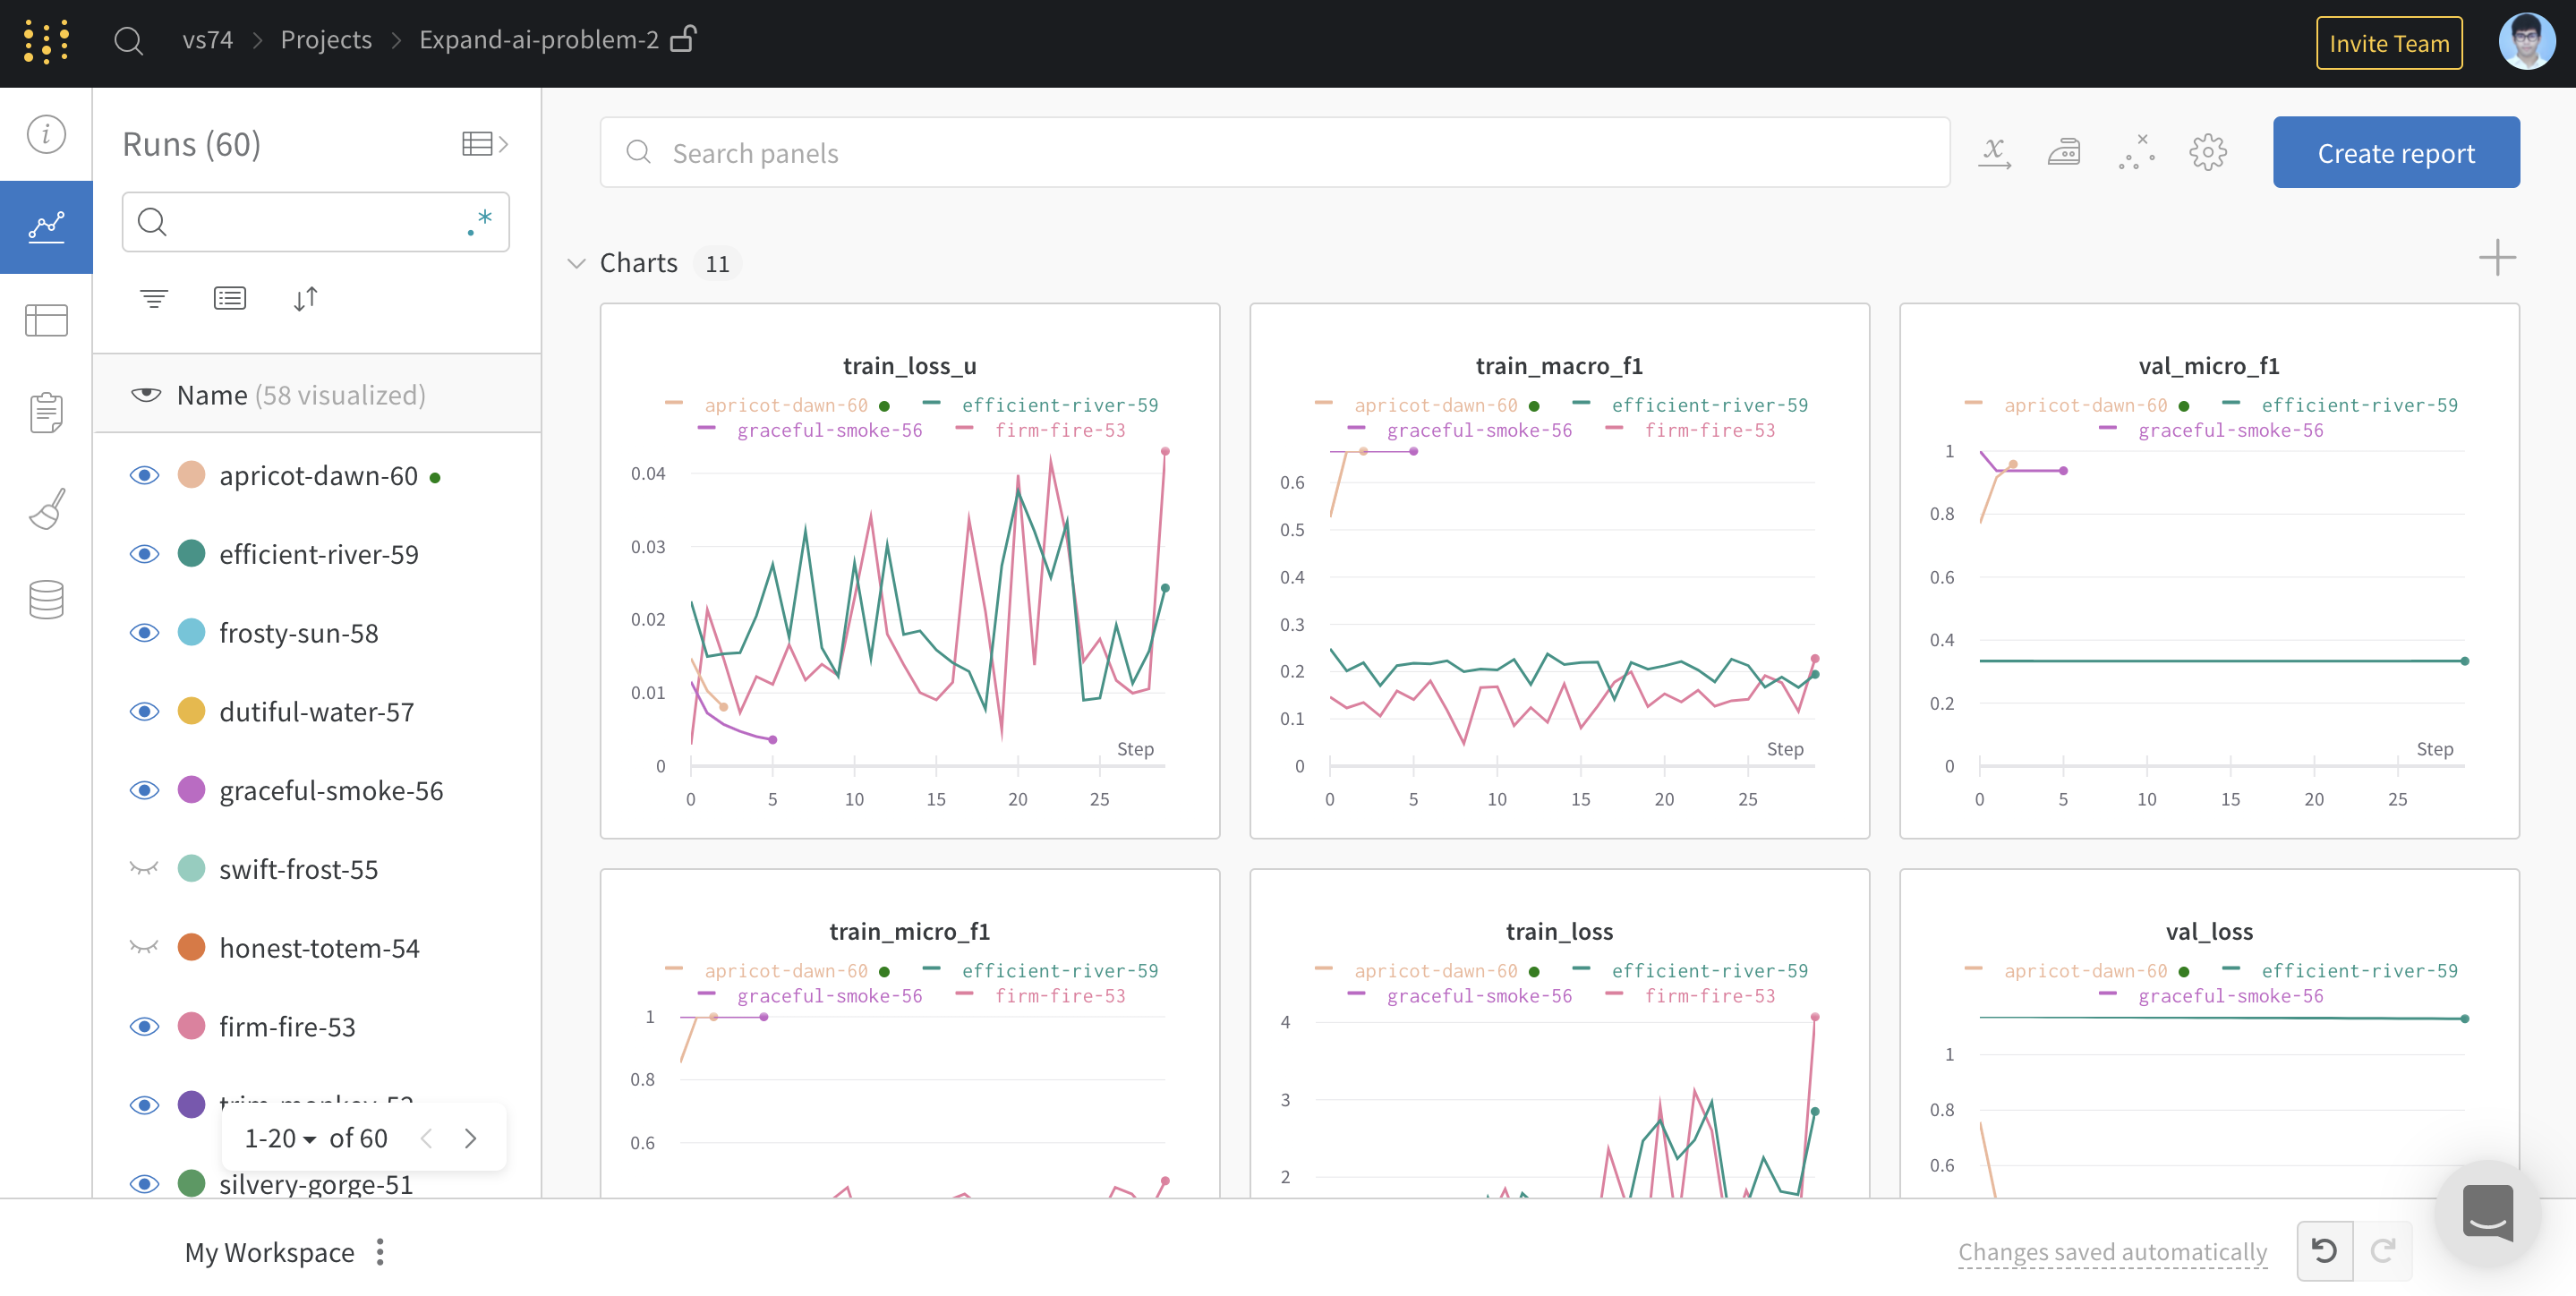

### 